Final CNN1 model for Amgen Inc.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense

Importing the dataset

In [2]:
df = pd.read_csv("AMGN_NN_60sec_ret.csv", low_memory=False, delimiter=",")

In [3]:
df["datetime"] = df["TDay"] + " " + df["IntraT"]
df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)

df = df.drop(columns = {'Spread_Q', 'ret.Spread_Q', 'lag.Spread_Q'})
df.rename(columns={"ret.MidQ": "retMidQ"}, inplace=True)

df["MidQsq"] = df.apply(lambda row: row.MidQ ** 2, axis=1)
df["ret.MidQsq"] = df.apply(lambda row: row.retMidQ ** 2, axis=1)
df["MidQsqsq"] = df.apply(lambda row: row.MidQ ** 3, axis=1)
df['ret.MidQsqsq'] = df.apply(lambda row: row.retMidQ ** 3, axis=1)
df['MidQsqsqsq'] = df.apply(lambda row: row.MidQ ** 4, axis=1)
df['ret.MidQsqsqsq'] = df.apply(lambda row: row.retMidQ ** 4, axis=1)

df = df.drop(columns = {'TDay', 'IntraT', 'datetime'})
df.rename(columns={"retMidQ": "ret.MidQ"}, inplace=True)

df.head()

MidQ  lag.MidQ  ret.MidQ        MidQsq    ret.MidQsq  \
datetime                                                                       
2017-01-03 09:33:00  147.250    147.25  0.000000  21682.562500  0.000000e+00   
2017-01-03 09:34:00  147.450    147.25  0.001357  21741.502500  1.842298e-06   
2017-01-03 09:35:00  147.320    147.45 -0.000882  21703.182400  7.780011e-07   
2017-01-03 09:36:00  147.760    147.32  0.002982  21833.017600  8.893781e-06   
2017-01-03 09:37:00  147.805    147.76  0.000305  21846.318025  9.272119e-08   

                         MidQsqsq  ret.MidQsqsq    MidQsqsqsq  ret.MidQsqsqsq  
datetime                                                                       
2017-01-03 09:33:00  3.192757e+06  0.000000e+00  4.701335e+08    0.000000e+00  
2017-01-03 09:34:00  3.205785e+06  2.500574e-09  4.726929e+08    3.394061e-12  
2017-01-03 09:35:00  3.197313e+06 -6.862309e-10  4.710281e+08    6.052857e-13  
2017-01-03 09:36:00  3.226047e+06  2.652343e-08  4.766807e+08    7.909934e-11  
2017-01-03 09:37:00  3.228995e+06  2.823375e-11  4.772616e+08    8.597220e-15

Creating the input X

In [4]:
sc1 = MinMaxScaler(feature_range=(0,255))
df['X1sc'] = sc1.fit_transform(df['MidQ'].values.reshape(-1,1))
df['X2sc'] = sc1.fit_transform(df['ret.MidQ'].values.reshape(-1,1))
df['X3sc'] = sc1.fit_transform(df['lag.MidQ'].values.reshape(-1,1))
df['X4sc'] = sc1.fit_transform(df['MidQsq'].values.reshape(-1,1))
df['X5sc'] = sc1.fit_transform(df['ret.MidQsq'].values.reshape(-1,1))
df['X6sc'] = sc1.fit_transform(df['MidQsqsq'].values.reshape(-1,1))
df['X7sc'] = sc1.fit_transform(df['ret.MidQsqsq'].values.reshape(-1,1))
df['X8sc'] = sc1.fit_transform(df['MidQsqsqsq'].values.reshape(-1,1))
df['X9sc'] = sc1.fit_transform(df['ret.MidQsqsqsq'].values.reshape(-1,1))

X1 = df.groupby(df.index.date)['X1sc'].apply(np.array).reset_index()
X1 = X1.rename(columns={"index": "datetime"})

X2 = df.groupby(df.index.date)['X2sc'].apply(np.array).reset_index()
X2 = X2.rename(columns={"index": "datetime"})

X3 = df.groupby(df.index.date)['X3sc'].apply(np.array).reset_index()
X3 = X3.rename(columns={"index": "datetime"})

X4 = df.groupby(df.index.date)['X4sc'].apply(np.array).reset_index()
X4 = X4.rename(columns={"index": "datetime"})

X5 = df.groupby(df.index.date)['X5sc'].apply(np.array).reset_index()
X5 = X5.rename(columns={"index": "datetime"})

X6 = df.groupby(df.index.date)['X6sc'].apply(np.array).reset_index()
X6 = X6.rename(columns={"index": "datetime"})

X7 = df.groupby(df.index.date)['X7sc'].apply(np.array).reset_index()
X7 = X7.rename(columns={"index": "datetime"})

X8 = df.groupby(df.index.date)['X8sc'].apply(np.array).reset_index()
X8 = X8.rename(columns={"index": "datetime"})

X9 = df.groupby(df.index.date)['X9sc'].apply(np.array).reset_index()
X9 = X9.rename(columns={"index": "datetime"})

df.head()

MidQ  lag.MidQ  ret.MidQ        MidQsq    ret.MidQsq  \
datetime                                                                       
2017-01-03 09:33:00  147.250    147.25  0.000000  21682.562500  0.000000e+00   
2017-01-03 09:34:00  147.450    147.25  0.001357  21741.502500  1.842298e-06   
2017-01-03 09:35:00  147.320    147.45 -0.000882  21703.182400  7.780011e-07   
2017-01-03 09:36:00  147.760    147.32  0.002982  21833.017600  8.893781e-06   
2017-01-03 09:37:00  147.805    147.76  0.000305  21846.318025  9.272119e-08   

                         MidQsqsq  ret.MidQsqsq    MidQsqsqsq  ret.MidQsqsqsq  \
datetime                                                                        
2017-01-03 09:33:00  3.192757e+06  0.000000e+00  4.701335e+08    0.000000e+00   
2017-01-03 09:34:00  3.205785e+06  2.500574e-09  4.726929e+08    3.394061e-12   
2017-01-03 09:35:00  3.197313e+06 -6.862309e-10  4.710281e+08    6.052857e-13   
2017-01-03 09:36:00  3.226047e+06  2.652343e-08  4.766807e+08    7.909934e-11   
2017-01-03 09:37:00  3.228995e+06  2.823375e-11  4.772616e+08    8.597220e-15   

                          X1sc        X2sc       X3sc       X4sc      X5sc  \
datetime                                                                     
2017-01-03 09:33:00  14.153168  129.629868  14.153168  12.461971  0.000000   
2017-01-03 09:34:00  15.368032  131.958264  14.153168  13.540931  0.082270   
2017-01-03 09:35:00  14.578371  128.116771  15.368032  12.839440  0.034743   
2017-01-03 09:36:00  17.251072  134.745744  14.578371  15.216213  0.397164   
2017-01-03 09:37:00  17.524416  130.152224  17.251072  15.459691  0.004141   

                          X6sc        X7sc       X8sc          X9sc  
datetime                                                             
2017-01-03 09:33:00  10.914857  133.884854   9.510082  0.000000e+00  
2017-01-03 09:34:00  11.868031  133.885630  10.347735  2.654280e-05  
2017-01-03 09:35:00  11.248174  133.884641   9.802872  4.733555e-06  
2017-01-03 09:36:00  13.350569  133.893084  11.652852  6.185857e-04  
2017-01-03 09:37:00  13.566293  133.884863  11.842988  6.723339e-08

Creating the labels y

In [5]:
df_avgm = df.groupby(df.index.date)['ret.MidQ'].mean().reset_index()
df_avgm.columns = ['datetime', 'y']

sc2 = MinMaxScaler(feature_range=(0,1))
df_avgm['ysc'] = sc2.fit_transform(df_avgm['y'].values.reshape(-1,1))

df_avgc = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(X1, X2, on="datetime"),
                                                                                  X3, on="datetime"),
                                                                        X4, on="datetime"),
                                                               X5, on="datetime"),
                                                      X6, on="datetime"),
                                             X7, on="datetime"),
                                    X8, on="datetime"),
                            X9, on="datetime"),
                   df_avgm, on="datetime")

df_avgc = df_avgc.drop(columns = {'datetime', 'y'})

df_avgc.head()

X1sc  \
0  [14.153168175321412, 15.368032396378908, 14.57...   
1  [42.79359218675529, 42.64173415912319, 42.8847...   
2  [44.585516912815365, 43.18842305859914, 43.947...   
3  [94.75940924249596, 95.67055740828982, 92.0867...   
4  [81.12255836112422, 80.90995712243921, 86.7109...   

                                                X2sc  \
0  [129.62986831631196, 131.95826359098706, 128.1...   
1  [130.13792250490764, 129.3476345657781, 130.08...   
2  [126.36567628109518, 127.036602583972, 131.039...   
3  [129.25587112766834, 131.23213963232587, 123.3...   
4  [121.1966930108035, 129.25048298747458, 139.95...   

                                                X3sc  \
0  [14.153168175321412, 14.153168175321412, 15.36...   
1  [42.52024773701771, 42.79359218675529, 42.6417...   
2  [46.347070033349155, 44.585516912815365, 43.18...   
3  [94.97201048118143, 94.75940924249596, 95.6705...   
4  [85.86052882324907, 81.12255836112422, 80.9099...   

                                                X4sc  \
0  [12.461970784713515, 13.540930720659674, 12.83...   
1  [38.28815507312646, 38.14907239611023, 38.3716...   
2  [39.931058755199956, 38.64987712389552, 39.345...   
3  [87.22594767954905, 88.1079068121249, 84.64361...   
4  [74.12438696371845, 73.921591830627, 79.471085...   

                                                X5sc  \
0  [0.0, 0.08227036786198944, 0.0347427174418756,...   
1  [0.003916968627549311, 0.001208781806540488, 0...   
2  [0.16168935263196194, 0.10205259753925099, 0.0...   
3  [0.0021225928448854207, 0.03895849188979431, 0...   
4  [1.0792256966348721, 0.002184193374467674, 1.6...   

                                                X6sc  \
0  [10.914857415173714, 11.868031074068256, 11.24...   
1  [34.08165815192544, 33.95495208844804, 34.1577...   
2  [35.57994045418306, 34.411289071765026, 35.045...   
3  [79.9347422863352, 80.78391693344949, 77.45297...   
4  [67.41405338162988, 67.22163864209526, 72.5023...   

                                                X7sc  \
0  [133.88485417399997, 133.88563003931648, 133.8...   
1  [133.88486223420927, 133.88485279220677, 133.8...   
2  [133.88271649095532, 133.88378226658756, 133.8...   
3  [133.88485095870203, 133.88510700154302, 133.8...   
4  [133.8479912657416, 133.88485081772288, 133.95...   

                                                X8sc  \
0  [9.510081672674886, 10.347735250919811, 9.8028...   
1  [30.184507306467793, 30.06967941437199, 30.253...   
2  [31.543762397954623, 30.48332516078139, 31.059...   
3  [72.93358734312898, 73.74692568265456, 70.5609...   
4  [61.0303188198759, 60.84870671827127, 65.84750...   

                                                X9sc       ysc  
0  [0.0, 2.6542797757439465e-05, 4.73355456959218...  0.699704  
1  [6.016722834982563e-08, 5.730013552248179e-09,...  0.577794  
2  [0.00010252332060605073, 4.084208888042486e-05...  0.543952  
3  [1.766823680454425e-08, 5.952016040498704e-06,...  0.369091  
4  [0.004567561193243236, 1.8708630184582293e-08,...  0.496850

Connecting the right X and y

In [6]:
df_avgc.ysc = df_avgc.ysc.shift(-1)
df_avgc = df_avgc.dropna(axis='rows', how='any')

df_avgc.head()

X1sc  \
0  [14.153168175321412, 15.368032396378908, 14.57...   
1  [42.79359218675529, 42.64173415912319, 42.8847...   
2  [44.585516912815365, 43.18842305859914, 43.947...   
3  [94.75940924249596, 95.67055740828982, 92.0867...   
4  [81.12255836112422, 80.90995712243921, 86.7109...   

                                                X2sc  \
0  [129.62986831631196, 131.95826359098706, 128.1...   
1  [130.13792250490764, 129.3476345657781, 130.08...   
2  [126.36567628109518, 127.036602583972, 131.039...   
3  [129.25587112766834, 131.23213963232587, 123.3...   
4  [121.1966930108035, 129.25048298747458, 139.95...   

                                                X3sc  \
0  [14.153168175321412, 14.153168175321412, 15.36...   
1  [42.52024773701771, 42.79359218675529, 42.6417...   
2  [46.347070033349155, 44.585516912815365, 43.18...   
3  [94.97201048118143, 94.75940924249596, 95.6705...   
4  [85.86052882324907, 81.12255836112422, 80.9099...   

                                                X4sc  \
0  [12.461970784713515, 13.540930720659674, 12.83...   
1  [38.28815507312646, 38.14907239611023, 38.3716...   
2  [39.931058755199956, 38.64987712389552, 39.345...   
3  [87.22594767954905, 88.1079068121249, 84.64361...   
4  [74.12438696371845, 73.921591830627, 79.471085...   

                                                X5sc  \
0  [0.0, 0.08227036786198944, 0.0347427174418756,...   
1  [0.003916968627549311, 0.001208781806540488, 0...   
2  [0.16168935263196194, 0.10205259753925099, 0.0...   
3  [0.0021225928448854207, 0.03895849188979431, 0...   
4  [1.0792256966348721, 0.002184193374467674, 1.6...   

                                                X6sc  \
0  [10.914857415173714, 11.868031074068256, 11.24...   
1  [34.08165815192544, 33.95495208844804, 34.1577...   
2  [35.57994045418306, 34.411289071765026, 35.045...   
3  [79.9347422863352, 80.78391693344949, 77.45297...   
4  [67.41405338162988, 67.22163864209526, 72.5023...   

                                                X7sc  \
0  [133.88485417399997, 133.88563003931648, 133.8...   
1  [133.88486223420927, 133.88485279220677, 133.8...   
2  [133.88271649095532, 133.88378226658756, 133.8...   
3  [133.88485095870203, 133.88510700154302, 133.8...   
4  [133.8479912657416, 133.88485081772288, 133.95...   

                                                X8sc  \
0  [9.510081672674886, 10.347735250919811, 9.8028...   
1  [30.184507306467793, 30.06967941437199, 30.253...   
2  [31.543762397954623, 30.48332516078139, 31.059...   
3  [72.93358734312898, 73.74692568265456, 70.5609...   
4  [61.0303188198759, 60.84870671827127, 65.84750...   

                                                X9sc       ysc  
0  [0.0, 2.6542797757439465e-05, 4.73355456959218...  0.577794  
1  [6.016722834982563e-08, 5.730013552248179e-09,...  0.543952  
2  [0.00010252332060605073, 4.084208888042486e-05...  0.369091  
3  [1.766823680454425e-08, 5.952016040498704e-06,...  0.496850  
4  [0.004567561193243236, 1.8708630184582293e-08,...  0.565857

Shaping the input X and split between taining and testing

In [7]:
X1t = df_avgc['X1sc'].drop(df_avgc['X1sc'].index[100:123])
X1t = np.asarray(X1t).flatten().tolist()
X1t = np.array(X1t).reshape(100, 393, 1)

X2t = df_avgc['X2sc'].drop(df_avgc['X2sc'].index[100:123])
X2t = np.asarray(X2t).flatten().tolist()
X2t = np.array(X2t).reshape(100, 393, 1)

X3t = df_avgc['X3sc'].drop(df_avgc['X3sc'].index[100:123])
X3t = np.asarray(X3t).flatten().tolist()
X3t = np.array(X3t).reshape(100, 393, 1)

X4t = df_avgc['X4sc'].drop(df_avgc['X4sc'].index[100:123])
X4t = np.asarray(X4t).flatten().tolist()
X4t = np.array(X4t).reshape(100, 393, 1)

X5t = df_avgc['X5sc'].drop(df_avgc['X5sc'].index[100:123])
X5t = np.asarray(X5t).flatten().tolist()
X5t = np.array(X5t).reshape(100, 393, 1)

X6t = df_avgc['X6sc'].drop(df_avgc['X6sc'].index[100:123])
X6t = np.asarray(X6t).flatten().tolist()
X6t = np.array(X6t).reshape(100, 393, 1)

X7t = df_avgc['X7sc'].drop(df_avgc['X7sc'].index[100:123])
X7t = np.asarray(X7t).flatten().tolist()
X7t = np.array(X7t).reshape(100, 393, 1)

X8t = df_avgc['X8sc'].drop(df_avgc['X8sc'].index[100:123])
X8t = np.asarray(X8t).flatten().tolist()
X8t = np.array(X8t).reshape(100, 393, 1)

X9t = df_avgc['X9sc'].drop(df_avgc['X9sc'].index[100:123])
X9t = np.asarray(X9t).flatten().tolist()
X9t = np.array(X9t).reshape(100, 393, 1)

In [8]:
X_train = np.concatenate((X1t, X2t, X3t, X4t, X5t, X6t, X7t, X8t, X9t),
                         axis=2)
X_train = X_train.reshape(X_train.shape[0], 393, 9, 1)
X_train = X_train.astype('float32')

X_train.shape

(100, 393, 9, 1)

In [9]:
X1p = df_avgc['X1sc'].drop(df_avgc['X1sc'].index[0:100])
X1p = np.asarray(X1p).flatten().tolist()
X1p = np.array(X1p).reshape(23, 393, 1)

X2p = df_avgc['X2sc'].drop(df_avgc['X2sc'].index[0:100])
X2p = np.asarray(X2p).flatten().tolist()
X2p = np.array(X2p).reshape(23, 393, 1)

X3p = df_avgc['X3sc'].drop(df_avgc['X3sc'].index[0:100])
X3p = np.asarray(X3p).flatten().tolist()
X3p = np.array(X3p).reshape(23, 393, 1)

X4p = df_avgc['X4sc'].drop(df_avgc['X4sc'].index[0:100])
X4p = np.asarray(X4p).flatten().tolist()
X4p = np.array(X4p).reshape(23, 393, 1)

X5p = df_avgc['X5sc'].drop(df_avgc['X5sc'].index[0:100])
X5p = np.asarray(X5p).flatten().tolist()
X5p = np.array(X5p).reshape(23, 393, 1)

X6p = df_avgc['X6sc'].drop(df_avgc['X6sc'].index[0:100])
X6p = np.asarray(X6p).flatten().tolist()
X6p = np.array(X6p).reshape(23, 393, 1)

X7p = df_avgc['X7sc'].drop(df_avgc['X7sc'].index[0:100])
X7p = np.asarray(X7p).flatten().tolist()
X7p = np.array(X7p).reshape(23, 393, 1)

X8p = df_avgc['X8sc'].drop(df_avgc['X8sc'].index[0:100])
X8p = np.asarray(X8p).flatten().tolist()
X8p = np.array(X8p).reshape(23, 393, 1)

X9p = df_avgc['X9sc'].drop(df_avgc['X9sc'].index[0:100])
X9p = np.asarray(X9p).flatten().tolist()
X9p = np.array(X9p).reshape(23, 393, 1)

In [10]:
X_test = np.concatenate((X1p, X2p, X3p, X4p, X5p, X6p, X7p, X8p, X9p),
                        axis=2)
X_test = X_test.reshape(X_test.shape[0], 393, 9, 1)
X_test = X_test.astype('float32')

X_test.shape

(23, 393, 9, 1)

Shaping the labels y and split between training and testing

In [11]:
df_avgc = df_avgc[['X1sc', 'X2sc', 'X3sc', 'X4sc', 'X5sc', 'X6sc', 'X7sc', 'X8sc', 'X9sc', 'ysc']]
ym = df_avgc.iloc[:, 9:10].values

In [12]:
ymt = []
for i in range(0, 100):
    ymt.append(ym[i, 0])
    
ymt = np.array(ymt)
ym_train = np.reshape(ymt, (ymt.shape[0], 1))

ym_train.shape

(100, 1)

In [13]:
ymp = []
for i in range(100, 123):
    ymp.append(ym[i, 0])
    
ymp = np.array(ymp)
ym_test = np.reshape(ymp, (ymp.shape[0], 1))

ym_test.shape

(23, 1)

Actual Model

In [14]:
IM_HEIGHT = 393
IM_WIDTH = 9

In [15]:
class MultiOutputModel():
    
    def make_default_hidden_layers(self, inputs):
    
        x = Conv2D(16, (3, 3), padding="same",
                   kernel_initializer="HeUniform")(inputs)
        x = Activation("elu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0)(x)        
        
        x = Conv2D(32, (3, 3), padding="same",
                   kernel_initializer="HeUniform")(x)
        x = Activation("elu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0)(x)
                
        x = Conv2D(64, (3, 3), padding="same",
                   kernel_initializer="HeUniform")(x)
        x = Activation("elu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0)(x)
        
        x = Conv2D(128, (3, 3), padding="same",
                   kernel_initializer="HeUniform")(x)
        x = Activation("elu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(1, 1))(x)
        x = Dropout(0)(x)
        
        x = Conv2D(256, (3, 3), padding="same",
                   kernel_initializer="HeUniform")(x)
        x = Activation("elu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(1, 1))(x)
        x = Dropout(0)(x)
        
        return x    
    
    def build_retmean_branch(self, inputs):

        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(64)(x)
        x = Activation("elu")(x)
        x = Dropout(0.3)(x)
        x = Dense(1)(x)
        x = Activation("sigmoid", name="retmean_output")(x)        
        
        return x
    
    def assemble_full_model(self, width, height):

        input_shape = (height, width, 1)        
        inputs = Input(shape=input_shape)
        
        retmean_branch = self.build_retmean_branch(inputs)       
        
        model = Model(inputs=inputs,
                     outputs = [retmean_branch],
                     name="CNN_Model_4")        
        
        return model
    
model = MultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT)

Training parameters 

In [16]:
init_lr = 0.0001
epochs = 750
batch_size = 10

opt = RMSprop(learning_rate=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
            loss={'retmean_output': 'mse'},
            loss_weights={'retmean_output': 0.1},
            metrics={'retmean_output': 'mae'})

Restarting the random weight initialization after each run

In [17]:
def reset_weights(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue

        #where are the initializers?
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if "initializer" not in key: #is this item an initializer?
                  continue #if no, skip it

            # find the corresponding variable, like the kernel or the bias
            if key == 'recurrent_initializer': #special case check
                var = getattr(init_container, 'recurrent_kernel')
            else:
                var = getattr(init_container, key.replace("_initializer", ""))

            var.assign(initializer(var.shape, var.dtype))
            #use the initializer

Training process

In [18]:
predres=[]
predstd=[]

for i in range(100):

    history = model.fit(x=X_train, y={"retmean_output": ym_train},
                    batch_size=batch_size,
                    epochs=epochs)
    
    res = model.predict(X_test)
    predres.append(res)
    std = np.std(predres)
    predstd.append(std)
    
    model.reset_states()
    reset_weights(model)

Epoch 1/750
10/10 [==============================] - 15s 38ms/step - loss: 0.0177 - mae: 0.3852
Epoch 2/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0171 - mae: 0.3802
Epoch 3/750
10/10 [==============================] - 0s 39ms/step - loss: 0.0144 - mae: 0.3317
Epoch 4/750
10/10 [==============================] - 0s 44ms/step - loss: 0.0147 - mae: 0.3435
Epoch 5/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0119 - mae: 0.2933
Epoch 6/750
10/10 [==============================] - 0s 40ms/step - loss: 0.0111 - mae: 0.2862
Epoch 7/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0106 - mae: 0.2732
Epoch 8/750
10/10 [==============================] - 0s 44ms/step - loss: 0.0131 - mae: 0.3094
Epoch 9/750
10/10 [==============================] - 0s 40ms/step - loss: 0.0091 - mae: 0.2590
Epoch 10/750
10/10 [==============================] - 0s 43ms/step - loss: 0.0109 - mae: 0.2768
Epoch 11/750
10/10 [============================

10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1657
Epoch 86/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1461
Epoch 87/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1388
Epoch 88/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1523
Epoch 89/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1489
Epoch 90/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1503
Epoch 91/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1614
Epoch 92/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1650
Epoch 93/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1528
Epoch 94/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1483
Epoch 95/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1329
Epoch 170/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1634
Epoch 171/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1339
Epoch 172/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1409
Epoch 173/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1308
Epoch 174/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1278
Epoch 175/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1202
Epoch 176/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1387
Epoch 177/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1480
Epoch 178/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1370
Epoch 179/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1233
Epoch 254/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1137
Epoch 255/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1156
Epoch 256/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1077
Epoch 257/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1153
Epoch 258/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1085
Epoch 259/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1103
Epoch 260/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1112
Epoch 261/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1090
Epoch 262/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1255
Epoch 263/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0872
Epoch 338/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1081
Epoch 339/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0992
Epoch 340/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1047
Epoch 341/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1151
Epoch 342/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0960
Epoch 343/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0932
Epoch 344/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1031
Epoch 345/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0991
Epoch 346/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.1047
Epoch 347/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0864
Epoch 421/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0872
Epoch 422/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5025e-04 - mae: 0.0781
Epoch 423/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0932
Epoch 424/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0897
Epoch 425/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0841
Epoch 426/750
10/10 [==============================] - 0s 37ms/step - loss: 9.8839e-04 - mae: 0.0780
Epoch 427/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0833
Epoch 428/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5934e-04 - mae: 0.0706
Epoch 429/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0814
Epoch 430/750
10/10 [===========

10/10 [==============================] - 0s 35ms/step - loss: 6.6193e-04 - mae: 0.0639
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8862e-04 - mae: 0.0629
Epoch 504/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3768e-04 - mae: 0.0796
Epoch 505/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1185e-04 - mae: 0.0603
Epoch 506/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4828e-04 - mae: 0.0637
Epoch 507/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4486e-04 - mae: 0.0760
Epoch 508/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3385e-04 - mae: 0.0624
Epoch 509/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4349e-04 - mae: 0.0723
Epoch 510/750
10/10 [==============================] - 0s 41ms/step - loss: 9.1575e-04 - mae: 0.0783
Epoch 511/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9833e-04 - mae: 0.0607
Epoc

10/10 [==============================] - 0s 42ms/step - loss: 5.7205e-04 - mae: 0.0602
Epoch 584/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5218e-04 - mae: 0.0600
Epoch 585/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3536e-04 - mae: 0.0582
Epoch 586/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9346e-04 - mae: 0.0466
Epoch 587/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3358e-04 - mae: 0.0631
Epoch 588/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9552e-04 - mae: 0.0585
Epoch 589/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1024e-04 - mae: 0.0525
Epoch 590/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6898e-04 - mae: 0.0643
Epoch 591/750
10/10 [==============================] - 0s 38ms/step - loss: 5.3135e-04 - mae: 0.0586
Epoch 592/750
10/10 [==============================] - 0s 38ms/step - loss: 5.4455e-04 - mae: 0.0548
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.7835e-04 - mae: 0.0461
Epoch 664/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5339e-04 - mae: 0.0357
Epoch 665/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9910e-04 - mae: 0.0438
Epoch 666/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1630e-04 - mae: 0.0441
Epoch 667/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2498e-04 - mae: 0.0494
Epoch 668/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2331e-04 - mae: 0.0504
Epoch 669/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9880e-04 - mae: 0.0429
Epoch 670/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4538e-04 - mae: 0.0367
Epoch 671/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3989e-04 - mae: 0.0384
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8579e-04 - mae: 0.0442
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 1.6205e-04 - mae: 0.0282
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 1.4511e-04 - mae: 0.0290
Epoch 746/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9329e-04 - mae: 0.0302
Epoch 747/750
10/10 [==============================] - 0s 37ms/step - loss: 2.2407e-04 - mae: 0.0375
Epoch 748/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9852e-04 - mae: 0.0377
Epoch 749/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0146e-04 - mae: 0.0331
Epoch 750/750
10/10 [==============================] - 0s 36ms/step - loss: 1.5374e-04 - mae: 0.0303
Epoch 1/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0179 - mae: 0.3836
Epoch 2/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0149 - mae: 0.3442
Epoch 3/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0131 - mae: 0.3181
Epoch 4/750
10/10 [===

10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1499
Epoch 80/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1658
Epoch 81/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1642
Epoch 82/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1599
Epoch 83/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1571
Epoch 84/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1501
Epoch 85/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1521
Epoch 86/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1759
Epoch 87/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1529
Epoch 88/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1383
Epoch 89/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1382
Epoch 164/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1420
Epoch 165/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1185
Epoch 166/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1188
Epoch 167/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1451
Epoch 168/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1330
Epoch 169/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1204
Epoch 170/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1301
Epoch 171/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1358
Epoch 172/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1278
Epoch 173/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1051
Epoch 248/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0987
Epoch 249/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1151
Epoch 250/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1000
Epoch 251/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1169
Epoch 252/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0941
Epoch 253/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0944
Epoch 254/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0911
Epoch 255/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0944
Epoch 256/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0921
Epoch 257/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.2963e-04 - mae: 0.0762
Epoch 332/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0792
Epoch 333/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0796
Epoch 334/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0901
Epoch 335/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6510e-04 - mae: 0.0763
Epoch 336/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0863
Epoch 337/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4166e-04 - mae: 0.0789
Epoch 338/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0763
Epoch 339/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0865
Epoch 340/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2062e-04 - mae: 0.0723
Epoch 341/750
10/10 [=======

10/10 [==============================] - 0s 36ms/step - loss: 9.9271e-04 - mae: 0.0747
Epoch 414/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0766
Epoch 415/750
10/10 [==============================] - 0s 38ms/step - loss: 6.0880e-04 - mae: 0.0618
Epoch 416/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4926e-04 - mae: 0.0627
Epoch 417/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5448e-04 - mae: 0.0655
Epoch 418/750
10/10 [==============================] - 0s 37ms/step - loss: 9.2968e-04 - mae: 0.0758
Epoch 419/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0736
Epoch 420/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1460e-04 - mae: 0.0642
Epoch 421/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7790e-04 - mae: 0.0606
Epoch 422/750
10/10 [==============================] - 0s 38ms/step - loss: 7.6068e-04 - mae: 0.0640
Epoch 423/75

10/10 [==============================] - 0s 36ms/step - loss: 5.2203e-04 - mae: 0.0544
Epoch 495/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9526e-04 - mae: 0.0490
Epoch 496/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8312e-04 - mae: 0.0578
Epoch 497/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2094e-04 - mae: 0.0604
Epoch 498/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7161e-04 - mae: 0.0487
Epoch 499/750
10/10 [==============================] - 0s 38ms/step - loss: 5.6857e-04 - mae: 0.0530
Epoch 500/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2908e-04 - mae: 0.0547
Epoch 501/750
10/10 [==============================] - 0s 38ms/step - loss: 5.7881e-04 - mae: 0.0590
Epoch 502/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6471e-04 - mae: 0.0537
Epoch 503/750
10/10 [==============================] - 0s 37ms/step - loss: 7.3454e-04 - mae: 0.0616
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 7.4233e-04 - mae: 0.0622
Epoch 575/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9288e-04 - mae: 0.0551
Epoch 576/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0668e-04 - mae: 0.0415
Epoch 577/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4450e-04 - mae: 0.0498
Epoch 578/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5093e-04 - mae: 0.0447
Epoch 579/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8081e-04 - mae: 0.0506
Epoch 580/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4616e-04 - mae: 0.0436
Epoch 581/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2569e-04 - mae: 0.0455
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2654e-04 - mae: 0.0351
Epoch 583/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6871e-04 - mae: 0.0390
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.8472e-04 - mae: 0.0461
Epoch 655/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9733e-04 - mae: 0.0383
Epoch 656/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5132e-04 - mae: 0.0479
Epoch 657/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2417e-04 - mae: 0.0401
Epoch 658/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1676e-04 - mae: 0.0417
Epoch 659/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6694e-04 - mae: 0.0383
Epoch 660/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6833e-04 - mae: 0.0441
Epoch 661/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3126e-04 - mae: 0.0416
Epoch 662/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8308e-04 - mae: 0.0470
Epoch 663/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0885e-04 - mae: 0.0399
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.3854e-04 - mae: 0.0370
Epoch 736/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8466e-04 - mae: 0.0344
Epoch 737/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8466e-04 - mae: 0.0381
Epoch 738/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2243e-04 - mae: 0.0354
Epoch 739/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9177e-04 - mae: 0.0384
Epoch 740/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5399e-04 - mae: 0.0336
Epoch 741/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4525e-04 - mae: 0.0365
Epoch 742/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6374e-04 - mae: 0.0374
Epoch 743/750
10/10 [==============================] - 0s 37ms/step - loss: 1.6757e-04 - mae: 0.0317
Epoch 744/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6991e-04 - mae: 0.0375
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1450
Epoch 70/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1531
Epoch 71/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1618
Epoch 72/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1387
Epoch 73/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1444
Epoch 74/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1445
Epoch 75/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0033 - mae: 0.1504
Epoch 76/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0036 - mae: 0.1522
Epoch 77/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1649
Epoch 78/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1417
Epoch 79/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1341
Epoch 154/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1245
Epoch 155/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1425
Epoch 156/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1380
Epoch 157/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1280
Epoch 158/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1407
Epoch 159/750
10/10 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.139 - 0s 37ms/step - loss: 0.0031 - mae: 0.1400
Epoch 160/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1385
Epoch 161/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1355
Epoch 162/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0023 - mae: 0.1236
Epoch 

10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1102
Epoch 237/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1274
Epoch 238/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1072
Epoch 239/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1006
Epoch 240/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1196
Epoch 241/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1139
Epoch 242/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1208
Epoch 243/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1206
Epoch 244/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0906
Epoch 245/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1296
Epoch 246/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0829
Epoch 320/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0969
Epoch 321/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0935
Epoch 322/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1003
Epoch 323/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0995
Epoch 324/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1117
Epoch 325/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0915
Epoch 326/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1078
Epoch 327/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1079
Epoch 328/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0019 - mae: 0.1096
Epoch 329/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.1036
Epoch 404/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0893
Epoch 405/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0834
Epoch 406/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0812
Epoch 407/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0887
Epoch 408/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2874e-04 - mae: 0.0660
Epoch 409/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9632e-04 - mae: 0.0794
Epoch 410/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0882
Epoch 411/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0857
Epoch 412/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0917
Epoch 413/750
10/10 [===============

10/10 [==============================] - 0s 37ms/step - loss: 6.7718e-04 - mae: 0.0665
Epoch 486/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0806
Epoch 487/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0826
Epoch 488/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9134e-04 - mae: 0.0755
Epoch 489/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1341e-04 - mae: 0.0643
Epoch 490/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2936e-04 - mae: 0.0784
Epoch 491/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2134e-04 - mae: 0.0663
Epoch 492/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7762e-04 - mae: 0.0726
Epoch 493/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7433e-04 - mae: 0.0703
Epoch 494/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0388e-04 - mae: 0.0732
Epoch 495/75

10/10 [==============================] - 0s 37ms/step - loss: 5.5498e-04 - mae: 0.0537
Epoch 567/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4376e-04 - mae: 0.0464
Epoch 568/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7554e-04 - mae: 0.0639
Epoch 569/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9771e-04 - mae: 0.0553
Epoch 570/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0625e-04 - mae: 0.0481
Epoch 571/750
10/10 [==============================] - 0s 38ms/step - loss: 5.1567e-04 - mae: 0.0583
Epoch 572/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9996e-04 - mae: 0.0516
Epoch 573/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2622e-04 - mae: 0.0561
Epoch 574/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3634e-04 - mae: 0.0591
Epoch 575/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4976e-04 - mae: 0.0680
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.9000e-04 - mae: 0.0383
Epoch 647/750
10/10 [==============================] - 0s 38ms/step - loss: 1.9644e-04 - mae: 0.0351
Epoch 648/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0135e-04 - mae: 0.0420
Epoch 649/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1555e-04 - mae: 0.0460
Epoch 650/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6180e-04 - mae: 0.0506
Epoch 651/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4759e-04 - mae: 0.0377
Epoch 652/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9535e-04 - mae: 0.0325
Epoch 653/750
10/10 [==============================] - 0s 37ms/step - loss: 1.7771e-04 - mae: 0.0305
Epoch 654/750
10/10 [==============================] - 0s 37ms/step - loss: 2.2121e-04 - mae: 0.0358
Epoch 655/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8099e-04 - mae: 0.0447
Epoc

10/10 [==============================] - 0s 38ms/step - loss: 3.2659e-04 - mae: 0.0375
Epoch 728/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4064e-04 - mae: 0.0345
Epoch 729/750
10/10 [==============================] - 0s 37ms/step - loss: 1.6481e-04 - mae: 0.0300
Epoch 730/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8105e-04 - mae: 0.0333
Epoch 731/750
10/10 [==============================] - 0s 38ms/step - loss: 1.7523e-04 - mae: 0.0301: 0s - loss: 1.5378e-04 - mae: 0.0
Epoch 732/750
10/10 [==============================] - 0s 38ms/step - loss: 2.6505e-04 - mae: 0.0357
Epoch 733/750
10/10 [==============================] - 0s 38ms/step - loss: 2.2306e-04 - mae: 0.0333
Epoch 734/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8016e-04 - mae: 0.0308
Epoch 735/750
10/10 [==============================] - 0s 37ms/step - loss: 2.0514e-04 - mae: 0.0327
Epoch 736/750
10/10 [==============================] - 0s 37ms/step - l

Epoch 61/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1881
Epoch 62/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1600
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1466
Epoch 64/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1511
Epoch 65/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1754
Epoch 66/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1797
Epoch 67/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1598
Epoch 68/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1639
Epoch 69/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1554
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1454
Epoch 71/750
10/10 [====================

10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1424
Epoch 146/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0022 - mae: 0.1217
Epoch 147/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1661
Epoch 148/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0033 - mae: 0.1517
Epoch 149/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1617
Epoch 150/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1238
Epoch 151/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1306
Epoch 152/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1553
Epoch 153/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1402
Epoch 154/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1377
Epoch 155/750
10/10 [=======================

10/10 [==============================] - 0s 38ms/step - loss: 0.0024 - mae: 0.1272
Epoch 230/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1202
Epoch 231/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1227
Epoch 232/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1205
Epoch 233/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1233
Epoch 234/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1295
Epoch 235/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1112
Epoch 236/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1088
Epoch 237/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1132
Epoch 238/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1189
Epoch 239/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1070
Epoch 314/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0941
Epoch 315/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1034
Epoch 316/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1162
Epoch 317/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1046
Epoch 318/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0933
Epoch 319/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0993
Epoch 320/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1082
Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1105
Epoch 322/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0984
Epoch 323/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0908
Epoch 398/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0941
Epoch 399/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0877
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0890
Epoch 401/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9564e-04 - mae: 0.0794
Epoch 402/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0015 - mae: 0.0937
Epoch 403/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0013 - mae: 0.0897
Epoch 404/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0970
Epoch 405/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0874
Epoch 406/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0856
Epoch 407/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 8.4980e-04 - mae: 0.0771
Epoch 481/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6518e-04 - mae: 0.0798
Epoch 482/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0771
Epoch 483/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1781e-04 - mae: 0.0721
Epoch 484/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7704e-04 - mae: 0.0748
Epoch 485/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0811
Epoch 486/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3089e-04 - mae: 0.0763
Epoch 487/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0824
Epoch 488/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2412e-04 - mae: 0.0757
Epoch 489/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0817
Epoch 490/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 5.6140e-04 - mae: 0.0627
Epoch 562/750
10/10 [==============================] - 0s 37ms/step - loss: 6.9460e-04 - mae: 0.0673
Epoch 563/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5248e-04 - mae: 0.0588
Epoch 564/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0159e-04 - mae: 0.0615
Epoch 565/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2809e-04 - mae: 0.0550
Epoch 566/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0835e-04 - mae: 0.0628
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5043e-04 - mae: 0.0560
Epoch 568/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8239e-04 - mae: 0.0693
Epoch 569/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8458e-04 - mae: 0.0623
Epoch 570/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1725e-04 - mae: 0.0706
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.4230e-04 - mae: 0.0441
Epoch 643/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3878e-04 - mae: 0.0389
Epoch 644/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2233e-04 - mae: 0.0554
Epoch 645/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9411e-04 - mae: 0.0504
Epoch 646/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0447e-04 - mae: 0.0517
Epoch 647/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3121e-04 - mae: 0.0504
Epoch 648/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9916e-04 - mae: 0.0545
Epoch 649/750
10/10 [==============================] - 0s 37ms/step - loss: 2.1629e-04 - mae: 0.0371
Epoch 650/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8979e-04 - mae: 0.0510
Epoch 651/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8985e-04 - mae: 0.0440
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.6881e-04 - mae: 0.0394
Epoch 724/750
10/10 [==============================] - 0s 36ms/step - loss: 1.6161e-04 - mae: 0.0311
Epoch 725/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0442e-04 - mae: 0.0342
Epoch 726/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0450e-04 - mae: 0.0358
Epoch 727/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4703e-04 - mae: 0.0358
Epoch 728/750
10/10 [==============================] - 0s 37ms/step - loss: 1.6741e-04 - mae: 0.0311
Epoch 729/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7170e-04 - mae: 0.0310
Epoch 730/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3922e-04 - mae: 0.0367
Epoch 731/750
10/10 [==============================] - 0s 37ms/step - loss: 1.2593e-04 - mae: 0.0279
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6339e-04 - mae: 0.0387
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0057 - mae: 0.2022
Epoch 58/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0057 - mae: 0.1892: 0s - loss: 0.0059 - mae: 0.1
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0053 - mae: 0.1917
Epoch 60/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1766
Epoch 61/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0052 - mae: 0.1849
Epoch 62/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1701
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1582
Epoch 64/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0051 - mae: 0.1720
Epoch 65/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0049 - mae: 0.1813
Epoch 66/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1671
Epoch 67/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1534
Epoch 142/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1624
Epoch 143/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1439
Epoch 144/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1182
Epoch 145/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1312
Epoch 146/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0026 - mae: 0.1328
Epoch 147/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1325
Epoch 148/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1164
Epoch 149/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1513
Epoch 150/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1426
Epoch 151/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1204
Epoch 226/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1061
Epoch 227/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0918
Epoch 228/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1034
Epoch 229/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0938
Epoch 230/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0018 - mae: 0.1057
Epoch 231/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1190
Epoch 232/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0986
Epoch 233/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1079
Epoch 234/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0917
Epoch 235/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0750
Epoch 310/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0848
Epoch 311/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0832
Epoch 312/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0750
Epoch 313/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0919
Epoch 314/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0837
Epoch 315/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2884e-04 - mae: 0.0626
Epoch 316/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0891
Epoch 317/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0841
Epoch 318/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5868e-04 - mae: 0.0739
Epoch 319/750
10/10 [===============

10/10 [==============================] - 0s 35ms/step - loss: 9.4957e-04 - mae: 0.0714
Epoch 392/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0698
Epoch 393/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0776
Epoch 394/750
10/10 [==============================] - 0s 38ms/step - loss: 9.3889e-04 - mae: 0.0676
Epoch 395/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2027e-04 - mae: 0.0638
Epoch 396/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0752
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8029e-04 - mae: 0.0593
Epoch 398/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4098e-04 - mae: 0.0651
Epoch 399/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1375e-04 - mae: 0.0603
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3253e-04 - mae: 0.0649
Epoch 401/750
10

10/10 [==============================] - 0s 35ms/step - loss: 9.0983e-04 - mae: 0.0685
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2526e-04 - mae: 0.0525
Epoch 474/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0454e-04 - mae: 0.0611
Epoch 475/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2081e-04 - mae: 0.0599
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9017e-04 - mae: 0.0483
Epoch 477/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5266e-04 - mae: 0.0653
Epoch 478/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7353e-04 - mae: 0.0518
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6625e-04 - mae: 0.0630
Epoch 480/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9293e-04 - mae: 0.0630
Epoch 481/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0764e-04 - mae: 0.0595
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 6.7840e-04 - mae: 0.0548
Epoch 554/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0835e-04 - mae: 0.0556
Epoch 555/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1571e-04 - mae: 0.0415
Epoch 556/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3259e-04 - mae: 0.0618
Epoch 557/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6744e-04 - mae: 0.0416
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 8.4419e-04 - mae: 0.0599
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7725e-04 - mae: 0.0544
Epoch 560/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8464e-04 - mae: 0.0438
Epoch 561/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5647e-04 - mae: 0.0468
Epoch 562/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6248e-04 - mae: 0.0514
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.6765e-04 - mae: 0.0423
Epoch 635/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3221e-04 - mae: 0.0498
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5219e-04 - mae: 0.0469
Epoch 637/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7631e-04 - mae: 0.0497
Epoch 638/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0176e-04 - mae: 0.0451
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8218e-04 - mae: 0.0544
Epoch 640/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2627e-04 - mae: 0.0443
Epoch 641/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0529e-04 - mae: 0.0491
Epoch 642/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1537e-04 - mae: 0.0376
Epoch 643/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5156e-04 - mae: 0.0411
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.2225e-04 - mae: 0.0403
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8507e-04 - mae: 0.0406
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1512e-04 - mae: 0.0492
Epoch 717/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5852e-04 - mae: 0.0347
Epoch 718/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7285e-04 - mae: 0.0354: 0s - loss: 2.8771e-04 - mae: 0.0
Epoch 719/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3140e-04 - mae: 0.0420
Epoch 720/750
10/10 [==============================] - 0s 38ms/step - loss: 3.3171e-04 - mae: 0.0395
Epoch 721/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4527e-04 - mae: 0.0350
Epoch 722/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3293e-04 - mae: 0.0429
Epoch 723/750
10/10 [==============================] - 0s 38ms/step - l

10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1412
Epoch 48/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0043 - mae: 0.1715
Epoch 49/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1643
Epoch 50/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1668
Epoch 51/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1612
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1571
Epoch 53/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1728
Epoch 54/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1565
Epoch 55/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1627
Epoch 56/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1376
Epoch 57/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1204
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1352
Epoch 133/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1359
Epoch 134/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1400
Epoch 135/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1362
Epoch 136/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1377
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1413
Epoch 138/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1346
Epoch 139/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1350
Epoch 140/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1487
Epoch 141/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1460
Epoch 216/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1183
Epoch 217/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1140
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1059
Epoch 219/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1073
Epoch 220/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1099
Epoch 221/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1272
Epoch 222/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1084
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1291
Epoch 224/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1203
Epoch 225/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1108
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0954
Epoch 301/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1189
Epoch 302/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1024
Epoch 303/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1006
Epoch 304/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.1000
Epoch 305/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1118
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1058
Epoch 307/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1043
Epoch 308/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0980
Epoch 309/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0859
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0963
Epoch 384/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8163e-04 - mae: 0.0823
Epoch 385/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0937
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0783
Epoch 387/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0956
Epoch 388/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0854
Epoch 389/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0887
Epoch 390/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0842
Epoch 391/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0841
Epoch 392/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 9.7746e-04 - mae: 0.0814
Epoch 465/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1537e-04 - mae: 0.0718
Epoch 466/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4945e-04 - mae: 0.0778
Epoch 467/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0873
Epoch 468/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0851
Epoch 469/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1465e-04 - mae: 0.0776
Epoch 470/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5564e-04 - mae: 0.0708
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4427e-04 - mae: 0.0748
Epoch 472/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4250e-04 - mae: 0.0792
Epoch 473/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2058e-04 - mae: 0.0680
Epoch 474/75

10/10 [==============================] - 0s 35ms/step - loss: 4.6065e-04 - mae: 0.0555
Epoch 546/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7472e-04 - mae: 0.0601
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7520e-04 - mae: 0.0644
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3021e-04 - mae: 0.0650
Epoch 549/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2789e-04 - mae: 0.0594
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0067e-04 - mae: 0.0684
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4889e-04 - mae: 0.0664
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8893e-04 - mae: 0.0559
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5234e-04 - mae: 0.0688
Epoch 554/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4554e-04 - mae: 0.0699
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.6271e-04 - mae: 0.0517
Epoch 626/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0189e-04 - mae: 0.0507
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0899e-04 - mae: 0.0580
Epoch 628/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3879e-04 - mae: 0.0534
Epoch 629/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8583e-04 - mae: 0.0508
Epoch 630/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3846e-04 - mae: 0.0557
Epoch 631/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9157e-04 - mae: 0.0509
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1391e-04 - mae: 0.0523
Epoch 633/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9304e-04 - mae: 0.0496
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8271e-04 - mae: 0.0629
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.5797e-04 - mae: 0.0416
Epoch 706/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4388e-04 - mae: 0.0473
Epoch 707/750
10/10 [==============================] - 0s 37ms/step - loss: 1.7655e-04 - mae: 0.0339
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7595e-04 - mae: 0.0402
Epoch 709/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2113e-04 - mae: 0.0463
Epoch 710/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9361e-04 - mae: 0.0355
Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5588e-04 - mae: 0.0388
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0649e-04 - mae: 0.0387
Epoch 713/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7512e-04 - mae: 0.0479
Epoch 714/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1825e-04 - mae: 0.0386
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1823
Epoch 39/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1663
Epoch 40/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1741
Epoch 41/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0049 - mae: 0.1835
Epoch 42/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1807
Epoch 43/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1530
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - mae: 0.1775
Epoch 45/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1580
Epoch 46/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1578
Epoch 47/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1629
Epoch 48/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1471
Epoch 124/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1458
Epoch 125/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1514
Epoch 126/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1586
Epoch 127/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1458
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1352
Epoch 129/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1467
Epoch 130/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1611
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1387
Epoch 132/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0029 - mae: 0.1398
Epoch 133/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1157
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1236
Epoch 209/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1257
Epoch 210/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1255
Epoch 211/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1462
Epoch 212/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1279
Epoch 213/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1157
Epoch 214/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1187
Epoch 215/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0023 - mae: 0.1271
Epoch 216/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1213
Epoch 217/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1054
Epoch 292/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1010
Epoch 293/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1084
Epoch 294/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1194
Epoch 295/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1093
Epoch 296/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1337
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1149
Epoch 298/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1121
Epoch 299/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1018
Epoch 300/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1152
Epoch 301/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0996
Epoch 376/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0967
Epoch 377/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0902
Epoch 378/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1079
Epoch 379/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0760
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1016
Epoch 381/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0893
Epoch 382/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1074
Epoch 383/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1035
Epoch 384/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0801
Epoch 385/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0923
Epoch 459/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0828
Epoch 460/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2627e-04 - mae: 0.0749
Epoch 461/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0888
Epoch 462/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5899e-04 - mae: 0.0635
Epoch 463/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0761
Epoch 464/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0879
Epoch 465/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0881
Epoch 466/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9150e-04 - mae: 0.0696
Epoch 467/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4488e-04 - mae: 0.0648
Epoch 468/750
10/10 [=======

10/10 [==============================] - 0s 37ms/step - loss: 6.4425e-04 - mae: 0.0612
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2714e-04 - mae: 0.0561
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7394e-04 - mae: 0.0568
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0800e-04 - mae: 0.0609
Epoch 543/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9023e-04 - mae: 0.0653
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7066e-04 - mae: 0.0646
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 7.3371e-04 - mae: 0.0667
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1963e-04 - mae: 0.0602
Epoch 547/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4214e-04 - mae: 0.0554
Epoch 548/750
10/10 [==============================] - 0s 37ms/step - loss: 6.8840e-04 - mae: 0.0618
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 6.4830e-04 - mae: 0.0581
Epoch 621/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8112e-04 - mae: 0.0513
Epoch 622/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5371e-04 - mae: 0.0484
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5202e-04 - mae: 0.0543
Epoch 624/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3312e-04 - mae: 0.0535
Epoch 625/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4030e-04 - mae: 0.0596
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3002e-04 - mae: 0.0441
Epoch 627/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5227e-04 - mae: 0.0487
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0130e-04 - mae: 0.0472
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3886e-04 - mae: 0.0608
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 4.0092e-04 - mae: 0.0464
Epoch 701/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9296e-04 - mae: 0.0401
Epoch 702/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9539e-04 - mae: 0.0381
Epoch 703/750
10/10 [==============================] - 0s 38ms/step - loss: 2.6158e-04 - mae: 0.0390
Epoch 704/750
10/10 [==============================] - 0s 38ms/step - loss: 2.6386e-04 - mae: 0.0383
Epoch 705/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2176e-04 - mae: 0.0409
Epoch 706/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6939e-04 - mae: 0.0389
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8658e-04 - mae: 0.0438
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7973e-04 - mae: 0.0394
Epoch 709/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3061e-04 - mae: 0.0403
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0064 - mae: 0.2112
Epoch 33/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0058 - mae: 0.1994
Epoch 34/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1930
Epoch 35/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0054 - mae: 0.1995
Epoch 36/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.1914
Epoch 37/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0057 - mae: 0.1967
Epoch 38/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0054 - mae: 0.2018
Epoch 39/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0038 - mae: 0.1586
Epoch 40/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1854
Epoch 41/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1860
Epoch 42/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1795
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1721
Epoch 119/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1728
Epoch 120/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1593
Epoch 121/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1497
Epoch 122/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1585
Epoch 123/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1606
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1455
Epoch 125/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1714
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1470
Epoch 127/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1568
Epoch 202/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1390
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1710
Epoch 204/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1547
Epoch 205/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1347
Epoch 206/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1488
Epoch 207/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1558
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1322
Epoch 209/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1611
Epoch 210/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1536
Epoch 211/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1148
Epoch 286/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1544
Epoch 287/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1352
Epoch 288/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1107
Epoch 289/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1410
Epoch 290/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1293
Epoch 291/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1254
Epoch 292/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1377
Epoch 293/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1196
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1335
Epoch 295/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1288
Epoch 370/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1254
Epoch 371/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1107
Epoch 372/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1161
Epoch 373/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1052
Epoch 374/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1158
Epoch 375/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1162
Epoch 376/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1182
Epoch 377/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1059
Epoch 378/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.1031
Epoch 379/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1034
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1110
Epoch 455/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0852
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1104
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1171
Epoch 458/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0961
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1024
Epoch 460/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0824
Epoch 461/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0942
Epoch 462/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0984
Epoch 463/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0907
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0948
Epoch 539/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9891e-04 - mae: 0.0797
Epoch 540/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9034e-04 - mae: 0.0750
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0915
Epoch 542/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0014 - mae: 0.0971
Epoch 543/750
10/10 [==============================] - 0s 37ms/step - loss: 7.2179e-04 - mae: 0.0674
Epoch 544/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7927e-04 - mae: 0.0811
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0875
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0785
Epoch 547/750
10/10 [=======

10/10 [==============================] - 0s 35ms/step - loss: 7.1234e-04 - mae: 0.0686
Epoch 620/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0504e-04 - mae: 0.0761
Epoch 621/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3204e-04 - mae: 0.0736
Epoch 622/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4057e-04 - mae: 0.0590
Epoch 623/750
10/10 [==============================] - 0s 38ms/step - loss: 8.4970e-04 - mae: 0.0768
Epoch 624/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1272e-04 - mae: 0.0568
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9701e-04 - mae: 0.0664
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6685e-04 - mae: 0.0632
Epoch 627/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3366e-04 - mae: 0.0639
Epoch 628/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4694e-04 - mae: 0.0708
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.9205e-04 - mae: 0.0544
Epoch 701/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0786e-04 - mae: 0.0498
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3278e-04 - mae: 0.0429
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8354e-04 - mae: 0.0466
Epoch 704/750
10/10 [==============================] - 0s 38ms/step - loss: 3.4141e-04 - mae: 0.0455
Epoch 705/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8214e-04 - mae: 0.0437
Epoch 706/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7499e-04 - mae: 0.0552
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5643e-04 - mae: 0.0520
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4465e-04 - mae: 0.0528
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4277e-04 - mae: 0.0605
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0057 - mae: 0.1972
Epoch 33/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1853
Epoch 34/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1896
Epoch 35/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1707
Epoch 36/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1828
Epoch 37/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0054 - mae: 0.1970
Epoch 38/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0053 - mae: 0.1905
Epoch 39/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0060 - mae: 0.2047
Epoch 40/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1830
Epoch 41/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1899
Epoch 42/750
10/10 [==============================] -

Epoch 117/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1562
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1398
Epoch 119/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1534
Epoch 120/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1307
Epoch 121/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1270
Epoch 122/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1566
Epoch 123/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1569
Epoch 124/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1501
Epoch 125/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1521
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1374
Epoch 127/750
10/10 [=========

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1203
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1487
Epoch 203/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1309
Epoch 204/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1259
Epoch 205/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1287
Epoch 206/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1281
Epoch 207/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1198
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1226
Epoch 209/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1241
Epoch 210/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1365
Epoch 211/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1150
Epoch 286/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0959
Epoch 287/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0905
Epoch 288/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1234
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0999
Epoch 290/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1114
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1163
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1073
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1097
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0901
Epoch 295/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.1582e-04 - mae: 0.0704
Epoch 370/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0792
Epoch 371/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0959
Epoch 372/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4590e-04 - mae: 0.0770
Epoch 373/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0854
Epoch 374/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8667e-04 - mae: 0.0727
Epoch 375/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0800
Epoch 376/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0860
Epoch 377/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0911
Epoch 378/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7058e-04 - mae: 0.0735
Epoch 379/750
10/10 [=======

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0757
Epoch 452/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0755
Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4574e-04 - mae: 0.0586
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3491e-04 - mae: 0.0572
Epoch 455/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7404e-04 - mae: 0.0762
Epoch 456/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9168e-04 - mae: 0.0678
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7559e-04 - mae: 0.0633
Epoch 458/750
10/10 [==============================] - 0s 37ms/step - loss: 7.6710e-04 - mae: 0.0642
Epoch 459/750
10/10 [==============================] - 0s 38ms/step - loss: 7.1114e-04 - mae: 0.0639
Epoch 460/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4833e-04 - mae: 0.0614
Epoch 461/75

10/10 [==============================] - 0s 35ms/step - loss: 4.3885e-04 - mae: 0.0494
Epoch 533/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9632e-04 - mae: 0.0578
Epoch 534/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4356e-04 - mae: 0.0566
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4343e-04 - mae: 0.0422
Epoch 536/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3702e-04 - mae: 0.0499
Epoch 537/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3224e-04 - mae: 0.0496
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8368e-04 - mae: 0.0565
Epoch 539/750
10/10 [==============================] - 0s 37ms/step - loss: 6.9693e-04 - mae: 0.0649
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9112e-04 - mae: 0.0641
Epoch 541/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9225e-04 - mae: 0.0510
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 8.2247e-04 - mae: 0.0662
Epoch 614/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5982e-04 - mae: 0.0465
Epoch 615/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0309e-04 - mae: 0.0477
Epoch 616/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8605e-04 - mae: 0.0390
Epoch 617/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5150e-04 - mae: 0.0422
Epoch 618/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2066e-04 - mae: 0.0426
Epoch 619/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5883e-04 - mae: 0.0439
Epoch 620/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9573e-04 - mae: 0.0493
Epoch 621/750
10/10 [==============================] - 0s 38ms/step - loss: 4.4395e-04 - mae: 0.0478
Epoch 622/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8860e-04 - mae: 0.0389
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.6363e-04 - mae: 0.0379
Epoch 695/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1199e-04 - mae: 0.0422
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4574e-04 - mae: 0.0553
Epoch 697/750
10/10 [==============================] - 0s 34ms/step - loss: 2.3381e-04 - mae: 0.0336
Epoch 698/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3564e-04 - mae: 0.0381
Epoch 699/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4800e-04 - mae: 0.0442
Epoch 700/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5292e-04 - mae: 0.0395
Epoch 701/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5042e-04 - mae: 0.0362
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0334e-04 - mae: 0.0358
Epoch 703/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7962e-04 - mae: 0.0409
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1657
Epoch 27/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1679
Epoch 28/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1665
Epoch 29/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1570
Epoch 30/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1509
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1641
Epoch 32/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1518
Epoch 33/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1679
Epoch 34/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1292
Epoch 35/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1469
Epoch 36/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1479
Epoch 112/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1369
Epoch 113/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1253
Epoch 114/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1584
Epoch 115/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1374
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1368
Epoch 117/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1349
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1186
Epoch 119/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1413
Epoch 120/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1352
Epoch 121/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1182
Epoch 196/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1046
Epoch 197/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1228
Epoch 198/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1115
Epoch 199/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1242
Epoch 200/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1170
Epoch 201/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1171
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1336
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1268
Epoch 204/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1191
Epoch 205/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0896
Epoch 280/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1073
Epoch 281/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0992
Epoch 282/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0991
Epoch 283/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0016 - mae: 0.1045
Epoch 284/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0820
Epoch 285/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1076
Epoch 286/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0914
Epoch 287/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1067
Epoch 288/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0958
Epoch 289/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0885
Epoch 364/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0962
Epoch 365/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0880
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0976
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0879
Epoch 368/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0836
Epoch 369/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0882
Epoch 370/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0921
Epoch 371/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0949
Epoch 372/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0909
Epoch 373/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0821
Epoch 446/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1650e-04 - mae: 0.0637
Epoch 447/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8774e-04 - mae: 0.0653
Epoch 448/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8564e-04 - mae: 0.0727
Epoch 449/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1014
Epoch 450/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8871e-04 - mae: 0.0638
Epoch 451/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1388e-04 - mae: 0.0712
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2066e-04 - mae: 0.0733
Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9533e-04 - mae: 0.0568
Epoch 454/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5755e-04 - mae: 0.0675
Epoch 455/75

10/10 [==============================] - 0s 35ms/step - loss: 6.5715e-04 - mae: 0.0683
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5529e-04 - mae: 0.0593
Epoch 528/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6580e-04 - mae: 0.0703
Epoch 529/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9363e-04 - mae: 0.0636
Epoch 530/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8776e-04 - mae: 0.0562
Epoch 531/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7872e-04 - mae: 0.0596
Epoch 532/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6227e-04 - mae: 0.0556
Epoch 533/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2184e-04 - mae: 0.0594
Epoch 534/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2062e-04 - mae: 0.0582
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4130e-04 - mae: 0.0685
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.4201e-04 - mae: 0.0466
Epoch 607/750
10/10 [==============================] - 0s 35ms/step - loss: 4.4123e-04 - mae: 0.0518
Epoch 608/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2075e-04 - mae: 0.0511
Epoch 609/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4880e-04 - mae: 0.0476
Epoch 610/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0783e-04 - mae: 0.0489
Epoch 611/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5825e-04 - mae: 0.0551
Epoch 612/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4372e-04 - mae: 0.0499
Epoch 613/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7346e-04 - mae: 0.0482
Epoch 614/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2227e-04 - mae: 0.0454
Epoch 615/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4830e-04 - mae: 0.0518
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.3047e-04 - mae: 0.0383
Epoch 688/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8191e-04 - mae: 0.0342
Epoch 689/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5939e-04 - mae: 0.0377
Epoch 690/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9640e-04 - mae: 0.0337
Epoch 691/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4636e-04 - mae: 0.0365
Epoch 692/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3102e-04 - mae: 0.0374
Epoch 693/750
10/10 [==============================] - 0s 36ms/step - loss: 1.9510e-04 - mae: 0.0368
Epoch 694/750
10/10 [==============================] - 0s 36ms/step - loss: 1.8068e-04 - mae: 0.0335
Epoch 695/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5860e-04 - mae: 0.0370
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7333e-04 - mae: 0.0298
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.1881
Epoch 20/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0063 - mae: 0.2102
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.1889
Epoch 22/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1930
Epoch 23/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1865
Epoch 24/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1721
Epoch 25/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1868
Epoch 26/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0058 - mae: 0.2010
Epoch 27/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1658
Epoch 28/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0063 - mae: 0.2135
Epoch 29/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1394
Epoch 105/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1400
Epoch 106/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1598
Epoch 107/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1563
Epoch 108/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1658
Epoch 109/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1366
Epoch 110/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1506
Epoch 111/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0027 - mae: 0.1308
Epoch 112/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1469
Epoch 113/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1416
Epoch 114/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1286
Epoch 189/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.1291
Epoch 190/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1344
Epoch 191/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1302
Epoch 192/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0028 - mae: 0.1376
Epoch 193/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1176
Epoch 194/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1316
Epoch 195/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1162
Epoch 196/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1108
Epoch 197/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1279
Epoch 198/750
10/10 [=======================

Epoch 272/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1030
Epoch 273/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1282
Epoch 274/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1026
Epoch 275/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0991
Epoch 276/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1198
Epoch 277/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1163
Epoch 278/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1239
Epoch 279/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1125
Epoch 280/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1017
Epoch 281/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1117
Epoch 282/750
10/10 [=========

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1009
Epoch 357/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0846
Epoch 358/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0910
Epoch 359/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1059
Epoch 360/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0871
Epoch 361/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1035
Epoch 362/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0850
Epoch 363/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.0979
Epoch 364/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0893
Epoch 365/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0848
Epoch 366/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0965
Epoch 441/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1525e-04 - mae: 0.0711
Epoch 442/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4689e-04 - mae: 0.0797
Epoch 443/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4927e-04 - mae: 0.0781
Epoch 444/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0827
Epoch 445/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0831
Epoch 446/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0791
Epoch 447/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0863
Epoch 448/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0831
Epoch 449/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7824e-04 - mae: 0.0771
Epoch 450/750
10/10 [=======

10/10 [==============================] - 0s 35ms/step - loss: 6.6620e-04 - mae: 0.0643
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3316e-04 - mae: 0.0668
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5427e-04 - mae: 0.0711
Epoch 524/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7048e-04 - mae: 0.0759
Epoch 525/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9738e-04 - mae: 0.0733
Epoch 526/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2414e-04 - mae: 0.0701
Epoch 527/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7872e-04 - mae: 0.0716
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0212e-04 - mae: 0.0674
Epoch 529/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0135e-04 - mae: 0.0691
Epoch 530/750
10/10 [==============================] - 0s 38ms/step - loss: 5.3876e-04 - mae: 0.0558
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.3222e-04 - mae: 0.0495
Epoch 603/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2675e-04 - mae: 0.0545
Epoch 604/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9180e-04 - mae: 0.0789
Epoch 605/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4036e-04 - mae: 0.0515
Epoch 606/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7374e-04 - mae: 0.0473
Epoch 607/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7255e-04 - mae: 0.0490
Epoch 608/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9217e-04 - mae: 0.0558
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6370e-04 - mae: 0.0635
Epoch 610/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3905e-04 - mae: 0.0524
Epoch 611/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8243e-04 - mae: 0.0540
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5759e-04 - mae: 0.0470
Epoch 683/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6647e-04 - mae: 0.0473
Epoch 684/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2821e-04 - mae: 0.0437
Epoch 685/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6633e-04 - mae: 0.0512
Epoch 686/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9057e-04 - mae: 0.0406
Epoch 687/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0609e-04 - mae: 0.0419
Epoch 688/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9017e-04 - mae: 0.0405
Epoch 689/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8683e-04 - mae: 0.0520
Epoch 690/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2981e-04 - mae: 0.0444
Epoch 691/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4856e-04 - mae: 0.0397
Epoc

Epoch 14/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0090 - mae: 0.2458
Epoch 15/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0072 - mae: 0.2178
Epoch 16/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0069 - mae: 0.2154
Epoch 17/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0079 - mae: 0.2212
Epoch 18/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0057 - mae: 0.2019
Epoch 19/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1771
Epoch 20/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0075 - mae: 0.2222
Epoch 21/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.1923
Epoch 22/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0070 - mae: 0.2137
Epoch 23/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0064 - mae: 0.2065
Epoch 24/750
10/10 [====================

10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1602
Epoch 100/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1776
Epoch 101/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1385
Epoch 102/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1530
Epoch 103/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1531
Epoch 104/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1515
Epoch 105/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1279
Epoch 106/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1551
Epoch 107/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0036 - mae: 0.1550
Epoch 108/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1444
Epoch 109/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1288
Epoch 184/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0026 - mae: 0.1299
Epoch 185/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1334
Epoch 186/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1529
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1440
Epoch 188/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1351
Epoch 189/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1492
Epoch 190/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1331
Epoch 191/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1269
Epoch 192/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1434
Epoch 193/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1306
Epoch 268/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1206
Epoch 269/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1194
Epoch 270/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0984
Epoch 271/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1192
Epoch 272/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1176
Epoch 273/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1150
Epoch 274/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1125
Epoch 275/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1155
Epoch 276/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1351
Epoch 277/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1142
Epoch 352/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1052
Epoch 353/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1032
Epoch 354/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0900
Epoch 355/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1052
Epoch 356/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1131
Epoch 357/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1157
Epoch 358/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0847
Epoch 359/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1095
Epoch 360/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1097
Epoch 361/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.5794e-04 - mae: 0.0762
Epoch 436/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0875
Epoch 437/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1000
Epoch 438/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0913
Epoch 439/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0911
Epoch 440/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0962
Epoch 441/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0881
Epoch 442/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0901
Epoch 443/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0767
Epoch 444/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0826
Epoch 445/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 5.7152e-04 - mae: 0.0582
Epoch 519/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0863
Epoch 520/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5834e-04 - mae: 0.0671
Epoch 521/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0809
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7527e-04 - mae: 0.0731
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0912
Epoch 524/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0858
Epoch 525/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0871
Epoch 526/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2832e-04 - mae: 0.0776
Epoch 527/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7157e-04 - mae: 0.0750
Epoch 528/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 4.9003e-04 - mae: 0.0523
Epoch 600/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6888e-04 - mae: 0.0651
Epoch 601/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3215e-04 - mae: 0.0644
Epoch 602/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7289e-04 - mae: 0.0641
Epoch 603/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3436e-04 - mae: 0.0693
Epoch 604/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4157e-04 - mae: 0.0632
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7331e-04 - mae: 0.0596
Epoch 606/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3348e-04 - mae: 0.0699
Epoch 607/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5856e-04 - mae: 0.0588
Epoch 608/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2110e-04 - mae: 0.0574
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5460e-04 - mae: 0.0459
Epoch 680/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0502e-04 - mae: 0.0601
Epoch 681/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4976e-04 - mae: 0.0471
Epoch 682/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4205e-04 - mae: 0.0592
Epoch 683/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9933e-04 - mae: 0.0462
Epoch 684/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3192e-04 - mae: 0.0567
Epoch 685/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3007e-04 - mae: 0.0513
Epoch 686/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3654e-04 - mae: 0.0536
Epoch 687/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9470e-04 - mae: 0.0471
Epoch 688/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9428e-04 - mae: 0.0504
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0105 - mae: 0.2814
Epoch 11/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0085 - mae: 0.2355
Epoch 12/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0081 - mae: 0.2363
Epoch 13/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0088 - mae: 0.2483
Epoch 14/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0085 - mae: 0.2549
Epoch 15/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0073 - mae: 0.2259
Epoch 16/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0083 - mae: 0.2436
Epoch 17/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0062 - mae: 0.2056
Epoch 18/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0073 - mae: 0.2371
Epoch 19/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0063 - mae: 0.2151
Epoch 20/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1740
Epoch 96/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1472
Epoch 97/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1678
Epoch 98/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1515
Epoch 99/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1626
Epoch 100/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1515
Epoch 101/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1469
Epoch 102/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1382
Epoch 103/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1368
Epoch 104/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1489
Epoch 105/750
10/10 [===========================

10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1339
Epoch 180/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1329
Epoch 181/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1186
Epoch 182/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1613
Epoch 183/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1237
Epoch 184/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1192
Epoch 185/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1354
Epoch 186/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1232
Epoch 187/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1208
Epoch 188/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1342
Epoch 189/750
10/10 [=======================

Epoch 263/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1168
Epoch 264/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1361
Epoch 265/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1165
Epoch 266/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1259
Epoch 267/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0958
Epoch 268/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1190
Epoch 269/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1192
Epoch 270/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1076
Epoch 271/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1123
Epoch 272/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1116
Epoch 273/750
10/10 [=========

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0903
Epoch 348/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0015 - mae: 0.0964
Epoch 349/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0881
Epoch 350/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0015 - mae: 0.0966
Epoch 351/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0840
Epoch 352/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1059
Epoch 353/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0944
Epoch 354/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0966
Epoch 355/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1035
Epoch 356/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0872
Epoch 357/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.5619e-04 - mae: 0.0814
Epoch 431/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4105e-04 - mae: 0.0664
Epoch 432/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8509e-04 - mae: 0.0715
Epoch 433/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0861
Epoch 434/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1396e-04 - mae: 0.0746
Epoch 435/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2653e-04 - mae: 0.0759
Epoch 436/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4789e-04 - mae: 0.0722
Epoch 437/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0878
Epoch 438/750
10/10 [==============================] - 0s 37ms/step - loss: 9.0580e-04 - mae: 0.0782
Epoch 439/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0741e-04 - mae: 0.0713
Epoch 440/75

Epoch 511/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4267e-04 - mae: 0.0582
Epoch 512/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6036e-04 - mae: 0.0573
Epoch 513/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8504e-04 - mae: 0.0656
Epoch 514/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9761e-04 - mae: 0.0574
Epoch 515/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8095e-04 - mae: 0.0563
Epoch 516/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9089e-04 - mae: 0.0620
Epoch 517/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7494e-04 - mae: 0.0627
Epoch 518/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0171e-04 - mae: 0.0582
Epoch 519/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7612e-04 - mae: 0.0567
Epoch 520/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3651e-04 - ma

10/10 [==============================] - 0s 35ms/step - loss: 4.8313e-04 - mae: 0.0527
Epoch 593/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9562e-04 - mae: 0.0551
Epoch 594/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7633e-04 - mae: 0.0475
Epoch 595/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8328e-04 - mae: 0.0454
Epoch 596/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3174e-04 - mae: 0.0457
Epoch 597/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3017e-04 - mae: 0.0499
Epoch 598/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5722e-04 - mae: 0.0464
Epoch 599/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2330e-04 - mae: 0.0486
Epoch 600/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2916e-04 - mae: 0.0507
Epoch 601/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8355e-04 - mae: 0.0538
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.5005e-04 - mae: 0.0400
Epoch 673/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8480e-04 - mae: 0.0387
Epoch 674/750
10/10 [==============================] - 0s 38ms/step - loss: 2.4237e-04 - mae: 0.0340
Epoch 675/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4154e-04 - mae: 0.0365
Epoch 676/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3075e-04 - mae: 0.0392
Epoch 677/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5486e-04 - mae: 0.0351
Epoch 678/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4018e-04 - mae: 0.0363
Epoch 679/750
10/10 [==============================] - 0s 36ms/step - loss: 2.1209e-04 - mae: 0.0345
Epoch 680/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6228e-04 - mae: 0.0370
Epoch 681/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0695e-04 - mae: 0.0339
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0117 - mae: 0.3009
Epoch 4/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0103 - mae: 0.2765
Epoch 5/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0110 - mae: 0.2822
Epoch 6/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0091 - mae: 0.2461
Epoch 7/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0094 - mae: 0.2605
Epoch 8/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0088 - mae: 0.2503
Epoch 9/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0086 - mae: 0.2450
Epoch 10/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0081 - mae: 0.2304
Epoch 11/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0077 - mae: 0.2254
Epoch 12/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0071 - mae: 0.2161
Epoch 13/750
10/10 [==============================] - 0s 37

10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1663
Epoch 89/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1524
Epoch 90/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1511
Epoch 91/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1509
Epoch 92/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1412
Epoch 93/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1325
Epoch 94/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0032 - mae: 0.1464
Epoch 95/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1318
Epoch 96/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1268
Epoch 97/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1301
Epoch 98/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1276
Epoch 173/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1204
Epoch 174/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1214
Epoch 175/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1236
Epoch 176/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1511
Epoch 177/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1253
Epoch 178/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1157
Epoch 179/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1193
Epoch 180/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1172
Epoch 181/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1366
Epoch 182/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1118
Epoch 256/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1072
Epoch 257/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1187
Epoch 258/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1157
Epoch 259/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1115
Epoch 260/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0948
Epoch 261/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1114
Epoch 262/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0998
Epoch 263/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1128
Epoch 264/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1255
Epoch 265/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0973
Epoch 340/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0829
Epoch 341/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0979
Epoch 342/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0947
Epoch 343/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0936
Epoch 344/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0807
Epoch 345/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0937
Epoch 346/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0985
Epoch 347/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0977
Epoch 348/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1008
Epoch 349/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0855
Epoch 423/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0806
Epoch 424/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0828
Epoch 425/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3101e-04 - mae: 0.0705
Epoch 426/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3329e-04 - mae: 0.0773
Epoch 427/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0825
Epoch 428/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7520e-04 - mae: 0.0789
Epoch 429/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0899
Epoch 430/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8669e-04 - mae: 0.0737
Epoch 431/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0823
Epoch 432/750
10/10 [=======

10/10 [==============================] - 0s 35ms/step - loss: 5.8385e-04 - mae: 0.0592
Epoch 505/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6530e-04 - mae: 0.0646
Epoch 506/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8354e-04 - mae: 0.0694
Epoch 507/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7054e-04 - mae: 0.0723
Epoch 508/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7641e-04 - mae: 0.0703
Epoch 509/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7983e-04 - mae: 0.0609
Epoch 510/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9080e-04 - mae: 0.0610
Epoch 511/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0814
Epoch 512/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0635e-04 - mae: 0.0664
Epoch 513/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2502e-04 - mae: 0.0663
Epoch 51

10/10 [==============================] - 0s 36ms/step - loss: 3.1914e-04 - mae: 0.0450
Epoch 586/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7163e-04 - mae: 0.0556
Epoch 587/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4107e-04 - mae: 0.0633
Epoch 588/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2193e-04 - mae: 0.0491
Epoch 589/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5560e-04 - mae: 0.0538
Epoch 590/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4333e-04 - mae: 0.0564
Epoch 591/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3067e-04 - mae: 0.0649
Epoch 592/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3523e-04 - mae: 0.0549
Epoch 593/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6539e-04 - mae: 0.0614
Epoch 594/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4641e-04 - mae: 0.0529
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5209e-04 - mae: 0.0463
Epoch 666/750
10/10 [==============================] - 0s 34ms/step - loss: 2.6713e-04 - mae: 0.0413
Epoch 667/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4589e-04 - mae: 0.0400
Epoch 668/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9361e-04 - mae: 0.0433
Epoch 669/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9076e-04 - mae: 0.0506
Epoch 670/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2419e-04 - mae: 0.0454
Epoch 671/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7301e-04 - mae: 0.0419
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2708e-04 - mae: 0.0513
Epoch 673/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6098e-04 - mae: 0.0468
Epoch 674/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0494e-04 - mae: 0.0397
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 1.6926e-04 - mae: 0.0329
Epoch 746/750
10/10 [==============================] - 0s 36ms/step - loss: 1.5593e-04 - mae: 0.0315
Epoch 747/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4854e-04 - mae: 0.0308
Epoch 748/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4388e-04 - mae: 0.0377
Epoch 749/750
10/10 [==============================] - 0s 34ms/step - loss: 2.2709e-04 - mae: 0.0384
Epoch 750/750
10/10 [==============================] - 0s 36ms/step - loss: 1.4693e-04 - mae: 0.0306
Epoch 1/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0182 - mae: 0.3852
Epoch 2/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0159 - mae: 0.3623
Epoch 3/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0131 - mae: 0.3239
Epoch 4/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0118 - mae: 0.2978
Epoch 5/750
10/10 [=========

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1463
Epoch 81/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1360
Epoch 82/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1602
Epoch 83/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0031 - mae: 0.1434
Epoch 84/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1507
Epoch 85/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0035 - mae: 0.1544
Epoch 86/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1325
Epoch 87/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1443
Epoch 88/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1564
Epoch 89/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1433
Epoch 90/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1366
Epoch 165/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1221
Epoch 166/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1369
Epoch 167/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1333
Epoch 168/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1234
Epoch 169/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1204
Epoch 170/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1229
Epoch 171/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1315
Epoch 172/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1274
Epoch 173/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1246
Epoch 174/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.0990
Epoch 249/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1100
Epoch 250/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1113
Epoch 251/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1055
Epoch 252/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1192
Epoch 253/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1084
Epoch 254/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1155
Epoch 255/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1038
Epoch 256/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1152
Epoch 257/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1076
Epoch 258/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1043
Epoch 333/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0859
Epoch 334/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0781
Epoch 335/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1024
Epoch 336/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0861
Epoch 337/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1001
Epoch 338/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0874
Epoch 339/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0852
Epoch 340/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0999
Epoch 341/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0783
Epoch 342/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0867
Epoch 417/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6696e-04 - mae: 0.0785
Epoch 418/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0817
Epoch 419/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1830e-04 - mae: 0.0735
Epoch 420/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0895
Epoch 421/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7027e-04 - mae: 0.0737
Epoch 422/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0838
Epoch 423/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1186e-04 - mae: 0.0671
Epoch 424/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0866
Epoch 425/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0830
Epoch 426/750
10/10 [=======

Epoch 498/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2403e-04 - mae: 0.0665
Epoch 499/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5629e-04 - mae: 0.0703
Epoch 500/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7181e-04 - mae: 0.0636
Epoch 501/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3549e-04 - mae: 0.0627
Epoch 502/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3743e-04 - mae: 0.0769
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2422e-04 - mae: 0.0715
Epoch 504/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3009e-04 - mae: 0.0721
Epoch 505/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6750e-04 - mae: 0.0777
Epoch 506/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1928e-04 - mae: 0.0667
Epoch 507/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6083e-04 - ma

10/10 [==============================] - 0s 37ms/step - loss: 6.0175e-04 - mae: 0.0628
Epoch 579/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2256e-04 - mae: 0.0532
Epoch 580/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0640e-04 - mae: 0.0570
Epoch 581/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6850e-04 - mae: 0.0533
Epoch 582/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1255e-04 - mae: 0.0573
Epoch 583/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3255e-04 - mae: 0.0513
Epoch 584/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9166e-04 - mae: 0.0622
Epoch 585/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4349e-04 - mae: 0.0531
Epoch 586/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8225e-04 - mae: 0.0616
Epoch 587/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4599e-04 - mae: 0.0473
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.0503e-04 - mae: 0.0444
Epoch 660/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6879e-04 - mae: 0.0417
Epoch 661/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2583e-04 - mae: 0.0536
Epoch 662/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8270e-04 - mae: 0.0444
Epoch 663/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4675e-04 - mae: 0.0396
Epoch 664/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7439e-04 - mae: 0.0478
Epoch 665/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2130e-04 - mae: 0.0457
Epoch 666/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9498e-04 - mae: 0.0427
Epoch 667/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7858e-04 - mae: 0.0416
Epoch 668/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6394e-04 - mae: 0.0533
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 1.5709e-04 - mae: 0.0326
Epoch 741/750
10/10 [==============================] - 0s 37ms/step - loss: 2.2583e-04 - mae: 0.0402
Epoch 742/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7200e-04 - mae: 0.0423
Epoch 743/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1786e-04 - mae: 0.0368
Epoch 744/750
10/10 [==============================] - 0s 37ms/step - loss: 1.6173e-04 - mae: 0.0334
Epoch 745/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9000e-04 - mae: 0.0342
Epoch 746/750
10/10 [==============================] - 0s 36ms/step - loss: 1.2128e-04 - mae: 0.0280
Epoch 747/750
10/10 [==============================] - 0s 36ms/step - loss: 1.5908e-04 - mae: 0.0328
Epoch 748/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9232e-04 - mae: 0.0354
Epoch 749/750
10/10 [==============================] - 0s 36ms/step - loss: 1.9264e-04 - mae: 0.0351
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1633
Epoch 76/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1622
Epoch 77/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1541
Epoch 78/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1454
Epoch 79/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1511
Epoch 80/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1498
Epoch 81/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1590
Epoch 82/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1522
Epoch 83/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1503
Epoch 84/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1489
Epoch 85/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1408
Epoch 160/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1157
Epoch 161/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1222
Epoch 162/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0028 - mae: 0.1378
Epoch 163/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1139
Epoch 164/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1480
Epoch 165/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1420
Epoch 166/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1290
Epoch 167/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1272
Epoch 168/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1372
Epoch 169/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1086
Epoch 244/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1147
Epoch 245/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0920
Epoch 246/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1248
Epoch 247/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1022
Epoch 248/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1139
Epoch 249/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1220
Epoch 250/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1151
Epoch 251/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0965
Epoch 252/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1228
Epoch 253/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0836
Epoch 328/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0922
Epoch 329/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0921
Epoch 330/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0938
Epoch 331/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0943
Epoch 332/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1134
Epoch 333/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0969
Epoch 334/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0806
Epoch 335/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1127
Epoch 336/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0944
Epoch 337/750
10/10 [=======================

Epoch 411/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0913
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5550e-04 - mae: 0.0712
Epoch 413/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0818
Epoch 414/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0874
Epoch 415/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0775
Epoch 416/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2749e-04 - mae: 0.0800
Epoch 417/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0771
Epoch 418/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0840
Epoch 419/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0874
Epoch 420/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9828e-04 - mae: 0.0788
Epoch 421/750
10/1

10/10 [==============================] - 0s 36ms/step - loss: 7.2358e-04 - mae: 0.0643
Epoch 493/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2331e-04 - mae: 0.0618
Epoch 494/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7425e-04 - mae: 0.0587
Epoch 495/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7431e-04 - mae: 0.0732
Epoch 496/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6876e-04 - mae: 0.0673
Epoch 497/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8333e-04 - mae: 0.0720
Epoch 498/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0752e-04 - mae: 0.0671
Epoch 499/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2855e-04 - mae: 0.0678
Epoch 500/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8398e-04 - mae: 0.0678
Epoch 501/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3551e-04 - mae: 0.0638
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 6.7171e-04 - mae: 0.0665
Epoch 574/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3687e-04 - mae: 0.0548
Epoch 575/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7612e-04 - mae: 0.0558
Epoch 576/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2393e-04 - mae: 0.0411
Epoch 577/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6134e-04 - mae: 0.0449
Epoch 578/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1335e-04 - mae: 0.0550
Epoch 579/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6676e-04 - mae: 0.0545
Epoch 580/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0717e-04 - mae: 0.0427
Epoch 581/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1357e-04 - mae: 0.0576
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8329e-04 - mae: 0.0530
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5223e-04 - mae: 0.0441
Epoch 655/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4972e-04 - mae: 0.0432
Epoch 656/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9033e-04 - mae: 0.0432
Epoch 657/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4787e-04 - mae: 0.0367
Epoch 658/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4534e-04 - mae: 0.0296
Epoch 659/750
10/10 [==============================] - 0s 37ms/step - loss: 2.0251e-04 - mae: 0.0348
Epoch 660/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7830e-04 - mae: 0.0394
Epoch 661/750
10/10 [==============================] - 0s 36ms/step - loss: 2.1852e-04 - mae: 0.0344
Epoch 662/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2257e-04 - mae: 0.0488
Epoch 663/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6074e-04 - mae: 0.0381
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 1.4445e-04 - mae: 0.0288
Epoch 736/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5958e-04 - mae: 0.0297
Epoch 737/750
10/10 [==============================] - 0s 37ms/step - loss: 1.5718e-04 - mae: 0.0284
Epoch 738/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0484e-04 - mae: 0.0328
Epoch 739/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1566e-04 - mae: 0.0337
Epoch 740/750
10/10 [==============================] - 0s 36ms/step - loss: 1.4016e-04 - mae: 0.0303
Epoch 741/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9697e-04 - mae: 0.0368
Epoch 742/750
10/10 [==============================] - 0s 35ms/step - loss: 1.2311e-04 - mae: 0.0254
Epoch 743/750
10/10 [==============================] - 0s 37ms/step - loss: 1.4859e-04 - mae: 0.0286
Epoch 744/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3907e-04 - mae: 0.0362
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - mae: 0.1777
Epoch 70/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1600
Epoch 71/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1666
Epoch 72/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1683
Epoch 73/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1663
Epoch 74/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1640
Epoch 75/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1457
Epoch 76/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1449
Epoch 77/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1374
Epoch 78/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1587
Epoch 79/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1320
Epoch 154/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1443
Epoch 155/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1507
Epoch 156/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1555
Epoch 157/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1323
Epoch 158/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1437
Epoch 159/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1411
Epoch 160/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1356
Epoch 161/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1369
Epoch 162/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1412
Epoch 163/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1359
Epoch 238/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1149
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1075
Epoch 240/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1302
Epoch 241/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1174
Epoch 242/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1131
Epoch 243/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1046
Epoch 244/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1166
Epoch 245/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1129
Epoch 246/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1178
Epoch 247/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0992
Epoch 321/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.0999
Epoch 322/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1020
Epoch 323/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0983
Epoch 324/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0945
Epoch 325/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0995
Epoch 326/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.0929
Epoch 327/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0971
Epoch 328/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1112
Epoch 329/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0948
Epoch 330/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0891
Epoch 404/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0894
Epoch 405/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0830
Epoch 406/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3091e-04 - mae: 0.0722
Epoch 407/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0864
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0941
Epoch 409/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0787
Epoch 410/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0851
Epoch 411/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0783
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0795
Epoch 413/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.6252e-04 - mae: 0.0703
Epoch 486/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4208e-04 - mae: 0.0798
Epoch 487/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9201e-04 - mae: 0.0713
Epoch 488/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7904e-04 - mae: 0.0738
Epoch 489/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8664e-04 - mae: 0.0680
Epoch 490/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7629e-04 - mae: 0.0605
Epoch 491/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7049e-04 - mae: 0.0788
Epoch 492/750
10/10 [==============================] - 0s 34ms/step - loss: 6.4208e-04 - mae: 0.0582
Epoch 493/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7320e-04 - mae: 0.0725
Epoch 494/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7117e-04 - mae: 0.0576
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 7.8586e-04 - mae: 0.0663
Epoch 567/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2611e-04 - mae: 0.0608
Epoch 568/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0904e-04 - mae: 0.0597
Epoch 569/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0123e-04 - mae: 0.0610
Epoch 570/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5355e-04 - mae: 0.0609
Epoch 571/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0475e-04 - mae: 0.0568
Epoch 572/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9457e-04 - mae: 0.0576
Epoch 573/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5590e-04 - mae: 0.0508
Epoch 574/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4140e-04 - mae: 0.0530
Epoch 575/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9988e-04 - mae: 0.0561
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.2507e-04 - mae: 0.0543
Epoch 648/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2754e-04 - mae: 0.0474
Epoch 649/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2988e-04 - mae: 0.0500
Epoch 650/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9199e-04 - mae: 0.0533
Epoch 651/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4856e-04 - mae: 0.0436
Epoch 652/750
10/10 [==============================] - 0s 38ms/step - loss: 3.4110e-04 - mae: 0.0490
Epoch 653/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3802e-04 - mae: 0.0563
Epoch 654/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3434e-04 - mae: 0.0363
Epoch 655/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0495e-04 - mae: 0.0554
Epoch 656/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4873e-04 - mae: 0.0490
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 1.8858e-04 - mae: 0.0334
Epoch 729/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4340e-04 - mae: 0.0364
Epoch 730/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2308e-04 - mae: 0.0362
Epoch 731/750
10/10 [==============================] - 0s 37ms/step - loss: 1.6109e-04 - mae: 0.0309
Epoch 732/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6513e-04 - mae: 0.0387
Epoch 733/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0435e-04 - mae: 0.0352
Epoch 734/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3739e-04 - mae: 0.0375
Epoch 735/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0164e-04 - mae: 0.0356
Epoch 736/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5925e-04 - mae: 0.0400
Epoch 737/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6077e-04 - mae: 0.0326
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.2011: 0s - loss: 0.0056 - mae: 0.2
Epoch 63/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1636
Epoch 64/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1721
Epoch 65/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1828
Epoch 66/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1656
Epoch 67/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1734
Epoch 68/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0049 - mae: 0.1859
Epoch 69/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1751
Epoch 70/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1543
Epoch 71/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1849
Epoch 72/750
10/10 [===

10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1320
Epoch 147/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1568
Epoch 148/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1340
Epoch 149/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1647
Epoch 150/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1317
Epoch 151/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1425
Epoch 152/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1709
Epoch 153/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1505
Epoch 154/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1599
Epoch 155/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1429
Epoch 156/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1239
Epoch 231/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1274
Epoch 232/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1391
Epoch 233/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1153
Epoch 234/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1281
Epoch 235/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1197
Epoch 236/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1440
Epoch 237/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1368
Epoch 238/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1231
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1287
Epoch 240/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1238
Epoch 315/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1129
Epoch 316/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1225
Epoch 317/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0017 - mae: 0.1074
Epoch 318/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1127
Epoch 319/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1054
Epoch 320/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1216
Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1222
Epoch 322/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1113
Epoch 323/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1086
Epoch 324/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0980
Epoch 399/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0977
Epoch 400/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0905
Epoch 401/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1082
Epoch 402/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1082
Epoch 403/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0987
Epoch 404/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1128
Epoch 405/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1009
Epoch 406/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1011
Epoch 407/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0925
Epoch 408/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.6298e-04 - mae: 0.0781
Epoch 483/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0894
Epoch 484/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0010 - mae: 0.0811
Epoch 485/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0904
Epoch 486/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1059
Epoch 487/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0944
Epoch 488/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0869
Epoch 489/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3882e-04 - mae: 0.0768
Epoch 490/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0938
Epoch 491/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8747e-04 - mae: 0.0739
Epoch 492/750
10/10 [===========

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0824
Epoch 565/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8889e-04 - mae: 0.0723
Epoch 566/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2825e-04 - mae: 0.0806
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7470e-04 - mae: 0.0760
Epoch 568/750
10/10 [==============================] - 0s 37ms/step - loss: 8.4856e-04 - mae: 0.0769
Epoch 569/750
10/10 [==============================] - 0s 38ms/step - loss: 7.6874e-04 - mae: 0.0692
Epoch 570/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0033e-04 - mae: 0.0634
Epoch 571/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0870
Epoch 572/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6444e-04 - mae: 0.0668
Epoch 573/750
10/10 [==============================] - 0s 38ms/step - loss: 9.4125e-04 - mae: 0.0785
Epoch 574/75

10/10 [==============================] - 0s 35ms/step - loss: 6.5342e-04 - mae: 0.0629
Epoch 646/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0498e-04 - mae: 0.0489
Epoch 647/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6843e-04 - mae: 0.0663
Epoch 648/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6124e-04 - mae: 0.0594
Epoch 649/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7806e-04 - mae: 0.0664
Epoch 650/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4266e-04 - mae: 0.0587
Epoch 651/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5037e-04 - mae: 0.0541
Epoch 652/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6052e-04 - mae: 0.0634
Epoch 653/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4785e-04 - mae: 0.0615
Epoch 654/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0380e-04 - mae: 0.0477
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.4977e-04 - mae: 0.0468
Epoch 727/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8972e-04 - mae: 0.0512
Epoch 728/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6810e-04 - mae: 0.0572
Epoch 729/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4729e-04 - mae: 0.0466
Epoch 730/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9785e-04 - mae: 0.0499
Epoch 731/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5501e-04 - mae: 0.0522
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2627e-04 - mae: 0.0448
Epoch 733/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0953e-04 - mae: 0.0512
Epoch 734/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7186e-04 - mae: 0.0416
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6031e-04 - mae: 0.0569
Epoc

Epoch 60/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1337
Epoch 61/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1500
Epoch 62/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1385
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1396
Epoch 64/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1282
Epoch 65/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1582
Epoch 66/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1365
Epoch 67/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1298
Epoch 68/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1438
Epoch 69/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0027 - mae: 0.1338
Epoch 70/750
10/10 [====================

10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1344
Epoch 145/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1191
Epoch 146/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1321
Epoch 147/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1282
Epoch 148/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1197
Epoch 149/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1323
Epoch 150/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1115
Epoch 151/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1145
Epoch 152/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1272
Epoch 153/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1193
Epoch 154/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0969
Epoch 229/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.0998
Epoch 230/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1029
Epoch 231/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1113
Epoch 232/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1013
Epoch 233/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0966
Epoch 234/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1081
Epoch 235/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1076
Epoch 236/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1045
Epoch 237/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0968
Epoch 238/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0882
Epoch 313/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7312e-04 - mae: 0.0795
Epoch 314/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0893
Epoch 315/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0012 - mae: 0.0910
Epoch 316/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0014 - mae: 0.0960
Epoch 317/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0866
Epoch 318/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0982
Epoch 319/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0868
Epoch 320/750
10/10 [==============================] - ETA: 0s - loss: 0.0010 - mae: 0.084 - 0s 37ms/step - loss: 0.0011 - mae: 0.0857
Epoch 321/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0844
Ep

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0834
Epoch 395/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8786e-04 - mae: 0.0709
Epoch 396/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9744e-04 - mae: 0.0731
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6568e-04 - mae: 0.0695
Epoch 398/750
10/10 [==============================] - 0s 37ms/step - loss: 9.2385e-04 - mae: 0.0758
Epoch 399/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0248e-04 - mae: 0.0736
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0436e-04 - mae: 0.0797
Epoch 401/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5279e-04 - mae: 0.0666
Epoch 402/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4358e-04 - mae: 0.0780
Epoch 403/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9450e-04 - mae: 0.0595
Epoch 40

10/10 [==============================] - 0s 36ms/step - loss: 5.0635e-04 - mae: 0.0581
Epoch 475/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7031e-04 - mae: 0.0634
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3019e-04 - mae: 0.0521
Epoch 477/750
10/10 [==============================] - 0s 34ms/step - loss: 4.9762e-04 - mae: 0.0559
Epoch 478/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0685e-04 - mae: 0.0576
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0425e-04 - mae: 0.0596
Epoch 480/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4548e-04 - mae: 0.0639
Epoch 481/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1646e-04 - mae: 0.0562
Epoch 482/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4491e-04 - mae: 0.0597
Epoch 483/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2958e-04 - mae: 0.0630
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.1607e-04 - mae: 0.0507
Epoch 556/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5774e-04 - mae: 0.0532
Epoch 557/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8806e-04 - mae: 0.0486
Epoch 558/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2033e-04 - mae: 0.0467
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9634e-04 - mae: 0.0454
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3920e-04 - mae: 0.0545
Epoch 561/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6710e-04 - mae: 0.0480
Epoch 562/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5903e-04 - mae: 0.0424
Epoch 563/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7663e-04 - mae: 0.0464
Epoch 564/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2637e-04 - mae: 0.0522
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 1.7050e-04 - mae: 0.0321
Epoch 637/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4860e-04 - mae: 0.0403
Epoch 638/750
10/10 [==============================] - 0s 39ms/step - loss: 2.1601e-04 - mae: 0.0359
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4218e-04 - mae: 0.0382
Epoch 640/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0432e-04 - mae: 0.0358
Epoch 641/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5938e-04 - mae: 0.0423
Epoch 642/750
10/10 [==============================] - 0s 36ms/step - loss: 1.9569e-04 - mae: 0.0352
Epoch 643/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3195e-04 - mae: 0.0378
Epoch 644/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7295e-04 - mae: 0.0316
Epoch 645/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6083e-04 - mae: 0.0418
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 1.5436e-04 - mae: 0.0309
Epoch 718/750
10/10 [==============================] - 0s 37ms/step - loss: 1.1028e-04 - mae: 0.0243
Epoch 719/750
10/10 [==============================] - 0s 36ms/step - loss: 1.1620e-04 - mae: 0.0258
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4381e-04 - mae: 0.0278
Epoch 721/750
10/10 [==============================] - 0s 35ms/step - loss: 1.2595e-04 - mae: 0.0275
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 1.0497e-04 - mae: 0.0274
Epoch 723/750
10/10 [==============================] - 0s 36ms/step - loss: 1.0429e-04 - mae: 0.0251
Epoch 724/750
10/10 [==============================] - 0s 36ms/step - loss: 1.0139e-04 - mae: 0.0254
Epoch 725/750
10/10 [==============================] - 0s 35ms/step - loss: 1.2793e-04 - mae: 0.0276
Epoch 726/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6365e-04 - mae: 0.0311
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1692
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1699
Epoch 52/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1708
Epoch 53/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1636
Epoch 54/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1696
Epoch 55/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1616
Epoch 56/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1608
Epoch 57/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1517
Epoch 58/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1660
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1816
Epoch 60/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1534
Epoch 135/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1612
Epoch 136/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1532
Epoch 137/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1374
Epoch 138/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1548
Epoch 139/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1509
Epoch 140/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1499
Epoch 141/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1482
Epoch 142/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1468
Epoch 143/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1517
Epoch 144/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1293
Epoch 219/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1332
Epoch 220/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1394
Epoch 221/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1244
Epoch 222/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1466
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1344
Epoch 224/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1376
Epoch 225/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1466
Epoch 226/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1448
Epoch 227/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1373
Epoch 228/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1337
Epoch 303/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1279
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1159
Epoch 305/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1260
Epoch 306/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1152
Epoch 307/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1395
Epoch 308/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1234
Epoch 309/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1256
Epoch 310/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1181
Epoch 311/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1097
Epoch 312/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0939
Epoch 387/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1013
Epoch 388/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0946
Epoch 389/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1051
Epoch 390/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1082
Epoch 391/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1006
Epoch 392/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0868
Epoch 393/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1011
Epoch 394/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1101
Epoch 395/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1028
Epoch 396/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0827
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0915
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6181e-04 - mae: 0.0720
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1087
Epoch 474/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0964
Epoch 475/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0892
Epoch 476/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8174e-04 - mae: 0.0766
Epoch 477/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0897
Epoch 478/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0958
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0976
Epoch 480/750
10/10 [===============

10/10 [==============================] - 0s 35ms/step - loss: 7.5877e-04 - mae: 0.0691
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2911e-04 - mae: 0.0689
Epoch 555/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1097e-04 - mae: 0.0778
Epoch 556/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8797e-04 - mae: 0.0778
Epoch 557/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0878
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0829
Epoch 559/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7745e-04 - mae: 0.0657
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3915e-04 - mae: 0.0763
Epoch 561/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0816
Epoch 562/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6264e-04 - mae: 0.0761
Epoch 563/750
10

10/10 [==============================] - 0s 36ms/step - loss: 6.7483e-04 - mae: 0.0689
Epoch 635/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7320e-04 - mae: 0.0735
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4143e-04 - mae: 0.0760
Epoch 637/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5060e-04 - mae: 0.0519
Epoch 638/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9906e-04 - mae: 0.0672
Epoch 639/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4269e-04 - mae: 0.0601
Epoch 640/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1565e-04 - mae: 0.0652
Epoch 641/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0414e-04 - mae: 0.0724
Epoch 642/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5015e-04 - mae: 0.0611
Epoch 643/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3843e-04 - mae: 0.0696
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.6041e-04 - mae: 0.0459
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8004e-04 - mae: 0.0478
Epoch 717/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0384e-04 - mae: 0.0427
Epoch 718/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9431e-04 - mae: 0.0446
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4151e-04 - mae: 0.0567
Epoch 720/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3266e-04 - mae: 0.0457
Epoch 721/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9059e-04 - mae: 0.0483
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5237e-04 - mae: 0.0577
Epoch 723/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0817e-04 - mae: 0.0441
Epoch 724/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2731e-04 - mae: 0.0531
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1825
Epoch 49/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1758
Epoch 50/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - mae: 0.1794
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1752
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1723
Epoch 53/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1779
Epoch 54/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1737
Epoch 55/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1794
Epoch 56/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1614
Epoch 57/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1634
Epoch 58/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1357
Epoch 134/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1388
Epoch 135/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1400
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1281
Epoch 137/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1259
Epoch 138/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1507
Epoch 139/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1328
Epoch 140/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1390
Epoch 141/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1299
Epoch 142/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1287
Epoch 143/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1206
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1066
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1156
Epoch 220/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1294
Epoch 221/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1270
Epoch 222/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1345
Epoch 223/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1148
Epoch 224/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1311
Epoch 225/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1159
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1350
Epoch 227/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1076
Epoch 302/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1140
Epoch 303/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1121
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1280
Epoch 305/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1169
Epoch 306/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0943
Epoch 307/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0015 - mae: 0.0959
Epoch 308/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0015 - mae: 0.0984
Epoch 309/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1065
Epoch 310/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0919
Epoch 311/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0802
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0881
Epoch 387/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0861
Epoch 388/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0844
Epoch 389/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0968
Epoch 390/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0889
Epoch 391/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0886
Epoch 392/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0850
Epoch 393/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0831
Epoch 394/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0912
Epoch 395/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0793
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0854
Epoch 470/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0839
Epoch 471/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2539e-04 - mae: 0.0774
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7611e-04 - mae: 0.0812
Epoch 473/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4832e-04 - mae: 0.0770
Epoch 474/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5183e-04 - mae: 0.0749
Epoch 475/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3174e-04 - mae: 0.0775
Epoch 476/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5881e-04 - mae: 0.0753
Epoch 477/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9223e-04 - mae: 0.0760
Epoch 478/750
10

10/10 [==============================] - 0s 37ms/step - loss: 6.9527e-04 - mae: 0.0648
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0492e-04 - mae: 0.0712
Epoch 551/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5928e-04 - mae: 0.0588
Epoch 552/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4674e-04 - mae: 0.0708
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4286e-04 - mae: 0.0556
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4447e-04 - mae: 0.0570
Epoch 555/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4892e-04 - mae: 0.0716
Epoch 556/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0696e-04 - mae: 0.0578
Epoch 557/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0460e-04 - mae: 0.0526
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6152e-04 - mae: 0.0594
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.3827e-04 - mae: 0.0518
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6360e-04 - mae: 0.0477
Epoch 631/750
10/10 [==============================] - 0s 38ms/step - loss: 5.0071e-04 - mae: 0.0559
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0430e-04 - mae: 0.0500
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6073e-04 - mae: 0.0544
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4915e-04 - mae: 0.0530
Epoch 635/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3110e-04 - mae: 0.0481
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4228e-04 - mae: 0.0465
Epoch 637/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3136e-04 - mae: 0.0475
Epoch 638/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3614e-04 - mae: 0.0542
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.5404e-04 - mae: 0.0387
Epoch 711/750
10/10 [==============================] - 0s 37ms/step - loss: 1.5499e-04 - mae: 0.0305
Epoch 712/750
10/10 [==============================] - 0s 38ms/step - loss: 2.4725e-04 - mae: 0.0395
Epoch 713/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1699e-04 - mae: 0.0417
Epoch 714/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5917e-04 - mae: 0.0419
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6198e-04 - mae: 0.0393
Epoch 716/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4863e-04 - mae: 0.0389
Epoch 717/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3268e-04 - mae: 0.0362
Epoch 718/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4520e-04 - mae: 0.0422
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9051e-04 - mae: 0.0391
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1845
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0066 - mae: 0.2148
Epoch 45/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0072 - mae: 0.2183
Epoch 46/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1887
Epoch 47/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0052 - mae: 0.1975
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1680
Epoch 49/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1749
Epoch 50/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1819
Epoch 51/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0049 - mae: 0.1849
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1674
Epoch 53/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1394
Epoch 129/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1422
Epoch 130/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1418
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1445
Epoch 132/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1488
Epoch 133/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1541
Epoch 134/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1564
Epoch 135/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1756
Epoch 136/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1683
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1332
Epoch 138/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1501
Epoch 213/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1339
Epoch 214/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1305
Epoch 215/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1441
Epoch 216/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1442
Epoch 217/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1299
Epoch 218/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1318
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1443
Epoch 220/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0028 - mae: 0.1358
Epoch 221/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1198
Epoch 222/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1237
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1170
Epoch 298/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1365
Epoch 299/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1279
Epoch 300/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1238
Epoch 301/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1066
Epoch 302/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1248
Epoch 303/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1156
Epoch 304/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1115
Epoch 305/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1367
Epoch 306/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1138
Epoch 381/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0948
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1128
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0898
Epoch 384/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1025
Epoch 385/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1036
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1035
Epoch 387/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1172
Epoch 388/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1049
Epoch 389/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0918
Epoch 390/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1043
Epoch 465/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2206e-04 - mae: 0.0746
Epoch 466/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0852
Epoch 467/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0975
Epoch 468/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0884
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0827
Epoch 470/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7692e-04 - mae: 0.0823
Epoch 471/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0791
Epoch 472/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0950
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0965
Epoch 474/750
10/10 [===============

10/10 [==============================] - 0s 37ms/step - loss: 8.1306e-04 - mae: 0.0747
Epoch 547/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2315e-04 - mae: 0.0769
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0417e-04 - mae: 0.0655
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2215e-04 - mae: 0.0737
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3106e-04 - mae: 0.0673
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0456e-04 - mae: 0.0716
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2181e-04 - mae: 0.0735
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3305e-04 - mae: 0.0765
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0457e-04 - mae: 0.0687
Epoch 555/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7746e-04 - mae: 0.0598
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.8207e-04 - mae: 0.0479
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9687e-04 - mae: 0.0480
Epoch 629/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6337e-04 - mae: 0.0473
Epoch 630/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7522e-04 - mae: 0.0534
Epoch 631/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0384e-04 - mae: 0.0548
Epoch 632/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4928e-04 - mae: 0.0537
Epoch 633/750
10/10 [==============================] - 0s 37ms/step - loss: 7.2041e-04 - mae: 0.0632
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1287e-04 - mae: 0.0606
Epoch 635/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9566e-04 - mae: 0.0493
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1317e-04 - mae: 0.0507
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.7401e-04 - mae: 0.0481
Epoch 708/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1322e-04 - mae: 0.0480
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7519e-04 - mae: 0.0377
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8657e-04 - mae: 0.0403
Epoch 711/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8593e-04 - mae: 0.0457
Epoch 712/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4265e-04 - mae: 0.0561
Epoch 713/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3407e-04 - mae: 0.0440
Epoch 714/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3155e-04 - mae: 0.0416
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9364e-04 - mae: 0.0394
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2223e-04 - mae: 0.0463
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1725
Epoch 41/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0047 - mae: 0.1776
Epoch 42/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1752
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1717
Epoch 44/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1712
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1536
Epoch 46/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1707
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1724
Epoch 48/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1741
Epoch 49/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1650
Epoch 50/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1485
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1568
Epoch 127/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1478
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1624
Epoch 129/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1657
Epoch 130/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1539
Epoch 131/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1426
Epoch 132/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1760
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1725
Epoch 134/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1458
Epoch 135/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1144
Epoch 210/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1431
Epoch 211/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1610
Epoch 212/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1582
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1477
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1281
Epoch 215/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0030 - mae: 0.1419
Epoch 216/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1388
Epoch 217/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1370
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1169
Epoch 219/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1126
Epoch 294/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1090
Epoch 295/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1231
Epoch 296/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1174
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1174
Epoch 298/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1325
Epoch 299/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1265
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1246
Epoch 301/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1267
Epoch 302/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1175
Epoch 303/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1115
Epoch 378/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.0943
Epoch 379/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1303
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0991
Epoch 381/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1114
Epoch 382/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1030
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0983
Epoch 384/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0973
Epoch 385/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1065
Epoch 386/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1057
Epoch 387/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0931
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0968
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0930
Epoch 464/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0976
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0885
Epoch 466/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0881
Epoch 467/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0842
Epoch 468/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0964
Epoch 469/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0952
Epoch 470/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0975
Epoch 471/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0887
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6326e-04 - mae: 0.0782
Epoch 546/750
10/10 [==============================] - 0s 37ms/step - loss: 9.0094e-04 - mae: 0.0750
Epoch 547/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2189e-04 - mae: 0.0736
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0853
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9588e-04 - mae: 0.0731
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0863
Epoch 551/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0324e-04 - mae: 0.0704
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7654e-04 - mae: 0.0790
Epoch 553/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7739e-04 - mae: 0.0755
Epoch 554/750
10

10/10 [==============================] - 0s 37ms/step - loss: 6.1174e-04 - mae: 0.0618
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6521e-04 - mae: 0.0643
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7766e-04 - mae: 0.0726
Epoch 628/750
10/10 [==============================] - 0s 37ms/step - loss: 7.6167e-04 - mae: 0.0691
Epoch 629/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6130e-04 - mae: 0.0653
Epoch 630/750
10/10 [==============================] - 0s 34ms/step - loss: 6.2510e-04 - mae: 0.0637
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6665e-04 - mae: 0.0681
Epoch 632/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8008e-04 - mae: 0.0773
Epoch 633/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9650e-04 - mae: 0.0536
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3809e-04 - mae: 0.0657
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.8600e-04 - mae: 0.0583
Epoch 706/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7276e-04 - mae: 0.0471
Epoch 707/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7552e-04 - mae: 0.0336
Epoch 708/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2738e-04 - mae: 0.0515
Epoch 709/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9533e-04 - mae: 0.0525
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0252e-04 - mae: 0.0480
Epoch 711/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3815e-04 - mae: 0.0513
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2316e-04 - mae: 0.0581
Epoch 713/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6954e-04 - mae: 0.0439
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8131e-04 - mae: 0.0423
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1490
Epoch 39/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1659
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1800
Epoch 41/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0046 - mae: 0.1828
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1549
Epoch 43/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1747
Epoch 44/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1725
Epoch 45/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1681
Epoch 46/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1676
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1613
Epoch 48/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1335
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1506
Epoch 125/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1362
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1383
Epoch 127/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1276
Epoch 128/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1384
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1241
Epoch 130/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1467
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1459
Epoch 132/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1444
Epoch 133/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1335
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1240
Epoch 209/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1385
Epoch 210/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1388
Epoch 211/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1138
Epoch 212/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1132
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1237
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1374
Epoch 215/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1248
Epoch 216/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0024 - mae: 0.1306
Epoch 217/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1147
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1149
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1109
Epoch 294/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1193
Epoch 295/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1215
Epoch 296/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1034
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1117
Epoch 298/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1152
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1156
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0958
Epoch 301/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0948
Epoch 376/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0969
Epoch 377/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0932
Epoch 378/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0919
Epoch 379/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1021
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0884
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1012
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1117
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0903
Epoch 384/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0812
Epoch 385/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0814
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8749e-04 - mae: 0.0709
Epoch 460/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0808
Epoch 461/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4817e-04 - mae: 0.0690
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5872e-04 - mae: 0.0684
Epoch 463/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0794
Epoch 464/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9151e-04 - mae: 0.0687
Epoch 465/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7691e-04 - mae: 0.0714
Epoch 466/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1644e-04 - mae: 0.0704
Epoch 467/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0765
Epoch 468/750
10/10 

10/10 [==============================] - 0s 36ms/step - loss: 4.7818e-04 - mae: 0.0524
Epoch 540/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7165e-04 - mae: 0.0464
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6447e-04 - mae: 0.0528
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9716e-04 - mae: 0.0482
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8262e-04 - mae: 0.0579
Epoch 544/750
10/10 [==============================] - 0s 38ms/step - loss: 6.0030e-04 - mae: 0.0599
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1025e-04 - mae: 0.0523: 0s - loss: 4.6603e-04 - mae: 0.0
Epoch 546/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3965e-04 - mae: 0.0456
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7896e-04 - mae: 0.0528
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - l

10/10 [==============================] - 0s 36ms/step - loss: 4.4474e-04 - mae: 0.0455
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5260e-04 - mae: 0.0501
Epoch 621/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8951e-04 - mae: 0.0456
Epoch 622/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8027e-04 - mae: 0.0469
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3786e-04 - mae: 0.0401
Epoch 624/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6192e-04 - mae: 0.0579
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7918e-04 - mae: 0.0485
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6722e-04 - mae: 0.0381
Epoch 627/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8643e-04 - mae: 0.0438
Epoch 628/750
10/10 [==============================] - 0s 35ms/step - loss: 4.4318e-04 - mae: 0.0446
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.6297e-04 - mae: 0.0414
Epoch 701/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7619e-04 - mae: 0.0383
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8201e-04 - mae: 0.0364
Epoch 703/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8610e-04 - mae: 0.0329
Epoch 704/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2423e-04 - mae: 0.0465
Epoch 705/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0944e-04 - mae: 0.0342
Epoch 706/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4231e-04 - mae: 0.0353
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1983e-04 - mae: 0.0422
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 1.8779e-04 - mae: 0.0332
Epoch 709/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1285e-04 - mae: 0.0433
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0050 - mae: 0.1844
Epoch 33/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0050 - mae: 0.1802
Epoch 34/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1671
Epoch 35/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1821
Epoch 36/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1767
Epoch 37/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0044 - mae: 0.1701
Epoch 38/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0050 - mae: 0.1873
Epoch 39/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1628
Epoch 40/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1518
Epoch 41/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1571
Epoch 42/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1420
Epoch 118/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1431
Epoch 119/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1309
Epoch 120/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1438
Epoch 121/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1324
Epoch 122/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1369
Epoch 123/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1643
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1351
Epoch 125/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1509
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1356
Epoch 127/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1249
Epoch 202/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1312
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1222
Epoch 204/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1207
Epoch 205/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1262
Epoch 206/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1241
Epoch 207/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1101
Epoch 208/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1195
Epoch 209/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1161
Epoch 210/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1110
Epoch 211/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0962
Epoch 286/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2411e-04 - mae: 0.0728
Epoch 287/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0799
Epoch 288/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0906
Epoch 289/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0877
Epoch 290/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8768e-04 - mae: 0.0814
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0826
Epoch 292/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0975
Epoch 293/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9453e-04 - mae: 0.0793
Epoch 294/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0847
Epoch 295/750
10/10 [===========

10/10 [==============================] - 0s 36ms/step - loss: 7.1743e-04 - mae: 0.0650
Epoch 369/750
10/10 [==============================] - 0s 37ms/step - loss: 6.9492e-04 - mae: 0.0640
Epoch 370/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0937
Epoch 371/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4331e-04 - mae: 0.0625
Epoch 372/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1630e-04 - mae: 0.0740
Epoch 373/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0300e-04 - mae: 0.0515
Epoch 374/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0770
Epoch 375/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9967e-04 - mae: 0.0684
Epoch 376/750
10/10 [==============================] - 0s 34ms/step - loss: 9.3594e-04 - mae: 0.0749
Epoch 377/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6264e-04 - mae: 0.0726
Epoch 378/75

10/10 [==============================] - 0s 35ms/step - loss: 6.1854e-04 - mae: 0.0572
Epoch 450/750
10/10 [==============================] - 0s 36ms/step - loss: 8.5106e-04 - mae: 0.0695
Epoch 451/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5382e-04 - mae: 0.0462
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2281e-04 - mae: 0.0619
Epoch 453/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1401e-04 - mae: 0.0505
Epoch 454/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8153e-04 - mae: 0.0541
Epoch 455/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3390e-04 - mae: 0.0627
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2381e-04 - mae: 0.0530
Epoch 457/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7540e-04 - mae: 0.0582
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9107e-04 - mae: 0.0563
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 7.3901e-04 - mae: 0.0617
Epoch 531/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2124e-04 - mae: 0.0496
Epoch 532/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5545e-04 - mae: 0.0417
Epoch 533/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3099e-04 - mae: 0.0456
Epoch 534/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6030e-04 - mae: 0.0484
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5961e-04 - mae: 0.0496
Epoch 536/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7606e-04 - mae: 0.0532
Epoch 537/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3469e-04 - mae: 0.0488
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7036e-04 - mae: 0.0451
Epoch 539/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2319e-04 - mae: 0.0474
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.6281e-04 - mae: 0.0431
Epoch 612/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2265e-04 - mae: 0.0437
Epoch 613/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8744e-04 - mae: 0.0399
Epoch 614/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1350e-04 - mae: 0.0484
Epoch 615/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5404e-04 - mae: 0.0486
Epoch 616/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2543e-04 - mae: 0.0405
Epoch 617/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3964e-04 - mae: 0.0350
Epoch 618/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7124e-04 - mae: 0.0425
Epoch 619/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5567e-04 - mae: 0.0368
Epoch 620/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8363e-04 - mae: 0.0476
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.2242e-04 - mae: 0.0351
Epoch 693/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2855e-04 - mae: 0.0363
Epoch 694/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3871e-04 - mae: 0.0351
Epoch 695/750
10/10 [==============================] - 0s 35ms/step - loss: 1.3227e-04 - mae: 0.0280
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4185e-04 - mae: 0.0354
Epoch 697/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7900e-04 - mae: 0.0363
Epoch 698/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9694e-04 - mae: 0.0392
Epoch 699/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4335e-04 - mae: 0.0307
Epoch 700/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4040e-04 - mae: 0.0345
Epoch 701/750
10/10 [==============================] - 0s 37ms/step - loss: 1.7622e-04 - mae: 0.0304
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1794
Epoch 25/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0053 - mae: 0.1886
Epoch 26/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1790
Epoch 27/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1789
Epoch 28/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1736
Epoch 29/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1751
Epoch 30/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0047 - mae: 0.1817
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1553
Epoch 32/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1721
Epoch 33/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1813
Epoch 34/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1280
Epoch 110/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1474
Epoch 111/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1569
Epoch 112/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1381
Epoch 113/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1546
Epoch 114/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1408
Epoch 115/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1299
Epoch 116/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1466
Epoch 117/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1463
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1330: 0s - loss: 0.0022 - mae: 0.1
Epoch 119/750


10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1249
Epoch 194/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1236
Epoch 195/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1315
Epoch 196/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1199
Epoch 197/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1114
Epoch 198/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1164
Epoch 199/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1093
Epoch 200/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1112
Epoch 201/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1243
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1157
Epoch 203/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0956
Epoch 278/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0938
Epoch 279/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0874
Epoch 280/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0911
Epoch 281/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1008
Epoch 282/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1018
Epoch 283/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0909
Epoch 284/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0877
Epoch 285/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0806
Epoch 286/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0978
Epoch 287/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 7.8251e-04 - mae: 0.0690
Epoch 361/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0742
Epoch 362/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9662e-04 - mae: 0.0663
Epoch 363/750
10/10 [==============================] - 0s 38ms/step - loss: 8.1819e-04 - mae: 0.0671
Epoch 364/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0796
Epoch 365/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5739e-04 - mae: 0.0720
Epoch 366/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3541e-04 - mae: 0.0735
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0783
Epoch 368/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0773
Epoch 369/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4648e-04 - mae: 0.0729
Epoch 370/750
10/10 

10/10 [==============================] - 0s 37ms/step - loss: 5.6835e-04 - mae: 0.0520
Epoch 442/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3901e-04 - mae: 0.0647
Epoch 443/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3485e-04 - mae: 0.0567
Epoch 444/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7133e-04 - mae: 0.0706
Epoch 445/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0531e-04 - mae: 0.0600
Epoch 446/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5249e-04 - mae: 0.0605
Epoch 447/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9376e-04 - mae: 0.0536
Epoch 448/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6646e-04 - mae: 0.0477
Epoch 449/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2996e-04 - mae: 0.0533
Epoch 450/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8102e-04 - mae: 0.0488
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 6.1337e-04 - mae: 0.0530
Epoch 523/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5349e-04 - mae: 0.0448
Epoch 524/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8383e-04 - mae: 0.0507
Epoch 525/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5017e-04 - mae: 0.0502
Epoch 526/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7611e-04 - mae: 0.0494
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9358e-04 - mae: 0.0461
Epoch 528/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9496e-04 - mae: 0.0439
Epoch 529/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9582e-04 - mae: 0.0563
Epoch 530/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4558e-04 - mae: 0.0536
Epoch 531/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4953e-04 - mae: 0.0408
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.8623e-04 - mae: 0.0390
Epoch 604/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7037e-04 - mae: 0.0443
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4129e-04 - mae: 0.0414
Epoch 606/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1620e-04 - mae: 0.0451
Epoch 607/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3895e-04 - mae: 0.0528
Epoch 608/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0161e-04 - mae: 0.0378
Epoch 609/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4086e-04 - mae: 0.0397
Epoch 610/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2371e-04 - mae: 0.0399
Epoch 611/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8787e-04 - mae: 0.0421
Epoch 612/750
10/10 [==============================] - 0s 34ms/step - loss: 5.8046e-04 - mae: 0.0581
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.0470e-04 - mae: 0.0310
Epoch 685/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6643e-04 - mae: 0.0307
Epoch 686/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1233e-04 - mae: 0.0411
Epoch 687/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7092e-04 - mae: 0.0430
Epoch 688/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5085e-04 - mae: 0.0357
Epoch 689/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2324e-04 - mae: 0.0342
Epoch 690/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8205e-04 - mae: 0.0339
Epoch 691/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0129e-04 - mae: 0.0369
Epoch 692/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3959e-04 - mae: 0.0437
Epoch 693/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1594e-04 - mae: 0.0507
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0074 - mae: 0.2291
Epoch 17/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0068 - mae: 0.2137
Epoch 18/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0074 - mae: 0.2256
Epoch 19/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0077 - mae: 0.2256
Epoch 20/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0080 - mae: 0.2395
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0076 - mae: 0.2250
Epoch 22/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0055 - mae: 0.1941
Epoch 23/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0054 - mae: 0.1964
Epoch 24/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0061 - mae: 0.2039
Epoch 25/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1843
Epoch 26/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1458
Epoch 102/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1542
Epoch 103/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1307
Epoch 104/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1242
Epoch 105/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1328
Epoch 106/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1421
Epoch 107/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1404
Epoch 108/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1629
Epoch 109/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1296
Epoch 110/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0032 - mae: 0.1500
Epoch 111/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1329
Epoch 186/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1231
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1199
Epoch 188/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1142
Epoch 189/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1146
Epoch 190/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1216
Epoch 191/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1332
Epoch 192/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1214
Epoch 193/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1084
Epoch 194/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1331
Epoch 195/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0889
Epoch 270/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0851
Epoch 271/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1078
Epoch 272/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0950
Epoch 273/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0846
Epoch 274/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0961
Epoch 275/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0838
Epoch 276/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1005
Epoch 277/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1060
Epoch 278/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0858
Epoch 279/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 6.0855e-04 - mae: 0.0570
Epoch 353/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0103e-04 - mae: 0.0629
Epoch 354/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0791
Epoch 355/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0776
Epoch 356/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9008e-04 - mae: 0.0642
Epoch 357/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4435e-04 - mae: 0.0625
Epoch 358/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4463e-04 - mae: 0.0695
Epoch 359/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1149e-04 - mae: 0.0618
Epoch 360/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9213e-04 - mae: 0.0690
Epoch 361/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2295e-04 - mae: 0.0765
Epoch 362/75

10/10 [==============================] - 0s 37ms/step - loss: 5.6981e-04 - mae: 0.0553
Epoch 434/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6226e-04 - mae: 0.0495
Epoch 435/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9299e-04 - mae: 0.0606
Epoch 436/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3582e-04 - mae: 0.0599
Epoch 437/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0340e-04 - mae: 0.0645
Epoch 438/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2253e-04 - mae: 0.0617
Epoch 439/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2791e-04 - mae: 0.0573
Epoch 440/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9779e-04 - mae: 0.0495
Epoch 441/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8263e-04 - mae: 0.0647
Epoch 442/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5795e-04 - mae: 0.0635
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 9.3767e-04 - mae: 0.0678
Epoch 515/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3022e-04 - mae: 0.0436
Epoch 516/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4105e-04 - mae: 0.0532
Epoch 517/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1291e-04 - mae: 0.0542
Epoch 518/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0155e-04 - mae: 0.0433
Epoch 519/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7879e-04 - mae: 0.0431
Epoch 520/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6403e-04 - mae: 0.0508
Epoch 521/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8813e-04 - mae: 0.0572
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4991e-04 - mae: 0.0489
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9996e-04 - mae: 0.0470
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 6.5483e-04 - mae: 0.0497
Epoch 595/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7236e-04 - mae: 0.0502
Epoch 596/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5590e-04 - mae: 0.0414
Epoch 597/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2334e-04 - mae: 0.0375
Epoch 598/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6654e-04 - mae: 0.0443
Epoch 599/750
10/10 [==============================] - 0s 38ms/step - loss: 2.9436e-04 - mae: 0.0401
Epoch 600/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3062e-04 - mae: 0.0438
Epoch 601/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8336e-04 - mae: 0.0559
Epoch 602/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4673e-04 - mae: 0.0398
Epoch 603/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3705e-04 - mae: 0.0383
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.8968e-04 - mae: 0.0402
Epoch 676/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1850e-04 - mae: 0.0319
Epoch 677/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9780e-04 - mae: 0.0554
Epoch 678/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5126e-04 - mae: 0.0408
Epoch 679/750
10/10 [==============================] - 0s 36ms/step - loss: 2.1181e-04 - mae: 0.0325
Epoch 680/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6991e-04 - mae: 0.0355
Epoch 681/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5868e-04 - mae: 0.0274
Epoch 682/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6390e-04 - mae: 0.0433
Epoch 683/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0882e-04 - mae: 0.0394
Epoch 684/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9060e-04 - mae: 0.0377
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0103 - mae: 0.2753
Epoch 7/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0083 - mae: 0.2349
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0065 - mae: 0.2087
Epoch 9/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - mae: 0.2122
Epoch 10/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0070 - mae: 0.2097
Epoch 11/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - mae: 0.2142
Epoch 12/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0062 - mae: 0.2073
Epoch 13/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1828
Epoch 14/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0057 - mae: 0.2009
Epoch 15/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1868
Epoch 16/750
10/10 [==============================] - 0s

10/10 [==============================] - 0s 38ms/step - loss: 0.0029 - mae: 0.1418
Epoch 92/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1362
Epoch 93/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1450
Epoch 94/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1464
Epoch 95/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1288
Epoch 96/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1355
Epoch 97/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1407
Epoch 98/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1288
Epoch 99/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1662
Epoch 100/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1271
Epoch 101/750
10/10 [==============================]

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1137
Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1307
Epoch 177/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1248
Epoch 178/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1255
Epoch 179/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1267
Epoch 180/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1205
Epoch 181/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1263
Epoch 182/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1358
Epoch 183/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1130
Epoch 184/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1324
Epoch 185/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1175
Epoch 260/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1126
Epoch 261/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0939
Epoch 262/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1036
Epoch 263/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1183
Epoch 264/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1082
Epoch 265/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0920
Epoch 266/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.0988
Epoch 267/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1071
Epoch 268/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1159
Epoch 269/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1018
Epoch 344/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0968
Epoch 345/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0824
Epoch 346/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0987
Epoch 347/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0943
Epoch 348/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0920
Epoch 349/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1006
Epoch 350/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0841
Epoch 351/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1060
Epoch 352/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0853
Epoch 353/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.5276e-04 - mae: 0.0759
Epoch 428/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0828
Epoch 429/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4514e-04 - mae: 0.0715
Epoch 430/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0779
Epoch 431/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0921
Epoch 432/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0815
Epoch 433/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0836
Epoch 434/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0775
Epoch 435/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0914
Epoch 436/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4661e-04 - mae: 0.0728
Epoch 437/750
10/10 [===========

10/10 [==============================] - 0s 35ms/step - loss: 6.6214e-04 - mae: 0.0659
Epoch 510/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5383e-04 - mae: 0.0590
Epoch 511/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6963e-04 - mae: 0.0672
Epoch 512/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8097e-04 - mae: 0.0607
Epoch 513/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5014e-04 - mae: 0.0737
Epoch 514/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7896e-04 - mae: 0.0612
Epoch 515/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4456e-04 - mae: 0.0656
Epoch 516/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4214e-04 - mae: 0.0680
Epoch 517/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2992e-04 - mae: 0.0593
Epoch 518/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7188e-04 - mae: 0.0657
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.4729e-04 - mae: 0.0458
Epoch 590/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5117e-04 - mae: 0.0456
Epoch 591/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4328e-04 - mae: 0.0443
Epoch 592/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8335e-04 - mae: 0.0508
Epoch 593/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0719e-04 - mae: 0.0497
Epoch 594/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6435e-04 - mae: 0.0503
Epoch 595/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6858e-04 - mae: 0.0457
Epoch 596/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1376e-04 - mae: 0.0428
Epoch 597/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7174e-04 - mae: 0.0575
Epoch 598/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0937e-04 - mae: 0.0442
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.3439e-04 - mae: 0.0435
Epoch 671/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6001e-04 - mae: 0.0395
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1671e-04 - mae: 0.0457
Epoch 673/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6880e-04 - mae: 0.0386
Epoch 674/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5783e-04 - mae: 0.0365
Epoch 675/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1767e-04 - mae: 0.0418
Epoch 676/750
10/10 [==============================] - 0s 37ms/step - loss: 2.0328e-04 - mae: 0.0354
Epoch 677/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0695e-04 - mae: 0.0406
Epoch 678/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1255e-04 - mae: 0.0367
Epoch 679/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8071e-04 - mae: 0.0315
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.0846e-04 - mae: 0.0345: 0s - loss: 2.3515e-04 - mae: 0.0
Epoch 1/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0166 - mae: 0.3714
Epoch 2/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0167 - mae: 0.3696
Epoch 3/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0139 - mae: 0.3331
Epoch 4/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0113 - mae: 0.2881
Epoch 5/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0132 - mae: 0.3249
Epoch 6/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0128 - mae: 0.3243
Epoch 7/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0097 - mae: 0.2644
Epoch 8/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0120 - mae: 0.2962
Epoch 9/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0107 - mae: 0.2858
Epoch 10/750
10/10 [====

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1521
Epoch 86/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1568
Epoch 87/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1576
Epoch 88/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0034 - mae: 0.1471
Epoch 89/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1419
Epoch 90/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1542
Epoch 91/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1355
Epoch 92/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1637
Epoch 93/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1544
Epoch 94/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1470
Epoch 95/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1430
Epoch 170/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1202
Epoch 171/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1598
Epoch 172/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1450
Epoch 173/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1536
Epoch 174/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1382
Epoch 175/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1230
Epoch 176/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1227
Epoch 177/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1366
Epoch 178/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1513
Epoch 179/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1102
Epoch 254/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1238
Epoch 255/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1263
Epoch 256/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1208
Epoch 257/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1297
Epoch 258/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1161
Epoch 259/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1012: 0s - loss: 0.0019 - mae: 0.1
Epoch 260/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1163
Epoch 261/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1276
Epoch 262/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1216
Epoch 263/750


Epoch 337/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1088
Epoch 338/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1277
Epoch 339/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1120
Epoch 340/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0999
Epoch 341/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1041
Epoch 342/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1046
Epoch 343/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1028
Epoch 344/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0023 - mae: 0.1196
Epoch 345/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1005
Epoch 346/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1244
Epoch 347/750
10/10 [=========

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0919
Epoch 422/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0862
Epoch 423/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0936
Epoch 424/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0965
Epoch 425/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0934
Epoch 426/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1008
Epoch 427/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0897
Epoch 428/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0961
Epoch 429/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0825
Epoch 430/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0948
Epoch 431/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 8.8450e-04 - mae: 0.0756
Epoch 505/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1067e-04 - mae: 0.0741
Epoch 506/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2103e-04 - mae: 0.0720
Epoch 507/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0763
Epoch 508/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4075e-04 - mae: 0.0780
Epoch 509/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4579e-04 - mae: 0.0748
Epoch 510/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3669e-04 - mae: 0.0594
Epoch 511/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0909
Epoch 512/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2740e-04 - mae: 0.0713
Epoch 513/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9613e-04 - mae: 0.0740
Epoch 514/75

10/10 [==============================] - 0s 37ms/step - loss: 5.8353e-04 - mae: 0.0622
Epoch 586/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0130e-04 - mae: 0.0551
Epoch 587/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4706e-04 - mae: 0.0660
Epoch 588/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6521e-04 - mae: 0.0602
Epoch 589/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4328e-04 - mae: 0.0636
Epoch 590/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4429e-04 - mae: 0.0646
Epoch 591/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0061e-04 - mae: 0.0576
Epoch 592/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2298e-04 - mae: 0.0527
Epoch 593/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2368e-04 - mae: 0.0558
Epoch 594/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8722e-04 - mae: 0.0624
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.9361e-04 - mae: 0.0466
Epoch 666/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1512e-04 - mae: 0.0457
Epoch 667/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6703e-04 - mae: 0.0473
Epoch 668/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8677e-04 - mae: 0.0423
Epoch 669/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7698e-04 - mae: 0.0456
Epoch 670/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0796e-04 - mae: 0.0501
Epoch 671/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0360e-04 - mae: 0.0435
Epoch 672/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8845e-04 - mae: 0.0413
Epoch 673/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9078e-04 - mae: 0.0410
Epoch 674/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8803e-04 - mae: 0.0521
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.6339e-04 - mae: 0.0359
Epoch 747/750
10/10 [==============================] - 0s 36ms/step - loss: 1.9669e-04 - mae: 0.0346
Epoch 748/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1959e-04 - mae: 0.0355
Epoch 749/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4637e-04 - mae: 0.0370
Epoch 750/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9954e-04 - mae: 0.0355
Epoch 1/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0208 - mae: 0.4259
Epoch 2/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0186 - mae: 0.3921
Epoch 3/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0154 - mae: 0.3594
Epoch 4/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0111 - mae: 0.2840
Epoch 5/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0098 - mae: 0.2677
Epoch 6/750
10/10 [===============

10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1347
Epoch 82/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1387
Epoch 83/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1412
Epoch 84/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1565
Epoch 85/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1472
Epoch 86/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1379
Epoch 87/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1463
Epoch 88/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1345
Epoch 89/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1746
Epoch 90/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1455
Epoch 91/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1329
Epoch 166/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1440
Epoch 167/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1224
Epoch 168/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1398
Epoch 169/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1101
Epoch 170/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1256
Epoch 171/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1403
Epoch 172/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1131
Epoch 173/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1280
Epoch 174/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0021 - mae: 0.1172
Epoch 175/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1058
Epoch 250/750
10/10 [==============================] - 0s 37ms/step - loss: 9.2920e-04 - mae: 0.0776
Epoch 251/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1038
Epoch 252/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0992
Epoch 253/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0896
Epoch 254/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1035
Epoch 255/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1115
Epoch 256/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1024
Epoch 257/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0975
Epoch 258/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1021
Epoch 259/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.8864e-04 - mae: 0.0720
Epoch 334/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1357e-04 - mae: 0.0690
Epoch 335/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5804e-04 - mae: 0.0721
Epoch 336/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0829
Epoch 337/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2638e-04 - mae: 0.0629
Epoch 338/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9819e-04 - mae: 0.0743
Epoch 339/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0860
Epoch 340/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3592e-04 - mae: 0.0650
Epoch 341/750
10/10 [==============================] - 0s 34ms/step - loss: 9.2531e-04 - mae: 0.0782
Epoch 342/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0783
Epoch 343/750
10

10/10 [==============================] - 0s 35ms/step - loss: 6.4258e-04 - mae: 0.0601
Epoch 415/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1286e-04 - mae: 0.0479
Epoch 416/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6616e-04 - mae: 0.0620
Epoch 417/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8110e-04 - mae: 0.0602
Epoch 418/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9281e-04 - mae: 0.0562
Epoch 419/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9787e-04 - mae: 0.0522
Epoch 420/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3054e-04 - mae: 0.0648
Epoch 421/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1021
Epoch 422/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4104e-04 - mae: 0.0553
Epoch 423/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0245e-04 - mae: 0.0637
Epoch 42

Epoch 495/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2137e-04 - mae: 0.0539
Epoch 496/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5551e-04 - mae: 0.0644
Epoch 497/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7530e-04 - mae: 0.0525
Epoch 498/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4099e-04 - mae: 0.0544
Epoch 499/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1879e-04 - mae: 0.0518
Epoch 500/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4413e-04 - mae: 0.0519
Epoch 501/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6791e-04 - mae: 0.0508
Epoch 502/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7188e-04 - mae: 0.0455
Epoch 503/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9321e-04 - mae: 0.0573
Epoch 504/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5080e-04 - ma

10/10 [==============================] - 0s 36ms/step - loss: 2.5317e-04 - mae: 0.0362
Epoch 577/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1309e-04 - mae: 0.0668
Epoch 578/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6889e-04 - mae: 0.0457
Epoch 579/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8058e-04 - mae: 0.0423
Epoch 580/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3216e-04 - mae: 0.0404
Epoch 581/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2056e-04 - mae: 0.0421
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8016e-04 - mae: 0.0433
Epoch 583/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0325e-04 - mae: 0.0444
Epoch 584/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1932e-04 - mae: 0.0497
Epoch 585/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8071e-04 - mae: 0.0407
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.8957e-04 - mae: 0.0378
Epoch 657/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0712e-04 - mae: 0.0381
Epoch 658/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9139e-04 - mae: 0.0528
Epoch 659/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7149e-04 - mae: 0.0347
Epoch 660/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4346e-04 - mae: 0.0276
Epoch 661/750
10/10 [==============================] - 0s 37ms/step - loss: 2.1617e-04 - mae: 0.0343
Epoch 662/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9625e-04 - mae: 0.0465
Epoch 663/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4608e-04 - mae: 0.0436
Epoch 664/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8940e-04 - mae: 0.0313
Epoch 665/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4885e-04 - mae: 0.0409
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.1939e-04 - mae: 0.0332
Epoch 737/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0739e-04 - mae: 0.0393
Epoch 738/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4845e-04 - mae: 0.0283
Epoch 739/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4306e-04 - mae: 0.0368
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4735e-04 - mae: 0.0326
Epoch 741/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2821e-04 - mae: 0.0349
Epoch 742/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9499e-04 - mae: 0.0327
Epoch 743/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0791e-04 - mae: 0.0376
Epoch 744/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5442e-04 - mae: 0.0275
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 1.6685e-04 - mae: 0.0289
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1639
Epoch 71/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0053 - mae: 0.1841
Epoch 72/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1718
Epoch 73/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0060 - mae: 0.2062
Epoch 74/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1701
Epoch 75/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1720
Epoch 76/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1822
Epoch 77/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1481
Epoch 78/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1431
Epoch 79/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1677
Epoch 80/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1114
Epoch 155/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1110
Epoch 156/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1405
Epoch 157/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1158
Epoch 158/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1148
Epoch 159/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1305
Epoch 160/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1328
Epoch 161/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1365
Epoch 162/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1405
Epoch 163/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1419
Epoch 164/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0986
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1083
Epoch 240/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0892
Epoch 241/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0912
Epoch 242/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0874
Epoch 243/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0879
Epoch 244/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.0998
Epoch 245/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0905
Epoch 246/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0863
Epoch 247/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1045
Epoch 248/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0825
Epoch 323/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9708e-04 - mae: 0.0751: 0s - loss: 9.7063e-04 - mae: 0.0
Epoch 324/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3707e-04 - mae: 0.0730
Epoch 325/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0718
Epoch 326/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0895
Epoch 327/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0825
Epoch 328/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0747
Epoch 329/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6326e-04 - mae: 0.0656
Epoch 330/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6176e-04 - mae: 0.0668
Epoch 331/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0792
Epoch 405/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5832e-04 - mae: 0.0594
Epoch 406/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1430e-04 - mae: 0.0645
Epoch 407/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5548e-04 - mae: 0.0660
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4259e-04 - mae: 0.0548
Epoch 409/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0814e-04 - mae: 0.0509
Epoch 410/750
10/10 [==============================] - 0s 37ms/step - loss: 7.0294e-04 - mae: 0.0613
Epoch 411/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9965e-04 - mae: 0.0707
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7271e-04 - mae: 0.0690
Epoch 413/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8989e-04 - mae: 0.0612
Epoch 41

10/10 [==============================] - 0s 36ms/step - loss: 8.7367e-04 - mae: 0.0623
Epoch 486/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1973e-04 - mae: 0.0597
Epoch 487/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0008e-04 - mae: 0.0499
Epoch 488/750
10/10 [==============================] - 0s 35ms/step - loss: 4.4009e-04 - mae: 0.0443
Epoch 489/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3595e-04 - mae: 0.0522
Epoch 490/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0995e-04 - mae: 0.0640
Epoch 491/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5174e-04 - mae: 0.0563
Epoch 492/750
10/10 [==============================] - 0s 37ms/step - loss: 9.0337e-04 - mae: 0.0669
Epoch 493/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0910e-04 - mae: 0.0657
Epoch 494/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7120e-04 - mae: 0.0572
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.3909e-04 - mae: 0.0407
Epoch 567/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8665e-04 - mae: 0.0448
Epoch 568/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0421e-04 - mae: 0.0542
Epoch 569/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5160e-04 - mae: 0.0408
Epoch 570/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1293e-04 - mae: 0.0624
Epoch 571/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3717e-04 - mae: 0.0568
Epoch 572/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4469e-04 - mae: 0.0537
Epoch 573/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7130e-04 - mae: 0.0555
Epoch 574/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4923e-04 - mae: 0.0475
Epoch 575/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2576e-04 - mae: 0.0536
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.7491e-04 - mae: 0.0356
Epoch 647/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4191e-04 - mae: 0.0443
Epoch 648/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5222e-04 - mae: 0.0470
Epoch 649/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2471e-04 - mae: 0.0484
Epoch 650/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9593e-04 - mae: 0.0439
Epoch 651/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1479e-04 - mae: 0.0414
Epoch 652/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3509e-04 - mae: 0.0465
Epoch 653/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6193e-04 - mae: 0.0570
Epoch 654/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9855e-04 - mae: 0.0379
Epoch 655/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5256e-04 - mae: 0.0443
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.2099e-04 - mae: 0.0373
Epoch 728/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9395e-04 - mae: 0.0469
Epoch 729/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9243e-04 - mae: 0.0384
Epoch 730/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6907e-04 - mae: 0.0341
Epoch 731/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2317e-04 - mae: 0.0356
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8184e-04 - mae: 0.0413
Epoch 733/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0658e-04 - mae: 0.0362
Epoch 734/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5359e-04 - mae: 0.0464
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9925e-04 - mae: 0.0403
Epoch 736/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0195e-04 - mae: 0.0442
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1703
Epoch 62/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1854
Epoch 63/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1599
Epoch 64/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1683
Epoch 65/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1553
Epoch 66/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1495
Epoch 67/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1616
Epoch 68/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1695
Epoch 69/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1484
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1371
Epoch 71/750
10/10 [==============================] -

Epoch 146/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1381
Epoch 147/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1563
Epoch 148/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1493
Epoch 149/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1306
Epoch 150/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1295
Epoch 151/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1479
Epoch 152/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1446
Epoch 153/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1312
Epoch 154/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1368
Epoch 155/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1336
Epoch 156/750
10/10 [=========

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1280
Epoch 231/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1073
Epoch 232/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0022 - mae: 0.1247
Epoch 233/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1283
Epoch 234/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1110
Epoch 235/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1215
Epoch 236/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1223
Epoch 237/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1064
Epoch 238/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1034
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1292
Epoch 240/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0882
Epoch 315/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0944
Epoch 316/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0911
Epoch 317/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1087
Epoch 318/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4714e-04 - mae: 0.0761
Epoch 319/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1126
Epoch 320/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0907
Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1042
Epoch 322/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0958
Epoch 323/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0984
Epoch 324/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.2543e-04 - mae: 0.0732
Epoch 399/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0817
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0733
Epoch 401/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0796
Epoch 402/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3135e-04 - mae: 0.0755
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0891
Epoch 404/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5331e-04 - mae: 0.0777
Epoch 405/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0813
Epoch 406/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0796
Epoch 407/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0372e-04 - mae: 0.0698
Epoch 408/750
10/10 [=======

10/10 [==============================] - 0s 36ms/step - loss: 7.1595e-04 - mae: 0.0637
Epoch 480/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7877e-04 - mae: 0.0558
Epoch 481/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1011e-04 - mae: 0.0726
Epoch 482/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0854e-04 - mae: 0.0628
Epoch 483/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2568e-04 - mae: 0.0653
Epoch 484/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7896e-04 - mae: 0.0706
Epoch 485/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3528e-04 - mae: 0.0629
Epoch 486/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3946e-04 - mae: 0.0651
Epoch 487/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4908e-04 - mae: 0.0672
Epoch 488/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0914e-04 - mae: 0.0626
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 6.0291e-04 - mae: 0.0551
Epoch 561/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2997e-04 - mae: 0.0428
Epoch 562/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6065e-04 - mae: 0.0645
Epoch 563/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4503e-04 - mae: 0.0560
Epoch 564/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3738e-04 - mae: 0.0615
Epoch 565/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2451e-04 - mae: 0.0527
Epoch 566/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3281e-04 - mae: 0.0482
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1304e-04 - mae: 0.0500
Epoch 568/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5724e-04 - mae: 0.0656
Epoch 569/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6227e-04 - mae: 0.0559
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 4.2299e-04 - mae: 0.0470
Epoch 642/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7726e-04 - mae: 0.0494
Epoch 643/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3830e-04 - mae: 0.0443
Epoch 644/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6604e-04 - mae: 0.0431
Epoch 645/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2928e-04 - mae: 0.0485
Epoch 646/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8666e-04 - mae: 0.0539
Epoch 647/750
10/10 [==============================] - 0s 34ms/step - loss: 3.7621e-04 - mae: 0.0451
Epoch 648/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6482e-04 - mae: 0.0419
Epoch 649/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1640e-04 - mae: 0.0440
Epoch 650/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4603e-04 - mae: 0.0470
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 1.9801e-04 - mae: 0.0323
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0501e-04 - mae: 0.0435
Epoch 723/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2875e-04 - mae: 0.0436
Epoch 724/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6283e-04 - mae: 0.0408
Epoch 725/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7632e-04 - mae: 0.0364
Epoch 726/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7562e-04 - mae: 0.0380
Epoch 727/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0163e-04 - mae: 0.0454
Epoch 728/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9343e-04 - mae: 0.0370
Epoch 729/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7620e-04 - mae: 0.0375
Epoch 730/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7976e-04 - mae: 0.0422
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0051 - mae: 0.1899
Epoch 56/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1737
Epoch 57/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0059 - mae: 0.2069
Epoch 58/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1755
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0054 - mae: 0.2005
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1896
Epoch 61/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1879
Epoch 62/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1724
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1786
Epoch 64/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1710
Epoch 65/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1495
Epoch 141/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1544
Epoch 142/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1653
Epoch 143/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1651
Epoch 144/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1528
Epoch 145/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1811
Epoch 146/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1603
Epoch 147/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1603
Epoch 148/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1682
Epoch 149/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1549
Epoch 150/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1320
Epoch 225/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1435
Epoch 226/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1224
Epoch 227/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1454
Epoch 228/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1442
Epoch 229/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1521
Epoch 230/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1329
Epoch 231/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1406
Epoch 232/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1360
Epoch 233/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1347
Epoch 234/750
10/10 [=======================

Epoch 308/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1400
Epoch 309/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1159
Epoch 310/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1210
Epoch 311/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1187
Epoch 312/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1260
Epoch 313/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1190
Epoch 314/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1318
Epoch 315/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1306
Epoch 316/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1244
Epoch 317/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1243
Epoch 318/750
10/10 [=========

10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1199
Epoch 392/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1055
Epoch 393/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1017
Epoch 394/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1076
Epoch 395/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1064
Epoch 396/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1076
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1047
Epoch 398/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1157
Epoch 399/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1073
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1156
Epoch 401/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0823
Epoch 476/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0900
Epoch 477/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0942
Epoch 478/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1038
Epoch 479/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1052
Epoch 480/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0973
Epoch 481/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0941
Epoch 482/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0960
Epoch 483/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0941
Epoch 484/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0890
Epoch 485/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 8.9733e-04 - mae: 0.0720
Epoch 560/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0850
Epoch 561/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0828
Epoch 562/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1182e-04 - mae: 0.0758
Epoch 563/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0974
Epoch 564/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8652e-04 - mae: 0.0792
Epoch 565/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0845
Epoch 566/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8303e-04 - mae: 0.0760
Epoch 567/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1955e-04 - mae: 0.0775
Epoch 568/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5446e-04 - mae: 0.0626
Epoch 569/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 7.9072e-04 - mae: 0.0744
Epoch 642/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8175e-04 - mae: 0.0630
Epoch 643/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9601e-04 - mae: 0.0724
Epoch 644/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7927e-04 - mae: 0.0716
Epoch 645/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5432e-04 - mae: 0.0622
Epoch 646/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1183e-04 - mae: 0.0729
Epoch 647/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4856e-04 - mae: 0.0660
Epoch 648/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3559e-04 - mae: 0.0748
Epoch 649/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1032e-04 - mae: 0.0660
Epoch 650/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9915e-04 - mae: 0.0753
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 7.0912e-04 - mae: 0.0699
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4489e-04 - mae: 0.0478
Epoch 723/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1629e-04 - mae: 0.0598
Epoch 724/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8548e-04 - mae: 0.0562
Epoch 725/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7392e-04 - mae: 0.0649
Epoch 726/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0772e-04 - mae: 0.0566
Epoch 727/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2117e-04 - mae: 0.0566
Epoch 728/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4148e-04 - mae: 0.0529
Epoch 729/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2136e-04 - mae: 0.0590
Epoch 730/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3935e-04 - mae: 0.0657
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1706: 0s - loss: 0.0040 - mae: 0.1
Epoch 55/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1619
Epoch 56/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1585
Epoch 57/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1532
Epoch 58/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1421
Epoch 59/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0035 - mae: 0.1504
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1527
Epoch 61/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1434
Epoch 62/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1739
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1464
Epoch 64/750
10/10 [===

10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1104
Epoch 139/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1323
Epoch 140/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1260
Epoch 141/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1129
Epoch 142/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1469
Epoch 143/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1236
Epoch 144/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1265
Epoch 145/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1370
Epoch 146/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0018 - mae: 0.1082
Epoch 147/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1164
Epoch 148/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0997
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0989
Epoch 224/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1083
Epoch 225/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0923
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0902
Epoch 227/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1184
Epoch 228/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0865
Epoch 229/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0014 - mae: 0.0977
Epoch 230/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0012 - mae: 0.0893
Epoch 231/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.0961
Epoch 232/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0804
Epoch 307/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0823
Epoch 308/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0808
Epoch 309/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0904e-04 - mae: 0.0754
Epoch 310/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0889
Epoch 311/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0899
Epoch 312/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0810
Epoch 313/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0743
Epoch 314/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0755
Epoch 315/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0811
Epoch 316/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 7.5505e-04 - mae: 0.0615
Epoch 389/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5135e-04 - mae: 0.0661
Epoch 390/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9406e-04 - mae: 0.0557
Epoch 391/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4534e-04 - mae: 0.0638
Epoch 392/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1308e-04 - mae: 0.0697
Epoch 393/750
10/10 [==============================] - 0s 38ms/step - loss: 8.1034e-04 - mae: 0.0662
Epoch 394/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4404e-04 - mae: 0.0631
Epoch 395/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3753e-04 - mae: 0.0525
Epoch 396/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7121e-04 - mae: 0.0648
Epoch 397/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0720
Epoch 39

10/10 [==============================] - 0s 35ms/step - loss: 6.7526e-04 - mae: 0.0614
Epoch 470/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1749e-04 - mae: 0.0600
Epoch 471/750
10/10 [==============================] - 0s 37ms/step - loss: 6.8952e-04 - mae: 0.0548
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4444e-04 - mae: 0.0593
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9703e-04 - mae: 0.0618
Epoch 474/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2138e-04 - mae: 0.0659
Epoch 475/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9996e-04 - mae: 0.0534
Epoch 476/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5040e-04 - mae: 0.0677
Epoch 477/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5722e-04 - mae: 0.0606
Epoch 478/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6367e-04 - mae: 0.0590
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 5.8190e-04 - mae: 0.0515
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7428e-04 - mae: 0.0444
Epoch 552/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4031e-04 - mae: 0.0404
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2199e-04 - mae: 0.0475
Epoch 554/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9801e-04 - mae: 0.0428
Epoch 555/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4725e-04 - mae: 0.0574
Epoch 556/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9810e-04 - mae: 0.0487
Epoch 557/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3280e-04 - mae: 0.0461
Epoch 558/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8293e-04 - mae: 0.0554
Epoch 559/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6875e-04 - mae: 0.0438
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 6.6163e-04 - mae: 0.0535
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8927e-04 - mae: 0.0485
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5606e-04 - mae: 0.0540
Epoch 633/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1999e-04 - mae: 0.0381: 0s - loss: 2.8650e-04 - mae: 0.0
Epoch 634/750
10/10 [==============================] - 0s 38ms/step - loss: 4.8179e-04 - mae: 0.0518
Epoch 635/750
10/10 [==============================] - 0s 38ms/step - loss: 2.8286e-04 - mae: 0.0378
Epoch 636/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4421e-04 - mae: 0.0446
Epoch 637/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7762e-04 - mae: 0.0498
Epoch 638/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7169e-04 - mae: 0.0491
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - l

10/10 [==============================] - 0s 35ms/step - loss: 2.6907e-04 - mae: 0.0358
Epoch 711/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4917e-04 - mae: 0.0345
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0363e-04 - mae: 0.0404
Epoch 713/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2787e-04 - mae: 0.0398
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2455e-04 - mae: 0.0468
Epoch 715/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1726e-04 - mae: 0.0416
Epoch 716/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5721e-04 - mae: 0.0396
Epoch 717/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3951e-04 - mae: 0.0387
Epoch 718/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0103e-04 - mae: 0.0387
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9969e-04 - mae: 0.0301
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0051 - mae: 0.1902
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - mae: 0.1797
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1726
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1583
Epoch 46/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1720
Epoch 47/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1838
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1782
Epoch 49/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1697
Epoch 50/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1635
Epoch 51/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1712
Epoch 52/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1569
Epoch 128/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1603
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1487
Epoch 130/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1665
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1510
Epoch 132/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1378
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1451
Epoch 134/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1535
Epoch 135/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1446
Epoch 136/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1542
Epoch 137/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1398
Epoch 212/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1123
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1287
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1443
Epoch 215/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1299
Epoch 216/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1315
Epoch 217/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1510
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1317
Epoch 219/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1343
Epoch 220/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1333
Epoch 221/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1082
Epoch 296/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1187
Epoch 297/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1212
Epoch 298/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1125
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1040
Epoch 300/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1171
Epoch 301/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1212
Epoch 302/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1064
Epoch 303/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1284
Epoch 304/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1168
Epoch 305/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0926
Epoch 380/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1126
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1108
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0945
Epoch 383/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1080
Epoch 384/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1040
Epoch 385/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0902
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0834
Epoch 387/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1007
Epoch 388/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1105
Epoch 389/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 8.8845e-04 - mae: 0.0737
Epoch 464/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0855
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0877
Epoch 466/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1065
Epoch 467/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0890
Epoch 468/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0884
Epoch 469/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1031
Epoch 470/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0879
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1014
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0826
Epoch 473/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 7.8886e-04 - mae: 0.0716
Epoch 547/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6829e-04 - mae: 0.0744
Epoch 548/750
10/10 [==============================] - 0s 37ms/step - loss: 7.6269e-04 - mae: 0.0691
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0803
Epoch 550/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7053e-04 - mae: 0.0746
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3315e-04 - mae: 0.0758
Epoch 552/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0815
Epoch 553/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4584e-04 - mae: 0.0660
Epoch 554/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7970e-04 - mae: 0.0750
Epoch 555/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8358e-04 - mae: 0.0700
Epoch 556/75

10/10 [==============================] - 0s 36ms/step - loss: 8.1045e-04 - mae: 0.0704
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6864e-04 - mae: 0.0611
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7498e-04 - mae: 0.0550
Epoch 630/750
10/10 [==============================] - 0s 37ms/step - loss: 7.6904e-04 - mae: 0.0677
Epoch 631/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8754e-04 - mae: 0.0635
Epoch 632/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6962e-04 - mae: 0.0656
Epoch 633/750
10/10 [==============================] - 0s 37ms/step - loss: 7.2638e-04 - mae: 0.0696
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2016e-04 - mae: 0.0724
Epoch 635/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2080e-04 - mae: 0.0563
Epoch 636/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0767e-04 - mae: 0.0557
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.7729e-04 - mae: 0.0568
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2714e-04 - mae: 0.0483
Epoch 710/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0265e-04 - mae: 0.0494
Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0346e-04 - mae: 0.0602
Epoch 712/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4297e-04 - mae: 0.0468
Epoch 713/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0525e-04 - mae: 0.0549
Epoch 714/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2537e-04 - mae: 0.0591
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2362e-04 - mae: 0.0513
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8947e-04 - mae: 0.0455
Epoch 717/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2697e-04 - mae: 0.0527
Epoc

Epoch 41/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0057 - mae: 0.1928
Epoch 42/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0064 - mae: 0.2132
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0058 - mae: 0.1979
Epoch 44/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0053 - mae: 0.1894
Epoch 45/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - mae: 0.2128
Epoch 46/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0051 - mae: 0.1807
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0069 - mae: 0.2182
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0054 - mae: 0.1892
Epoch 49/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.1920
Epoch 50/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0053 - mae: 0.1870
Epoch 51/750
10/10 [====================

10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1687
Epoch 126/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1612
Epoch 127/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1393
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1679
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1726
Epoch 130/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1431
Epoch 131/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0044 - mae: 0.1714
Epoch 132/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1504
Epoch 133/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1412
Epoch 134/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1667
Epoch 135/750
10/10 [=======================

Epoch 209/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1310
Epoch 210/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1328
Epoch 211/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1280
Epoch 212/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1412
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1263
Epoch 214/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1393
Epoch 215/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1294
Epoch 216/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1223
Epoch 217/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1289
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1246
Epoch 219/750
10/10 [=========

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1007
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0905
Epoch 295/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1058
Epoch 296/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0899
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0931
Epoch 298/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.0973
Epoch 299/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1092
Epoch 300/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1062
Epoch 301/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0987
Epoch 302/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1257
Epoch 303/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0965
Epoch 378/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0718
Epoch 379/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0972
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0856
Epoch 381/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0715
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0829
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0845
Epoch 384/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0972
Epoch 385/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0158e-04 - mae: 0.0657
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0874
Epoch 387/750
10/10 [===================

10/10 [==============================] - 0s 37ms/step - loss: 7.8595e-04 - mae: 0.0625
Epoch 461/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0791
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0683
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7022e-04 - mae: 0.0706
Epoch 464/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0679
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6399e-04 - mae: 0.0612
Epoch 466/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0765
Epoch 467/750
10/10 [==============================] - 0s 36ms/step - loss: 8.5226e-04 - mae: 0.0689
Epoch 468/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8625e-04 - mae: 0.0618
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0788
Epoch 470/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 9.7587e-04 - mae: 0.0756
Epoch 543/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7003e-04 - mae: 0.0621
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5856e-04 - mae: 0.0545
Epoch 545/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8059e-04 - mae: 0.0659
Epoch 546/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8150e-04 - mae: 0.0555
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2379e-04 - mae: 0.0532
Epoch 548/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5948e-04 - mae: 0.0593
Epoch 549/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0718
Epoch 550/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5056e-04 - mae: 0.0577
Epoch 551/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6562e-04 - mae: 0.0649
Epoch 55

10/10 [==============================] - 0s 37ms/step - loss: 5.5353e-04 - mae: 0.0493
Epoch 624/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6153e-04 - mae: 0.0483
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3542e-04 - mae: 0.0482
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2739e-04 - mae: 0.0538
Epoch 627/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7876e-04 - mae: 0.0452
Epoch 628/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1974e-04 - mae: 0.0589
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5083e-04 - mae: 0.0525
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4086e-04 - mae: 0.0507
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2797e-04 - mae: 0.0540
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3987e-04 - mae: 0.0561
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.6047e-04 - mae: 0.0461
Epoch 705/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3320e-04 - mae: 0.0473
Epoch 706/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9763e-04 - mae: 0.0448
Epoch 707/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0691e-04 - mae: 0.0390
Epoch 708/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4143e-04 - mae: 0.0480
Epoch 709/750
10/10 [==============================] - 0s 35ms/step - loss: 9.8982e-04 - mae: 0.0629
Epoch 710/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6310e-04 - mae: 0.0499
Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9995e-04 - mae: 0.0385
Epoch 712/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1329e-04 - mae: 0.0459
Epoch 713/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1379e-04 - mae: 0.0445
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1915
Epoch 37/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0050 - mae: 0.1837
Epoch 38/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.2008
Epoch 39/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.1975
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0059 - mae: 0.2076
Epoch 41/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1830
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1786
Epoch 43/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0053 - mae: 0.1880
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1796
Epoch 45/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0051 - mae: 0.1900
Epoch 46/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1519
Epoch 122/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1629
Epoch 123/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1657
Epoch 124/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1580
Epoch 125/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1652
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0054 - mae: 0.1885
Epoch 127/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1660
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1687
Epoch 129/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1485
Epoch 130/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1577
Epoch 131/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1427
Epoch 206/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1498
Epoch 207/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1282
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1536
Epoch 209/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1321
Epoch 210/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1399
Epoch 211/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1159
Epoch 212/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1524
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1371
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1439
Epoch 215/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1310
Epoch 290/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1088
Epoch 291/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1331
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1299
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1086
Epoch 294/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1234
Epoch 295/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1131
Epoch 296/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1139
Epoch 297/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1133
Epoch 298/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1151
Epoch 299/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0969
Epoch 374/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.1002
Epoch 375/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.0998
Epoch 376/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1125
Epoch 377/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0984
Epoch 378/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1002
Epoch 379/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0948
Epoch 380/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1058
Epoch 381/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0940
Epoch 382/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1143
Epoch 383/750
10/10 [=======================

Epoch 457/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3850e-04 - mae: 0.0767
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1117
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0880
Epoch 460/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0826
Epoch 461/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1027
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0886
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8241e-04 - mae: 0.0800
Epoch 464/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0843
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0946
Epoch 466/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5198e-04 - mae: 0.0772
Epoch 467/750
10/1

10/10 [==============================] - 0s 35ms/step - loss: 8.5139e-04 - mae: 0.0734
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9642e-04 - mae: 0.0757
Epoch 541/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0812
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8237e-04 - mae: 0.0712
Epoch 543/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7770e-04 - mae: 0.0782
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0863
Epoch 545/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9330e-04 - mae: 0.0749
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0824e-04 - mae: 0.0705
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0227e-04 - mae: 0.0671
Epoch 548/750
10/10 [==============================] - 0s 36ms/step - loss: 8.5897e-04 - mae: 0.0769
Epoch 549/75

10/10 [==============================] - 0s 37ms/step - loss: 5.4818e-04 - mae: 0.0596
Epoch 621/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3344e-04 - mae: 0.0607
Epoch 622/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2423e-04 - mae: 0.0715
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3031e-04 - mae: 0.0713
Epoch 624/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6335e-04 - mae: 0.0586
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6169e-04 - mae: 0.0633
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4019e-04 - mae: 0.0635
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9181e-04 - mae: 0.0672
Epoch 628/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1428e-04 - mae: 0.0626
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1859e-04 - mae: 0.0599
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.7117e-04 - mae: 0.0409
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5461e-04 - mae: 0.0528
Epoch 703/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3343e-04 - mae: 0.0581
Epoch 704/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6521e-04 - mae: 0.0539
Epoch 705/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1851e-04 - mae: 0.0507
Epoch 706/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9907e-04 - mae: 0.0618
Epoch 707/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2690e-04 - mae: 0.0536
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7737e-04 - mae: 0.0480
Epoch 709/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0231e-04 - mae: 0.0422
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9423e-04 - mae: 0.0544
Epoc

Epoch 34/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0054 - mae: 0.1932
Epoch 35/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1881
Epoch 36/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1944
Epoch 37/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1733
Epoch 38/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1920
Epoch 39/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - mae: 0.1804
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1782
Epoch 41/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0053 - mae: 0.1905
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0051 - mae: 0.1935
Epoch 43/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1830
Epoch 44/750
10/10 [====================

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1469
Epoch 120/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1388
Epoch 121/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1549
Epoch 122/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1431
Epoch 123/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1455
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1388
Epoch 125/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1381
Epoch 126/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1570
Epoch 127/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1249
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1468
Epoch 129/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1222
Epoch 204/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1384
Epoch 205/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1442
Epoch 206/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0025 - mae: 0.1255
Epoch 207/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1208
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1179
Epoch 209/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1342
Epoch 210/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1302
Epoch 211/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1281
Epoch 212/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1370
Epoch 213/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1107
Epoch 288/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1192
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1361
Epoch 290/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1060
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1090: 0s - loss: 0.0017 - mae: 0.0
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1219
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1091
Epoch 294/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1082
Epoch 295/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1049
Epoch 296/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1288
Epoch 297/750


10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0930
Epoch 372/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1065
Epoch 373/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1022
Epoch 374/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0880
Epoch 375/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0897
Epoch 376/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1003
Epoch 377/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0909
Epoch 378/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0949
Epoch 379/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0987
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7786e-04 - mae: 0.0796
Epoch 381/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0831
Epoch 455/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5503e-04 - mae: 0.0782
Epoch 456/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0805
Epoch 457/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0916
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2607e-04 - mae: 0.0707
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0887
Epoch 460/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5941e-04 - mae: 0.0797
Epoch 461/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9824e-04 - mae: 0.0739
Epoch 462/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0894
Epoch 463/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0931
Epoch 464/750
10/10 [=======

10/10 [==============================] - 0s 37ms/step - loss: 9.0695e-04 - mae: 0.0775
Epoch 537/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5290e-04 - mae: 0.0704
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1181e-04 - mae: 0.0727
Epoch 539/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8026e-04 - mae: 0.0605
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4048e-04 - mae: 0.0777
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7216e-04 - mae: 0.0634
Epoch 542/750
10/10 [==============================] - 0s 37ms/step - loss: 6.9192e-04 - mae: 0.0656
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9590e-04 - mae: 0.0781
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3554e-04 - mae: 0.0690
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9408e-04 - mae: 0.0644
Epoc

Epoch 617/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6428e-04 - mae: 0.0651
Epoch 618/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9302e-04 - mae: 0.0618
Epoch 619/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6954e-04 - mae: 0.0555
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2321e-04 - mae: 0.0669
Epoch 621/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9511e-04 - mae: 0.0662
Epoch 622/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7616e-04 - mae: 0.0581
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2974e-04 - mae: 0.0622
Epoch 624/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6076e-04 - mae: 0.0555
Epoch 625/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5212e-04 - mae: 0.0569
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5398e-04 - ma

10/10 [==============================] - 0s 36ms/step - loss: 4.4125e-04 - mae: 0.0544
Epoch 698/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7846e-04 - mae: 0.0493
Epoch 699/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7455e-04 - mae: 0.0402
Epoch 700/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1174e-04 - mae: 0.0463
Epoch 701/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8879e-04 - mae: 0.0478
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3170e-04 - mae: 0.0466
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6888e-04 - mae: 0.0407
Epoch 704/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7313e-04 - mae: 0.0616
Epoch 705/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8927e-04 - mae: 0.0435
Epoch 706/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9028e-04 - mae: 0.0425
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1747
Epoch 30/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0051 - mae: 0.1906
Epoch 31/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0052 - mae: 0.1878
Epoch 32/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1729
Epoch 33/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0054 - mae: 0.1906
Epoch 34/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1681
Epoch 35/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1646
Epoch 36/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - mae: 0.1763
Epoch 37/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1820
Epoch 38/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1727
Epoch 39/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1689
Epoch 115/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1615
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1373
Epoch 117/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1387
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1447
Epoch 119/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1512
Epoch 120/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1605
Epoch 121/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1460
Epoch 122/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1579
Epoch 123/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1518
Epoch 124/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1172
Epoch 199/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1333
Epoch 200/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1305
Epoch 201/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1261
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1407
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1153
Epoch 204/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1265
Epoch 205/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1397
Epoch 206/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1287
Epoch 207/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1306
Epoch 208/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1074
Epoch 283/750
10/10 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.107 - 0s 35ms/step - loss: 0.0017 - mae: 0.1070
Epoch 284/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1456
Epoch 285/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1013
Epoch 286/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1113
Epoch 287/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1354
Epoch 288/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1221
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1158
Epoch 290/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1297
Epoch 291/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1185
Epoch 

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1041
Epoch 366/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1103
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1033
Epoch 368/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0977: 0s - loss: 0.0016 - mae: 0.1
Epoch 369/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0958
Epoch 370/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0988
Epoch 371/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0958
Epoch 372/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3502e-04 - mae: 0.0712
Epoch 373/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1106
Epoch 374/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1030
Epoch 375/

10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0856
Epoch 449/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2266e-04 - mae: 0.0733
Epoch 450/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0890
Epoch 451/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0803
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0887
Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0810
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0857
Epoch 455/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0927
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0879
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0904
Epoch 458/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0807
Epoch 532/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9382e-04 - mae: 0.0635
Epoch 533/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8804e-04 - mae: 0.0679
Epoch 534/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8713e-04 - mae: 0.0771
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0832
Epoch 536/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5303e-04 - mae: 0.0617
Epoch 537/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4639e-04 - mae: 0.0627
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0866
Epoch 539/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4450e-04 - mae: 0.0627
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0778e-04 - mae: 0.0715
Epoch 541/750
10

10/10 [==============================] - 0s 36ms/step - loss: 6.6380e-04 - mae: 0.0650
Epoch 613/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3187e-04 - mae: 0.0531
Epoch 614/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1679e-04 - mae: 0.0617
Epoch 615/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7520e-04 - mae: 0.0548
Epoch 616/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3978e-04 - mae: 0.0549
Epoch 617/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6516e-04 - mae: 0.0544
Epoch 618/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9732e-04 - mae: 0.0553
Epoch 619/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6992e-04 - mae: 0.0535
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0690e-04 - mae: 0.0665
Epoch 621/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0005e-04 - mae: 0.0540
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.6436e-04 - mae: 0.0442
Epoch 694/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8906e-04 - mae: 0.0439
Epoch 695/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4774e-04 - mae: 0.0516
Epoch 696/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7342e-04 - mae: 0.0465
Epoch 697/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6955e-04 - mae: 0.0431
Epoch 698/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9476e-04 - mae: 0.0419
Epoch 699/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3222e-04 - mae: 0.0348
Epoch 700/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6982e-04 - mae: 0.0511
Epoch 701/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6524e-04 - mae: 0.0509
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8519e-04 - mae: 0.0417
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0068 - mae: 0.2209
Epoch 26/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.1994
Epoch 27/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0059 - mae: 0.2059
Epoch 28/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0059 - mae: 0.1987
Epoch 29/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0060 - mae: 0.2033
Epoch 30/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.1937
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0065 - mae: 0.2096
Epoch 32/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1800
Epoch 33/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0060 - mae: 0.2029
Epoch 34/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0059 - mae: 0.1998
Epoch 35/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1501
Epoch 111/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1452
Epoch 112/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1580
Epoch 113/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1397
Epoch 114/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1614
Epoch 115/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1564
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1390
Epoch 117/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1501
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1314
Epoch 119/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1611
Epoch 120/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1300
Epoch 195/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1351
Epoch 196/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1448
Epoch 197/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1394
Epoch 198/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1447
Epoch 199/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1356
Epoch 200/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1389
Epoch 201/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1308
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1288
Epoch 203/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1417
Epoch 204/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1268
Epoch 279/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1281
Epoch 280/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1203
Epoch 281/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1380
Epoch 282/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1286
Epoch 283/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1284
Epoch 284/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1316
Epoch 285/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1237
Epoch 286/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1285
Epoch 287/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1079
Epoch 288/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1078
Epoch 363/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1264
Epoch 364/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0935
Epoch 365/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1037
Epoch 366/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1083
Epoch 367/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1077
Epoch 368/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1181
Epoch 369/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1178
Epoch 370/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0992
Epoch 371/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1136
Epoch 372/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0938
Epoch 447/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1060
Epoch 448/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0954
Epoch 449/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0947
Epoch 450/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0948
Epoch 451/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0815
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0931
Epoch 453/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0898
Epoch 454/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3662e-04 - mae: 0.0754
Epoch 455/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0938
Epoch 456/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 9.3620e-04 - mae: 0.0706
Epoch 530/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5935e-04 - mae: 0.0691
Epoch 531/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3354e-04 - mae: 0.0696
Epoch 532/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9071e-04 - mae: 0.0740
Epoch 533/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0908
Epoch 534/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5649e-04 - mae: 0.0729
Epoch 535/750
10/10 [==============================] - 0s 36ms/step - loss: 8.9923e-04 - mae: 0.0746
Epoch 536/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9003e-04 - mae: 0.0694
Epoch 537/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8874e-04 - mae: 0.0748
Epoch 538/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1712e-04 - mae: 0.0694
Epoch 53

10/10 [==============================] - 0s 36ms/step - loss: 5.3822e-04 - mae: 0.0540
Epoch 611/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9576e-04 - mae: 0.0510
Epoch 612/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4600e-04 - mae: 0.0487
Epoch 613/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4076e-04 - mae: 0.0601
Epoch 614/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2832e-04 - mae: 0.0486
Epoch 615/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9487e-04 - mae: 0.0603
Epoch 616/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9304e-04 - mae: 0.0576
Epoch 617/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5517e-04 - mae: 0.0538
Epoch 618/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4182e-04 - mae: 0.0529
Epoch 619/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3483e-04 - mae: 0.0516
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.1777e-04 - mae: 0.0484
Epoch 692/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4180e-04 - mae: 0.0429
Epoch 693/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9342e-04 - mae: 0.0557
Epoch 694/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5959e-04 - mae: 0.0520
Epoch 695/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6869e-04 - mae: 0.0456
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4507e-04 - mae: 0.0380
Epoch 697/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5941e-04 - mae: 0.0414
Epoch 698/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0870e-04 - mae: 0.0477
Epoch 699/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7011e-04 - mae: 0.0389
Epoch 700/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0688e-04 - mae: 0.0402
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.2002
Epoch 24/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.1987
Epoch 25/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.1973
Epoch 26/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1510
Epoch 27/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0054 - mae: 0.1968
Epoch 28/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.1976
Epoch 29/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1758
Epoch 30/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1740
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1564
Epoch 32/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1795
Epoch 33/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1619
Epoch 109/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1351
Epoch 110/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1542
Epoch 111/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1543
Epoch 112/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1468
Epoch 113/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1435
Epoch 114/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1559
Epoch 115/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1296
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1390
Epoch 117/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1440
Epoch 118/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1327
Epoch 193/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1141
Epoch 194/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1197
Epoch 195/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1307
Epoch 196/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1220
Epoch 197/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1364
Epoch 198/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1332
Epoch 199/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1197
Epoch 200/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1285
Epoch 201/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1258
Epoch 202/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1033
Epoch 277/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1278
Epoch 278/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1231
Epoch 279/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1141
Epoch 280/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1209
Epoch 281/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1174
Epoch 282/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0019 - mae: 0.1061
Epoch 283/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0014 - mae: 0.0964
Epoch 284/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0019 - mae: 0.1182
Epoch 285/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1180
Epoch 286/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0966
Epoch 361/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1175
Epoch 362/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0980
Epoch 363/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0925
Epoch 364/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0838
Epoch 365/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0979
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1029
Epoch 367/750
10/10 [==============================] - ETA: 0s - loss: 0.0017 - mae: 0.107 - 0s 37ms/step - loss: 0.0018 - mae: 0.1104
Epoch 368/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0887
Epoch 369/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1076
Epoch 

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0826
Epoch 445/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0880
Epoch 446/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0980
Epoch 447/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0888
Epoch 448/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7907e-04 - mae: 0.0744
Epoch 449/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0863
Epoch 450/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0800
Epoch 451/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0826
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0862
Epoch 453/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0807
Epoch 454/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.2144e-04 - mae: 0.0725
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7336e-04 - mae: 0.0667
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0819
Epoch 529/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0821
Epoch 530/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9085e-04 - mae: 0.0726
Epoch 531/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1296e-04 - mae: 0.0757
Epoch 532/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4990e-04 - mae: 0.0654
Epoch 533/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9547e-04 - mae: 0.0678
Epoch 534/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9552e-04 - mae: 0.0763
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9426e-04 - mae: 0.0757
Epoch 536/75

10/10 [==============================] - 0s 36ms/step - loss: 8.8526e-04 - mae: 0.0748
Epoch 608/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0384e-04 - mae: 0.0624
Epoch 609/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0988e-04 - mae: 0.0624
Epoch 610/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8367e-04 - mae: 0.0605
Epoch 611/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0092e-04 - mae: 0.0721
Epoch 612/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3874e-04 - mae: 0.0576
Epoch 613/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3640e-04 - mae: 0.0719
Epoch 614/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3693e-04 - mae: 0.0666
Epoch 615/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6677e-04 - mae: 0.0654
Epoch 616/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7542e-04 - mae: 0.0617
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.5315e-04 - mae: 0.0470
Epoch 689/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7833e-04 - mae: 0.0431
Epoch 690/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3008e-04 - mae: 0.0527
Epoch 691/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9077e-04 - mae: 0.0502
Epoch 692/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3622e-04 - mae: 0.0444
Epoch 693/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9914e-04 - mae: 0.0514
Epoch 694/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5566e-04 - mae: 0.0556
Epoch 695/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3912e-04 - mae: 0.0538
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9892e-04 - mae: 0.0502
Epoch 697/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0779e-04 - mae: 0.0510
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0067 - mae: 0.2067
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0067 - mae: 0.2168
Epoch 22/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0083 - mae: 0.2430
Epoch 23/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0072 - mae: 0.2136
Epoch 24/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0074 - mae: 0.2197
Epoch 25/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0090 - mae: 0.2552
Epoch 26/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0085 - mae: 0.2516
Epoch 27/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0071 - mae: 0.2228
Epoch 28/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0068 - mae: 0.2132
Epoch 29/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0070 - mae: 0.2159
Epoch 30/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1711
Epoch 106/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1530
Epoch 107/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1492
Epoch 108/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1572
Epoch 109/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1670
Epoch 110/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1508
Epoch 111/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1616
Epoch 112/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1460
Epoch 113/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1528
Epoch 114/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1670
Epoch 115/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1514
Epoch 190/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1357
Epoch 191/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1402
Epoch 192/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1368
Epoch 193/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1363
Epoch 194/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1405
Epoch 195/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1460
Epoch 196/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1326
Epoch 197/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1340
Epoch 198/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0025 - mae: 0.1289
Epoch 199/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1305
Epoch 274/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1337
Epoch 275/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1244
Epoch 276/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1103
Epoch 277/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1184
Epoch 278/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1133
Epoch 279/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1127
Epoch 280/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1101
Epoch 281/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1084
Epoch 282/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1161
Epoch 283/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0792
Epoch 358/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0940
Epoch 359/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0991
Epoch 360/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0880
Epoch 361/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0828
Epoch 362/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0939
Epoch 363/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1033
Epoch 364/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0854
Epoch 365/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0906
Epoch 366/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0937
Epoch 367/750
10/10 [=======================

Epoch 440/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4675e-04 - mae: 0.0716
Epoch 441/750
10/10 [==============================] - 0s 36ms/step - loss: 8.9961e-04 - mae: 0.0672
Epoch 442/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0776
Epoch 443/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0808
Epoch 444/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7862e-04 - mae: 0.0667
Epoch 445/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3509e-04 - mae: 0.0624
Epoch 446/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0781
Epoch 447/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2388e-04 - mae: 0.0647
Epoch 448/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0763
Epoch 449/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0814
Epoch 450/

10/10 [==============================] - 0s 36ms/step - loss: 6.4164e-04 - mae: 0.0568
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5566e-04 - mae: 0.0587
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2106e-04 - mae: 0.0534
Epoch 524/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4034e-04 - mae: 0.0484
Epoch 525/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8306e-04 - mae: 0.0646
Epoch 526/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2439e-04 - mae: 0.0523
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1976e-04 - mae: 0.0539
Epoch 528/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5122e-04 - mae: 0.0594
Epoch 529/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7063e-04 - mae: 0.0532
Epoch 530/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7294e-04 - mae: 0.0654
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.9667e-04 - mae: 0.0545
Epoch 603/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1323e-04 - mae: 0.0534
Epoch 604/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3078e-04 - mae: 0.0447
Epoch 605/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9747e-04 - mae: 0.0587
Epoch 606/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3648e-04 - mae: 0.0500
Epoch 607/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7118e-04 - mae: 0.0501
Epoch 608/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1379e-04 - mae: 0.0447
Epoch 609/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7811e-04 - mae: 0.0574
Epoch 610/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4974e-04 - mae: 0.0438
Epoch 611/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8290e-04 - mae: 0.0529
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.0432e-04 - mae: 0.0466
Epoch 683/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8989e-04 - mae: 0.0353
Epoch 684/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1340e-04 - mae: 0.0445
Epoch 685/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2009e-04 - mae: 0.0472
Epoch 686/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0525e-04 - mae: 0.0396
Epoch 687/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3756e-04 - mae: 0.0434
Epoch 688/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8251e-04 - mae: 0.0434
Epoch 689/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0816e-04 - mae: 0.0463
Epoch 690/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3636e-04 - mae: 0.0398
Epoch 691/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4611e-04 - mae: 0.0390
Epoc

Epoch 14/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.1903
Epoch 15/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0073 - mae: 0.2261
Epoch 16/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0060 - mae: 0.2044
Epoch 17/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0066 - mae: 0.2174
Epoch 18/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0061 - mae: 0.2032
Epoch 19/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0060 - mae: 0.1992
Epoch 20/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0056 - mae: 0.1977
Epoch 21/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1853
Epoch 22/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0056 - mae: 0.2002
Epoch 23/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1842
Epoch 24/750
10/10 [====================

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1375
Epoch 100/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1595
Epoch 101/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1473
Epoch 102/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1484
Epoch 103/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0040 - mae: 0.1632
Epoch 104/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1509
Epoch 105/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1409
Epoch 106/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1563
Epoch 107/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1480
Epoch 108/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1440
Epoch 109/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1273
Epoch 184/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1315
Epoch 185/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1478
Epoch 186/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1481
Epoch 187/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1243
Epoch 188/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1374
Epoch 189/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1306
Epoch 190/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1414
Epoch 191/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1241
Epoch 192/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1379
Epoch 193/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1285
Epoch 268/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1136
Epoch 269/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1012
Epoch 270/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1134
Epoch 271/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1183
Epoch 272/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1122
Epoch 273/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1096
Epoch 274/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1135
Epoch 275/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.1008
Epoch 276/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1227
Epoch 277/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0999
Epoch 352/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0986
Epoch 353/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0807
Epoch 354/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0887
Epoch 355/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1051
Epoch 356/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0938
Epoch 357/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1051
Epoch 358/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0871
Epoch 359/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0907
Epoch 360/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0933
Epoch 361/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 7.7286e-04 - mae: 0.0686
Epoch 435/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0779
Epoch 436/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7623e-04 - mae: 0.0801
Epoch 437/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7309e-04 - mae: 0.0755
Epoch 438/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0953e-04 - mae: 0.0664
Epoch 439/750
10/10 [==============================] - 0s 36ms/step - loss: 9.9078e-04 - mae: 0.0744
Epoch 440/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7229e-04 - mae: 0.0733: 0s - loss: 9.4866e-04 - mae: 0.0
Epoch 441/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5181e-04 - mae: 0.0665
Epoch 442/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7856e-04 - mae: 0.0736
Epoch 443/750
10/10 [==============================] - 0s 35ms/step - loss:

10/10 [==============================] - 0s 35ms/step - loss: 5.6020e-04 - mae: 0.0530
Epoch 516/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7163e-04 - mae: 0.0534
Epoch 517/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8217e-04 - mae: 0.0640
Epoch 518/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5083e-04 - mae: 0.0481
Epoch 519/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5807e-04 - mae: 0.0729
Epoch 520/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8128e-04 - mae: 0.0492
Epoch 521/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5634e-04 - mae: 0.0567
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2256e-04 - mae: 0.0592
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 9.6732e-04 - mae: 0.0735
Epoch 524/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5925e-04 - mae: 0.0608
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 5.2835e-04 - mae: 0.0532
Epoch 597/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2552e-04 - mae: 0.0497
Epoch 598/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2977e-04 - mae: 0.0391
Epoch 599/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3653e-04 - mae: 0.0541
Epoch 600/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3767e-04 - mae: 0.0605
Epoch 601/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5865e-04 - mae: 0.0489
Epoch 602/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6661e-04 - mae: 0.0500
Epoch 603/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2530e-04 - mae: 0.0454
Epoch 604/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4337e-04 - mae: 0.0581
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1072e-04 - mae: 0.0596
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.6869e-04 - mae: 0.0477
Epoch 677/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9120e-04 - mae: 0.0423
Epoch 678/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6168e-04 - mae: 0.0361
Epoch 679/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6756e-04 - mae: 0.0355
Epoch 680/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7230e-04 - mae: 0.0421
Epoch 681/750
10/10 [==============================] - 0s 34ms/step - loss: 4.2680e-04 - mae: 0.0449
Epoch 682/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5433e-04 - mae: 0.0369
Epoch 683/750
10/10 [==============================] - 0s 38ms/step - loss: 4.6865e-04 - mae: 0.0465
Epoch 684/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4057e-04 - mae: 0.0426
Epoch 685/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0664e-04 - mae: 0.0387
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0084 - mae: 0.2461
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0085 - mae: 0.2426
Epoch 9/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0073 - mae: 0.2295
Epoch 10/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0088 - mae: 0.2495
Epoch 11/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0077 - mae: 0.2424
Epoch 12/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0067 - mae: 0.2180
Epoch 13/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0069 - mae: 0.2271
Epoch 14/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0066 - mae: 0.2125
Epoch 15/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - mae: 0.2161
Epoch 16/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0058 - mae: 0.2023
Epoch 17/750
10/10 [==============================] - 0

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1432: 0s - loss: 0.0026 - mae: 0.1
Epoch 93/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1487
Epoch 94/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1474
Epoch 95/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1609
Epoch 96/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1632
Epoch 97/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0033 - mae: 0.1492
Epoch 98/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1524
Epoch 99/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1655
Epoch 100/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1458
Epoch 101/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1521
Epoch 102/750
10/10 [

Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1155
Epoch 177/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1422
Epoch 178/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1256
Epoch 179/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1241
Epoch 180/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1290
Epoch 181/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1231
Epoch 182/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1332
Epoch 183/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1423
Epoch 184/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1256
Epoch 185/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1166
Epoch 186/750
10/10 [=========

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0976
Epoch 261/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0983
Epoch 262/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1048
Epoch 263/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0926
Epoch 264/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7055e-04 - mae: 0.0747
Epoch 265/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1014
Epoch 266/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0935
Epoch 267/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1051
Epoch 268/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0934
Epoch 269/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1044
Epoch 270/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 8.4768e-04 - mae: 0.0732
Epoch 345/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0882
Epoch 346/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0820
Epoch 347/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0801
Epoch 348/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5612e-04 - mae: 0.0762
Epoch 349/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5260e-04 - mae: 0.0743
Epoch 350/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0764
Epoch 351/750
10/10 [==============================] - 0s 37ms/step - loss: 9.2216e-04 - mae: 0.0759
Epoch 352/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0807
Epoch 353/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7417e-04 - mae: 0.0772
Epoch 354/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 7.5132e-04 - mae: 0.0624
Epoch 427/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5777e-04 - mae: 0.0660
Epoch 428/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3964e-04 - mae: 0.0545
Epoch 429/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7377e-04 - mae: 0.0548
Epoch 430/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6482e-04 - mae: 0.0686
Epoch 431/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7221e-04 - mae: 0.0691
Epoch 432/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7389e-04 - mae: 0.0540
Epoch 433/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6395e-04 - mae: 0.0634
Epoch 434/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1976e-04 - mae: 0.0692
Epoch 435/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1379e-04 - mae: 0.0616
Epoc

Epoch 507/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8410e-04 - mae: 0.0509
Epoch 508/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7872e-04 - mae: 0.0532
Epoch 509/750
10/10 [==============================] - 0s 34ms/step - loss: 4.1735e-04 - mae: 0.0449
Epoch 510/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2914e-04 - mae: 0.0581
Epoch 511/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4917e-04 - mae: 0.0536
Epoch 512/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5650e-04 - mae: 0.0554
Epoch 513/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8770e-04 - mae: 0.0539
Epoch 514/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6560e-04 - mae: 0.0490
Epoch 515/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3331e-04 - mae: 0.0488
Epoch 516/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4313e-04 - ma

10/10 [==============================] - 0s 36ms/step - loss: 4.8192e-04 - mae: 0.0418
Epoch 589/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5015e-04 - mae: 0.0470
Epoch 590/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2080e-04 - mae: 0.0527
Epoch 591/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2227e-04 - mae: 0.0539
Epoch 592/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5888e-04 - mae: 0.0547
Epoch 593/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2037e-04 - mae: 0.0447
Epoch 594/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1842e-04 - mae: 0.0426
Epoch 595/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1030e-04 - mae: 0.0475
Epoch 596/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6926e-04 - mae: 0.0461
Epoch 597/750
10/10 [==============================] - 0s 34ms/step - loss: 4.6111e-04 - mae: 0.0466
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.5107e-04 - mae: 0.0459
Epoch 669/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4923e-04 - mae: 0.0353
Epoch 670/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7299e-04 - mae: 0.0358
Epoch 671/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1823e-04 - mae: 0.0465
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3388e-04 - mae: 0.0426
Epoch 673/750
10/10 [==============================] - 0s 36ms/step - loss: 2.1495e-04 - mae: 0.0350
Epoch 674/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0535e-04 - mae: 0.0418
Epoch 675/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2323e-04 - mae: 0.0398
Epoch 676/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8515e-04 - mae: 0.0440
Epoch 677/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9969e-04 - mae: 0.0304
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.1043e-04 - mae: 0.0410
Epoch 750/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8003e-04 - mae: 0.0366
Epoch 1/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0177 - mae: 0.3731
Epoch 2/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0153 - mae: 0.3569
Epoch 3/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0139 - mae: 0.3302
Epoch 4/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0139 - mae: 0.3340
Epoch 5/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0125 - mae: 0.3088
Epoch 6/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0120 - mae: 0.2971
Epoch 7/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0121 - mae: 0.2987
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0113 - mae: 0.2975
Epoch 9/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1527
Epoch 85/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1560
Epoch 86/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1548
Epoch 87/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1424
Epoch 88/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1575
Epoch 89/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1586
Epoch 90/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1528
Epoch 91/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0038 - mae: 0.1613
Epoch 92/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1595
Epoch 93/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1562
Epoch 94/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1393
Epoch 169/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1507
Epoch 170/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1328
Epoch 171/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1452
Epoch 172/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1468
Epoch 173/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1558
Epoch 174/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1384
Epoch 175/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1328
Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1278
Epoch 177/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1421
Epoch 178/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1272
Epoch 253/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1115
Epoch 254/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1270
Epoch 255/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1232
Epoch 256/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1250
Epoch 257/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1311
Epoch 258/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1309
Epoch 259/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1071
Epoch 260/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1081
Epoch 261/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1294
Epoch 262/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0844
Epoch 337/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0970
Epoch 338/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1090
Epoch 339/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1010
Epoch 340/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1036
Epoch 341/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1044
Epoch 342/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1006
Epoch 343/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1006
Epoch 344/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0965
Epoch 345/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0982
Epoch 346/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 9.6683e-04 - mae: 0.0787
Epoch 421/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1964e-04 - mae: 0.0776
Epoch 422/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4015e-04 - mae: 0.0746
Epoch 423/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0895
Epoch 424/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0841
Epoch 425/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0821 ETA: 0s - loss: 0.0010 - mae: 0.078
Epoch 426/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0985
Epoch 427/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0861
Epoch 428/750
10/10 [==============================] - 0s 34ms/step - loss: 9.2748e-04 - mae: 0.0726
Epoch 429/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae:

10/10 [==============================] - 0s 35ms/step - loss: 6.9771e-04 - mae: 0.0665
Epoch 502/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6777e-04 - mae: 0.0615
Epoch 503/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0761
Epoch 504/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0782
Epoch 505/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9963e-04 - mae: 0.0667
Epoch 506/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9622e-04 - mae: 0.0689
Epoch 507/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0701
Epoch 508/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7917e-04 - mae: 0.0623
Epoch 509/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9490e-04 - mae: 0.0659
Epoch 510/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0831
Epoch 511/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 8.5785e-04 - mae: 0.0706
Epoch 583/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1666e-04 - mae: 0.0639
Epoch 584/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9435e-04 - mae: 0.0620
Epoch 585/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8038e-04 - mae: 0.0638
Epoch 586/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1631e-04 - mae: 0.0683
Epoch 587/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3552e-04 - mae: 0.0565
Epoch 588/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1024e-04 - mae: 0.0643
Epoch 589/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4979e-04 - mae: 0.0595
Epoch 590/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5482e-04 - mae: 0.0449
Epoch 591/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4325e-04 - mae: 0.0687
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 5.4293e-04 - mae: 0.0577
Epoch 663/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3987e-04 - mae: 0.0493
Epoch 664/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8612e-04 - mae: 0.0484
Epoch 665/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1666e-04 - mae: 0.0600
Epoch 666/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2702e-04 - mae: 0.0439
Epoch 667/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5975e-04 - mae: 0.0485
Epoch 668/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7479e-04 - mae: 0.0630
Epoch 669/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1492e-04 - mae: 0.0514
Epoch 670/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3056e-04 - mae: 0.0501
Epoch 671/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0860e-04 - mae: 0.0462
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.2995e-04 - mae: 0.0423
Epoch 744/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3717e-04 - mae: 0.0417
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9517e-04 - mae: 0.0406
Epoch 746/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8880e-04 - mae: 0.0445
Epoch 747/750
10/10 [==============================] - 0s 38ms/step - loss: 3.1712e-04 - mae: 0.0399
Epoch 748/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0813e-04 - mae: 0.0413
Epoch 749/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9300e-04 - mae: 0.0402
Epoch 750/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7327e-04 - mae: 0.0437
Epoch 1/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0181 - mae: 0.3853
Epoch 2/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0137 - mae: 0.3146
Epoch 3/750
10/1

10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1519
Epoch 78/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1412
Epoch 79/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1276
Epoch 80/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1364
Epoch 81/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1415
Epoch 82/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1489
Epoch 83/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1334
Epoch 84/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1382
Epoch 85/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1585
Epoch 86/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1666
Epoch 87/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1184
Epoch 162/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1493
Epoch 163/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1146
Epoch 164/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1176
Epoch 165/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1393
Epoch 166/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1306
Epoch 167/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1300
Epoch 168/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1428
Epoch 169/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1309
Epoch 170/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1265
Epoch 171/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1101
Epoch 246/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1173
Epoch 247/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1088
Epoch 248/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1126
Epoch 249/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1046
Epoch 250/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1064
Epoch 251/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1259
Epoch 252/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1052
Epoch 253/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1085
Epoch 254/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1100
Epoch 255/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0996
Epoch 329/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1018
Epoch 330/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0954
Epoch 331/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1053
Epoch 332/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0965
Epoch 333/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0968
Epoch 334/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0953
Epoch 335/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0884
Epoch 336/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1172
Epoch 337/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0923
Epoch 338/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 7.9370e-04 - mae: 0.0731
Epoch 413/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1072
Epoch 414/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0851
Epoch 415/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0798
Epoch 416/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0845
Epoch 417/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0880
Epoch 418/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6980e-04 - mae: 0.0808
Epoch 419/750
10/10 [==============================] - 0s 34ms/step - loss: 9.2306e-04 - mae: 0.0736
Epoch 420/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0851
Epoch 421/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0853
Epoch 422/750
10/10 [===========

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0869
Epoch 495/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6199e-04 - mae: 0.0811
Epoch 496/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0644e-04 - mae: 0.0600
Epoch 497/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7728e-04 - mae: 0.0780
Epoch 498/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2970e-04 - mae: 0.0731
Epoch 499/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0818e-04 - mae: 0.0706
Epoch 500/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5909e-04 - mae: 0.0532
Epoch 501/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5447e-04 - mae: 0.0760
Epoch 502/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7734e-04 - mae: 0.0640
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8422e-04 - mae: 0.0700
Epoch 50

10/10 [==============================] - 0s 37ms/step - loss: 5.9167e-04 - mae: 0.0618
Epoch 575/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8196e-04 - mae: 0.0625
Epoch 576/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2862e-04 - mae: 0.0623
Epoch 577/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4920e-04 - mae: 0.0575
Epoch 578/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6599e-04 - mae: 0.0591
Epoch 579/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1264e-04 - mae: 0.0679
Epoch 580/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4339e-04 - mae: 0.0607
Epoch 581/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6566e-04 - mae: 0.0643
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8002e-04 - mae: 0.0556
Epoch 583/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9369e-04 - mae: 0.0592
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 5.1109e-04 - mae: 0.0562
Epoch 656/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2979e-04 - mae: 0.0433
Epoch 657/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6450e-04 - mae: 0.0485
Epoch 658/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6086e-04 - mae: 0.0483
Epoch 659/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2061e-04 - mae: 0.0431
Epoch 660/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7628e-04 - mae: 0.0554
Epoch 661/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5727e-04 - mae: 0.0507
Epoch 662/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7265e-04 - mae: 0.0484
Epoch 663/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5113e-04 - mae: 0.0476
Epoch 664/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2821e-04 - mae: 0.0478
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 1.7069e-04 - mae: 0.0318
Epoch 736/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9064e-04 - mae: 0.0341
Epoch 737/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6628e-04 - mae: 0.0312
Epoch 738/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3321e-04 - mae: 0.0386
Epoch 739/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4547e-04 - mae: 0.0301
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 1.3896e-04 - mae: 0.0282
Epoch 741/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6326e-04 - mae: 0.0398
Epoch 742/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0813e-04 - mae: 0.0348
Epoch 743/750
10/10 [==============================] - 0s 36ms/step - loss: 1.6047e-04 - mae: 0.0310
Epoch 744/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7022e-04 - mae: 0.0333
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1637
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1654
Epoch 71/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1613
Epoch 72/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1667
Epoch 73/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1707
Epoch 74/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1654
Epoch 75/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1781
Epoch 76/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1722
Epoch 77/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1455
Epoch 78/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1537
Epoch 79/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1563
Epoch 154/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1219
Epoch 155/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1421
Epoch 156/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1476
Epoch 157/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1458
Epoch 158/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1390
Epoch 159/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1317
Epoch 160/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1245
Epoch 161/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1352
Epoch 162/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1333
Epoch 163/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1186
Epoch 238/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1349
Epoch 239/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1092
Epoch 240/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1246
Epoch 241/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1233
Epoch 242/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1227
Epoch 243/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1088
Epoch 244/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1205
Epoch 245/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1144
Epoch 246/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1008
Epoch 247/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1032
Epoch 322/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0019 - mae: 0.1151
Epoch 323/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0957
Epoch 324/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1059
Epoch 325/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0964
Epoch 326/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0980
Epoch 327/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1168
Epoch 328/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1022
Epoch 329/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0903
Epoch 330/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0967
Epoch 331/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0909
Epoch 405/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0927
Epoch 406/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3435e-04 - mae: 0.0781
Epoch 407/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0927
Epoch 408/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0945
Epoch 409/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0885
Epoch 410/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0989
Epoch 411/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0940
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0927
Epoch 413/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0924
Epoch 414/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0804
Epoch 488/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8389e-04 - mae: 0.0743
Epoch 489/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9629e-04 - mae: 0.0747
Epoch 490/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2193e-04 - mae: 0.0679
Epoch 491/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0399e-04 - mae: 0.0713
Epoch 492/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6980e-04 - mae: 0.0744
Epoch 493/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0893
Epoch 494/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6320e-04 - mae: 0.0711
Epoch 495/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5421e-04 - mae: 0.0691
Epoch 496/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6522e-04 - mae: 0.0803
Epoch 497/75

10/10 [==============================] - 0s 35ms/step - loss: 6.6859e-04 - mae: 0.0674
Epoch 569/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2357e-04 - mae: 0.0587
Epoch 570/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5250e-04 - mae: 0.0629
Epoch 571/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3218e-04 - mae: 0.0533
Epoch 572/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0265e-04 - mae: 0.0680
Epoch 573/750
10/10 [==============================] - 0s 37ms/step - loss: 8.4889e-04 - mae: 0.0737
Epoch 574/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3101e-04 - mae: 0.0619
Epoch 575/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3606e-04 - mae: 0.0598
Epoch 576/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5211e-04 - mae: 0.0542
Epoch 577/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4344e-04 - mae: 0.0623
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.4308e-04 - mae: 0.0469
Epoch 649/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9838e-04 - mae: 0.0502
Epoch 650/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6917e-04 - mae: 0.0462
Epoch 651/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0591e-04 - mae: 0.0506
Epoch 652/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5109e-04 - mae: 0.0493
Epoch 653/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7935e-04 - mae: 0.0492
Epoch 654/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0316e-04 - mae: 0.0564
Epoch 655/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1357e-04 - mae: 0.0567
Epoch 656/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7265e-04 - mae: 0.0478
Epoch 657/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1675e-04 - mae: 0.0521
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.0415e-04 - mae: 0.0430
Epoch 730/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8809e-04 - mae: 0.0421
Epoch 731/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5475e-04 - mae: 0.0387
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2025e-04 - mae: 0.0384
Epoch 733/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6522e-04 - mae: 0.0402
Epoch 734/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7914e-04 - mae: 0.0398
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6083e-04 - mae: 0.0424
Epoch 736/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8414e-04 - mae: 0.0330
Epoch 737/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8021e-04 - mae: 0.0338
Epoch 738/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3429e-04 - mae: 0.0387
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1438
Epoch 64/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0032 - mae: 0.1436
Epoch 65/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1440
Epoch 66/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1596
Epoch 67/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1532
Epoch 68/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1569
Epoch 69/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1456
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1592
Epoch 71/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1682
Epoch 72/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1713
Epoch 73/750
10/10 [==============================] -

Epoch 148/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1252
Epoch 149/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1297
Epoch 150/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1253
Epoch 151/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1415
Epoch 152/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1277
Epoch 153/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1413
Epoch 154/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1404
Epoch 155/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1428
Epoch 156/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1407
Epoch 157/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1518
Epoch 158/750
10/10 [=========

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1250
Epoch 233/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1118
Epoch 234/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1179
Epoch 235/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1300
Epoch 236/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1404
Epoch 237/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1233
Epoch 238/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1219
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1211
Epoch 240/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1237
Epoch 241/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1247
Epoch 242/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0986
Epoch 317/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1058
Epoch 318/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1228
Epoch 319/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1085
Epoch 320/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1051
Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1201
Epoch 322/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1009
Epoch 323/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1122
Epoch 324/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1026
Epoch 325/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1140
Epoch 326/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0818
Epoch 401/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0841
Epoch 402/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1004
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1050
Epoch 404/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0877
Epoch 405/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1022
Epoch 406/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0941
Epoch 407/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0907
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0892
Epoch 409/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0809
Epoch 410/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 7.4067e-04 - mae: 0.0719
Epoch 484/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0772
Epoch 485/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4623e-04 - mae: 0.0810
Epoch 486/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0870
Epoch 487/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6715e-04 - mae: 0.0770
Epoch 488/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0846
Epoch 489/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8114e-04 - mae: 0.0653
Epoch 490/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4743e-04 - mae: 0.0747
Epoch 491/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9242e-04 - mae: 0.0765
Epoch 492/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0853
Epoch 493/750
10/10 

10/10 [==============================] - 0s 36ms/step - loss: 7.5827e-04 - mae: 0.0687
Epoch 565/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6017e-04 - mae: 0.0794
Epoch 566/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2333e-04 - mae: 0.0706
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0455e-04 - mae: 0.0690
Epoch 568/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2847e-04 - mae: 0.0591
Epoch 569/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3729e-04 - mae: 0.0708
Epoch 570/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1122e-04 - mae: 0.0669
Epoch 571/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6727e-04 - mae: 0.0581
Epoch 572/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6541e-04 - mae: 0.0592
Epoch 573/750
10/10 [==============================] - 0s 38ms/step - loss: 7.4847e-04 - mae: 0.0701
Epoc

10/10 [==============================] - 0s 34ms/step - loss: 4.2371e-04 - mae: 0.0528
Epoch 646/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6616e-04 - mae: 0.0614
Epoch 647/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9502e-04 - mae: 0.0448
Epoch 648/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8551e-04 - mae: 0.0582
Epoch 649/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9227e-04 - mae: 0.0568
Epoch 650/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4838e-04 - mae: 0.0527
Epoch 651/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9775e-04 - mae: 0.0492
Epoch 652/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1998e-04 - mae: 0.0572
Epoch 653/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7313e-04 - mae: 0.0488
Epoch 654/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0974e-04 - mae: 0.0458
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.2743e-04 - mae: 0.0382
Epoch 726/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6616e-04 - mae: 0.0311
Epoch 727/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0298e-04 - mae: 0.0415
Epoch 728/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8618e-04 - mae: 0.0501
Epoch 729/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3952e-04 - mae: 0.0383
Epoch 730/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3825e-04 - mae: 0.0392
Epoch 731/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4306e-04 - mae: 0.0373
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7974e-04 - mae: 0.0397
Epoch 733/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3181e-04 - mae: 0.0456
Epoch 734/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6108e-04 - mae: 0.0378
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1491
Epoch 60/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0036 - mae: 0.1606
Epoch 61/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1607
Epoch 62/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1425
Epoch 63/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1569
Epoch 64/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1577
Epoch 65/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1591
Epoch 66/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1547
Epoch 67/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1551
Epoch 68/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1597
Epoch 69/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1354
Epoch 145/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1280
Epoch 146/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1524
Epoch 147/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1370
Epoch 148/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1387
Epoch 149/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1418
Epoch 150/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1335
Epoch 151/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1438
Epoch 152/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1303
Epoch 153/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1234
Epoch 154/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1152
Epoch 229/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1009
Epoch 230/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1456
Epoch 231/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1165
Epoch 232/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1085
Epoch 233/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1244
Epoch 234/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1114
Epoch 235/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1152
Epoch 236/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1044
Epoch 237/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1198
Epoch 238/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1084
Epoch 313/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1014
Epoch 314/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0909
Epoch 315/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0993
Epoch 316/750
10/10 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.095 - 0s 37ms/step - loss: 0.0015 - mae: 0.0972
Epoch 317/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0946
Epoch 318/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1029
Epoch 319/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1033
Epoch 320/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1049
Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0935
Epoch 

10/10 [==============================] - 0s 35ms/step - loss: 9.3817e-04 - mae: 0.0755
Epoch 396/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0811
Epoch 397/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0887
Epoch 398/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1100
Epoch 399/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1096e-04 - mae: 0.0706
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0871
Epoch 401/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0909
Epoch 402/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0831
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0847
Epoch 404/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4805e-04 - mae: 0.0770
Epoch 405/750
10/10 [===========

10/10 [==============================] - 0s 37ms/step - loss: 8.2713e-04 - mae: 0.0712
Epoch 478/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4529e-04 - mae: 0.0712
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0838
Epoch 480/750
10/10 [==============================] - 0s 38ms/step - loss: 7.7273e-04 - mae: 0.0662
Epoch 481/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9455e-04 - mae: 0.0685
Epoch 482/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6471e-04 - mae: 0.0661
Epoch 483/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1726e-04 - mae: 0.0762
Epoch 484/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9020e-04 - mae: 0.0669
Epoch 485/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2675e-04 - mae: 0.0734
Epoch 486/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9903e-04 - mae: 0.0736
Epoch 48

10/10 [==============================] - 0s 35ms/step - loss: 6.8592e-04 - mae: 0.0605
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0490e-04 - mae: 0.0507
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5105e-04 - mae: 0.0577
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3911e-04 - mae: 0.0623
Epoch 561/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2544e-04 - mae: 0.0537
Epoch 562/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2718e-04 - mae: 0.0536
Epoch 563/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5996e-04 - mae: 0.0494
Epoch 564/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2343e-04 - mae: 0.0571
Epoch 565/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8415e-04 - mae: 0.0561
Epoch 566/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8347e-04 - mae: 0.0527
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.3301e-04 - mae: 0.0420
Epoch 638/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2103e-04 - mae: 0.0536
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3853e-04 - mae: 0.0434
Epoch 640/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3149e-04 - mae: 0.0350
Epoch 641/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1656e-04 - mae: 0.0505
Epoch 642/750
10/10 [==============================] - 0s 37ms/step - loss: 2.1752e-04 - mae: 0.0352
Epoch 643/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7490e-04 - mae: 0.0433
Epoch 644/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0656e-04 - mae: 0.0368
Epoch 645/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5444e-04 - mae: 0.0389
Epoch 646/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5012e-04 - mae: 0.0396
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 1.7952e-04 - mae: 0.0310
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2236e-04 - mae: 0.0334
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2485e-04 - mae: 0.0361
Epoch 721/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6779e-04 - mae: 0.0374
Epoch 722/750
10/10 [==============================] - 0s 36ms/step - loss: 1.8992e-04 - mae: 0.0313
Epoch 723/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4445e-04 - mae: 0.0349
Epoch 724/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5793e-04 - mae: 0.0324
Epoch 725/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1722e-04 - mae: 0.0348
Epoch 726/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2320e-04 - mae: 0.0345
Epoch 727/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9190e-04 - mae: 0.0391
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1388
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1622
Epoch 53/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1467
Epoch 54/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1369
Epoch 55/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1584
Epoch 56/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1639
Epoch 57/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1562
Epoch 58/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1622
Epoch 59/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1567
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1479
Epoch 61/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1339
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1280
Epoch 137/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1284
Epoch 138/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1262
Epoch 139/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1253
Epoch 140/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1245
Epoch 141/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1463
Epoch 142/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1434
Epoch 143/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1235
Epoch 144/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1468
Epoch 145/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1033
Epoch 220/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1016
Epoch 221/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1134
Epoch 222/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1155
Epoch 223/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1114
Epoch 224/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1033
Epoch 225/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0973
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1246
Epoch 227/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1135
Epoch 228/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1123
Epoch 229/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1077
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1059
Epoch 305/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1183
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0988
Epoch 307/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0963
Epoch 308/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0999
Epoch 309/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1198
Epoch 310/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1049
Epoch 311/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1084
Epoch 312/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0961
Epoch 313/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.5814e-04 - mae: 0.0772
Epoch 388/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0955
Epoch 389/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0889
Epoch 390/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0863
Epoch 391/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0817
Epoch 392/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0801
Epoch 393/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0906
Epoch 394/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0834
Epoch 395/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0920
Epoch 396/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0868
Epoch 397/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.8690e-04 - mae: 0.0759
Epoch 471/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6649e-04 - mae: 0.0690
Epoch 472/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0908
Epoch 473/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4218e-04 - mae: 0.0710
Epoch 474/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2010e-04 - mae: 0.0666
Epoch 475/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8081e-04 - mae: 0.0761
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0878
Epoch 477/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8979e-04 - mae: 0.0719
Epoch 478/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0844
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3216e-04 - mae: 0.0624
Epoch 480/750
10

10/10 [==============================] - 0s 36ms/step - loss: 6.5328e-04 - mae: 0.0642
Epoch 551/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7710e-04 - mae: 0.0550
Epoch 552/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5028e-04 - mae: 0.0541
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8427e-04 - mae: 0.0604
Epoch 554/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9926e-04 - mae: 0.0567
Epoch 555/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5436e-04 - mae: 0.0550
Epoch 556/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8502e-04 - mae: 0.0606
Epoch 557/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8781e-04 - mae: 0.0486
Epoch 558/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6389e-04 - mae: 0.0533
Epoch 559/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7647e-04 - mae: 0.0723
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.8657e-04 - mae: 0.0452
Epoch 632/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0206e-04 - mae: 0.0407
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0282e-04 - mae: 0.0429
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9551e-04 - mae: 0.0538
Epoch 635/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9484e-04 - mae: 0.0418
Epoch 636/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6066e-04 - mae: 0.0493
Epoch 637/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7457e-04 - mae: 0.0448
Epoch 638/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2119e-04 - mae: 0.0445
Epoch 639/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5690e-04 - mae: 0.0498
Epoch 640/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8831e-04 - mae: 0.0469
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.1603e-04 - mae: 0.0349
Epoch 713/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0769e-04 - mae: 0.0349
Epoch 714/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4434e-04 - mae: 0.0325
Epoch 715/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6716e-04 - mae: 0.0301
Epoch 716/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7892e-04 - mae: 0.0319
Epoch 717/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4961e-04 - mae: 0.0380
Epoch 718/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2138e-04 - mae: 0.0372
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8250e-04 - mae: 0.0315
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5396e-04 - mae: 0.0408
Epoch 721/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6181e-04 - mae: 0.0367
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1700
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1659
Epoch 46/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1574
Epoch 47/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1839
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1546
Epoch 49/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1638
Epoch 50/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0052 - mae: 0.1967
Epoch 51/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1566
Epoch 52/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1678
Epoch 53/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0050 - mae: 0.1873
Epoch 54/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1340
Epoch 130/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1600
Epoch 131/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1406
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1477
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1620
Epoch 134/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1471
Epoch 135/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1347
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1437
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1455
Epoch 138/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1645
Epoch 139/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1433: 0s - loss: 0.0030 - mae: 0.14
Epoch 213/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1518
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1372
Epoch 215/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1398
Epoch 216/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1298
Epoch 217/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1558
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1352
Epoch 219/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1296
Epoch 220/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1185
Epoch 221/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1299
Epoch 222/750

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1056
Epoch 297/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1119
Epoch 298/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1173
Epoch 299/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1277
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1243
Epoch 301/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1105
Epoch 302/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1383
Epoch 303/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1173
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1211
Epoch 305/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1222
Epoch 306/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1060
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1014
Epoch 382/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1079
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1036
Epoch 384/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1071
Epoch 385/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0998
Epoch 386/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0844
Epoch 387/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1010
Epoch 388/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0971
Epoch 389/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1110
Epoch 390/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0949
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0821
Epoch 466/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0504e-04 - mae: 0.0736
Epoch 467/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1034
Epoch 468/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0864
Epoch 469/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0976
Epoch 470/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0845
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0893
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0908
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0867
Epoch 474/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 8.2263e-04 - mae: 0.0719
Epoch 548/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2673e-04 - mae: 0.0783
Epoch 549/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3428e-04 - mae: 0.0700
Epoch 550/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0807
Epoch 551/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0790
Epoch 552/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1334e-04 - mae: 0.0791
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3384e-04 - mae: 0.0726
Epoch 554/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0772
Epoch 555/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7176e-04 - mae: 0.0603
Epoch 556/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4971e-04 - mae: 0.0772
Epoch 557/750
10

10/10 [==============================] - 0s 35ms/step - loss: 5.6921e-04 - mae: 0.0607
Epoch 629/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8233e-04 - mae: 0.0450
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1824e-04 - mae: 0.0660
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9855e-04 - mae: 0.0532
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3296e-04 - mae: 0.0566
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1632e-04 - mae: 0.0553
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7454e-04 - mae: 0.0487
Epoch 635/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5915e-04 - mae: 0.0562
Epoch 636/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3268e-04 - mae: 0.0603
Epoch 637/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0459e-04 - mae: 0.0501
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.4333e-04 - mae: 0.0449
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8272e-04 - mae: 0.0465
Epoch 711/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8727e-04 - mae: 0.0410
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8839e-04 - mae: 0.0413
Epoch 713/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7170e-04 - mae: 0.0470
Epoch 714/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3238e-04 - mae: 0.0463
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5808e-04 - mae: 0.0430
Epoch 716/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2372e-04 - mae: 0.0473
Epoch 717/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4239e-04 - mae: 0.0438
Epoch 718/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7864e-04 - mae: 0.0382
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1659
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1643
Epoch 44/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1621
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1611
Epoch 46/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1564
Epoch 47/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1706
Epoch 48/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1619
Epoch 49/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1752
Epoch 50/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1867
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1775
Epoch 52/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1407
Epoch 128/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1499
Epoch 129/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1428
Epoch 130/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1403
Epoch 131/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1450
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1420
Epoch 133/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1448
Epoch 134/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1345
Epoch 135/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1407
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1495
Epoch 137/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1303
Epoch 212/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1298
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1320
Epoch 214/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1449
Epoch 215/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1179
Epoch 216/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1221
Epoch 217/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1364
Epoch 218/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1325
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1175
Epoch 220/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1361
Epoch 221/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1204
Epoch 296/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1210
Epoch 297/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1156
Epoch 298/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0990
Epoch 299/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1159
Epoch 300/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1105
Epoch 301/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1144
Epoch 302/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1068
Epoch 303/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1035
Epoch 304/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1185
Epoch 305/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0917
Epoch 380/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1221
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0927
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0982
Epoch 383/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1010
Epoch 384/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0890
Epoch 385/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1004
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0895
Epoch 387/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1003
Epoch 388/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1103
Epoch 389/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0837
Epoch 463/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0797
Epoch 464/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0839
Epoch 465/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8800e-04 - mae: 0.0714
Epoch 466/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0782
Epoch 467/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9451e-04 - mae: 0.0809
Epoch 468/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0012 - mae: 0.0873
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6338e-04 - mae: 0.0769
Epoch 470/750
10/10 [==============================] - 0s 37ms/step - loss: 9.7998e-04 - mae: 0.0857
Epoch 471/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0833
Epoch 472/750
10/10 [=======

10/10 [==============================] - 0s 36ms/step - loss: 7.7914e-04 - mae: 0.0693
Epoch 545/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0824
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0739e-04 - mae: 0.0679
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1157e-04 - mae: 0.0799
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8380e-04 - mae: 0.0792
Epoch 549/750
10/10 [==============================] - 0s 37ms/step - loss: 9.8973e-04 - mae: 0.0829
Epoch 550/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2695e-04 - mae: 0.0758
Epoch 551/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0979e-04 - mae: 0.0745
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1390e-04 - mae: 0.0793
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0852
Epoch 554/75

10/10 [==============================] - 0s 37ms/step - loss: 7.2671e-04 - mae: 0.0703
Epoch 626/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8618e-04 - mae: 0.0477
Epoch 627/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7879e-04 - mae: 0.0671
Epoch 628/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5641e-04 - mae: 0.0623
Epoch 629/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0800e-04 - mae: 0.0622
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9430e-04 - mae: 0.0715
Epoch 631/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9769e-04 - mae: 0.0558
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7554e-04 - mae: 0.0603
Epoch 633/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7840e-04 - mae: 0.0660
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9684e-04 - mae: 0.0555
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 5.8262e-04 - mae: 0.0615
Epoch 707/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8500e-04 - mae: 0.0500
Epoch 708/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7590e-04 - mae: 0.0570
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1910e-04 - mae: 0.0519
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6161e-04 - mae: 0.0554
Epoch 711/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7290e-04 - mae: 0.0439
Epoch 712/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1767e-04 - mae: 0.0607
Epoch 713/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9417e-04 - mae: 0.0491
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9920e-04 - mae: 0.0492
Epoch 715/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1507e-04 - mae: 0.0515
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1819
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0051 - mae: 0.1888
Epoch 41/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1752
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1712
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1704
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1651
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1995
Epoch 46/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1634
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1639
Epoch 48/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1681
Epoch 49/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1629
Epoch 124/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1527
Epoch 125/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1596
Epoch 126/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1647
Epoch 127/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1516
Epoch 128/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1542
Epoch 129/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1607
Epoch 130/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1625
Epoch 131/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1686
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1561
Epoch 133/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1423
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1346
Epoch 209/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1474
Epoch 210/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1425
Epoch 211/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1334
Epoch 212/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1565
Epoch 213/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1352
Epoch 214/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1361
Epoch 215/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1371
Epoch 216/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1303
Epoch 217/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1176: 0s - loss: 0.0021 - mae: 0.11
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1215
Epoch 292/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1252
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1159
Epoch 294/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1332
Epoch 295/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1218
Epoch 296/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1067
Epoch 297/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1204
Epoch 298/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1339
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0951
Epoch 300/750

10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1063
Epoch 375/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1025
Epoch 376/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1184
Epoch 377/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1130
Epoch 378/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1201
Epoch 379/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0940
Epoch 380/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1144
Epoch 381/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0937
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1069
Epoch 383/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0020 - mae: 0.1169
Epoch 384/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0928
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0992
Epoch 460/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0929
Epoch 461/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0944
Epoch 462/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0957
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0961
Epoch 464/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0880
Epoch 465/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0888
Epoch 466/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0985
Epoch 467/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0799
Epoch 468/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 5.5997e-04 - mae: 0.0600
Epoch 541/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1506e-04 - mae: 0.0711
Epoch 542/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9743e-04 - mae: 0.0729
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8726e-04 - mae: 0.0683
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9911e-04 - mae: 0.0650
Epoch 545/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7957e-04 - mae: 0.0747
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6487e-04 - mae: 0.0710
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4414e-04 - mae: 0.0752
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9902e-04 - mae: 0.0796
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0479e-04 - mae: 0.0650
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 5.8746e-04 - mae: 0.0592
Epoch 622/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7031e-04 - mae: 0.0678
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7444e-04 - mae: 0.0622
Epoch 624/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4317e-04 - mae: 0.0517
Epoch 625/750
10/10 [==============================] - 0s 38ms/step - loss: 6.2692e-04 - mae: 0.0617
Epoch 626/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7471e-04 - mae: 0.0647
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3978e-04 - mae: 0.0636
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9876e-04 - mae: 0.0581
Epoch 629/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1853e-04 - mae: 0.0582
Epoch 630/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2185e-04 - mae: 0.0449
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.6323e-04 - mae: 0.0438
Epoch 702/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7046e-04 - mae: 0.0455
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9151e-04 - mae: 0.0506
Epoch 704/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4017e-04 - mae: 0.0504
Epoch 705/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9866e-04 - mae: 0.0535
Epoch 706/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7939e-04 - mae: 0.0493
Epoch 707/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7246e-04 - mae: 0.0444
Epoch 708/750
10/10 [==============================] - 0s 35ms/step - loss: 4.4865e-04 - mae: 0.0519
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6117e-04 - mae: 0.0445
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3002e-04 - mae: 0.0490
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1751
Epoch 34/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1567
Epoch 35/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1552
Epoch 36/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1582
Epoch 37/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1767
Epoch 38/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1380
Epoch 39/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1529
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1634
Epoch 41/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1523
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1749
Epoch 43/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1307
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1336
Epoch 119/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1177
Epoch 120/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1228
Epoch 121/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1308
Epoch 122/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1426
Epoch 123/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1323
Epoch 124/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1315
Epoch 125/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1402
Epoch 126/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1501
Epoch 127/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1246
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1108
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1236
Epoch 204/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1299
Epoch 205/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1085
Epoch 206/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1356
Epoch 207/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1102
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1352
Epoch 209/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1199
Epoch 210/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1359
Epoch 211/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1076
Epoch 286/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1017
Epoch 287/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0869
Epoch 288/750
10/10 [==============================] - ETA: 0s - loss: 0.0024 - mae: 0.132 - 0s 36ms/step - loss: 0.0023 - mae: 0.1299
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0986
Epoch 290/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1037
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0989
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1053
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1002
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1063
Epoch 

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0988
Epoch 370/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0865
Epoch 371/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1008
Epoch 372/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0905
Epoch 373/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0884
Epoch 374/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0824
Epoch 375/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1067
Epoch 376/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0943
Epoch 377/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0805
Epoch 378/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0991
Epoch 379/750
10/10 [=======================

Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4866e-04 - mae: 0.0686
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0521e-04 - mae: 0.0631
Epoch 455/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0799
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1955e-04 - mae: 0.0745
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0800
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0804
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0803
Epoch 460/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0901
Epoch 461/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2295e-04 - mae: 0.0779
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0767
Epoch 463/750


10/10 [==============================] - 0s 35ms/step - loss: 6.0244e-04 - mae: 0.0643
Epoch 535/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5296e-04 - mae: 0.0636
Epoch 536/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1140e-04 - mae: 0.0675
Epoch 537/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5113e-04 - mae: 0.0640
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0421e-04 - mae: 0.0604
Epoch 539/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5324e-04 - mae: 0.0658
Epoch 540/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5348e-04 - mae: 0.0535
Epoch 541/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5849e-04 - mae: 0.0662
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8263e-04 - mae: 0.0734
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1829e-04 - mae: 0.0580
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.2855e-04 - mae: 0.0502
Epoch 615/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9598e-04 - mae: 0.0543
Epoch 616/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2792e-04 - mae: 0.0577
Epoch 617/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5335e-04 - mae: 0.0512
Epoch 618/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2934e-04 - mae: 0.0572
Epoch 619/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0502e-04 - mae: 0.0496
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8697e-04 - mae: 0.0574
Epoch 621/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0903e-04 - mae: 0.0521
Epoch 622/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3512e-04 - mae: 0.0446
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4223e-04 - mae: 0.0626
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.8599e-04 - mae: 0.0449
Epoch 696/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1391e-04 - mae: 0.0432
Epoch 697/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4809e-04 - mae: 0.0456
Epoch 698/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7232e-04 - mae: 0.0408
Epoch 699/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8879e-04 - mae: 0.0395
Epoch 700/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5917e-04 - mae: 0.0459
Epoch 701/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5920e-04 - mae: 0.0387
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2625e-04 - mae: 0.0377
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5453e-04 - mae: 0.0489
Epoch 704/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6531e-04 - mae: 0.0458
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0052 - mae: 0.1945
Epoch 28/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1820
Epoch 29/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1779
Epoch 30/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0054 - mae: 0.1941
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1882
Epoch 32/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1733
Epoch 33/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1721
Epoch 34/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1740
Epoch 35/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1792
Epoch 36/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1653
Epoch 37/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1791
Epoch 113/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1495
Epoch 114/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1527
Epoch 115/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1521
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1654
Epoch 117/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1591
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1540
Epoch 119/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1631
Epoch 120/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1363
Epoch 121/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1325
Epoch 122/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1328
Epoch 197/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1189
Epoch 198/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1207
Epoch 199/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1370
Epoch 200/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1192
Epoch 201/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1370
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1284
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1154
Epoch 204/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1388
Epoch 205/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1317
Epoch 206/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1173
Epoch 281/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1178
Epoch 282/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1143
Epoch 283/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1171
Epoch 284/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1082
Epoch 285/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1184
Epoch 286/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1077
Epoch 287/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1099
Epoch 288/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1212
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1187
Epoch 290/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1018
Epoch 365/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0879
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0987
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0872
Epoch 368/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0838
Epoch 369/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1014
Epoch 370/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1126
Epoch 371/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0995
Epoch 372/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0816
Epoch 373/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1105
Epoch 374/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.7083e-04 - mae: 0.0787
Epoch 449/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0841
Epoch 450/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0870
Epoch 451/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0841
Epoch 452/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4035e-04 - mae: 0.0657
Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4152e-04 - mae: 0.0749
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 9.6903e-04 - mae: 0.0793
Epoch 455/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0893
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0466e-04 - mae: 0.0684
Epoch 457/750
10/10 [==============================] - 0s 34ms/step - loss: 7.1982e-04 - mae: 0.0615
Epoch 458/750
10/10 

10/10 [==============================] - 0s 36ms/step - loss: 7.8753e-04 - mae: 0.0675
Epoch 531/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3011e-04 - mae: 0.0566
Epoch 532/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8460e-04 - mae: 0.0654
Epoch 533/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1804e-04 - mae: 0.0689
Epoch 534/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1048e-04 - mae: 0.0603
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1303e-04 - mae: 0.0659
Epoch 536/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3512e-04 - mae: 0.0681
Epoch 537/750
10/10 [==============================] - 0s 36ms/step - loss: 8.9846e-04 - mae: 0.0700
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9425e-04 - mae: 0.0736
Epoch 539/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0825e-04 - mae: 0.0566
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.4089e-04 - mae: 0.0443
Epoch 612/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3488e-04 - mae: 0.0661
Epoch 613/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5071e-04 - mae: 0.0492
Epoch 614/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2348e-04 - mae: 0.0606
Epoch 615/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8696e-04 - mae: 0.0505
Epoch 616/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6937e-04 - mae: 0.0454
Epoch 617/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6670e-04 - mae: 0.0505
Epoch 618/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1190e-04 - mae: 0.0581
Epoch 619/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7548e-04 - mae: 0.0578
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9337e-04 - mae: 0.0630
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.9409e-04 - mae: 0.0442
Epoch 692/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9205e-04 - mae: 0.0556
Epoch 693/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5138e-04 - mae: 0.0552
Epoch 694/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7517e-04 - mae: 0.0378
Epoch 695/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1018e-04 - mae: 0.0407
Epoch 696/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1829e-04 - mae: 0.0614
Epoch 697/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0462e-04 - mae: 0.0385
Epoch 698/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7519e-04 - mae: 0.0382
Epoch 699/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5607e-04 - mae: 0.0466
Epoch 700/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0686e-04 - mae: 0.0414
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1760
Epoch 24/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0052 - mae: 0.1841
Epoch 25/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1696
Epoch 26/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1743
Epoch 27/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1689
Epoch 28/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1732
Epoch 29/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0053 - mae: 0.1919
Epoch 30/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1828
Epoch 31/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1854
Epoch 32/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1759
Epoch 33/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1341
Epoch 109/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1347
Epoch 110/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1514
Epoch 111/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1279
Epoch 112/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1242
Epoch 113/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1440
Epoch 114/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1203
Epoch 115/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1317
Epoch 116/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1383
Epoch 117/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1345
Epoch 118/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1154
Epoch 193/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1077
Epoch 194/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1231
Epoch 195/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1239
Epoch 196/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1152
Epoch 197/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1146
Epoch 198/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1003
Epoch 199/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1307
Epoch 200/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1145
Epoch 201/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1120
Epoch 202/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1034
Epoch 277/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1130
Epoch 278/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1042
Epoch 279/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1026
Epoch 280/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1095
Epoch 281/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1091
Epoch 282/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1084
Epoch 283/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1072
Epoch 284/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0962
Epoch 285/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1072
Epoch 286/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0992
Epoch 361/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1041
Epoch 362/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0876
Epoch 363/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0817
Epoch 364/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0905
Epoch 365/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0804
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0891
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0865
Epoch 368/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0830
Epoch 369/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0870
Epoch 370/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0823
Epoch 444/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5757e-04 - mae: 0.0556
Epoch 445/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3157e-04 - mae: 0.0772
Epoch 446/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0811
Epoch 447/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0803
Epoch 448/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8229e-04 - mae: 0.0715
Epoch 449/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3732e-04 - mae: 0.0700
Epoch 450/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0669e-04 - mae: 0.0685
Epoch 451/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7112e-04 - mae: 0.0720
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8000e-04 - mae: 0.0688
Epoch 453/750
10

10/10 [==============================] - 0s 36ms/step - loss: 6.4452e-04 - mae: 0.0618
Epoch 525/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9092e-04 - mae: 0.0550
Epoch 526/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5107e-04 - mae: 0.0654
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3886e-04 - mae: 0.0639
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3267e-04 - mae: 0.0627
Epoch 529/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5924e-04 - mae: 0.0648
Epoch 530/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8610e-04 - mae: 0.0575
Epoch 531/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9804e-04 - mae: 0.0569: 0s - loss: 4.0420e-04 - mae: 0.0
Epoch 532/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2998e-04 - mae: 0.0586
Epoch 533/750
10/10 [==============================] - 0s 35ms/step - l

10/10 [==============================] - 0s 36ms/step - loss: 5.5027e-04 - mae: 0.0584
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9071e-04 - mae: 0.0550: 0s - loss: 4.5750e-04 - mae: 0.0
Epoch 606/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6096e-04 - mae: 0.0528
Epoch 607/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0813e-04 - mae: 0.0536
Epoch 608/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3115e-04 - mae: 0.0528
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1607e-04 - mae: 0.0542
Epoch 610/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9876e-04 - mae: 0.0528
Epoch 611/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0131e-04 - mae: 0.0519
Epoch 612/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5512e-04 - mae: 0.0515
Epoch 613/750
10/10 [==============================] - 0s 37ms/step - l

10/10 [==============================] - 0s 35ms/step - loss: 3.5530e-04 - mae: 0.0439
Epoch 685/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9507e-04 - mae: 0.0381
Epoch 686/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5995e-04 - mae: 0.0464
Epoch 687/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7914e-04 - mae: 0.0415
Epoch 688/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1045e-04 - mae: 0.0497
Epoch 689/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0354e-04 - mae: 0.0428
Epoch 690/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9968e-04 - mae: 0.0442
Epoch 691/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1301e-04 - mae: 0.0441
Epoch 692/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6369e-04 - mae: 0.0395
Epoch 693/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2888e-04 - mae: 0.0454
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0092 - mae: 0.2679
Epoch 17/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0091 - mae: 0.2449
Epoch 18/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - mae: 0.2137
Epoch 19/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0095 - mae: 0.2549
Epoch 20/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0084 - mae: 0.2457
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0099 - mae: 0.2704
Epoch 22/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0073 - mae: 0.2284
Epoch 23/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0075 - mae: 0.2286
Epoch 24/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0073 - mae: 0.2263
Epoch 25/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0067 - mae: 0.1992
Epoch 26/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1670
Epoch 102/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1667
Epoch 103/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1526
Epoch 104/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1780
Epoch 105/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1646
Epoch 106/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1623
Epoch 107/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1763
Epoch 108/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1440
Epoch 109/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1634
Epoch 110/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1877
Epoch 111/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1452
Epoch 186/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0034 - mae: 0.1481
Epoch 187/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1445
Epoch 188/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1320
Epoch 189/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1595
Epoch 190/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1266
Epoch 191/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0027 - mae: 0.1341
Epoch 192/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1567
Epoch 193/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1513
Epoch 194/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1331
Epoch 195/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1178
Epoch 270/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1119
Epoch 271/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1295
Epoch 272/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1336
Epoch 273/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1213
Epoch 274/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1277
Epoch 275/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1239
Epoch 276/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1146 ETA: 0s - loss: 0.0020 - mae: 0.1
Epoch 277/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1267
Epoch 278/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1076
Epoch 279/

10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1166
Epoch 353/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1047
Epoch 354/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1072
Epoch 355/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1103
Epoch 356/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1129
Epoch 357/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0905
Epoch 358/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0918
Epoch 359/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1247
Epoch 360/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1101
Epoch 361/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1024
Epoch 362/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0959
Epoch 437/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0888
Epoch 438/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0799
Epoch 439/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8914e-04 - mae: 0.0801
Epoch 440/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0839
Epoch 441/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0942
Epoch 442/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0973
Epoch 443/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0958
Epoch 444/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0894
Epoch 445/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0886
Epoch 446/750
10/10 [===================

Epoch 519/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0774
Epoch 520/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0828e-04 - mae: 0.0549
Epoch 521/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4583e-04 - mae: 0.0639
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0481e-04 - mae: 0.0690
Epoch 523/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1514e-04 - mae: 0.0753
Epoch 524/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5564e-04 - mae: 0.0756
Epoch 525/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7477e-04 - mae: 0.0623
Epoch 526/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0805
Epoch 527/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2140e-04 - mae: 0.0699
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9175e-04 - mae: 0.070

10/10 [==============================] - 0s 36ms/step - loss: 3.4452e-04 - mae: 0.0440
Epoch 601/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4092e-04 - mae: 0.0689
Epoch 602/750
10/10 [==============================] - 0s 34ms/step - loss: 5.6542e-04 - mae: 0.0583
Epoch 603/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3561e-04 - mae: 0.0493
Epoch 604/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4471e-04 - mae: 0.0529
Epoch 605/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2641e-04 - mae: 0.0650
Epoch 606/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9679e-04 - mae: 0.0443
Epoch 607/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3883e-04 - mae: 0.0514
Epoch 608/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4420e-04 - mae: 0.0502
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2103e-04 - mae: 0.0646
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.6527e-04 - mae: 0.0470
Epoch 682/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7792e-04 - mae: 0.0431
Epoch 683/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2130e-04 - mae: 0.0433
Epoch 684/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7277e-04 - mae: 0.0567
Epoch 685/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6488e-04 - mae: 0.0414
Epoch 686/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0692e-04 - mae: 0.0465
Epoch 687/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4930e-04 - mae: 0.0411
Epoch 688/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5131e-04 - mae: 0.0376
Epoch 689/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5497e-04 - mae: 0.0503
Epoch 690/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0551e-04 - mae: 0.0438
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0060 - mae: 0.2014
Epoch 13/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0087 - mae: 0.2424
Epoch 14/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - mae: 0.2172
Epoch 15/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0064 - mae: 0.2112
Epoch 16/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0059 - mae: 0.1992
Epoch 17/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1886
Epoch 18/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0062 - mae: 0.2066
Epoch 19/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1656
Epoch 20/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0054 - mae: 0.1923
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1725
Epoch 22/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1438
Epoch 98/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1404
Epoch 99/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1390
Epoch 100/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1435
Epoch 101/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1624
Epoch 102/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1451
Epoch 103/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1393
Epoch 104/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1497
Epoch 105/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1669
Epoch 106/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1362
Epoch 107/750
10/10 [=========================

10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1375
Epoch 182/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1303
Epoch 183/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1379
Epoch 184/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1224
Epoch 185/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1081
Epoch 186/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1263
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1274
Epoch 188/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1377
Epoch 189/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1113
Epoch 190/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1194
Epoch 191/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1033
Epoch 266/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0960
Epoch 267/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0951
Epoch 268/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1066
Epoch 269/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1063
Epoch 270/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1075
Epoch 271/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0992
Epoch 272/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0973
Epoch 273/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1067
Epoch 274/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1045
Epoch 275/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0928
Epoch 350/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0925
Epoch 351/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0894
Epoch 352/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0923
Epoch 353/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0949
Epoch 354/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0012 - mae: 0.0912
Epoch 355/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0926
Epoch 356/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0892
Epoch 357/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0904
Epoch 358/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0808
Epoch 359/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 8.6083e-04 - mae: 0.0745
Epoch 432/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0843
Epoch 433/750
10/10 [==============================] - 0s 34ms/step - loss: 9.6660e-04 - mae: 0.0798
Epoch 434/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8745e-04 - mae: 0.0668
Epoch 435/750
10/10 [==============================] - 0s 37ms/step - loss: 9.8490e-04 - mae: 0.0798
Epoch 436/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3570e-04 - mae: 0.0779
Epoch 437/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0324e-04 - mae: 0.0719
Epoch 438/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0821
Epoch 439/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7170e-04 - mae: 0.0646
Epoch 440/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0091e-04 - mae: 0.0667
Epoch 441/75

10/10 [==============================] - 0s 36ms/step - loss: 6.8103e-04 - mae: 0.0666
Epoch 513/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9418e-04 - mae: 0.0607
Epoch 514/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5919e-04 - mae: 0.0532
Epoch 515/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6612e-04 - mae: 0.0546
Epoch 516/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5848e-04 - mae: 0.0629
Epoch 517/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4467e-04 - mae: 0.0568
Epoch 518/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8428e-04 - mae: 0.0638
Epoch 519/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2771e-04 - mae: 0.0518
Epoch 520/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4148e-04 - mae: 0.0590
Epoch 521/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9541e-04 - mae: 0.0610
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.1471e-04 - mae: 0.0450
Epoch 594/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4154e-04 - mae: 0.0444
Epoch 595/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7228e-04 - mae: 0.0512
Epoch 596/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5116e-04 - mae: 0.0469
Epoch 597/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7756e-04 - mae: 0.0435
Epoch 598/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3669e-04 - mae: 0.0434
Epoch 599/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9169e-04 - mae: 0.0413
Epoch 600/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6898e-04 - mae: 0.0472
Epoch 601/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4460e-04 - mae: 0.0464
Epoch 602/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3950e-04 - mae: 0.0453
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.2218e-04 - mae: 0.0361
Epoch 674/750
10/10 [==============================] - 0s 36ms/step - loss: 1.5420e-04 - mae: 0.0293
Epoch 675/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1183e-04 - mae: 0.0337
Epoch 676/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4390e-04 - mae: 0.0398
Epoch 677/750
10/10 [==============================] - 0s 37ms/step - loss: 1.6094e-04 - mae: 0.0320
Epoch 678/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5148e-04 - mae: 0.0363
Epoch 679/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7810e-04 - mae: 0.0329
Epoch 680/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4446e-04 - mae: 0.0352
Epoch 681/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7423e-04 - mae: 0.0337
Epoch 682/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6168e-04 - mae: 0.0464
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0141 - mae: 0.3285
Epoch 5/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0139 - mae: 0.3296
Epoch 6/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0116 - mae: 0.2954
Epoch 7/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0116 - mae: 0.2935
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0086 - mae: 0.2529
Epoch 9/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0101 - mae: 0.2706
Epoch 10/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0089 - mae: 0.2582
Epoch 11/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0091 - mae: 0.2614
Epoch 12/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0074 - mae: 0.2324
Epoch 13/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0083 - mae: 0.2376
Epoch 14/750
10/10 [==============================] - 0s 3

10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1812
Epoch 90/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1543
Epoch 91/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1441
Epoch 92/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1701
Epoch 93/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1424
Epoch 94/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1576
Epoch 95/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1518: 0s - loss: 0.0030 - mae: 0.1
Epoch 96/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1536
Epoch 97/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1392
Epoch 98/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1551
Epoch 99/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1431
Epoch 174/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1369
Epoch 175/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1266
Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1421
Epoch 177/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1360
Epoch 178/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1385
Epoch 179/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1256
Epoch 180/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1482
Epoch 181/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1211
Epoch 182/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1426
Epoch 183/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1277
Epoch 258/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1256
Epoch 259/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1016
Epoch 260/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1175
Epoch 261/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1126
Epoch 262/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1235
Epoch 263/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1293
Epoch 264/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1119
Epoch 265/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1179
Epoch 266/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1241
Epoch 267/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1001
Epoch 342/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0975
Epoch 343/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0935
Epoch 344/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0927
Epoch 345/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0900
Epoch 346/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1061
Epoch 347/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0946
Epoch 348/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0941
Epoch 349/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1079
Epoch 350/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1069
Epoch 351/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 9.0068e-04 - mae: 0.0731
Epoch 426/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0749
Epoch 427/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9698e-04 - mae: 0.0724
Epoch 428/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0854
Epoch 429/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0794
Epoch 430/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0814
Epoch 431/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0795
Epoch 432/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7755e-04 - mae: 0.0768
Epoch 433/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0799
Epoch 434/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0717
Epoch 435/750
10/10 [===========

10/10 [==============================] - 0s 37ms/step - loss: 9.3449e-04 - mae: 0.0709
Epoch 508/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6138e-04 - mae: 0.0741
Epoch 509/750
10/10 [==============================] - 0s 34ms/step - loss: 8.3204e-04 - mae: 0.0651
Epoch 510/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8568e-04 - mae: 0.0563
Epoch 511/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5465e-04 - mae: 0.0608
Epoch 512/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6410e-04 - mae: 0.0687
Epoch 513/750
10/10 [==============================] - 0s 38ms/step - loss: 9.1950e-04 - mae: 0.0692
Epoch 514/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2812e-04 - mae: 0.0654
Epoch 515/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4641e-04 - mae: 0.0600
Epoch 516/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5323e-04 - mae: 0.0568
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 7.4131e-04 - mae: 0.0653
Epoch 589/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9027e-04 - mae: 0.0534
Epoch 590/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2587e-04 - mae: 0.0651
Epoch 591/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9801e-04 - mae: 0.0484
Epoch 592/750
10/10 [==============================] - 0s 34ms/step - loss: 5.8298e-04 - mae: 0.0561
Epoch 593/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2932e-04 - mae: 0.0492
Epoch 594/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5211e-04 - mae: 0.0545
Epoch 595/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5815e-04 - mae: 0.0588
Epoch 596/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1088e-04 - mae: 0.0512
Epoch 597/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2215e-04 - mae: 0.0512
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.8807e-04 - mae: 0.0439
Epoch 670/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7161e-04 - mae: 0.0489
Epoch 671/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6922e-04 - mae: 0.0461
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4790e-04 - mae: 0.0536
Epoch 673/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7116e-04 - mae: 0.0423
Epoch 674/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0136e-04 - mae: 0.0453
Epoch 675/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2528e-04 - mae: 0.0413
Epoch 676/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0815e-04 - mae: 0.0443
Epoch 677/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7386e-04 - mae: 0.0493
Epoch 678/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1606e-04 - mae: 0.0540
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.1696e-04 - mae: 0.0394
Epoch 750/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3482e-04 - mae: 0.0347
Epoch 1/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0138 - mae: 0.3314
Epoch 2/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0142 - mae: 0.3354
Epoch 3/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0100 - mae: 0.2704
Epoch 4/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0110 - mae: 0.2943
Epoch 5/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0111 - mae: 0.2980
Epoch 6/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0093 - mae: 0.2679
Epoch 7/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0109 - mae: 0.2872
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0079 - mae: 0.2331
Epoch 9/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1543
Epoch 85/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1496
Epoch 86/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1384
Epoch 87/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1697
Epoch 88/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1476
Epoch 89/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1373
Epoch 90/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1311
Epoch 91/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1665
Epoch 92/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1424
Epoch 93/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1473
Epoch 94/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1299
Epoch 169/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1296
Epoch 170/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1333
Epoch 171/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1316
Epoch 172/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1173
Epoch 173/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1360
Epoch 174/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1301
Epoch 175/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1349
Epoch 176/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1376
Epoch 177/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1320
Epoch 178/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1308
Epoch 253/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1139
Epoch 254/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1210
Epoch 255/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1168
Epoch 256/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1157
Epoch 257/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1222
Epoch 258/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1226
Epoch 259/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1084
Epoch 260/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1167
Epoch 261/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1042
Epoch 262/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0874
Epoch 337/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1048
Epoch 338/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0885
Epoch 339/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0856
Epoch 340/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1098
Epoch 341/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0972
Epoch 342/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1007
Epoch 343/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0868
Epoch 344/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0919
Epoch 345/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1107
Epoch 346/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0801
Epoch 421/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8510e-04 - mae: 0.0759
Epoch 422/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.1004
Epoch 423/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0878
Epoch 424/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4526e-04 - mae: 0.0808
Epoch 425/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8522e-04 - mae: 0.0704
Epoch 426/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0888
Epoch 427/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8421e-04 - mae: 0.0769
Epoch 428/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2831e-04 - mae: 0.0683
Epoch 429/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7686e-04 - mae: 0.0778
Epoch 430/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 6.8660e-04 - mae: 0.0623
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4367e-04 - mae: 0.0608
Epoch 504/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3506e-04 - mae: 0.0721
Epoch 505/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7330e-04 - mae: 0.0641
Epoch 506/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5282e-04 - mae: 0.0695
Epoch 507/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3021e-04 - mae: 0.0755
Epoch 508/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6946e-04 - mae: 0.0602
Epoch 509/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3984e-04 - mae: 0.0682
Epoch 510/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6002e-04 - mae: 0.0763
Epoch 511/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6954e-04 - mae: 0.0546
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 6.0559e-04 - mae: 0.0649
Epoch 583/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9562e-04 - mae: 0.0525
Epoch 584/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1297e-04 - mae: 0.0565
Epoch 585/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0684e-04 - mae: 0.0511
Epoch 586/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3782e-04 - mae: 0.0624
Epoch 587/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9940e-04 - mae: 0.0495
Epoch 588/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4411e-04 - mae: 0.0561
Epoch 589/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2929e-04 - mae: 0.0525
Epoch 590/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3390e-04 - mae: 0.0699
Epoch 591/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7581e-04 - mae: 0.0560
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.0707e-04 - mae: 0.0451
Epoch 664/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3047e-04 - mae: 0.0540
Epoch 665/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6113e-04 - mae: 0.0394
Epoch 666/750
10/10 [==============================] - 0s 38ms/step - loss: 3.9201e-04 - mae: 0.0510
Epoch 667/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0799e-04 - mae: 0.0441
Epoch 668/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3921e-04 - mae: 0.0449
Epoch 669/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1585e-04 - mae: 0.0517
Epoch 670/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8002e-04 - mae: 0.0489
Epoch 671/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7456e-04 - mae: 0.0471
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9010e-04 - mae: 0.0430
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.2803e-04 - mae: 0.0365
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 1.5936e-04 - mae: 0.0295
Epoch 746/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7926e-04 - mae: 0.0342
Epoch 747/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0166e-04 - mae: 0.0362
Epoch 748/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8135e-04 - mae: 0.0341
Epoch 749/750
10/10 [==============================] - 0s 36ms/step - loss: 1.9888e-04 - mae: 0.0367
Epoch 750/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8597e-04 - mae: 0.0355
Epoch 1/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0165 - mae: 0.3565
Epoch 2/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0149 - mae: 0.3381
Epoch 3/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0130 - mae: 0.3140
Epoch 4/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1495
Epoch 80/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1454
Epoch 81/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1400
Epoch 82/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1513
Epoch 83/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1629
Epoch 84/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1400
Epoch 85/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1723
Epoch 86/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1481
Epoch 87/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1469
Epoch 88/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1443
Epoch 89/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1378
Epoch 164/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1157
Epoch 165/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1262
Epoch 166/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1250
Epoch 167/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1333
Epoch 168/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1237
Epoch 169/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1254
Epoch 170/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1287
Epoch 171/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1308
Epoch 172/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1317
Epoch 173/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1057
Epoch 248/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1362
Epoch 249/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1273
Epoch 250/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1219
Epoch 251/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1141
Epoch 252/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1191
Epoch 253/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1202
Epoch 254/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1321
Epoch 255/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1203
Epoch 256/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1167
Epoch 257/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0842
Epoch 332/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0956
Epoch 333/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0957
Epoch 334/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0979
Epoch 335/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0970
Epoch 336/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1007
Epoch 337/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0968
Epoch 338/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0915
Epoch 339/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0986
Epoch 340/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1079
Epoch 341/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0966
Epoch 416/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0865
Epoch 417/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0874
Epoch 418/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0914
Epoch 419/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0881
Epoch 420/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0816
Epoch 421/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7190e-04 - mae: 0.0760
Epoch 422/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9877e-04 - mae: 0.0732
Epoch 423/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7345e-04 - mae: 0.0754
Epoch 424/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0867
Epoch 425/750
10/10 [===========

10/10 [==============================] - 0s 35ms/step - loss: 6.0110e-04 - mae: 0.0626
Epoch 498/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7059e-04 - mae: 0.0700
Epoch 499/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9266e-04 - mae: 0.0775
Epoch 500/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3144e-04 - mae: 0.0769
Epoch 501/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8651e-04 - mae: 0.0685
Epoch 502/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8905e-04 - mae: 0.0725
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5259e-04 - mae: 0.0754
Epoch 504/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0840
Epoch 505/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5753e-04 - mae: 0.0659
Epoch 506/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6649e-04 - mae: 0.0703
Epoch 50

10/10 [==============================] - 0s 37ms/step - loss: 5.8591e-04 - mae: 0.0593
Epoch 579/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1619e-04 - mae: 0.0557
Epoch 580/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6369e-04 - mae: 0.0558
Epoch 581/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4376e-04 - mae: 0.0559
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1632e-04 - mae: 0.0620
Epoch 583/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3460e-04 - mae: 0.0544
Epoch 584/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4152e-04 - mae: 0.0590
Epoch 585/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0231e-04 - mae: 0.0558
Epoch 586/750
10/10 [==============================] - 0s 38ms/step - loss: 5.4936e-04 - mae: 0.0585
Epoch 587/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2773e-04 - mae: 0.0457
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.2009e-04 - mae: 0.0458
Epoch 659/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4257e-04 - mae: 0.0395
Epoch 660/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5620e-04 - mae: 0.0394
Epoch 661/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7041e-04 - mae: 0.0497
Epoch 662/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0598e-04 - mae: 0.0438
Epoch 663/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4910e-04 - mae: 0.0444
Epoch 664/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6772e-04 - mae: 0.0459
Epoch 665/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2261e-04 - mae: 0.0517
Epoch 666/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8123e-04 - mae: 0.0433
Epoch 667/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7708e-04 - mae: 0.0442
Epoc

10/10 [==============================] - 0s 34ms/step - loss: 2.0722e-04 - mae: 0.0337
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4618e-04 - mae: 0.0341
Epoch 741/750
10/10 [==============================] - 0s 36ms/step - loss: 1.8676e-04 - mae: 0.0318
Epoch 742/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4881e-04 - mae: 0.0294
Epoch 743/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4397e-04 - mae: 0.0292
Epoch 744/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1049e-04 - mae: 0.0394
Epoch 745/750
10/10 [==============================] - 0s 37ms/step - loss: 1.7646e-04 - mae: 0.0316
Epoch 746/750
10/10 [==============================] - 0s 37ms/step - loss: 1.3439e-04 - mae: 0.0280
Epoch 747/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4011e-04 - mae: 0.0380
Epoch 748/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7774e-04 - mae: 0.0345
Epoc

Epoch 74/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1412
Epoch 75/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1365
Epoch 76/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1363
Epoch 77/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1199
Epoch 78/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1403
Epoch 79/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1316
Epoch 80/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1503
Epoch 81/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1392
Epoch 82/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1370
Epoch 83/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1463
Epoch 84/750
10/10 [====================

10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1295
Epoch 159/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1041
Epoch 160/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1166
Epoch 161/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1277
Epoch 162/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1255
Epoch 163/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1228
Epoch 164/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1074
Epoch 165/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1283
Epoch 166/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1178
Epoch 167/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1246
Epoch 168/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0916
Epoch 243/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1164
Epoch 244/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1064
Epoch 245/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0919
Epoch 246/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0905
Epoch 247/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0965
Epoch 248/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1127
Epoch 249/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1047
Epoch 250/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1020
Epoch 251/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0921
Epoch 252/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0892
Epoch 327/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0921
Epoch 328/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0890
Epoch 329/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0930
Epoch 330/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.1013
Epoch 331/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0825
Epoch 332/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0852
Epoch 333/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1002
Epoch 334/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4200e-04 - mae: 0.0795
Epoch 335/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1036
Epoch 336/750
10/10 [===================

10/10 [==============================] - 0s 37ms/step - loss: 9.1962e-04 - mae: 0.0748
Epoch 410/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8303e-04 - mae: 0.0742
Epoch 411/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0184e-04 - mae: 0.0724
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5482e-04 - mae: 0.0775
Epoch 413/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0878
Epoch 414/750
10/10 [==============================] - 0s 34ms/step - loss: 6.3425e-04 - mae: 0.0646
Epoch 415/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3547e-04 - mae: 0.0791
Epoch 416/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2072e-04 - mae: 0.0718
Epoch 417/750
10/10 [==============================] - 0s 38ms/step - loss: 9.1204e-04 - mae: 0.0718
Epoch 418/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9833e-04 - mae: 0.0675: 0s - lo

10/10 [==============================] - 0s 34ms/step - loss: 5.4543e-04 - mae: 0.0541
Epoch 491/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0235e-04 - mae: 0.0632
Epoch 492/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0925e-04 - mae: 0.0523
Epoch 493/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5626e-04 - mae: 0.0640
Epoch 494/750
10/10 [==============================] - 0s 37ms/step - loss: 7.2667e-04 - mae: 0.0701
Epoch 495/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1649e-04 - mae: 0.0677
Epoch 496/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7678e-04 - mae: 0.0603
Epoch 497/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2133e-04 - mae: 0.0548
Epoch 498/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6582e-04 - mae: 0.0608
Epoch 499/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8328e-04 - mae: 0.0539
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.0201e-04 - mae: 0.0432
Epoch 572/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7076e-04 - mae: 0.0473
Epoch 573/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3343e-04 - mae: 0.0526
Epoch 574/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9425e-04 - mae: 0.0497
Epoch 575/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1018e-04 - mae: 0.0424
Epoch 576/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4955e-04 - mae: 0.0464
Epoch 577/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3189e-04 - mae: 0.0469
Epoch 578/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2004e-04 - mae: 0.0514
Epoch 579/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9028e-04 - mae: 0.0495
Epoch 580/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5528e-04 - mae: 0.0448
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.7838e-04 - mae: 0.0394
Epoch 653/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2548e-04 - mae: 0.0368
Epoch 654/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0837e-04 - mae: 0.0350
Epoch 655/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3191e-04 - mae: 0.0371
Epoch 656/750
10/10 [==============================] - 0s 38ms/step - loss: 2.5887e-04 - mae: 0.0391
Epoch 657/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0881e-04 - mae: 0.0395
Epoch 658/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9450e-04 - mae: 0.0330
Epoch 659/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6516e-04 - mae: 0.0373
Epoch 660/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8433e-04 - mae: 0.0395
Epoch 661/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1595e-04 - mae: 0.0410
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 1.5235e-04 - mae: 0.0292
Epoch 734/750
10/10 [==============================] - 0s 36ms/step - loss: 1.3279e-04 - mae: 0.0278
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 1.3112e-04 - mae: 0.0265
Epoch 736/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7140e-04 - mae: 0.0328
Epoch 737/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4865e-04 - mae: 0.0282
Epoch 738/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4312e-04 - mae: 0.0291
Epoch 739/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4587e-04 - mae: 0.0269
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5835e-04 - mae: 0.0296
Epoch 741/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1093e-04 - mae: 0.0347
Epoch 742/750
10/10 [==============================] - 0s 37ms/step - loss: 2.0457e-04 - mae: 0.0312
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1433
Epoch 68/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1731
Epoch 69/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1522
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1291
Epoch 71/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1408
Epoch 72/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1506
Epoch 73/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1642
Epoch 74/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1487
Epoch 75/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1402
Epoch 76/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1479
Epoch 77/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1351
Epoch 152/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1209
Epoch 153/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1286
Epoch 154/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1354
Epoch 155/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1546
Epoch 156/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1235
Epoch 157/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1281
Epoch 158/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0034 - mae: 0.1507
Epoch 159/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1332
Epoch 160/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1489
Epoch 161/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1325
Epoch 236/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1131
Epoch 237/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1294
Epoch 238/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0022 - mae: 0.1236
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1325
Epoch 240/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1413
Epoch 241/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1288
Epoch 242/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1066
Epoch 243/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1314
Epoch 244/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1160
Epoch 245/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1060
Epoch 320/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1047
Epoch 321/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1052
Epoch 322/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0848
Epoch 323/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1038
Epoch 324/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1063
Epoch 325/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1381
Epoch 326/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0933
Epoch 327/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1017
Epoch 328/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1151
Epoch 329/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0847
Epoch 404/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4043e-04 - mae: 0.0770
Epoch 405/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0895
Epoch 406/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1023
Epoch 407/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0874
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0887
Epoch 409/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0914
Epoch 410/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0937
Epoch 411/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6395e-04 - mae: 0.0795
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0787
Epoch 413/750
10/10 [===============

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0801
Epoch 487/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9189e-04 - mae: 0.0718
Epoch 488/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5335e-04 - mae: 0.0773
Epoch 489/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0821
Epoch 490/750
10/10 [==============================] - 0s 36ms/step - loss: 9.9562e-04 - mae: 0.0800
Epoch 491/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0809
Epoch 492/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3889e-04 - mae: 0.0766
Epoch 493/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9987e-04 - mae: 0.0742
Epoch 494/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4101e-04 - mae: 0.0765
Epoch 495/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4086e-04 - mae: 0.0693
Epoch 496/750
10

10/10 [==============================] - 0s 36ms/step - loss: 5.8794e-04 - mae: 0.0637
Epoch 568/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3090e-04 - mae: 0.0590
Epoch 569/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7591e-04 - mae: 0.0481
Epoch 570/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6914e-04 - mae: 0.0525
Epoch 571/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0724e-04 - mae: 0.0585
Epoch 572/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0218e-04 - mae: 0.0498
Epoch 573/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5847e-04 - mae: 0.0510
Epoch 574/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1967e-04 - mae: 0.0610
Epoch 575/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4758e-04 - mae: 0.0542
Epoch 576/750
10/10 [==============================] - 0s 36ms/step - loss: 6.6060e-04 - mae: 0.0637
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.0523e-04 - mae: 0.0428
Epoch 648/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5804e-04 - mae: 0.0381
Epoch 649/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6424e-04 - mae: 0.0464
Epoch 650/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9985e-04 - mae: 0.0473
Epoch 651/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4518e-04 - mae: 0.0429
Epoch 652/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6830e-04 - mae: 0.0400
Epoch 653/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2233e-04 - mae: 0.0473
Epoch 654/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2225e-04 - mae: 0.0435
Epoch 655/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2374e-04 - mae: 0.0528
Epoch 656/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5387e-04 - mae: 0.0386
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.5015e-04 - mae: 0.0376
Epoch 728/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6381e-04 - mae: 0.0314
Epoch 729/750
10/10 [==============================] - 0s 34ms/step - loss: 1.6120e-04 - mae: 0.0308
Epoch 730/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8829e-04 - mae: 0.0337
Epoch 731/750
10/10 [==============================] - 0s 35ms/step - loss: 1.8478e-04 - mae: 0.0316
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 1.3448e-04 - mae: 0.0286
Epoch 733/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6172e-04 - mae: 0.0389
Epoch 734/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1227e-04 - mae: 0.0362
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0265e-04 - mae: 0.0338
Epoch 736/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9562e-04 - mae: 0.0334
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1440
Epoch 62/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1453
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1431
Epoch 64/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1419
Epoch 65/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1482
Epoch 66/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1537
Epoch 67/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1345
Epoch 68/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1453
Epoch 69/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1432
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1584
Epoch 71/750
10/10 [==============================] -

Epoch 146/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1380
Epoch 147/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1276
Epoch 148/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1304
Epoch 149/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1315
Epoch 150/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1160
Epoch 151/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1134
Epoch 152/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1279
Epoch 153/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1042
Epoch 154/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1208
Epoch 155/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1345
Epoch 156/750
10/10 [=========

10/10 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.1065
Epoch 231/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1221
Epoch 232/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1040
Epoch 233/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1116
Epoch 234/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0992
Epoch 235/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1173
Epoch 236/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0841
Epoch 237/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0982
Epoch 238/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1001
Epoch 239/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1065
Epoch 240/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0857
Epoch 315/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0881
Epoch 316/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0802
Epoch 317/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0893
Epoch 318/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0809
Epoch 319/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0861
Epoch 320/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0869
Epoch 321/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0868
Epoch 322/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0820
Epoch 323/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0832
Epoch 324/750
10/10 [=======================

Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0705e-04 - mae: 0.0763
Epoch 398/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1613e-04 - mae: 0.0668
Epoch 399/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2268e-04 - mae: 0.0779
Epoch 400/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6722e-04 - mae: 0.0637
Epoch 401/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6056e-04 - mae: 0.0617
Epoch 402/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8521e-04 - mae: 0.0696
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8983e-04 - mae: 0.0740
Epoch 404/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3049e-04 - mae: 0.0588
Epoch 405/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8104e-04 - mae: 0.0561
Epoch 406/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8911e-04 - ma

10/10 [==============================] - 0s 37ms/step - loss: 3.7807e-04 - mae: 0.0476
Epoch 479/750
10/10 [==============================] - 0s 38ms/step - loss: 6.2355e-04 - mae: 0.0652
Epoch 480/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1076e-04 - mae: 0.0596
Epoch 481/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7571e-04 - mae: 0.0501
Epoch 482/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7286e-04 - mae: 0.0528
Epoch 483/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9100e-04 - mae: 0.0553
Epoch 484/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9564e-04 - mae: 0.0469
Epoch 485/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3512e-04 - mae: 0.0442
Epoch 486/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7423e-04 - mae: 0.0514
Epoch 487/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7479e-04 - mae: 0.0531
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.6301e-04 - mae: 0.0367
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1684e-04 - mae: 0.0343
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6301e-04 - mae: 0.0504
Epoch 561/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5022e-04 - mae: 0.0445
Epoch 562/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2565e-04 - mae: 0.0352
Epoch 563/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2596e-04 - mae: 0.0421
Epoch 564/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5017e-04 - mae: 0.0384
Epoch 565/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8454e-04 - mae: 0.0397
Epoch 566/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6207e-04 - mae: 0.0385
Epoch 567/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6802e-04 - mae: 0.0467
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 2.2525e-04 - mae: 0.0331
Epoch 640/750
10/10 [==============================] - 0s 38ms/step - loss: 2.1240e-04 - mae: 0.0347
Epoch 641/750
10/10 [==============================] - 0s 37ms/step - loss: 1.3789e-04 - mae: 0.0279
Epoch 642/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0211e-04 - mae: 0.0293
Epoch 643/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0634e-04 - mae: 0.0327
Epoch 644/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3948e-04 - mae: 0.0361
Epoch 645/750
10/10 [==============================] - 0s 37ms/step - loss: 1.8963e-04 - mae: 0.0337
Epoch 646/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5836e-04 - mae: 0.0376
Epoch 647/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4339e-04 - mae: 0.0425
Epoch 648/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3035e-04 - mae: 0.0365
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.2618e-04 - mae: 0.0341
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7450e-04 - mae: 0.0295
Epoch 721/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9678e-04 - mae: 0.0294
Epoch 722/750
10/10 [==============================] - 0s 37ms/step - loss: 2.0033e-04 - mae: 0.0313
Epoch 723/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0924e-04 - mae: 0.0316
Epoch 724/750
10/10 [==============================] - 0s 36ms/step - loss: 1.6422e-04 - mae: 0.0307
Epoch 725/750
10/10 [==============================] - 0s 36ms/step - loss: 1.1500e-04 - mae: 0.0250
Epoch 726/750
10/10 [==============================] - 0s 35ms/step - loss: 1.2223e-04 - mae: 0.0270
Epoch 727/750
10/10 [==============================] - 0s 37ms/step - loss: 1.0917e-04 - mae: 0.0249
Epoch 728/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7827e-04 - mae: 0.0394
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1628
Epoch 53/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1737
Epoch 54/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1811
Epoch 55/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1622
Epoch 56/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1691
Epoch 57/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1680
Epoch 58/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1751
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1617
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1817: 0s - loss: 0.0047 - mae: 0.17
Epoch 61/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1495
Epoch 62/750
10/10 [==

10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1531
Epoch 137/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1410
Epoch 138/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1468
Epoch 139/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1416
Epoch 140/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1518
Epoch 141/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1300
Epoch 142/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1625
Epoch 143/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1450
Epoch 144/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1514
Epoch 145/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1371
Epoch 146/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1218
Epoch 221/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1367
Epoch 222/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1426
Epoch 223/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1190
Epoch 224/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1537
Epoch 225/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1375
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1316
Epoch 227/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1243
Epoch 228/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1394
Epoch 229/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1307
Epoch 230/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0999
Epoch 305/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1138
Epoch 306/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1216
Epoch 307/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1135
Epoch 308/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1146
Epoch 309/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1156
Epoch 310/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1138
Epoch 311/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1245
Epoch 312/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1116
Epoch 313/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1026
Epoch 314/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0871
Epoch 389/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0968
Epoch 390/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1029
Epoch 391/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0015 - mae: 0.0996
Epoch 392/750
10/10 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0931  - 0s 36ms/step - loss: 0.0014 - mae: 0.0949
Epoch 393/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0855
Epoch 394/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0894
Epoch 395/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0945
Epoch 396/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1040
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1008
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0932
Epoch 472/750
10/10 [==============================] - 0s 36ms/step - loss: 9.3955e-04 - mae: 0.0775
Epoch 473/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0888
Epoch 474/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0917
Epoch 475/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0799
Epoch 476/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0815
Epoch 477/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9705e-04 - mae: 0.0765
Epoch 478/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0986
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7450e-04 - mae: 0.0771
Epoch 480/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0956
Epoch 481/750
10/10 [===========

10/10 [==============================] - 0s 37ms/step - loss: 7.7262e-04 - mae: 0.0717
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0812
Epoch 555/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4351e-04 - mae: 0.0574
Epoch 556/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8755e-04 - mae: 0.0718
Epoch 557/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7164e-04 - mae: 0.0767
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0811
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5610e-04 - mae: 0.0691
Epoch 560/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0809
Epoch 561/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1420e-04 - mae: 0.0617
Epoch 562/750
10/10 [==============================] - 0s 35ms/step - loss: 9.8414e-04 - mae: 0.0766
Epoch 563/750
10

10/10 [==============================] - 0s 37ms/step - loss: 5.2982e-04 - mae: 0.0586
Epoch 635/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1811e-04 - mae: 0.0586
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6650e-04 - mae: 0.0561
Epoch 637/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8706e-04 - mae: 0.0516
Epoch 638/750
10/10 [==============================] - 0s 37ms/step - loss: 7.0795e-04 - mae: 0.0605
Epoch 639/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6360e-04 - mae: 0.0540
Epoch 640/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7225e-04 - mae: 0.0539
Epoch 641/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1094e-04 - mae: 0.0591
Epoch 642/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3733e-04 - mae: 0.0500
Epoch 643/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7611e-04 - mae: 0.0639
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.1161e-04 - mae: 0.0377
Epoch 715/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7048e-04 - mae: 0.0455
Epoch 716/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9163e-04 - mae: 0.0404
Epoch 717/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5294e-04 - mae: 0.0403
Epoch 718/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8388e-04 - mae: 0.0401
Epoch 719/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4642e-04 - mae: 0.0504
Epoch 720/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7997e-04 - mae: 0.0494
Epoch 721/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2155e-04 - mae: 0.0423
Epoch 722/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3124e-04 - mae: 0.0434
Epoch 723/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7830e-04 - mae: 0.0530
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1754
Epoch 48/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1643
Epoch 49/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1821
Epoch 50/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1695
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1767
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1835
Epoch 53/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1869
Epoch 54/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1730
Epoch 55/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0056 - mae: 0.2089
Epoch 56/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1745
Epoch 57/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1474
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1618
Epoch 134/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1416
Epoch 135/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1795
Epoch 136/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1465
Epoch 137/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1613
Epoch 138/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1730
Epoch 139/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1489
Epoch 140/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1483
Epoch 141/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1320
Epoch 142/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1306
Epoch 217/750
10/10 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.153 - 0s 37ms/step - loss: 0.0035 - mae: 0.1553
Epoch 218/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1392
Epoch 219/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1253
Epoch 220/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1402
Epoch 221/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1309
Epoch 222/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1258
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1142
Epoch 224/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1255
Epoch 225/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1400
Epoch 

10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1340
Epoch 301/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1129
Epoch 302/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1106
Epoch 303/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1203
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1075
Epoch 305/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1165
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1188
Epoch 307/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1228
Epoch 308/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1029
Epoch 309/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1268
Epoch 310/750
10/10 [=======================

10/10 [==============================] - 0s 34ms/step - loss: 0.0020 - mae: 0.1176
Epoch 385/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0978
Epoch 386/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.0996
Epoch 387/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1042
Epoch 388/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1074
Epoch 389/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1006
Epoch 390/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1219
Epoch 391/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1095
Epoch 392/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1230
Epoch 393/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1128
Epoch 394/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0934
Epoch 469/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0982
Epoch 470/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0802
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1030
Epoch 472/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0972
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0912
Epoch 474/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0949
Epoch 475/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0908
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1090
Epoch 477/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0883
Epoch 478/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0940
Epoch 552/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9921e-04 - mae: 0.0787
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0786e-04 - mae: 0.0661
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8220e-04 - mae: 0.0776
Epoch 555/750
10/10 [==============================] - 0s 37ms/step - loss: 9.2289e-04 - mae: 0.0806
Epoch 556/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0463e-04 - mae: 0.0719
Epoch 557/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6150e-04 - mae: 0.0689
Epoch 558/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0862
Epoch 559/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6499e-04 - mae: 0.0755
Epoch 560/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8482e-04 - mae: 0.0770
Epoch 561/75

10/10 [==============================] - 0s 37ms/step - loss: 6.4202e-04 - mae: 0.0659
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5025e-04 - mae: 0.0689
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0373e-04 - mae: 0.0616
Epoch 635/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3693e-04 - mae: 0.0662
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4161e-04 - mae: 0.0657
Epoch 637/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5325e-04 - mae: 0.0717
Epoch 638/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4688e-04 - mae: 0.0596
Epoch 639/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3802e-04 - mae: 0.0642
Epoch 640/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6122e-04 - mae: 0.0586
Epoch 641/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3558e-04 - mae: 0.0750
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.9468e-04 - mae: 0.0624
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9394e-04 - mae: 0.0487
Epoch 715/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5507e-04 - mae: 0.0535
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8634e-04 - mae: 0.0513
Epoch 717/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0332e-04 - mae: 0.0634
Epoch 718/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3501e-04 - mae: 0.0525
Epoch 719/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7676e-04 - mae: 0.0479
Epoch 720/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0379e-04 - mae: 0.0500
Epoch 721/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9623e-04 - mae: 0.0628
Epoch 722/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3592e-04 - mae: 0.0461
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1652
Epoch 47/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1669
Epoch 48/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1822
Epoch 49/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1609
Epoch 50/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1531
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1891
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1531
Epoch 53/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1298
Epoch 54/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1487
Epoch 55/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1781
Epoch 56/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1022
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1367
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1229
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1333
Epoch 134/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1265
Epoch 135/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1354
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1476
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1178
Epoch 138/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0028 - mae: 0.1350
Epoch 139/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1163
Epoch 140/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1052
Epoch 215/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1041
Epoch 216/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0895
Epoch 217/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0947
Epoch 218/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1017
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0844: 0s - loss: 0.0015 - mae: 0.0
Epoch 220/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0846
Epoch 221/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0923
Epoch 222/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0882
Epoch 223/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0890
Epoch 224/750


10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0751
Epoch 298/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9486e-04 - mae: 0.0698
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0794
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2158e-04 - mae: 0.0657
Epoch 301/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0721
Epoch 302/750
10/10 [==============================] - 0s 36ms/step - loss: 8.9221e-04 - mae: 0.0688
Epoch 303/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8776e-04 - mae: 0.0630
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0748
Epoch 305/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9943e-04 - mae: 0.0759
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9096e-04 - mae: 0.0692
Epoch 307/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 4.1575e-04 - mae: 0.0453
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7667e-04 - mae: 0.0715
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3557e-04 - mae: 0.0539
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6604e-04 - mae: 0.0607
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2857e-04 - mae: 0.0661
Epoch 384/750
10/10 [==============================] - 0s 37ms/step - loss: 7.2443e-04 - mae: 0.0599: 0s - loss: 7.8701e-04 - mae: 0.0
Epoch 385/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7409e-04 - mae: 0.0643
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0778e-04 - mae: 0.0672
Epoch 387/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3309e-04 - mae: 0.0618
Epoch 388/750
10/10 [==============================] - 0s 36ms/step - l

10/10 [==============================] - 0s 36ms/step - loss: 4.5618e-04 - mae: 0.0487
Epoch 461/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2666e-04 - mae: 0.0660
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3366e-04 - mae: 0.0506
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6912e-04 - mae: 0.0484
Epoch 464/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8428e-04 - mae: 0.0542
Epoch 465/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6396e-04 - mae: 0.0587
Epoch 466/750
10/10 [==============================] - 0s 34ms/step - loss: 6.9882e-04 - mae: 0.0564
Epoch 467/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2977e-04 - mae: 0.0528
Epoch 468/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7017e-04 - mae: 0.0529
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2384e-04 - mae: 0.0521
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 5.4795e-04 - mae: 0.0497
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7960e-04 - mae: 0.0419
Epoch 543/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8710e-04 - mae: 0.0450
Epoch 544/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7869e-04 - mae: 0.0456
Epoch 545/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9952e-04 - mae: 0.0517
Epoch 546/750
10/10 [==============================] - 0s 34ms/step - loss: 3.8742e-04 - mae: 0.0443
Epoch 547/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3928e-04 - mae: 0.0485
Epoch 548/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9039e-04 - mae: 0.0491
Epoch 549/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6189e-04 - mae: 0.0395
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2259e-04 - mae: 0.0401
Epoc

Epoch 622/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0061e-04 - mae: 0.0452
Epoch 623/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9140e-04 - mae: 0.0433
Epoch 624/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5876e-04 - mae: 0.0519
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7593e-04 - mae: 0.0409
Epoch 626/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4389e-04 - mae: 0.0521
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3576e-04 - mae: 0.0435
Epoch 628/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9099e-04 - mae: 0.0420
Epoch 629/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0416e-04 - mae: 0.0395
Epoch 630/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5531e-04 - mae: 0.0488
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5921e-04 - ma

10/10 [==============================] - 0s 36ms/step - loss: 2.8319e-04 - mae: 0.0370
Epoch 704/750
10/10 [==============================] - 0s 36ms/step - loss: 4.6700e-04 - mae: 0.0440
Epoch 705/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7475e-04 - mae: 0.0326
Epoch 706/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7769e-04 - mae: 0.0378
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2357e-04 - mae: 0.0427
Epoch 708/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9435e-04 - mae: 0.0377
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7024e-04 - mae: 0.0417
Epoch 710/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4923e-04 - mae: 0.0346
Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5447e-04 - mae: 0.0395
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5757e-04 - mae: 0.0490
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1885
Epoch 36/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1643
Epoch 37/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.2019
Epoch 38/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1717
Epoch 39/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1818
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1801
Epoch 41/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1543
Epoch 42/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1766
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0050 - mae: 0.1803
Epoch 44/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0051 - mae: 0.1831
Epoch 45/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1523
Epoch 121/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1663
Epoch 122/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1348
Epoch 123/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1514
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1508
Epoch 125/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1522
Epoch 126/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1417
Epoch 127/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1490
Epoch 128/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1468
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1550
Epoch 130/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1521
Epoch 205/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1464
Epoch 206/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1425
Epoch 207/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1426
Epoch 208/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1589
Epoch 209/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1338
Epoch 210/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1461
Epoch 211/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1416
Epoch 212/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1370
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1256
Epoch 214/750
10/10 [=======================

10/10 [==============================] - 0s 34ms/step - loss: 0.0022 - mae: 0.1256
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1307
Epoch 290/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1288
Epoch 291/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1249
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1294
Epoch 293/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1166
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1055
Epoch 295/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1212
Epoch 296/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1246
Epoch 297/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0020 - mae: 0.1154
Epoch 298/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0986
Epoch 373/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1048
Epoch 374/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1049
Epoch 375/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1246
Epoch 376/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1172
Epoch 377/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1003
Epoch 378/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1025
Epoch 379/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1086
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1062
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1225
Epoch 382/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1020
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1068
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1015
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1043
Epoch 460/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1030
Epoch 461/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1081
Epoch 462/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0915
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1202
Epoch 464/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1055
Epoch 465/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0914
Epoch 466/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0882
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0890
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0831
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0902
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1008
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 9.2457e-04 - mae: 0.0763
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0944
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0803
Epoch 548/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8465e-04 - mae: 0.0753
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3253e-04 - mae: 0.0731
Epoch 550/750
10/10 [===========

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0886
Epoch 623/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6592e-04 - mae: 0.0689
Epoch 624/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1221e-04 - mae: 0.0737
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0833
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0865
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9248e-04 - mae: 0.0633
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9142e-04 - mae: 0.0736
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1706e-04 - mae: 0.0689
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1132e-04 - mae: 0.0715
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3249e-04 - mae: 0.0694
Epoch 632/750
10

10/10 [==============================] - 0s 36ms/step - loss: 7.0967e-04 - mae: 0.0668
Epoch 704/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2301e-04 - mae: 0.0654
Epoch 705/750
10/10 [==============================] - 0s 37ms/step - loss: 6.9934e-04 - mae: 0.0674
Epoch 706/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3283e-04 - mae: 0.0642
Epoch 707/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2475e-04 - mae: 0.0636
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3737e-04 - mae: 0.0605
Epoch 709/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9859e-04 - mae: 0.0685
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1968e-04 - mae: 0.0572
Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1234e-04 - mae: 0.0585
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6229e-04 - mae: 0.0707
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1604
Epoch 36/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0052 - mae: 0.1921
Epoch 37/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.1995
Epoch 38/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1676
Epoch 39/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0055 - mae: 0.1927
Epoch 40/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1794
Epoch 41/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0052 - mae: 0.1996
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1688
Epoch 43/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0045 - mae: 0.1764
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1843
Epoch 45/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1406
Epoch 121/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1503
Epoch 122/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1693
Epoch 123/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1487
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1405
Epoch 125/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1275
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1549
Epoch 127/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1538
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1737
Epoch 129/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1500
Epoch 130/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1393
Epoch 205/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1375
Epoch 206/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1468
Epoch 207/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1326
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1267
Epoch 209/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0024 - mae: 0.1248
Epoch 210/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1226
Epoch 211/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1550
Epoch 212/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1196
Epoch 213/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1225
Epoch 214/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1210
Epoch 289/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0021 - mae: 0.1177
Epoch 290/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1390
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1083
Epoch 292/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1389
Epoch 293/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1273
Epoch 294/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1054
Epoch 295/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1231
Epoch 296/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1108
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1186
Epoch 298/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1041
Epoch 373/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1003
Epoch 374/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1040
Epoch 375/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1071
Epoch 376/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1049
Epoch 377/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1010
Epoch 378/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1052
Epoch 379/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0980
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0987
Epoch 381/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0957
Epoch 382/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0913
Epoch 457/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0903
Epoch 458/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0805
Epoch 459/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0865
Epoch 460/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0932
Epoch 461/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0867
Epoch 462/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3240e-04 - mae: 0.0777
Epoch 463/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0854
Epoch 464/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0872
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0852
Epoch 466/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 8.6286e-04 - mae: 0.0736
Epoch 539/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3575e-04 - mae: 0.0732
Epoch 540/750
10/10 [==============================] - 0s 36ms/step - loss: 8.9198e-04 - mae: 0.0696
Epoch 541/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2079e-04 - mae: 0.0774
Epoch 542/750
10/10 [==============================] - 0s 34ms/step - loss: 8.4300e-04 - mae: 0.0732
Epoch 543/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1937e-04 - mae: 0.0655
Epoch 544/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0710e-04 - mae: 0.0775
Epoch 545/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9450e-04 - mae: 0.0714
Epoch 546/750
10/10 [==============================] - 0s 37ms/step - loss: 9.0688e-04 - mae: 0.0773
Epoch 547/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3518e-04 - mae: 0.0773
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 5.8238e-04 - mae: 0.0598
Epoch 620/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2369e-04 - mae: 0.0583
Epoch 621/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9055e-04 - mae: 0.0614
Epoch 622/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2671e-04 - mae: 0.0777
Epoch 623/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5962e-04 - mae: 0.0491
Epoch 624/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7292e-04 - mae: 0.0521
Epoch 625/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9405e-04 - mae: 0.0566
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6571e-04 - mae: 0.0517
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2410e-04 - mae: 0.0644
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0656e-04 - mae: 0.0598
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.2997e-04 - mae: 0.0467
Epoch 701/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9836e-04 - mae: 0.0394
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7192e-04 - mae: 0.0480
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8660e-04 - mae: 0.0482
Epoch 704/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3537e-04 - mae: 0.0378
Epoch 705/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4622e-04 - mae: 0.0454
Epoch 706/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6226e-04 - mae: 0.0414
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3879e-04 - mae: 0.0434
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2313e-04 - mae: 0.0468
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 1.7793e-04 - mae: 0.0338
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1746
Epoch 33/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1575
Epoch 34/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1824
Epoch 35/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1743
Epoch 36/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1547
Epoch 37/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1603
Epoch 38/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1609
Epoch 39/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1612
Epoch 40/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1858
Epoch 41/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1587
Epoch 42/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1581
Epoch 118/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1537
Epoch 119/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1469
Epoch 120/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1679
Epoch 121/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1573
Epoch 122/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1399
Epoch 123/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1335
Epoch 124/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0031 - mae: 0.1419
Epoch 125/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1414
Epoch 126/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1552
Epoch 127/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1479
Epoch 202/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1370
Epoch 203/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1235
Epoch 204/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1394
Epoch 205/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1125
Epoch 206/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1361
Epoch 207/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1222
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1271
Epoch 209/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1293
Epoch 210/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1294
Epoch 211/750
10/10 [=======================

Epoch 285/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1221
Epoch 286/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1221
Epoch 287/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1175
Epoch 288/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1019
Epoch 289/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1111
Epoch 290/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1183
Epoch 291/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0994
Epoch 292/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1182
Epoch 293/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0947
Epoch 294/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1104
Epoch 295/750
10/10 [=========

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0997
Epoch 370/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1085
Epoch 371/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1094
Epoch 372/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0972
Epoch 373/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0982
Epoch 374/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1046
Epoch 375/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0893
Epoch 376/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0925
Epoch 377/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0949
Epoch 378/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0976
Epoch 379/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0986
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0902
Epoch 455/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0798
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0962
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0953
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0934
Epoch 459/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0877
Epoch 460/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1059
Epoch 461/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0884
Epoch 462/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0910
Epoch 463/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0913
Epoch 537/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5565e-04 - mae: 0.0790
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0813
Epoch 539/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0786
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0797
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1031e-04 - mae: 0.0657
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8797e-04 - mae: 0.0720
Epoch 543/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2682e-04 - mae: 0.0769
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1354e-04 - mae: 0.0710
Epoch 545/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7152e-04 - mae: 0.0760
Epoch 546/750
10/10 

10/10 [==============================] - 0s 37ms/step - loss: 5.4381e-04 - mae: 0.0588
Epoch 618/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7470e-04 - mae: 0.0672
Epoch 619/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7915e-04 - mae: 0.0793
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9068e-04 - mae: 0.0548
Epoch 621/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7965e-04 - mae: 0.0682
Epoch 622/750
10/10 [==============================] - 0s 37ms/step - loss: 7.4121e-04 - mae: 0.0713
Epoch 623/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3205e-04 - mae: 0.0587
Epoch 624/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1640e-04 - mae: 0.0560
Epoch 625/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5718e-04 - mae: 0.0690
Epoch 626/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3570e-04 - mae: 0.0630
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.3933e-04 - mae: 0.0524
Epoch 699/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7987e-04 - mae: 0.0542
Epoch 700/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2371e-04 - mae: 0.0534
Epoch 701/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0381e-04 - mae: 0.0577
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5188e-04 - mae: 0.0571
Epoch 703/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2857e-04 - mae: 0.0445
Epoch 704/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0989e-04 - mae: 0.0676
Epoch 705/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9884e-04 - mae: 0.0493
Epoch 706/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2666e-04 - mae: 0.0626
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6930e-04 - mae: 0.0552
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1860
Epoch 31/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1736
Epoch 32/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1583
Epoch 33/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1738
Epoch 34/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1724
Epoch 35/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1650
Epoch 36/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1443
Epoch 37/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0040 - mae: 0.1663
Epoch 38/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1571
Epoch 39/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1743
Epoch 40/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1403
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1377
Epoch 117/750
10/10 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.152 - 0s 36ms/step - loss: 0.0033 - mae: 0.1524
Epoch 118/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1358
Epoch 119/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1397
Epoch 120/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1317
Epoch 121/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1572
Epoch 122/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1518
Epoch 123/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1568
Epoch 124/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1341
Epoch 

10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1217
Epoch 200/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1281
Epoch 201/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1491
Epoch 202/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1184
Epoch 203/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1404
Epoch 204/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1295
Epoch 205/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1301
Epoch 206/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1275
Epoch 207/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1352
Epoch 208/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1361
Epoch 209/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1026
Epoch 284/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0972
Epoch 285/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1166
Epoch 286/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1187
Epoch 287/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1107
Epoch 288/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1231
Epoch 289/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1275
Epoch 290/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1130
Epoch 291/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1083
Epoch 292/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1157
Epoch 293/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1135
Epoch 368/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0948
Epoch 369/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0894
Epoch 370/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0863
Epoch 371/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1092
Epoch 372/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0986
Epoch 373/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0906
Epoch 374/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0885
Epoch 375/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1002
Epoch 376/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0014 - mae: 0.0968
Epoch 377/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0895
Epoch 452/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6489e-04 - mae: 0.0759
Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0936
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0856
Epoch 455/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0864
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0896
Epoch 457/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0863
Epoch 458/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0842
Epoch 459/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0858
Epoch 460/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0937
Epoch 461/750
10/10 [===================

10/10 [==============================] - 0s 37ms/step - loss: 9.3016e-04 - mae: 0.0818
Epoch 535/750
10/10 [==============================] - 0s 35ms/step - loss: 9.6397e-04 - mae: 0.0765
Epoch 536/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9191e-04 - mae: 0.0691
Epoch 537/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0859
Epoch 538/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5873e-04 - mae: 0.0607
Epoch 539/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8099e-04 - mae: 0.0707
Epoch 540/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0880
Epoch 541/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7271e-04 - mae: 0.0651
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0820
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8300e-04 - mae: 0.0685
Epoch 544/750
10

10/10 [==============================] - 0s 35ms/step - loss: 4.9946e-04 - mae: 0.0558
Epoch 616/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8777e-04 - mae: 0.0650
Epoch 617/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1087e-04 - mae: 0.0719
Epoch 618/750
10/10 [==============================] - 0s 37ms/step - loss: 6.8389e-04 - mae: 0.0689
Epoch 619/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4660e-04 - mae: 0.0650
Epoch 620/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6407e-04 - mae: 0.0778
Epoch 621/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9180e-04 - mae: 0.0652
Epoch 622/750
10/10 [==============================] - 0s 34ms/step - loss: 7.4034e-04 - mae: 0.0684
Epoch 623/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6323e-04 - mae: 0.0615
Epoch 624/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0818e-04 - mae: 0.0565
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 5.9067e-04 - mae: 0.0605
Epoch 696/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7619e-04 - mae: 0.0545
Epoch 697/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3684e-04 - mae: 0.0538
Epoch 698/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6174e-04 - mae: 0.0554
Epoch 699/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9582e-04 - mae: 0.0560
Epoch 700/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9534e-04 - mae: 0.0512
Epoch 701/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8146e-04 - mae: 0.0593
Epoch 702/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1553e-04 - mae: 0.0566
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1904e-04 - mae: 0.0455
Epoch 704/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1691e-04 - mae: 0.0510
Epoc

10/10 [==============================] - 0s 34ms/step - loss: 0.0054 - mae: 0.1904
Epoch 28/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1620
Epoch 29/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0042 - mae: 0.1698
Epoch 30/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0047 - mae: 0.1858
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1926
Epoch 32/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1723
Epoch 33/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1666
Epoch 34/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1689
Epoch 35/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1711
Epoch 36/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1563
Epoch 37/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1477
Epoch 113/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1712
Epoch 114/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1399
Epoch 115/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1534
Epoch 116/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1572
Epoch 117/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1509
Epoch 118/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0033 - mae: 0.1487
Epoch 119/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1199
Epoch 120/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1431
Epoch 121/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1580
Epoch 122/750
10/10 [=======================

10/10 [==============================] - 0s 38ms/step - loss: 0.0021 - mae: 0.1186
Epoch 197/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1320
Epoch 198/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1366
Epoch 199/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1261
Epoch 200/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1355
Epoch 201/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1209
Epoch 202/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1270
Epoch 203/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1157
Epoch 204/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1264
Epoch 205/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1189
Epoch 206/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1154
Epoch 281/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1263
Epoch 282/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.1071
Epoch 283/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1088
Epoch 284/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1114
Epoch 285/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1114
Epoch 286/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1013
Epoch 287/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1159
Epoch 288/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1098
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1124
Epoch 290/750
10/10 [=======================

10/10 [==============================] - 0s 38ms/step - loss: 0.0014 - mae: 0.0956
Epoch 365/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1081
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.1021
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0860
Epoch 368/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0892
Epoch 369/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0987
Epoch 370/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0974
Epoch 371/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1041
Epoch 372/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0897
Epoch 373/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0946
Epoch 374/750
10/10 [=======================

Epoch 448/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0922
Epoch 449/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0884
Epoch 450/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0827
Epoch 451/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5065e-04 - mae: 0.0801
Epoch 452/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1416e-04 - mae: 0.0693
Epoch 453/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3502e-04 - mae: 0.0754
Epoch 454/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9210e-04 - mae: 0.0754
Epoch 455/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0844
Epoch 456/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6960e-04 - mae: 0.0753
Epoch 457/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0816
Epoch 458/

10/10 [==============================] - 0s 36ms/step - loss: 7.4212e-04 - mae: 0.0660
Epoch 530/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4121e-04 - mae: 0.0615
Epoch 531/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3922e-04 - mae: 0.0596
Epoch 532/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2529e-04 - mae: 0.0735
Epoch 533/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0397e-04 - mae: 0.0628
Epoch 534/750
10/10 [==============================] - 0s 37ms/step - loss: 8.4025e-04 - mae: 0.0738
Epoch 535/750
10/10 [==============================] - 0s 38ms/step - loss: 5.7497e-04 - mae: 0.0630
Epoch 536/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6087e-04 - mae: 0.0565
Epoch 537/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0139e-04 - mae: 0.0564
Epoch 538/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3839e-04 - mae: 0.0632
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.4310e-04 - mae: 0.0446
Epoch 610/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8353e-04 - mae: 0.0448
Epoch 611/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1153e-04 - mae: 0.0429
Epoch 612/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5958e-04 - mae: 0.0432
Epoch 613/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1915e-04 - mae: 0.0442
Epoch 614/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4527e-04 - mae: 0.0503
Epoch 615/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9608e-04 - mae: 0.0488
Epoch 616/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1527e-04 - mae: 0.0515
Epoch 617/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1559e-04 - mae: 0.0570
Epoch 618/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7988e-04 - mae: 0.0534
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.1842e-04 - mae: 0.0437
Epoch 691/750
10/10 [==============================] - 0s 37ms/step - loss: 2.6306e-04 - mae: 0.0388
Epoch 692/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7528e-04 - mae: 0.0413
Epoch 693/750
10/10 [==============================] - 0s 37ms/step - loss: 2.2400e-04 - mae: 0.0352
Epoch 694/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2948e-04 - mae: 0.0451
Epoch 695/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8810e-04 - mae: 0.0379
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1020e-04 - mae: 0.0416
Epoch 697/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2827e-04 - mae: 0.0437
Epoch 698/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3036e-04 - mae: 0.0357
Epoch 699/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0966e-04 - mae: 0.0401
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1765
Epoch 23/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0053 - mae: 0.1940
Epoch 24/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0052 - mae: 0.1902
Epoch 25/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1561
Epoch 26/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1770
Epoch 27/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1716
Epoch 28/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1647
Epoch 29/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1835
Epoch 30/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1601
Epoch 31/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1609
Epoch 32/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1259
Epoch 108/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1346
Epoch 109/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1379
Epoch 110/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1569
Epoch 111/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1507
Epoch 112/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1253
Epoch 113/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1472
Epoch 114/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1534
Epoch 115/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1488
Epoch 116/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1452
Epoch 117/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1482
Epoch 192/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1293
Epoch 193/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1343
Epoch 194/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1176
Epoch 195/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1374
Epoch 196/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1300
Epoch 197/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1377
Epoch 198/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1257
Epoch 199/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1207
Epoch 200/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1305
Epoch 201/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1108
Epoch 276/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1278
Epoch 277/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1096
Epoch 278/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1269
Epoch 279/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1169
Epoch 280/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0966
Epoch 281/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1083
Epoch 282/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1176
Epoch 283/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1139
Epoch 284/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1095
Epoch 285/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1011
Epoch 360/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0964
Epoch 361/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1088
Epoch 362/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0937
Epoch 363/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0981
Epoch 364/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0940
Epoch 365/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1068
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1013
Epoch 367/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1026
Epoch 368/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0848
Epoch 369/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 8.1161e-04 - mae: 0.0713
Epoch 444/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0882
Epoch 445/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0841
Epoch 446/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0827
Epoch 447/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0849
Epoch 448/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0888
Epoch 449/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0952
Epoch 450/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0972
Epoch 451/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0010 - mae: 0.0806
Epoch 452/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0942
Epoch 453/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 6.4602e-04 - mae: 0.0650
Epoch 527/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0899
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4644e-04 - mae: 0.0726
Epoch 529/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8572e-04 - mae: 0.0765
Epoch 530/750
10/10 [==============================] - 0s 37ms/step - loss: 8.8087e-04 - mae: 0.0736
Epoch 531/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2739e-04 - mae: 0.0611
Epoch 532/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0847
Epoch 533/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8992e-04 - mae: 0.0715
Epoch 534/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5598e-04 - mae: 0.0716
Epoch 535/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1795e-04 - mae: 0.0759
Epoch 536/75

10/10 [==============================] - 0s 37ms/step - loss: 5.1223e-04 - mae: 0.0549
Epoch 608/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5032e-04 - mae: 0.0547
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9803e-04 - mae: 0.0633
Epoch 610/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2972e-04 - mae: 0.0638
Epoch 611/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0837e-04 - mae: 0.0593
Epoch 612/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3272e-04 - mae: 0.0584
Epoch 613/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6106e-04 - mae: 0.0482
Epoch 614/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7190e-04 - mae: 0.0573
Epoch 615/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7420e-04 - mae: 0.0497
Epoch 616/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7269e-04 - mae: 0.0558
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 4.3000e-04 - mae: 0.0527
Epoch 688/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0307e-04 - mae: 0.0494
Epoch 689/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4103e-04 - mae: 0.0501
Epoch 690/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0032e-04 - mae: 0.0504
Epoch 691/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0713e-04 - mae: 0.0568
Epoch 692/750
10/10 [==============================] - 0s 37ms/step - loss: 4.2634e-04 - mae: 0.0504
Epoch 693/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0385e-04 - mae: 0.0425
Epoch 694/750
10/10 [==============================] - 0s 37ms/step - loss: 3.1298e-04 - mae: 0.0419
Epoch 695/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5156e-04 - mae: 0.0440
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6408e-04 - mae: 0.0411
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0089 - mae: 0.2456
Epoch 20/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0101 - mae: 0.2753
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0091 - mae: 0.2596
Epoch 22/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0099 - mae: 0.2750
Epoch 23/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0087 - mae: 0.2515
Epoch 24/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0106 - mae: 0.2799
Epoch 25/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0098 - mae: 0.2686
Epoch 26/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0084 - mae: 0.2383
Epoch 27/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0084 - mae: 0.2437
Epoch 28/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0086 - mae: 0.2449
Epoch 29/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1795
Epoch 105/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1850
Epoch 106/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1743
Epoch 107/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1813
Epoch 108/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0040 - mae: 0.1583
Epoch 109/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1651
Epoch 110/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0042 - mae: 0.1649
Epoch 111/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1684
Epoch 112/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1706
Epoch 113/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0045 - mae: 0.1725
Epoch 114/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1402
Epoch 189/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1472
Epoch 190/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1537
Epoch 191/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1479
Epoch 192/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1340
Epoch 193/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1578
Epoch 194/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1375
Epoch 195/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1350
Epoch 196/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1541
Epoch 197/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1341
Epoch 198/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1148
Epoch 273/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1160
Epoch 274/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0989
Epoch 275/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1190
Epoch 276/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1086
Epoch 277/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1248
Epoch 278/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1151
Epoch 279/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1076
Epoch 280/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1187
Epoch 281/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1161
Epoch 282/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0888
Epoch 357/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0957
Epoch 358/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1047
Epoch 359/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1052
Epoch 360/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0970
Epoch 361/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0917
Epoch 362/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0973
Epoch 363/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0849
Epoch 364/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1029
Epoch 365/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0993
Epoch 366/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0720
Epoch 441/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0748
Epoch 442/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5203e-04 - mae: 0.0731
Epoch 443/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0842
Epoch 444/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5131e-04 - mae: 0.0722
Epoch 445/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0860
Epoch 446/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0832
Epoch 447/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0761
Epoch 448/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6426e-04 - mae: 0.0709
Epoch 449/750
10/10 [==============================] - 0s 41ms/step - loss: 0.0011 - mae: 0.0807
Epoch 450/750
10/10 [===========

Epoch 523/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0920e-04 - mae: 0.0718
Epoch 524/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0770
Epoch 525/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1083e-04 - mae: 0.0735
Epoch 526/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9016e-04 - mae: 0.0595
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0742
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1303e-04 - mae: 0.0642
Epoch 529/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8591e-04 - mae: 0.0620
Epoch 530/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9651e-04 - mae: 0.0539
Epoch 531/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2499e-04 - mae: 0.0655
Epoch 532/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6259e-04 - mae: 0.068

10/10 [==============================] - 0s 36ms/step - loss: 8.7849e-04 - mae: 0.0693
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2715e-04 - mae: 0.0560
Epoch 606/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1567e-04 - mae: 0.0654
Epoch 607/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0803
Epoch 608/750
10/10 [==============================] - 0s 37ms/step - loss: 6.2461e-04 - mae: 0.0605
Epoch 609/750
10/10 [==============================] - 0s 38ms/step - loss: 7.6795e-04 - mae: 0.0673
Epoch 610/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1308e-04 - mae: 0.0702
Epoch 611/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1390e-04 - mae: 0.0549
Epoch 612/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0430e-04 - mae: 0.0606
Epoch 613/750
10/10 [==============================] - 0s 38ms/step - loss: 6.8569e-04 - mae: 0.0545
Epoch 61

10/10 [==============================] - 0s 37ms/step - loss: 5.8613e-04 - mae: 0.0514
Epoch 686/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9248e-04 - mae: 0.0680
Epoch 687/750
10/10 [==============================] - 0s 37ms/step - loss: 6.6427e-04 - mae: 0.0534
Epoch 688/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1124e-04 - mae: 0.0528
Epoch 689/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1929e-04 - mae: 0.0547
Epoch 690/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3461e-04 - mae: 0.0454
Epoch 691/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4919e-04 - mae: 0.0528
Epoch 692/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7960e-04 - mae: 0.0539
Epoch 693/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1336e-04 - mae: 0.0540
Epoch 694/750
10/10 [==============================] - 0s 37ms/step - loss: 7.3829e-04 - mae: 0.0597
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0076 - mae: 0.2301
Epoch 18/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0070 - mae: 0.2205
Epoch 19/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0073 - mae: 0.2202
Epoch 20/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0061 - mae: 0.2013
Epoch 21/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0063 - mae: 0.2125
Epoch 22/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0065 - mae: 0.2140
Epoch 23/750
10/10 [==============================] - 0s 39ms/step - loss: 0.0060 - mae: 0.2107
Epoch 24/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0063 - mae: 0.2097
Epoch 25/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0064 - mae: 0.2130
Epoch 26/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1739
Epoch 27/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1466
Epoch 103/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1735
Epoch 104/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1539
Epoch 105/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1309
Epoch 106/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1567
Epoch 107/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1573
Epoch 108/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1500
Epoch 109/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1289
Epoch 110/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1521
Epoch 111/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1304
Epoch 112/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1423
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1360
Epoch 188/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1251
Epoch 189/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1430
Epoch 190/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1544
Epoch 191/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1303
Epoch 192/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1327
Epoch 193/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1508
Epoch 194/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1290
Epoch 195/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1329
Epoch 196/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1027
Epoch 271/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1145
Epoch 272/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1215
Epoch 273/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1188
Epoch 274/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1117
Epoch 275/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1114
Epoch 276/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1301
Epoch 277/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1153
Epoch 278/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1235
Epoch 279/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1106
Epoch 280/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1033
Epoch 355/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0951
Epoch 356/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1059
Epoch 357/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1046
Epoch 358/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0976
Epoch 359/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0949
Epoch 360/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1109
Epoch 361/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1010
Epoch 362/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0968
Epoch 363/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1048
Epoch 364/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0931
Epoch 439/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4926e-04 - mae: 0.0773
Epoch 440/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0944
Epoch 441/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4796e-04 - mae: 0.0797
Epoch 442/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0814
Epoch 443/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0854
Epoch 444/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0871
Epoch 445/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0885
Epoch 446/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0912
Epoch 447/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0911
Epoch 448/750
10/10 [===============

Epoch 521/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5502e-04 - mae: 0.0698
Epoch 522/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0807
Epoch 523/750
10/10 [==============================] - 0s 37ms/step - loss: 7.3912e-04 - mae: 0.0698
Epoch 524/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0833
Epoch 525/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6339e-04 - mae: 0.0726
Epoch 526/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6445e-04 - mae: 0.0688
Epoch 527/750
10/10 [==============================] - 0s 36ms/step - loss: 8.5862e-04 - mae: 0.0778
Epoch 528/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6987e-04 - mae: 0.0690
Epoch 529/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0726
Epoch 530/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3758e-04 - mae: 0.0706
Ep

10/10 [==============================] - 0s 35ms/step - loss: 8.1651e-04 - mae: 0.0731
Epoch 603/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6858e-04 - mae: 0.0614
Epoch 604/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5169e-04 - mae: 0.0652
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0501e-04 - mae: 0.0620
Epoch 606/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8710e-04 - mae: 0.0491
Epoch 607/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0075e-04 - mae: 0.0565
Epoch 608/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9741e-04 - mae: 0.0601
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1002e-04 - mae: 0.0595
Epoch 610/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4147e-04 - mae: 0.0601
Epoch 611/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3926e-04 - mae: 0.0582
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.8192e-04 - mae: 0.0502
Epoch 684/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6726e-04 - mae: 0.0486
Epoch 685/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0342e-04 - mae: 0.0521
Epoch 686/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7338e-04 - mae: 0.0500
Epoch 687/750
10/10 [==============================] - 0s 38ms/step - loss: 4.1527e-04 - mae: 0.0507
Epoch 688/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7052e-04 - mae: 0.0454
Epoch 689/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9241e-04 - mae: 0.0559
Epoch 690/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2068e-04 - mae: 0.0537
Epoch 691/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2028e-04 - mae: 0.0506
Epoch 692/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0445e-04 - mae: 0.0435
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0080 - mae: 0.2411
Epoch 16/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0090 - mae: 0.2478
Epoch 17/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0064 - mae: 0.2056
Epoch 18/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0088 - mae: 0.2543
Epoch 19/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0065 - mae: 0.2076
Epoch 20/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0070 - mae: 0.2192
Epoch 21/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0087 - mae: 0.2464
Epoch 22/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0067 - mae: 0.2068
Epoch 23/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0060 - mae: 0.2034
Epoch 24/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0067 - mae: 0.2205
Epoch 25/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1367
Epoch 101/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1487
Epoch 102/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1577
Epoch 103/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1555
Epoch 104/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1526
Epoch 105/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1496
Epoch 106/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1401
Epoch 107/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1397
Epoch 108/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1362
Epoch 109/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0029 - mae: 0.1445
Epoch 110/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1264
Epoch 185/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1275
Epoch 186/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1269
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1218
Epoch 188/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1228
Epoch 189/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1252
Epoch 190/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1182
Epoch 191/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1132
Epoch 192/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1252
Epoch 193/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1189
Epoch 194/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1033
Epoch 269/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1111
Epoch 270/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1053
Epoch 271/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1077
Epoch 272/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0982
Epoch 273/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1006
Epoch 274/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0985
Epoch 275/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1064
Epoch 276/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1093
Epoch 277/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0946
Epoch 278/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0921
Epoch 353/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0859
Epoch 354/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0862
Epoch 355/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0854
Epoch 356/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0899
Epoch 357/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0938
Epoch 358/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0865
Epoch 359/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0842
Epoch 360/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0873
Epoch 361/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0895
Epoch 362/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 8.0299e-04 - mae: 0.0684
Epoch 436/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0010 - mae: 0.0827
Epoch 437/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2171e-04 - mae: 0.0706
Epoch 438/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0781
Epoch 439/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0247e-04 - mae: 0.0710
Epoch 440/750
10/10 [==============================] - 0s 37ms/step - loss: 9.3030e-04 - mae: 0.0762
Epoch 441/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5423e-04 - mae: 0.0803
Epoch 442/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2858e-04 - mae: 0.0790
Epoch 443/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3695e-04 - mae: 0.0796
Epoch 444/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9623e-04 - mae: 0.0690
Epoch 445/75

10/10 [==============================] - 0s 37ms/step - loss: 6.2784e-04 - mae: 0.0641
Epoch 517/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9285e-04 - mae: 0.0751
Epoch 518/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1650e-04 - mae: 0.0552
Epoch 519/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3108e-04 - mae: 0.0683
Epoch 520/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6505e-04 - mae: 0.0587
Epoch 521/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7073e-04 - mae: 0.0663
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7480e-04 - mae: 0.0603
Epoch 523/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5162e-04 - mae: 0.0640
Epoch 524/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0489e-04 - mae: 0.0615
Epoch 525/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4685e-04 - mae: 0.0745
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5636e-04 - mae: 0.0453
Epoch 598/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5515e-04 - mae: 0.0468
Epoch 599/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8339e-04 - mae: 0.0429
Epoch 600/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5288e-04 - mae: 0.0532
Epoch 601/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2585e-04 - mae: 0.0511
Epoch 602/750
10/10 [==============================] - 0s 36ms/step - loss: 3.0566e-04 - mae: 0.0440
Epoch 603/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3456e-04 - mae: 0.0580
Epoch 604/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9445e-04 - mae: 0.0484
Epoch 605/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3817e-04 - mae: 0.0467
Epoch 606/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5846e-04 - mae: 0.0455
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.1335e-04 - mae: 0.0442
Epoch 679/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6316e-04 - mae: 0.0495
Epoch 680/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5780e-04 - mae: 0.0387
Epoch 681/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3476e-04 - mae: 0.0426
Epoch 682/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7378e-04 - mae: 0.0398
Epoch 683/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5708e-04 - mae: 0.0407
Epoch 684/750
10/10 [==============================] - 0s 37ms/step - loss: 1.7199e-04 - mae: 0.0326
Epoch 685/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8417e-04 - mae: 0.0425
Epoch 686/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8319e-04 - mae: 0.0416
Epoch 687/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0855e-04 - mae: 0.0431
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0091 - mae: 0.2596
Epoch 10/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0073 - mae: 0.2205
Epoch 11/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0080 - mae: 0.2421
Epoch 12/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0071 - mae: 0.2289
Epoch 13/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0077 - mae: 0.2327
Epoch 14/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0092 - mae: 0.2594
Epoch 15/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - mae: 0.2205
Epoch 16/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0064 - mae: 0.2145
Epoch 17/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0058 - mae: 0.1980
Epoch 18/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0076 - mae: 0.2286
Epoch 19/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1537
Epoch 95/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1328
Epoch 96/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1605
Epoch 97/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1502
Epoch 98/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1507
Epoch 99/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1321
Epoch 100/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1463
Epoch 101/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1894
Epoch 102/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1472
Epoch 103/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1730
Epoch 104/750
10/10 [============================

10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1238
Epoch 179/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1374
Epoch 180/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1330
Epoch 181/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1278
Epoch 182/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1299
Epoch 183/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.1273
Epoch 184/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1435
Epoch 185/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1180
Epoch 186/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1509
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1427
Epoch 188/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1336
Epoch 263/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1203
Epoch 264/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1317
Epoch 265/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1291
Epoch 266/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1173
Epoch 267/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1305
Epoch 268/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1013
Epoch 269/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1123
Epoch 270/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1226
Epoch 271/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1017
Epoch 272/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0994
Epoch 347/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1115
Epoch 348/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0020 - mae: 0.1135
Epoch 349/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1083
Epoch 350/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1107
Epoch 351/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1009
Epoch 352/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1127
Epoch 353/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1005
Epoch 354/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1055
Epoch 355/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0013 - mae: 0.0916
Epoch 356/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1052
Epoch 431/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0935
Epoch 432/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0972
Epoch 433/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0994
Epoch 434/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0923
Epoch 435/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0910
Epoch 436/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0918
Epoch 437/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0880
Epoch 438/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0996
Epoch 439/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0892
Epoch 440/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0866
Epoch 514/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0813
Epoch 515/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0121e-04 - mae: 0.0672
Epoch 516/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0822
Epoch 517/750
10/10 [==============================] - 0s 35ms/step - loss: 9.6689e-04 - mae: 0.0766
Epoch 518/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6289e-04 - mae: 0.0782
Epoch 519/750
10/10 [==============================] - 0s 37ms/step - loss: 7.3473e-04 - mae: 0.0691
Epoch 520/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0947
Epoch 521/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4412e-04 - mae: 0.0680
Epoch 522/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3842e-04 - mae: 0.0719
Epoch 523/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 8.8886e-04 - mae: 0.0774
Epoch 595/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2923e-04 - mae: 0.0725
Epoch 596/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4994e-04 - mae: 0.0601
Epoch 597/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3513e-04 - mae: 0.0719
Epoch 598/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6869e-04 - mae: 0.0610
Epoch 599/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5156e-04 - mae: 0.0631
Epoch 600/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7358e-04 - mae: 0.0655
Epoch 601/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3763e-04 - mae: 0.0693
Epoch 602/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7471e-04 - mae: 0.0592
Epoch 603/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0583e-04 - mae: 0.0631
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.1526e-04 - mae: 0.0505
Epoch 675/750
10/10 [==============================] - 0s 36ms/step - loss: 5.0893e-04 - mae: 0.0562
Epoch 676/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2568e-04 - mae: 0.0555
Epoch 677/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1289e-04 - mae: 0.0519
Epoch 678/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6635e-04 - mae: 0.0472
Epoch 679/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3552e-04 - mae: 0.0586
Epoch 680/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9543e-04 - mae: 0.0501
Epoch 681/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2615e-04 - mae: 0.0595
Epoch 682/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6352e-04 - mae: 0.0484
Epoch 683/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1388e-04 - mae: 0.0556
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0105 - mae: 0.2891
Epoch 6/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0089 - mae: 0.2474
Epoch 7/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0081 - mae: 0.2430
Epoch 8/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0075 - mae: 0.2227
Epoch 9/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0082 - mae: 0.2364
Epoch 10/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0067 - mae: 0.2117
Epoch 11/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0079 - mae: 0.2413
Epoch 12/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0056 - mae: 0.1967
Epoch 13/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0068 - mae: 0.2185
Epoch 14/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0060 - mae: 0.2049
Epoch 15/750
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1585
Epoch 91/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1402
Epoch 92/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1580
Epoch 93/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0046 - mae: 0.1822
Epoch 94/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1497
Epoch 95/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1576
Epoch 96/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1596
Epoch 97/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1747
Epoch 98/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1512
Epoch 99/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1579
Epoch 100/750
10/10 [==============================] 

10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1351
Epoch 175/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1237
Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1299
Epoch 177/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1166
Epoch 178/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1462
Epoch 179/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0031 - mae: 0.1478
Epoch 180/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1249
Epoch 181/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1354
Epoch 182/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1377
Epoch 183/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1259
Epoch 184/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1263
Epoch 259/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1115
Epoch 260/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1270
Epoch 261/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1231
Epoch 262/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1128
Epoch 263/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1286
Epoch 264/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1006
Epoch 265/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1128
Epoch 266/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1176
Epoch 267/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1251
Epoch 268/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0973
Epoch 343/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1044
Epoch 344/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0824
Epoch 345/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1021
Epoch 346/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1089
Epoch 347/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0900
Epoch 348/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0902
Epoch 349/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0875
Epoch 350/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1144
Epoch 351/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0987
Epoch 352/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0920
Epoch 427/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0792
Epoch 428/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0835
Epoch 429/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0923
Epoch 430/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0787
Epoch 431/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0864
Epoch 432/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0869
Epoch 433/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0892
Epoch 434/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0916
Epoch 435/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0823
Epoch 436/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 5.7001e-04 - mae: 0.0606
Epoch 510/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0826
Epoch 511/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0783
Epoch 512/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8695e-04 - mae: 0.0652
Epoch 513/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5672e-04 - mae: 0.0778
Epoch 514/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7691e-04 - mae: 0.0720
Epoch 515/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5958e-04 - mae: 0.0655
Epoch 516/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1894e-04 - mae: 0.0729
Epoch 517/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9224e-04 - mae: 0.0813
Epoch 518/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0958e-04 - mae: 0.0784
Epoch 519/75

10/10 [==============================] - 0s 35ms/step - loss: 8.3448e-04 - mae: 0.0750
Epoch 591/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5452e-04 - mae: 0.0575
Epoch 592/750
10/10 [==============================] - 0s 37ms/step - loss: 6.8046e-04 - mae: 0.0654
Epoch 593/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9224e-04 - mae: 0.0600
Epoch 594/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9156e-04 - mae: 0.0629
Epoch 595/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3715e-04 - mae: 0.0679
Epoch 596/750
10/10 [==============================] - 0s 37ms/step - loss: 7.0096e-04 - mae: 0.0668
Epoch 597/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2659e-04 - mae: 0.0511
Epoch 598/750
10/10 [==============================] - 0s 34ms/step - loss: 7.9193e-04 - mae: 0.0723
Epoch 599/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9502e-04 - mae: 0.0611
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.7106e-04 - mae: 0.0548
Epoch 672/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3847e-04 - mae: 0.0465
Epoch 673/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9958e-04 - mae: 0.0610
Epoch 674/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0179e-04 - mae: 0.0489
Epoch 675/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4135e-04 - mae: 0.0514
Epoch 676/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6998e-04 - mae: 0.0477
Epoch 677/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8047e-04 - mae: 0.0574
Epoch 678/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3985e-04 - mae: 0.0386
Epoch 679/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2731e-04 - mae: 0.0436
Epoch 680/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5345e-04 - mae: 0.0604
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0169 - mae: 0.3616
Epoch 2/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0149 - mae: 0.3345
Epoch 3/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0101 - mae: 0.2751
Epoch 4/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0097 - mae: 0.2556
Epoch 5/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0075 - mae: 0.2327
Epoch 6/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0087 - mae: 0.2432
Epoch 7/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0081 - mae: 0.2430
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0093 - mae: 0.2535
Epoch 9/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0062 - mae: 0.2048
Epoch 10/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0057 - mae: 0.2012
Epoch 11/750
10/10 [==============================] - 0s 35ms

10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1412
Epoch 87/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1402
Epoch 88/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1429
Epoch 89/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1611
Epoch 90/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1578
Epoch 91/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1612
Epoch 92/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1395
Epoch 93/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1615
Epoch 94/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1402
Epoch 95/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1202
Epoch 96/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1388
Epoch 171/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1189
Epoch 172/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1286
Epoch 173/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1232
Epoch 174/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1203
Epoch 175/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1180
Epoch 176/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1305
Epoch 177/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1163
Epoch 178/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1509
Epoch 179/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1199
Epoch 180/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1065
Epoch 255/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0952
Epoch 256/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1108
Epoch 257/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1071
Epoch 258/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1136
Epoch 259/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1130
Epoch 260/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1022
Epoch 261/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0935
Epoch 262/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1149
Epoch 263/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1111
Epoch 264/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0854
Epoch 339/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0848
Epoch 340/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4474e-04 - mae: 0.0691
Epoch 341/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5039e-04 - mae: 0.0789
Epoch 342/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0840
Epoch 343/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5517e-04 - mae: 0.0735
Epoch 344/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0891
Epoch 345/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3918e-04 - mae: 0.0779
Epoch 346/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7908e-04 - mae: 0.0764
Epoch 347/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0816
Epoch 348/750
10/10 [===

10/10 [==============================] - 0s 35ms/step - loss: 5.3079e-04 - mae: 0.0524
Epoch 421/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7344e-04 - mae: 0.0569
Epoch 422/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4853e-04 - mae: 0.0599
Epoch 423/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7416e-04 - mae: 0.0736
Epoch 424/750
10/10 [==============================] - 0s 36ms/step - loss: 8.5125e-04 - mae: 0.0704
Epoch 425/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0952e-04 - mae: 0.0607
Epoch 426/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0657e-04 - mae: 0.0651
Epoch 427/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9989e-04 - mae: 0.0532
Epoch 428/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3895e-04 - mae: 0.0562
Epoch 429/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6909e-04 - mae: 0.0623
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.0137e-04 - mae: 0.0518
Epoch 501/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4210e-04 - mae: 0.0571
Epoch 502/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4129e-04 - mae: 0.0599
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0690e-04 - mae: 0.0574
Epoch 504/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5621e-04 - mae: 0.0491
Epoch 505/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0828e-04 - mae: 0.0494
Epoch 506/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1819e-04 - mae: 0.0460
Epoch 507/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5261e-04 - mae: 0.0466
Epoch 508/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6104e-04 - mae: 0.0695
Epoch 509/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0454e-04 - mae: 0.0457
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 4.0585e-04 - mae: 0.0449
Epoch 581/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7179e-04 - mae: 0.0434
Epoch 582/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6761e-04 - mae: 0.0475
Epoch 583/750
10/10 [==============================] - ETA: 0s - loss: 4.9114e-04 - mae: 0.052 - 0s 38ms/step - loss: 5.7839e-04 - mae: 0.0538
Epoch 584/750
10/10 [==============================] - 0s 38ms/step - loss: 3.6036e-04 - mae: 0.0396
Epoch 585/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9169e-04 - mae: 0.0436
Epoch 586/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9675e-04 - mae: 0.0450
Epoch 587/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0493e-04 - mae: 0.0526
Epoch 588/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7167e-04 - mae: 0.0476
Epoch 589/750
10/10 [==============================] - 0s 36ms/

10/10 [==============================] - 0s 37ms/step - loss: 3.6574e-04 - mae: 0.0430
Epoch 661/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3111e-04 - mae: 0.0337
Epoch 662/750
10/10 [==============================] - 0s 40ms/step - loss: 3.0192e-04 - mae: 0.0385
Epoch 663/750
10/10 [==============================] - 0s 39ms/step - loss: 2.5971e-04 - mae: 0.0368
Epoch 664/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0738e-04 - mae: 0.0431
Epoch 665/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4926e-04 - mae: 0.0364
Epoch 666/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5029e-04 - mae: 0.0340
Epoch 667/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3521e-04 - mae: 0.0383
Epoch 668/750
10/10 [==============================] - 0s 38ms/step - loss: 2.6684e-04 - mae: 0.0374
Epoch 669/750
10/10 [==============================] - 0s 38ms/step - loss: 3.1124e-04 - mae: 0.0393
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.4875e-04 - mae: 0.0318
Epoch 742/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7180e-04 - mae: 0.0390
Epoch 743/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4532e-04 - mae: 0.0373
Epoch 744/750
10/10 [==============================] - 0s 37ms/step - loss: 2.1304e-04 - mae: 0.0321
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2931e-04 - mae: 0.0324
Epoch 746/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9286e-04 - mae: 0.0306
Epoch 747/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7158e-04 - mae: 0.0328
Epoch 748/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3900e-04 - mae: 0.0364
Epoch 749/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8644e-04 - mae: 0.0367
Epoch 750/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2154e-04 - mae: 0.0345
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1620
Epoch 76/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1639
Epoch 77/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1824
Epoch 78/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1493
Epoch 79/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1580
Epoch 80/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1638
Epoch 81/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1577
Epoch 82/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1821
Epoch 83/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1710
Epoch 84/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1513
Epoch 85/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1378
Epoch 160/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1404
Epoch 161/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1268
Epoch 162/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1355
Epoch 163/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1331
Epoch 164/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1427
Epoch 165/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1161
Epoch 166/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1396
Epoch 167/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1491
Epoch 168/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1353
Epoch 169/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1070
Epoch 244/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1267
Epoch 245/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1187
Epoch 246/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1199
Epoch 247/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1196
Epoch 248/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.0998
Epoch 249/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1181
Epoch 250/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1004
Epoch 251/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1037
Epoch 252/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1072
Epoch 253/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0877
Epoch 328/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1001
Epoch 329/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1048
Epoch 330/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0873
Epoch 331/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1111
Epoch 332/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0919: 0s - loss: 0.0015 - mae: 0.0
Epoch 333/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0882
Epoch 334/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1075
Epoch 335/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1062
Epoch 336/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0841
Epoch 337/750


10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0826
Epoch 412/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0944
Epoch 413/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0896
Epoch 414/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0831
Epoch 415/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0953
Epoch 416/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1029
Epoch 417/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0913
Epoch 418/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0910
Epoch 419/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0905
Epoch 420/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0826
Epoch 421/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0797
Epoch 495/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1120e-04 - mae: 0.0769
Epoch 496/750
10/10 [==============================] - 0s 35ms/step - loss: 8.2423e-04 - mae: 0.0748
Epoch 497/750
10/10 [==============================] - 0s 35ms/step - loss: 9.5725e-04 - mae: 0.0775
Epoch 498/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8630e-04 - mae: 0.0697
Epoch 499/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7183e-04 - mae: 0.0714
Epoch 500/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7981e-04 - mae: 0.0729
Epoch 501/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0811
Epoch 502/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2403e-04 - mae: 0.0736
Epoch 503/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0800
Epoch 504/750
10

10/10 [==============================] - 0s 36ms/step - loss: 7.4288e-04 - mae: 0.0698
Epoch 576/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5225e-04 - mae: 0.0704
Epoch 577/750
10/10 [==============================] - 0s 37ms/step - loss: 5.3020e-04 - mae: 0.0575
Epoch 578/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0389e-04 - mae: 0.0684
Epoch 579/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8858e-04 - mae: 0.0657
Epoch 580/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6931e-04 - mae: 0.0682
Epoch 581/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1500e-04 - mae: 0.0617
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1109e-04 - mae: 0.0735
Epoch 583/750
10/10 [==============================] - 0s 38ms/step - loss: 6.8589e-04 - mae: 0.0649
Epoch 584/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1878e-04 - mae: 0.0592
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.5848e-04 - mae: 0.0484
Epoch 657/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2940e-04 - mae: 0.0452
Epoch 658/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7054e-04 - mae: 0.0676
Epoch 659/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2539e-04 - mae: 0.0606
Epoch 660/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5915e-04 - mae: 0.0557
Epoch 661/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3329e-04 - mae: 0.0584
Epoch 662/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3800e-04 - mae: 0.0529
Epoch 663/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7977e-04 - mae: 0.0481
Epoch 664/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2987e-04 - mae: 0.0590
Epoch 665/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5655e-04 - mae: 0.0536
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 4.2708e-04 - mae: 0.0509
Epoch 737/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7380e-04 - mae: 0.0411
Epoch 738/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7453e-04 - mae: 0.0386
Epoch 739/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1049e-04 - mae: 0.0451
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9737e-04 - mae: 0.0417
Epoch 741/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5153e-04 - mae: 0.0413
Epoch 742/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2131e-04 - mae: 0.0451
Epoch 743/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9994e-04 - mae: 0.0440
Epoch 744/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8904e-04 - mae: 0.0423
Epoch 745/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3096e-04 - mae: 0.0453
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1639
Epoch 71/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1599
Epoch 72/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1598
Epoch 73/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1573
Epoch 74/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1548
Epoch 75/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1517
Epoch 76/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1592
Epoch 77/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1642
Epoch 78/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1342
Epoch 79/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1691
Epoch 80/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1244
Epoch 155/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0024 - mae: 0.1269
Epoch 156/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1361
Epoch 157/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1448
Epoch 158/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1219
Epoch 159/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1235
Epoch 160/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1231
Epoch 161/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1201
Epoch 162/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1427
Epoch 163/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1430
Epoch 164/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1091
Epoch 238/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0949
Epoch 239/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1035
Epoch 240/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0917
Epoch 241/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0953
Epoch 242/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1241
Epoch 243/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1069
Epoch 244/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1059
Epoch 245/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1033
Epoch 246/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0842
Epoch 247/750
10/10 [=======================

Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3528e-04 - mae: 0.0719
Epoch 322/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4052e-04 - mae: 0.0685
Epoch 323/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0787
Epoch 324/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7988e-04 - mae: 0.0645
Epoch 325/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0801
Epoch 326/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3963e-04 - mae: 0.0595
Epoch 327/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0766
Epoch 328/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5550e-04 - mae: 0.0663
Epoch 329/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5212e-04 - mae: 0.0714
Epoch 330/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6927e-04 - mae: 0.0667
Ep

10/10 [==============================] - 0s 36ms/step - loss: 9.1048e-04 - mae: 0.0668
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8806e-04 - mae: 0.0611
Epoch 404/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9356e-04 - mae: 0.0585
Epoch 405/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3270e-04 - mae: 0.0632
Epoch 406/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0988e-04 - mae: 0.0689
Epoch 407/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7621e-04 - mae: 0.0679
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0426e-04 - mae: 0.0656
Epoch 409/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0670e-04 - mae: 0.0563
Epoch 410/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5065e-04 - mae: 0.0616
Epoch 411/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1248e-04 - mae: 0.0578
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.0026e-04 - mae: 0.0508
Epoch 484/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0170e-04 - mae: 0.0557
Epoch 485/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6932e-04 - mae: 0.0433
Epoch 486/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1794e-04 - mae: 0.0479
Epoch 487/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5434e-04 - mae: 0.0579
Epoch 488/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0093e-04 - mae: 0.0539
Epoch 489/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6141e-04 - mae: 0.0494
Epoch 490/750
10/10 [==============================] - 0s 35ms/step - loss: 4.4347e-04 - mae: 0.0518
Epoch 491/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3922e-04 - mae: 0.0620
Epoch 492/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3361e-04 - mae: 0.0607
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.9011e-04 - mae: 0.0492
Epoch 565/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2218e-04 - mae: 0.0529
Epoch 566/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1212e-04 - mae: 0.0470
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7145e-04 - mae: 0.0492
Epoch 568/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1291e-04 - mae: 0.0482
Epoch 569/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8348e-04 - mae: 0.0401
Epoch 570/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6166e-04 - mae: 0.0401
Epoch 571/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8317e-04 - mae: 0.0378
Epoch 572/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4114e-04 - mae: 0.0465
Epoch 573/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9744e-04 - mae: 0.0564
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.0357e-04 - mae: 0.0387
Epoch 646/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1491e-04 - mae: 0.0531
Epoch 647/750
10/10 [==============================] - 0s 38ms/step - loss: 3.2291e-04 - mae: 0.0400
Epoch 648/750
10/10 [==============================] - 0s 38ms/step - loss: 3.3338e-04 - mae: 0.0383
Epoch 649/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1660e-04 - mae: 0.0387
Epoch 650/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2284e-04 - mae: 0.0453
Epoch 651/750
10/10 [==============================] - 0s 37ms/step - loss: 5.1248e-04 - mae: 0.0489
Epoch 652/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0686e-04 - mae: 0.0382
Epoch 653/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5989e-04 - mae: 0.0421
Epoch 654/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5149e-04 - mae: 0.0508
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.3660e-04 - mae: 0.0342
Epoch 727/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5138e-04 - mae: 0.0405
Epoch 728/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2608e-04 - mae: 0.0387
Epoch 729/750
10/10 [==============================] - 0s 36ms/step - loss: 1.8608e-04 - mae: 0.0316
Epoch 730/750
10/10 [==============================] - 0s 37ms/step - loss: 2.7078e-04 - mae: 0.0369
Epoch 731/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9041e-04 - mae: 0.0390
Epoch 732/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0067e-04 - mae: 0.0365
Epoch 733/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2474e-04 - mae: 0.0350
Epoch 734/750
10/10 [==============================] - 0s 36ms/step - loss: 2.0316e-04 - mae: 0.0306
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1953e-04 - mae: 0.0306
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1623
Epoch 61/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1349
Epoch 62/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1598
Epoch 63/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1716
Epoch 64/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1684
Epoch 65/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0036 - mae: 0.1569
Epoch 66/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0035 - mae: 0.1479
Epoch 67/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1406
Epoch 68/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1680
Epoch 69/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1352
Epoch 70/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1279
Epoch 145/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1314
Epoch 146/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1324
Epoch 147/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1400
Epoch 148/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1446
Epoch 149/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1357
Epoch 150/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1509
Epoch 151/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1335
Epoch 152/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1232
Epoch 153/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1226
Epoch 154/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1302
Epoch 229/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1269
Epoch 230/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1127
Epoch 231/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1119
Epoch 232/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1186
Epoch 233/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1309
Epoch 234/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1218
Epoch 235/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1170
Epoch 236/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1131
Epoch 237/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1200
Epoch 238/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1249
Epoch 313/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1114
Epoch 314/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1088
Epoch 315/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1044
Epoch 316/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1006
Epoch 317/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1022
Epoch 318/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1106
Epoch 319/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1006
Epoch 320/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0930
Epoch 321/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1146
Epoch 322/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1068
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0922
Epoch 398/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0845
Epoch 399/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0881
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1057
Epoch 401/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0788
Epoch 402/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0816
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 8.6603e-04 - mae: 0.0751
Epoch 404/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0849
Epoch 405/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0922
Epoch 406/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.8272e-04 - mae: 0.0752
Epoch 479/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0853
Epoch 480/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9793e-04 - mae: 0.0767
Epoch 481/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7083e-04 - mae: 0.0676
Epoch 482/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5816e-04 - mae: 0.0639
Epoch 483/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0803
Epoch 484/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5483e-04 - mae: 0.0690
Epoch 485/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5221e-04 - mae: 0.0735
Epoch 486/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5518e-04 - mae: 0.0751
Epoch 487/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8046e-04 - mae: 0.0716
Epoch 488/75

10/10 [==============================] - 0s 35ms/step - loss: 4.9212e-04 - mae: 0.0490
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 7.3786e-04 - mae: 0.0657
Epoch 561/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6615e-04 - mae: 0.0582
Epoch 562/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7414e-04 - mae: 0.0593
Epoch 563/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1585e-04 - mae: 0.0667
Epoch 564/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1339e-04 - mae: 0.0517
Epoch 565/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5574e-04 - mae: 0.0529
Epoch 566/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2176e-04 - mae: 0.0587
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1550e-04 - mae: 0.0527
Epoch 568/750
10/10 [==============================] - 0s 37ms/step - loss: 6.1116e-04 - mae: 0.0540
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.9526e-04 - mae: 0.0399
Epoch 641/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7640e-04 - mae: 0.0398
Epoch 642/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3476e-04 - mae: 0.0419
Epoch 643/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0539e-04 - mae: 0.0481
Epoch 644/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0728e-04 - mae: 0.0461
Epoch 645/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8508e-04 - mae: 0.0504
Epoch 646/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0051e-04 - mae: 0.0604
Epoch 647/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5024e-04 - mae: 0.0370
Epoch 648/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3362e-04 - mae: 0.0456
Epoch 649/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2861e-04 - mae: 0.0444
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.7865e-04 - mae: 0.0381
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3723e-04 - mae: 0.0371
Epoch 723/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7030e-04 - mae: 0.0438
Epoch 724/750
10/10 [==============================] - 0s 37ms/step - loss: 2.5951e-04 - mae: 0.0379
Epoch 725/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2966e-04 - mae: 0.0410
Epoch 726/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8324e-04 - mae: 0.0414
Epoch 727/750
10/10 [==============================] - 0s 34ms/step - loss: 2.3967e-04 - mae: 0.0328
Epoch 728/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8141e-04 - mae: 0.0366
Epoch 729/750
10/10 [==============================] - 0s 34ms/step - loss: 2.7086e-04 - mae: 0.0389
Epoch 730/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5133e-04 - mae: 0.0362
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1654
Epoch 56/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0033 - mae: 0.1539
Epoch 57/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1713
Epoch 58/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1610
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1573
Epoch 60/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1747
Epoch 61/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1493
Epoch 62/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0041 - mae: 0.1664
Epoch 63/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1552
Epoch 64/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1664
Epoch 65/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1438
Epoch 140/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1625
Epoch 141/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1448
Epoch 142/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1350
Epoch 143/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1372
Epoch 144/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1507
Epoch 145/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1502
Epoch 146/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1602
Epoch 147/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1425
Epoch 148/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1344
Epoch 149/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1254
Epoch 224/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1361
Epoch 225/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1230
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1242
Epoch 227/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1276
Epoch 228/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1265
Epoch 229/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1148
Epoch 230/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1161
Epoch 231/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1395
Epoch 232/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1155
Epoch 233/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1027
Epoch 308/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.1328
Epoch 309/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0975
Epoch 310/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0906
Epoch 311/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1239
Epoch 312/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1073
Epoch 313/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1173
Epoch 314/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1206
Epoch 315/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.1065
Epoch 316/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0976
Epoch 317/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0986
Epoch 392/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0930
Epoch 393/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0967
Epoch 394/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0954
Epoch 395/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1006
Epoch 396/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1027
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0892
Epoch 398/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1062
Epoch 399/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0863
Epoch 400/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0924
Epoch 401/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0990
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0842
Epoch 477/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0833
Epoch 478/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0798
Epoch 479/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0956
Epoch 480/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6347e-04 - mae: 0.0730
Epoch 481/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0956
Epoch 482/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0784
Epoch 483/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0857
Epoch 484/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1020
Epoch 485/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.0281e-04 - mae: 0.0724
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5948e-04 - mae: 0.0595
Epoch 559/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5057e-04 - mae: 0.0734
Epoch 560/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0865
Epoch 561/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7441e-04 - mae: 0.0617
Epoch 562/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0854
Epoch 563/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0139e-04 - mae: 0.0723
Epoch 564/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2666e-04 - mae: 0.0750
Epoch 565/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1103e-04 - mae: 0.0611
Epoch 566/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1672e-04 - mae: 0.0768
Epoch 567/75

10/10 [==============================] - 0s 35ms/step - loss: 6.5929e-04 - mae: 0.0649
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6667e-04 - mae: 0.0535
Epoch 640/750
10/10 [==============================] - 0s 38ms/step - loss: 6.1230e-04 - mae: 0.0638
Epoch 641/750
10/10 [==============================] - 0s 34ms/step - loss: 6.1797e-04 - mae: 0.0634
Epoch 642/750
10/10 [==============================] - 0s 34ms/step - loss: 4.6138e-04 - mae: 0.0541
Epoch 643/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3579e-04 - mae: 0.0523
Epoch 644/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1761e-04 - mae: 0.0562
Epoch 645/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7147e-04 - mae: 0.0596
Epoch 646/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1562e-04 - mae: 0.0571
Epoch 647/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5843e-04 - mae: 0.0498
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.2039e-04 - mae: 0.0468
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8932e-04 - mae: 0.0498
Epoch 720/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4530e-04 - mae: 0.0528
Epoch 721/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4825e-04 - mae: 0.0402
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0660e-04 - mae: 0.0423
Epoch 723/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4964e-04 - mae: 0.0432
Epoch 724/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3144e-04 - mae: 0.0437
Epoch 725/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1398e-04 - mae: 0.0432
Epoch 726/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4408e-04 - mae: 0.0491
Epoch 727/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2751e-04 - mae: 0.0438
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1536
Epoch 52/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1641
Epoch 53/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1808
Epoch 54/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1731
Epoch 55/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1645
Epoch 56/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1377
Epoch 57/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1526
Epoch 58/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1493
Epoch 59/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1554
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1351
Epoch 61/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1558
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1306
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1329
Epoch 138/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1305
Epoch 139/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1443
Epoch 140/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1508
Epoch 141/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1220
Epoch 142/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1352
Epoch 143/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1368
Epoch 144/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1409
Epoch 145/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1103
Epoch 220/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1162
Epoch 221/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1167
Epoch 222/750
10/10 [==============================] - 0s 39ms/step - loss: 0.0021 - mae: 0.1172
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1125
Epoch 224/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1307
Epoch 225/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0021 - mae: 0.1187
Epoch 226/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1135
Epoch 227/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1182
Epoch 228/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1159
Epoch 229/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1011
Epoch 304/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1004
Epoch 305/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1076
Epoch 306/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0990
Epoch 307/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1055
Epoch 308/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1108
Epoch 309/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0976
Epoch 310/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1048
Epoch 311/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1136
Epoch 312/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1184
Epoch 313/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0908
Epoch 388/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1015
Epoch 389/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0937
Epoch 390/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0855
Epoch 391/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0864
Epoch 392/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0857
Epoch 393/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0820
Epoch 394/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1043
Epoch 395/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0837
Epoch 396/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0873
Epoch 397/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 7.8902e-04 - mae: 0.0718
Epoch 471/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8259e-04 - mae: 0.0767
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7110e-04 - mae: 0.0781
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1043e-04 - mae: 0.0682
Epoch 474/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0904
Epoch 475/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0802e-04 - mae: 0.0774
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8048e-04 - mae: 0.0677
Epoch 477/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5402e-04 - mae: 0.0698
Epoch 478/750
10/10 [==============================] - 0s 35ms/step - loss: 9.8906e-04 - mae: 0.0774
Epoch 479/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0706e-04 - mae: 0.0782
Epoch 48

10/10 [==============================] - 0s 36ms/step - loss: 6.9420e-04 - mae: 0.0651
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4132e-04 - mae: 0.0597
Epoch 553/750
10/10 [==============================] - 0s 39ms/step - loss: 5.2708e-04 - mae: 0.0576
Epoch 554/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7311e-04 - mae: 0.0623
Epoch 555/750
10/10 [==============================] - 0s 34ms/step - loss: 5.7118e-04 - mae: 0.0624
Epoch 556/750
10/10 [==============================] - 0s 34ms/step - loss: 5.9210e-04 - mae: 0.0612
Epoch 557/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2342e-04 - mae: 0.0627
Epoch 558/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6884e-04 - mae: 0.0613
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7556e-04 - mae: 0.0717
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0473e-04 - mae: 0.0622
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.2564e-04 - mae: 0.0485
Epoch 632/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5041e-04 - mae: 0.0466
Epoch 633/750
10/10 [==============================] - 0s 37ms/step - loss: 3.8944e-04 - mae: 0.0475
Epoch 634/750
10/10 [==============================] - 0s 38ms/step - loss: 4.5298e-04 - mae: 0.0503
Epoch 635/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8813e-04 - mae: 0.0484
Epoch 636/750
10/10 [==============================] - 0s 36ms/step - loss: 4.5328e-04 - mae: 0.0508
Epoch 637/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6658e-04 - mae: 0.0392
Epoch 638/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3707e-04 - mae: 0.0496
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7986e-04 - mae: 0.0408
Epoch 640/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1082e-04 - mae: 0.0574
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.0193e-04 - mae: 0.0418
Epoch 713/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7744e-04 - mae: 0.0380
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1721e-04 - mae: 0.0436
Epoch 715/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3058e-04 - mae: 0.0353
Epoch 716/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3538e-04 - mae: 0.0360
Epoch 717/750
10/10 [==============================] - 0s 37ms/step - loss: 1.9548e-04 - mae: 0.0332
Epoch 718/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1056e-04 - mae: 0.0395
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4979e-04 - mae: 0.0442
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 1.9587e-04 - mae: 0.0346
Epoch 721/750
10/10 [==============================] - 0s 35ms/step - loss: 2.1061e-04 - mae: 0.0338
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1480
Epoch 46/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1794
Epoch 47/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1905
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1823
Epoch 49/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1577
Epoch 50/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1644
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1674
Epoch 52/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1391
Epoch 53/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0047 - mae: 0.1850
Epoch 54/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1697
Epoch 55/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1579
Epoch 131/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1551
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1588
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1434
Epoch 134/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1497
Epoch 135/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1460
Epoch 136/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1424
Epoch 137/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1485
Epoch 138/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1506
Epoch 139/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1327
Epoch 140/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1319
Epoch 215/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1178
Epoch 216/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1337
Epoch 217/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1320
Epoch 218/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1476
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1279
Epoch 220/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1302
Epoch 221/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1180
Epoch 222/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1287
Epoch 223/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1287
Epoch 224/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1093
Epoch 299/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1073
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1224
Epoch 301/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1249
Epoch 302/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1286
Epoch 303/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1045
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1212
Epoch 305/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1060
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1151
Epoch 307/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1157
Epoch 308/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1001
Epoch 383/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0974
Epoch 384/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1051
Epoch 385/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0977
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1142
Epoch 387/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.1009
Epoch 388/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1155
Epoch 389/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1141
Epoch 390/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0954
Epoch 391/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0985
Epoch 392/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0879
Epoch 467/750
10/10 [==============================] - 0s 34ms/step - loss: 8.1148e-04 - mae: 0.0719
Epoch 468/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0915
Epoch 469/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0893
Epoch 470/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1009
Epoch 471/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7987e-04 - mae: 0.0702
Epoch 472/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0867
Epoch 473/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0876
Epoch 474/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0934
Epoch 475/750
10/10 [==============================] - 0s 37ms/step - loss: 9.8328e-04 - mae: 0.0818
Epoch 476/750
10/10 [===========

10/10 [==============================] - 0s 35ms/step - loss: 9.0474e-04 - mae: 0.0762
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0832
Epoch 550/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0549e-04 - mae: 0.0647
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0627e-04 - mae: 0.0666
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8388e-04 - mae: 0.0712
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5602e-04 - mae: 0.0746
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4196e-04 - mae: 0.0822
Epoch 555/750
10/10 [==============================] - 0s 36ms/step - loss: 7.6514e-04 - mae: 0.0671
Epoch 556/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2918e-04 - mae: 0.0784
Epoch 557/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8161e-04 - mae: 0.0676
Epoch 55

10/10 [==============================] - 0s 35ms/step - loss: 5.1544e-04 - mae: 0.0587
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 8.7057e-04 - mae: 0.0723
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 6.4960e-04 - mae: 0.0636
Epoch 631/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8521e-04 - mae: 0.0556
Epoch 632/750
10/10 [==============================] - 0s 38ms/step - loss: 6.2110e-04 - mae: 0.0622
Epoch 633/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5121e-04 - mae: 0.0733
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6264e-04 - mae: 0.0591
Epoch 635/750
10/10 [==============================] - 0s 35ms/step - loss: 5.1154e-04 - mae: 0.0603
Epoch 636/750
10/10 [==============================] - 0s 34ms/step - loss: 6.9296e-04 - mae: 0.0683
Epoch 637/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6759e-04 - mae: 0.0568
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.0064e-04 - mae: 0.0422
Epoch 709/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7998e-04 - mae: 0.0493
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8194e-04 - mae: 0.0487
Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3175e-04 - mae: 0.0635
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0378e-04 - mae: 0.0513
Epoch 713/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4671e-04 - mae: 0.0389
Epoch 714/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2604e-04 - mae: 0.0596
Epoch 715/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7844e-04 - mae: 0.0609
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9800e-04 - mae: 0.0562
Epoch 717/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2317e-04 - mae: 0.0525
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1818
Epoch 42/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0034 - mae: 0.1532
Epoch 43/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1778
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1526
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1755
Epoch 46/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1733
Epoch 47/750
10/10 [==============================] - 0s 39ms/step - loss: 0.0047 - mae: 0.1817
Epoch 48/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0044 - mae: 0.1733
Epoch 49/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1718
Epoch 50/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1701
Epoch 51/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1310
Epoch 127/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1393
Epoch 128/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1577
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1443
Epoch 130/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1481
Epoch 131/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1353
Epoch 132/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1324
Epoch 133/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1383
Epoch 134/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1446
Epoch 135/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1465
Epoch 136/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1374
Epoch 211/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1328
Epoch 212/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1263
Epoch 213/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0025 - mae: 0.1288
Epoch 214/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0028 - mae: 0.1330
Epoch 215/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1396
Epoch 216/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1447
Epoch 217/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1535
Epoch 218/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1241
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1249
Epoch 220/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1109
Epoch 295/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1144
Epoch 296/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1118
Epoch 297/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1039
Epoch 298/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1033
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1236
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1075
Epoch 301/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1094
Epoch 302/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1025
Epoch 303/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1192
Epoch 304/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0858
Epoch 379/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0014 - mae: 0.0968
Epoch 380/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0016 - mae: 0.1049
Epoch 381/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1020
Epoch 382/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0865
Epoch 383/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1115
Epoch 384/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1086
Epoch 385/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1037
Epoch 386/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.1023
Epoch 387/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0796
Epoch 388/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0844
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0927
Epoch 464/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0909
Epoch 465/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0785
Epoch 466/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9214e-04 - mae: 0.0627
Epoch 467/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0897
Epoch 468/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6593e-04 - mae: 0.0767
Epoch 469/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0842
Epoch 470/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5074e-04 - mae: 0.0769
Epoch 471/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0847
Epoch 472/750
10/10 [===========

10/10 [==============================] - 0s 36ms/step - loss: 6.2906e-04 - mae: 0.0623
Epoch 545/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4763e-04 - mae: 0.0768
Epoch 546/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1729e-04 - mae: 0.0722
Epoch 547/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0886
Epoch 548/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5602e-04 - mae: 0.0610
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9790e-04 - mae: 0.0787
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8123e-04 - mae: 0.0654
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1772e-04 - mae: 0.0668
Epoch 552/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2596e-04 - mae: 0.0790
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2557e-04 - mae: 0.0686
Epoch 55

Epoch 625/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0016e-04 - mae: 0.0543
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7794e-04 - mae: 0.0635
Epoch 627/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0884e-04 - mae: 0.0564
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8992e-04 - mae: 0.0622
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8401e-04 - mae: 0.0544
Epoch 630/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7373e-04 - mae: 0.0540
Epoch 631/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7856e-04 - mae: 0.0476
Epoch 632/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1639e-04 - mae: 0.0612
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3499e-04 - mae: 0.0596
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8735e-04 - ma

10/10 [==============================] - 0s 35ms/step - loss: 4.3851e-04 - mae: 0.0511
Epoch 707/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6836e-04 - mae: 0.0499
Epoch 708/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8947e-04 - mae: 0.0443
Epoch 709/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7591e-04 - mae: 0.0476
Epoch 710/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9335e-04 - mae: 0.0531
Epoch 711/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2831e-04 - mae: 0.0521
Epoch 712/750
10/10 [==============================] - 0s 35ms/step - loss: 3.5253e-04 - mae: 0.0452
Epoch 713/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3565e-04 - mae: 0.0436
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2916e-04 - mae: 0.0457
Epoch 715/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7384e-04 - mae: 0.0533
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1709
Epoch 39/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1617
Epoch 40/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0034 - mae: 0.1520
Epoch 41/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1610
Epoch 42/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1600
Epoch 43/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1500
Epoch 44/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1456
Epoch 45/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1657
Epoch 46/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1559
Epoch 47/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1784
Epoch 48/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1080
Epoch 124/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1420
Epoch 125/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1346
Epoch 126/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1476
Epoch 127/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1316
Epoch 128/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1392
Epoch 129/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0031 - mae: 0.1429
Epoch 130/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1441
Epoch 131/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1356
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1549
Epoch 133/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1038
Epoch 208/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1051
Epoch 209/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1064
Epoch 210/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1341
Epoch 211/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1220
Epoch 212/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1045
Epoch 213/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1024
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1056
Epoch 215/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0023 - mae: 0.1281
Epoch 216/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1105
Epoch 217/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1032
Epoch 292/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0017 - mae: 0.1034
Epoch 293/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0018 - mae: 0.1043
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1103
Epoch 295/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0911
Epoch 296/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0959
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1038
Epoch 298/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0958
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1155
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1030
Epoch 301/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 8.8265e-04 - mae: 0.0771
Epoch 376/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0889
Epoch 377/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0888
Epoch 378/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0917
Epoch 379/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0013 - mae: 0.0924
Epoch 380/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9047e-04 - mae: 0.0779
Epoch 381/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0990
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0800
Epoch 383/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5763e-04 - mae: 0.0717
Epoch 384/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0851
Epoch 385/750
10/10 [===========

10/10 [==============================] - 0s 35ms/step - loss: 9.3407e-04 - mae: 0.0786
Epoch 458/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3536e-04 - mae: 0.0646
Epoch 459/750
10/10 [==============================] - 0s 37ms/step - loss: 7.1124e-04 - mae: 0.0671
Epoch 460/750
10/10 [==============================] - 0s 35ms/step - loss: 7.9851e-04 - mae: 0.0673
Epoch 461/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3962e-04 - mae: 0.0769
Epoch 462/750
10/10 [==============================] - 0s 37ms/step - loss: 8.3471e-04 - mae: 0.0731
Epoch 463/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1303e-04 - mae: 0.0730
Epoch 464/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5747e-04 - mae: 0.0650
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4130e-04 - mae: 0.0614
Epoch 466/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7444e-04 - mae: 0.0704
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.9121e-04 - mae: 0.0525
Epoch 539/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5190e-04 - mae: 0.0633
Epoch 540/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2239e-04 - mae: 0.0511
Epoch 541/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2806e-04 - mae: 0.0602
Epoch 542/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2069e-04 - mae: 0.0487
Epoch 543/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6382e-04 - mae: 0.0587
Epoch 544/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5934e-04 - mae: 0.0560
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 6.7298e-04 - mae: 0.0665
Epoch 546/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2371e-04 - mae: 0.0488
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1689e-04 - mae: 0.0499
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.4179e-04 - mae: 0.0431
Epoch 619/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8763e-04 - mae: 0.0451
Epoch 620/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9772e-04 - mae: 0.0476
Epoch 621/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8032e-04 - mae: 0.0450
Epoch 622/750
10/10 [==============================] - ETA: 0s - loss: 3.1757e-04 - mae: 0.040 - 0s 36ms/step - loss: 3.0892e-04 - mae: 0.0398
Epoch 623/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0588e-04 - mae: 0.0402
Epoch 624/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0856e-04 - mae: 0.0478
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0139e-04 - mae: 0.0394
Epoch 626/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0457e-04 - mae: 0.0427
Epoch 627/750
10/10 [==============================] - 0s 35ms/

10/10 [==============================] - 0s 35ms/step - loss: 1.4710e-04 - mae: 0.0285
Epoch 699/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7583e-04 - mae: 0.0387
Epoch 700/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1166e-04 - mae: 0.0388
Epoch 701/750
10/10 [==============================] - 0s 35ms/step - loss: 2.0463e-04 - mae: 0.0332
Epoch 702/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7817e-04 - mae: 0.0371
Epoch 703/750
10/10 [==============================] - 0s 35ms/step - loss: 1.6155e-04 - mae: 0.0301
Epoch 704/750
10/10 [==============================] - 0s 36ms/step - loss: 2.1073e-04 - mae: 0.0350
Epoch 705/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2403e-04 - mae: 0.0353
Epoch 706/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5291e-04 - mae: 0.0362
Epoch 707/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7370e-04 - mae: 0.0374
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0065 - mae: 0.2118
Epoch 31/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0062 - mae: 0.2148
Epoch 32/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0048 - mae: 0.1814
Epoch 33/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1810
Epoch 34/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0054 - mae: 0.1955
Epoch 35/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0047 - mae: 0.1761
Epoch 36/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1499
Epoch 37/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1689
Epoch 38/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1560
Epoch 39/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0047 - mae: 0.1775
Epoch 40/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1463
Epoch 116/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1361
Epoch 117/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1551
Epoch 118/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1437
Epoch 119/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1603
Epoch 120/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1566
Epoch 121/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1570
Epoch 122/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1461
Epoch 123/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1453
Epoch 124/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1481
Epoch 125/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1292
Epoch 199/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0020 - mae: 0.1121
Epoch 200/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1098
Epoch 201/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1195
Epoch 202/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1291
Epoch 203/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1072
Epoch 204/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1259
Epoch 205/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0024 - mae: 0.1189
Epoch 206/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0018 - mae: 0.1080
Epoch 207/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1214
Epoch 208/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0961
Epoch 283/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0828
Epoch 284/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1144
Epoch 285/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.0972
Epoch 286/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1055
Epoch 287/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0894
Epoch 288/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0823
Epoch 289/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0857
Epoch 290/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0854
Epoch 291/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0894
Epoch 292/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0988
Epoch 366/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5635e-04 - mae: 0.0735
Epoch 367/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0789
Epoch 368/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0885
Epoch 369/750
10/10 [==============================] - 0s 37ms/step - loss: 9.0444e-04 - mae: 0.0705
Epoch 370/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8933e-04 - mae: 0.0649
Epoch 371/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0852
Epoch 372/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1493e-04 - mae: 0.0708
Epoch 373/750
10/10 [==============================] - 0s 37ms/step - loss: 7.6673e-04 - mae: 0.0683
Epoch 374/750
10/10 [==============================] - 0s 36ms/step - loss: 8.5121e-04 - mae: 0.0696
Epoch 375/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 5.1490e-04 - mae: 0.0511
Epoch 448/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9124e-04 - mae: 0.0698
Epoch 449/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3945e-04 - mae: 0.0653
Epoch 450/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4524e-04 - mae: 0.0618
Epoch 451/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2619e-04 - mae: 0.0614
Epoch 452/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3597e-04 - mae: 0.0481
Epoch 453/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5028e-04 - mae: 0.0516
Epoch 454/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1698e-04 - mae: 0.0646
Epoch 455/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0396e-04 - mae: 0.0581
Epoch 456/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5632e-04 - mae: 0.0622
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 7.5096e-04 - mae: 0.0651
Epoch 529/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0884e-04 - mae: 0.0526
Epoch 530/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7430e-04 - mae: 0.0619
Epoch 531/750
10/10 [==============================] - 0s 36ms/step - loss: 6.1901e-04 - mae: 0.0553
Epoch 532/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1054e-04 - mae: 0.0621
Epoch 533/750
10/10 [==============================] - 0s 37ms/step - loss: 4.5260e-04 - mae: 0.0425
Epoch 534/750
10/10 [==============================] - 0s 36ms/step - loss: 7.2566e-04 - mae: 0.0574
Epoch 535/750
10/10 [==============================] - 0s 40ms/step - loss: 6.5772e-04 - mae: 0.0550: 0s - loss: 4.5242e-04 - mae: 0.
Epoch 536/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7669e-04 - mae: 0.0463
Epoch 537/750
10/10 [==============================] - 0s 35ms/step - lo

10/10 [==============================] - 0s 35ms/step - loss: 2.4287e-04 - mae: 0.0367
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 4.7451e-04 - mae: 0.0443
Epoch 610/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1144e-04 - mae: 0.0433
Epoch 611/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9096e-04 - mae: 0.0481
Epoch 612/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1354e-04 - mae: 0.0441
Epoch 613/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4146e-04 - mae: 0.0478
Epoch 614/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0466e-04 - mae: 0.0394
Epoch 615/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6611e-04 - mae: 0.0361
Epoch 616/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9305e-04 - mae: 0.0462
Epoch 617/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9604e-04 - mae: 0.0373
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 4.4725e-04 - mae: 0.0462
Epoch 690/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5751e-04 - mae: 0.0433
Epoch 691/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8170e-04 - mae: 0.0410
Epoch 692/750
10/10 [==============================] - 0s 34ms/step - loss: 2.4686e-04 - mae: 0.0340
Epoch 693/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5425e-04 - mae: 0.0354
Epoch 694/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2359e-04 - mae: 0.0349
Epoch 695/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8742e-04 - mae: 0.0343
Epoch 696/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1434e-04 - mae: 0.0387
Epoch 697/750
10/10 [==============================] - 0s 36ms/step - loss: 3.5209e-04 - mae: 0.0402
Epoch 698/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6058e-04 - mae: 0.0454
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1641
Epoch 22/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1871
Epoch 23/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0048 - mae: 0.1813
Epoch 24/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0043 - mae: 0.1715
Epoch 25/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1515
Epoch 26/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1684
Epoch 27/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1761
Epoch 28/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1708
Epoch 29/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1671
Epoch 30/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1668
Epoch 31/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1505
Epoch 107/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1485
Epoch 108/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1304
Epoch 109/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1182
Epoch 110/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1139
Epoch 111/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1336
Epoch 112/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1260
Epoch 113/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1178
Epoch 114/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1387
Epoch 115/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1306
Epoch 116/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1083
Epoch 191/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1194
Epoch 192/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1168
Epoch 193/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1103
Epoch 194/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1253
Epoch 195/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0023 - mae: 0.1230
Epoch 196/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1277
Epoch 197/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1288
Epoch 198/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1112
Epoch 199/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1064
Epoch 200/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1168
Epoch 275/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1067
Epoch 276/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0988
Epoch 277/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1196
Epoch 278/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1008
Epoch 279/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0987
Epoch 280/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1086
Epoch 281/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0949
Epoch 282/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1111
Epoch 283/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1061
Epoch 284/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0872
Epoch 359/750
10/10 [==============================] - 0s 35ms/step - loss: 8.5632e-04 - mae: 0.0755
Epoch 360/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0904
Epoch 361/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0842
Epoch 362/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0973: 0s - loss: 0.0017 - mae: 0.1
Epoch 363/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0965
Epoch 364/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1031
Epoch 365/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0867
Epoch 366/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0921
Epoch 367/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0971
Epoch 368/

10/10 [==============================] - 0s 35ms/step - loss: 9.7844e-04 - mae: 0.0797
Epoch 442/750
10/10 [==============================] - 0s 36ms/step - loss: 8.4478e-04 - mae: 0.0729
Epoch 443/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6013e-04 - mae: 0.0766
Epoch 444/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0786
Epoch 445/750
10/10 [==============================] - 0s 37ms/step - loss: 7.8096e-04 - mae: 0.0711
Epoch 446/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7793e-04 - mae: 0.0739
Epoch 447/750
10/10 [==============================] - 0s 39ms/step - loss: 0.0011 - mae: 0.0872
Epoch 448/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0839
Epoch 449/750
10/10 [==============================] - 0s 36ms/step - loss: 9.9927e-04 - mae: 0.0785
Epoch 450/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0010 - mae: 0.0829
Epoch 451/750
10/10 

10/10 [==============================] - 0s 36ms/step - loss: 7.1789e-04 - mae: 0.0679
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0315e-04 - mae: 0.0682
Epoch 524/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4449e-04 - mae: 0.0602
Epoch 525/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9537e-04 - mae: 0.0634: 0s - loss: 5.8721e-04 - mae: 0.0
Epoch 526/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1529e-04 - mae: 0.0666
Epoch 527/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4459e-04 - mae: 0.0599
Epoch 528/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6360e-04 - mae: 0.0662
Epoch 529/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5190e-04 - mae: 0.0679
Epoch 530/750
10/10 [==============================] - 0s 36ms/step - loss: 6.5332e-04 - mae: 0.0642
Epoch 531/750
10/10 [==============================] - 0s 35ms/step - l

10/10 [==============================] - 0s 37ms/step - loss: 4.9443e-04 - mae: 0.0566
Epoch 603/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8545e-04 - mae: 0.0537
Epoch 604/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0811e-04 - mae: 0.0509
Epoch 605/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4004e-04 - mae: 0.0598
Epoch 606/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0643e-04 - mae: 0.0627
Epoch 607/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6835e-04 - mae: 0.0489
Epoch 608/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6534e-04 - mae: 0.0581
Epoch 609/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4355e-04 - mae: 0.0541
Epoch 610/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5358e-04 - mae: 0.0593
Epoch 611/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4172e-04 - mae: 0.0473
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5477e-04 - mae: 0.0491
Epoch 684/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8818e-04 - mae: 0.0511
Epoch 685/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2398e-04 - mae: 0.0442
Epoch 686/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2472e-04 - mae: 0.0381
Epoch 687/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9728e-04 - mae: 0.0440
Epoch 688/750
10/10 [==============================] - 0s 37ms/step - loss: 3.5774e-04 - mae: 0.0482
Epoch 689/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3457e-04 - mae: 0.0473
Epoch 690/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0147e-04 - mae: 0.0567
Epoch 691/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5093e-04 - mae: 0.0377
Epoch 692/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2240e-04 - mae: 0.0373
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0058 - mae: 0.2033
Epoch 15/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0043 - mae: 0.1729
Epoch 16/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0049 - mae: 0.1879
Epoch 17/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0054 - mae: 0.1865
Epoch 18/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0059 - mae: 0.1983
Epoch 19/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1857
Epoch 20/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1872
Epoch 21/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0045 - mae: 0.1724
Epoch 22/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1665
Epoch 23/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1788
Epoch 24/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1344
Epoch 100/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1298
Epoch 101/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1497
Epoch 102/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1344
Epoch 103/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1367
Epoch 104/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1464
Epoch 105/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1573
Epoch 106/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1486
Epoch 107/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1349
Epoch 108/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1446
Epoch 109/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1249
Epoch 184/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1400
Epoch 185/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1243
Epoch 186/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1511
Epoch 187/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1155
Epoch 188/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1149
Epoch 189/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1179
Epoch 190/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1336
Epoch 191/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1270
Epoch 192/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1285
Epoch 193/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1000
Epoch 268/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1069
Epoch 269/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1103
Epoch 270/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1050
Epoch 271/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1068
Epoch 272/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1070
Epoch 273/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1115
Epoch 274/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1037
Epoch 275/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0953
Epoch 276/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1167
Epoch 277/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0883
Epoch 352/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1130
Epoch 353/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0901
Epoch 354/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0974
Epoch 355/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0965
Epoch 356/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1139
Epoch 357/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0909
Epoch 358/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0923
Epoch 359/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0804
Epoch 360/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0011 - mae: 0.0833
Epoch 361/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 9.3506e-04 - mae: 0.0791
Epoch 435/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9889e-04 - mae: 0.0782
Epoch 436/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0882
Epoch 437/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5805e-04 - mae: 0.0789
Epoch 438/750
10/10 [==============================] - 0s 37ms/step - loss: 8.9954e-04 - mae: 0.0748
Epoch 439/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0837
Epoch 440/750
10/10 [==============================] - 0s 36ms/step - loss: 9.4197e-04 - mae: 0.0809
Epoch 441/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0809
Epoch 442/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4296e-04 - mae: 0.0727
Epoch 443/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0854
Epoch 444/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 7.2672e-04 - mae: 0.0705
Epoch 516/750
10/10 [==============================] - 0s 35ms/step - loss: 7.0674e-04 - mae: 0.0679
Epoch 517/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1810e-04 - mae: 0.0750
Epoch 518/750
10/10 [==============================] - 0s 36ms/step - loss: 7.5980e-04 - mae: 0.0680
Epoch 519/750
10/10 [==============================] - 0s 35ms/step - loss: 8.8953e-04 - mae: 0.0753
Epoch 520/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7312e-04 - mae: 0.0660
Epoch 521/750
10/10 [==============================] - 0s 37ms/step - loss: 6.5160e-04 - mae: 0.0646
Epoch 522/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4433e-04 - mae: 0.0715
Epoch 523/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4066e-04 - mae: 0.0729
Epoch 524/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3946e-04 - mae: 0.0594
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 5.5701e-04 - mae: 0.0580
Epoch 595/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4310e-04 - mae: 0.0531
Epoch 596/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4660e-04 - mae: 0.0529
Epoch 597/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6868e-04 - mae: 0.0644
Epoch 598/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4457e-04 - mae: 0.0505
Epoch 599/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4483e-04 - mae: 0.0617
Epoch 600/750
10/10 [==============================] - 0s 35ms/step - loss: 4.0384e-04 - mae: 0.0471
Epoch 601/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7875e-04 - mae: 0.0560
Epoch 602/750
10/10 [==============================] - 0s 38ms/step - loss: 5.8550e-04 - mae: 0.0615
Epoch 603/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4336e-04 - mae: 0.0602
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 3.7159e-04 - mae: 0.0477
Epoch 676/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2589e-04 - mae: 0.0453
Epoch 677/750
10/10 [==============================] - 0s 34ms/step - loss: 2.8133e-04 - mae: 0.0423
Epoch 678/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0484e-04 - mae: 0.0572
Epoch 679/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9789e-04 - mae: 0.0445
Epoch 680/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9928e-04 - mae: 0.0514
Epoch 681/750
10/10 [==============================] - 0s 37ms/step - loss: 2.0018e-04 - mae: 0.0352
Epoch 682/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5015e-04 - mae: 0.0525
Epoch 683/750
10/10 [==============================] - 0s 36ms/step - loss: 2.8419e-04 - mae: 0.0407
Epoch 684/750
10/10 [==============================] - 0s 37ms/step - loss: 2.8491e-04 - mae: 0.0411
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0078 - mae: 0.2428
Epoch 7/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0069 - mae: 0.2134
Epoch 8/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0065 - mae: 0.2080
Epoch 9/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0069 - mae: 0.2118
Epoch 10/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0053 - mae: 0.1855
Epoch 11/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0069 - mae: 0.2053
Epoch 12/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0063 - mae: 0.1980
Epoch 13/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0063 - mae: 0.1973
Epoch 14/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0050 - mae: 0.1859
Epoch 15/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0053 - mae: 0.1840
Epoch 16/750
10/10 [==============================] - 0s

10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1510
Epoch 92/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1344
Epoch 93/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1401
Epoch 94/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1605
Epoch 95/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1376
Epoch 96/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1409
Epoch 97/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1579
Epoch 98/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1484
Epoch 99/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1470
Epoch 100/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1440
Epoch 101/750
10/10 [==============================]

10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1269
Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1337
Epoch 177/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1171
Epoch 178/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1264
Epoch 179/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1220
Epoch 180/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1277
Epoch 181/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1200
Epoch 182/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1189
Epoch 183/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1283
Epoch 184/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1186
Epoch 185/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1217
Epoch 260/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0909
Epoch 261/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1069
Epoch 262/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0849
Epoch 263/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1000
Epoch 264/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1097
Epoch 265/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1154
Epoch 266/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1024
Epoch 267/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1048
Epoch 268/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1026
Epoch 269/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1077
Epoch 344/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0994
Epoch 345/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.1014
Epoch 346/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.1009
Epoch 347/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0958
Epoch 348/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0901
Epoch 349/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0836
Epoch 350/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0942
Epoch 351/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1042
Epoch 352/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1670e-04 - mae: 0.0735
Epoch 353/750
10/10 [===================

Epoch 427/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0866
Epoch 428/750
10/10 [==============================] - 0s 37ms/step - loss: 9.8818e-04 - mae: 0.0791
Epoch 429/750
10/10 [==============================] - 0s 35ms/step - loss: 9.6219e-04 - mae: 0.0782
Epoch 430/750
10/10 [==============================] - 0s 35ms/step - loss: 9.8857e-04 - mae: 0.0812
Epoch 431/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0910
Epoch 432/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1058e-04 - mae: 0.0799
Epoch 433/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4552e-04 - mae: 0.0681
Epoch 434/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0881
Epoch 435/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0974
Epoch 436/750
10/10 [==============================] - 0s 37ms/step - loss: 7.7611e-04 - mae: 0.0668
Epoch 

Epoch 509/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4734e-04 - mae: 0.0644
Epoch 510/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0481e-04 - mae: 0.0732
Epoch 511/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9347e-04 - mae: 0.0725
Epoch 512/750
10/10 [==============================] - 0s 35ms/step - loss: 6.6848e-04 - mae: 0.0660
Epoch 513/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1434e-04 - mae: 0.0638
Epoch 514/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9623e-04 - mae: 0.0682
Epoch 515/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1490e-04 - mae: 0.0714
Epoch 516/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5149e-04 - mae: 0.0582
Epoch 517/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1664e-04 - mae: 0.0708
Epoch 518/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3338e-04 - ma

10/10 [==============================] - 0s 35ms/step - loss: 4.2779e-04 - mae: 0.0524
Epoch 591/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7346e-04 - mae: 0.0596
Epoch 592/750
10/10 [==============================] - 0s 36ms/step - loss: 5.4963e-04 - mae: 0.0587
Epoch 593/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3822e-04 - mae: 0.0513
Epoch 594/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0372e-04 - mae: 0.0507
Epoch 595/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7824e-04 - mae: 0.0619
Epoch 596/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9892e-04 - mae: 0.0500
Epoch 597/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9256e-04 - mae: 0.0536
Epoch 598/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2604e-04 - mae: 0.0649
Epoch 599/750
10/10 [==============================] - 0s 35ms/step - loss: 7.8094e-04 - mae: 0.0697
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.3054e-04 - mae: 0.0433
Epoch 671/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0250e-04 - mae: 0.0437
Epoch 672/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8278e-04 - mae: 0.0489
Epoch 673/750
10/10 [==============================] - 0s 35ms/step - loss: 6.4755e-04 - mae: 0.0625: 0s - loss: 9.0148e-04 - mae: 0.0
Epoch 674/750
10/10 [==============================] - 0s 36ms/step - loss: 2.5994e-04 - mae: 0.0404
Epoch 675/750
10/10 [==============================] - 0s 36ms/step - loss: 4.1761e-04 - mae: 0.0504
Epoch 676/750
10/10 [==============================] - 0s 35ms/step - loss: 3.1726e-04 - mae: 0.0441
Epoch 677/750
10/10 [==============================] - 0s 34ms/step - loss: 3.3145e-04 - mae: 0.0449
Epoch 678/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1751e-04 - mae: 0.0431
Epoch 679/750
10/10 [==============================] - 0s 36ms/step - l

10/10 [==============================] - 0s 36ms/step - loss: 2.1544e-04 - mae: 0.0354
Epoch 1/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0179 - mae: 0.3857
Epoch 2/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0139 - mae: 0.3260
Epoch 3/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0111 - mae: 0.2861
Epoch 4/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0112 - mae: 0.2840
Epoch 5/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0081 - mae: 0.2324
Epoch 6/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0082 - mae: 0.2422
Epoch 7/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0075 - mae: 0.2313
Epoch 8/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0075 - mae: 0.2317
Epoch 9/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0070 - mae: 0.2190
Epoch 10/750
10/10 [==============================] - 0s 3

10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1556
Epoch 86/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1468
Epoch 87/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1404
Epoch 88/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1327
Epoch 89/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1378
Epoch 90/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1508
Epoch 91/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1441
Epoch 92/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1642
Epoch 93/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1387
Epoch 94/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1454
Epoch 95/750
10/10 [==============================] -

10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1393
Epoch 170/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1256
Epoch 171/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1313
Epoch 172/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0023 - mae: 0.1244
Epoch 173/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1193
Epoch 174/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1385: 0s - loss: 0.0029 - mae: 0.1
Epoch 175/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1262
Epoch 176/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1159
Epoch 177/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1321
Epoch 178/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1148
Epoch 179/750


10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1064
Epoch 254/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1147
Epoch 255/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1073
Epoch 256/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1108
Epoch 257/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1082
Epoch 258/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1230
Epoch 259/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1096
Epoch 260/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1128
Epoch 261/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1092
Epoch 262/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1143
Epoch 263/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0949
Epoch 338/750
10/10 [==============================] - 0s 35ms/step - loss: 9.9607e-04 - mae: 0.0787
Epoch 339/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0828
Epoch 340/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0804
Epoch 341/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1008
Epoch 342/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.0985
Epoch 343/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0765
Epoch 344/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0939
Epoch 345/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1059
Epoch 346/750
10/10 [==============================] - 0s 37ms/step - loss: 9.4818e-04 - mae: 0.0754
Epoch 347/750
10/10 [===============

10/10 [==============================] - 0s 36ms/step - loss: 7.5155e-04 - mae: 0.0633
Epoch 420/750
10/10 [==============================] - 0s 34ms/step - loss: 7.2422e-04 - mae: 0.0623
Epoch 421/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5352e-04 - mae: 0.0617
Epoch 422/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3236e-04 - mae: 0.0611
Epoch 423/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7976e-04 - mae: 0.0635
Epoch 424/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3879e-04 - mae: 0.0565
Epoch 425/750
10/10 [==============================] - 0s 36ms/step - loss: 8.6090e-04 - mae: 0.0709
Epoch 426/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0732
Epoch 427/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1785e-04 - mae: 0.0603
Epoch 428/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1785e-04 - mae: 0.0638
Epoch 42

10/10 [==============================] - 0s 37ms/step - loss: 4.2299e-04 - mae: 0.0471
Epoch 500/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3824e-04 - mae: 0.0544
Epoch 501/750
10/10 [==============================] - 0s 35ms/step - loss: 5.9947e-04 - mae: 0.0574
Epoch 502/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0224e-04 - mae: 0.0541
Epoch 503/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8374e-04 - mae: 0.0574
Epoch 504/750
10/10 [==============================] - 0s 37ms/step - loss: 6.3833e-04 - mae: 0.0600
Epoch 505/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7724e-04 - mae: 0.0562
Epoch 506/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9549e-04 - mae: 0.0601
Epoch 507/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3623e-04 - mae: 0.0517
Epoch 508/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7343e-04 - mae: 0.0544
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 6.4779e-04 - mae: 0.0596
Epoch 581/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5528e-04 - mae: 0.0487
Epoch 582/750
10/10 [==============================] - 0s 35ms/step - loss: 2.6449e-04 - mae: 0.0368
Epoch 583/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7610e-04 - mae: 0.0460
Epoch 584/750
10/10 [==============================] - 0s 35ms/step - loss: 5.4671e-04 - mae: 0.0541
Epoch 585/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4000e-04 - mae: 0.0461
Epoch 586/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4124e-04 - mae: 0.0497
Epoch 587/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7477e-04 - mae: 0.0440
Epoch 588/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0592e-04 - mae: 0.0409
Epoch 589/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8815e-04 - mae: 0.0455
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.4863e-04 - mae: 0.0502
Epoch 661/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6682e-04 - mae: 0.0410
Epoch 662/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2354e-04 - mae: 0.0384
Epoch 663/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0415e-04 - mae: 0.0418
Epoch 664/750
10/10 [==============================] - 0s 35ms/step - loss: 2.5938e-04 - mae: 0.0376
Epoch 665/750
10/10 [==============================] - 0s 36ms/step - loss: 3.2183e-04 - mae: 0.0402
Epoch 666/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2060e-04 - mae: 0.0431
Epoch 667/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6444e-04 - mae: 0.0406
Epoch 668/750
10/10 [==============================] - 0s 34ms/step - loss: 3.8314e-04 - mae: 0.0424
Epoch 669/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2631e-04 - mae: 0.0438
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 2.6207e-04 - mae: 0.0360
Epoch 742/750
10/10 [==============================] - 0s 37ms/step - loss: 2.1878e-04 - mae: 0.0347
Epoch 743/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5598e-04 - mae: 0.0287
Epoch 744/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3922e-04 - mae: 0.0361
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4343e-04 - mae: 0.0403
Epoch 746/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1576e-04 - mae: 0.0422
Epoch 747/750
10/10 [==============================] - 0s 36ms/step - loss: 2.4125e-04 - mae: 0.0334
Epoch 748/750
10/10 [==============================] - 0s 35ms/step - loss: 1.5412e-04 - mae: 0.0285
Epoch 749/750
10/10 [==============================] - 0s 36ms/step - loss: 2.7334e-04 - mae: 0.0340
Epoch 750/750
10/10 [==============================] - 0s 36ms/step - loss: 2.3204e-04 - mae: 0.0331
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1652
Epoch 76/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0035 - mae: 0.1581
Epoch 77/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0036 - mae: 0.1567
Epoch 78/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0040 - mae: 0.1632
Epoch 79/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1531
Epoch 80/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1603
Epoch 81/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1370
Epoch 82/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0045 - mae: 0.1805
Epoch 83/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1703
Epoch 84/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1643
Epoch 85/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1393
Epoch 160/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1301
Epoch 161/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1446
Epoch 162/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1417
Epoch 163/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1379
Epoch 164/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1466
Epoch 165/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1509
Epoch 166/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1517
Epoch 167/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1480
Epoch 168/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1376
Epoch 169/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1167
Epoch 244/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1339
Epoch 245/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1266
Epoch 246/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1418
Epoch 247/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1312
Epoch 248/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1427
Epoch 249/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0030 - mae: 0.1401
Epoch 250/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1182
Epoch 251/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1358
Epoch 252/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1285
Epoch 253/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1056
Epoch 328/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1093
Epoch 329/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1054
Epoch 330/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1126
Epoch 331/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1109
Epoch 332/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1227
Epoch 333/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1105
Epoch 334/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1000
Epoch 335/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1061
Epoch 336/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1090
Epoch 337/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1119
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0924
Epoch 413/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0996
Epoch 414/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0898
Epoch 415/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1071
Epoch 416/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0921
Epoch 417/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0962
Epoch 418/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0972
Epoch 419/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1056
Epoch 420/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0944
Epoch 421/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0803
Epoch 495/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1030
Epoch 496/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0919e-04 - mae: 0.0755
Epoch 497/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0854
Epoch 498/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0832
Epoch 499/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0958
Epoch 500/750
10/10 [==============================] - 0s 37ms/step - loss: 9.9791e-04 - mae: 0.0791
Epoch 501/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0847
Epoch 502/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0930
Epoch 503/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0829
Epoch 504/750
10/10 [===============

10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0829
Epoch 577/750
10/10 [==============================] - 0s 37ms/step - loss: 7.3973e-04 - mae: 0.0696
Epoch 578/750
10/10 [==============================] - 0s 37ms/step - loss: 6.9010e-04 - mae: 0.0666
Epoch 579/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0833
Epoch 580/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0833
Epoch 581/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4891e-04 - mae: 0.0681
Epoch 582/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8883e-04 - mae: 0.0725
Epoch 583/750
10/10 [==============================] - 0s 36ms/step - loss: 7.3151e-04 - mae: 0.0697
Epoch 584/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7503e-04 - mae: 0.0766
Epoch 585/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0829
Epoch 586/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 6.4515e-04 - mae: 0.0629
Epoch 658/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7776e-04 - mae: 0.0468
Epoch 659/750
10/10 [==============================] - 0s 34ms/step - loss: 8.6738e-04 - mae: 0.0757
Epoch 660/750
10/10 [==============================] - 0s 35ms/step - loss: 5.7268e-04 - mae: 0.0615
Epoch 661/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9485e-04 - mae: 0.0579
Epoch 662/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3133e-04 - mae: 0.0579
Epoch 663/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4431e-04 - mae: 0.0605
Epoch 664/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7200e-04 - mae: 0.0608
Epoch 665/750
10/10 [==============================] - 0s 38ms/step - loss: 6.5987e-04 - mae: 0.0620: 0s - loss: 6.7870e-04 - mae: 0.0
Epoch 666/750
10/10 [==============================] - 0s 37ms/step - l

10/10 [==============================] - 0s 35ms/step - loss: 5.1586e-04 - mae: 0.0563
Epoch 738/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0060e-04 - mae: 0.0615
Epoch 739/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3331e-04 - mae: 0.0536
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2980e-04 - mae: 0.0537
Epoch 741/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1762e-04 - mae: 0.0457
Epoch 742/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0204e-04 - mae: 0.0482
Epoch 743/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6118e-04 - mae: 0.0615
Epoch 744/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8676e-04 - mae: 0.0452
Epoch 745/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4515e-04 - mae: 0.0535
Epoch 746/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0704e-04 - mae: 0.0539
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1703
Epoch 72/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1555
Epoch 73/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0047 - mae: 0.1719
Epoch 74/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1794
Epoch 75/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1542
Epoch 76/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1499
Epoch 77/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1552
Epoch 78/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0038 - mae: 0.1609
Epoch 79/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0037 - mae: 0.1575
Epoch 80/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1566
Epoch 81/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0031 - mae: 0.1445
Epoch 156/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1273
Epoch 157/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1268
Epoch 158/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1338
Epoch 159/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1449
Epoch 160/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0041 - mae: 0.1628
Epoch 161/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1383
Epoch 162/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1434
Epoch 163/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1395
Epoch 164/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1347
Epoch 165/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1089
Epoch 240/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1233
Epoch 241/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1219
Epoch 242/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1190
Epoch 243/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1150
Epoch 244/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1196
Epoch 245/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1345
Epoch 246/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0018 - mae: 0.1052
Epoch 247/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1232
Epoch 248/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0021 - mae: 0.1141
Epoch 249/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1009
Epoch 324/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0989
Epoch 325/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0936
Epoch 326/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1042
Epoch 327/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0928
Epoch 328/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0976
Epoch 329/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0969
Epoch 330/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1109
Epoch 331/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1003
Epoch 332/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1068
Epoch 333/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0847
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0831
Epoch 409/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0849
Epoch 410/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0754e-04 - mae: 0.0775
Epoch 411/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0859
Epoch 412/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0930
Epoch 413/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0891
Epoch 414/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0909
Epoch 415/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0965
Epoch 416/750
10/10 [==============================] - 0s 36ms/step - loss: 9.2927e-04 - mae: 0.0774
Epoch 417/750
10/10 [===============

10/10 [==============================] - 0s 35ms/step - loss: 9.5163e-04 - mae: 0.0785
Epoch 490/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0792
Epoch 491/750
10/10 [==============================] - 0s 36ms/step - loss: 7.1483e-04 - mae: 0.0648
Epoch 492/750
10/10 [==============================] - 0s 35ms/step - loss: 9.1151e-04 - mae: 0.0706
Epoch 493/750
10/10 [==============================] - 0s 37ms/step - loss: 9.5427e-04 - mae: 0.0793
Epoch 494/750
10/10 [==============================] - 0s 37ms/step - loss: 8.0637e-04 - mae: 0.0705
Epoch 495/750
10/10 [==============================] - 0s 36ms/step - loss: 9.8252e-04 - mae: 0.0772
Epoch 496/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0835
Epoch 497/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9492e-04 - mae: 0.0655
Epoch 498/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1810e-04 - mae: 0.0747
Epoch 499/75

10/10 [==============================] - 0s 35ms/step - loss: 7.2848e-04 - mae: 0.0636
Epoch 571/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0413e-04 - mae: 0.0616
Epoch 572/750
10/10 [==============================] - 0s 37ms/step - loss: 7.5632e-04 - mae: 0.0617
Epoch 573/750
10/10 [==============================] - 0s 37ms/step - loss: 6.0212e-04 - mae: 0.0576
Epoch 574/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7882e-04 - mae: 0.0518
Epoch 575/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8677e-04 - mae: 0.0618
Epoch 576/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0903e-04 - mae: 0.0586
Epoch 577/750
10/10 [==============================] - 0s 37ms/step - loss: 7.0685e-04 - mae: 0.0642
Epoch 578/750
10/10 [==============================] - 0s 35ms/step - loss: 5.5650e-04 - mae: 0.0593
Epoch 579/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3181e-04 - mae: 0.0535
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.5121e-04 - mae: 0.0446
Epoch 651/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0415e-04 - mae: 0.0672
Epoch 652/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8967e-04 - mae: 0.0519
Epoch 653/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1964e-04 - mae: 0.0460
Epoch 654/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6105e-04 - mae: 0.0439
Epoch 655/750
10/10 [==============================] - 0s 37ms/step - loss: 5.0291e-04 - mae: 0.0524
Epoch 656/750
10/10 [==============================] - 0s 37ms/step - loss: 4.9236e-04 - mae: 0.0540
Epoch 657/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4010e-04 - mae: 0.0517
Epoch 658/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6519e-04 - mae: 0.0465
Epoch 659/750
10/10 [==============================] - 0s 36ms/step - loss: 4.2487e-04 - mae: 0.0455
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 3.9560e-04 - mae: 0.0444
Epoch 732/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7004e-04 - mae: 0.0424
Epoch 733/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3776e-04 - mae: 0.0422
Epoch 734/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3722e-04 - mae: 0.0361
Epoch 735/750
10/10 [==============================] - 0s 35ms/step - loss: 4.4565e-04 - mae: 0.0460
Epoch 736/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8751e-04 - mae: 0.0451
Epoch 737/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8464e-04 - mae: 0.0447
Epoch 738/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2126e-04 - mae: 0.0417
Epoch 739/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8890e-04 - mae: 0.0397
Epoch 740/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4126e-04 - mae: 0.0348
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1362
Epoch 66/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1499
Epoch 67/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1634
Epoch 68/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1567
Epoch 69/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1601
Epoch 70/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1497
Epoch 71/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0034 - mae: 0.1484
Epoch 72/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1540
Epoch 73/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1373
Epoch 74/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1362
Epoch 75/750
10/10 [==============================] -

Epoch 150/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1489
Epoch 151/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1305
Epoch 152/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1203
Epoch 153/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1273
Epoch 154/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1347
Epoch 155/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1324
Epoch 156/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1157
Epoch 157/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0029 - mae: 0.1387
Epoch 158/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0026 - mae: 0.1310
Epoch 159/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1245
Epoch 160/750
10/10 [=========

10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1159
Epoch 235/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1085: 0s - loss: 0.0016 - mae: 0.1
Epoch 236/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1074
Epoch 237/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1119
Epoch 238/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1073
Epoch 239/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1095
Epoch 240/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0993
Epoch 241/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1014
Epoch 242/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0020 - mae: 0.1157
Epoch 243/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0873
Epoch 244/750


10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0980
Epoch 319/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0850
Epoch 320/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1015
Epoch 321/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0970
Epoch 322/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1308e-04 - mae: 0.0794
Epoch 323/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0985
Epoch 324/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0922
Epoch 325/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0011 - mae: 0.0810
Epoch 326/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0872
Epoch 327/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0922
Epoch 328/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.1823e-04 - mae: 0.0752
Epoch 402/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1772e-04 - mae: 0.0683
Epoch 403/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6355e-04 - mae: 0.0727
Epoch 404/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0884
Epoch 405/750
10/10 [==============================] - 0s 37ms/step - loss: 8.5391e-04 - mae: 0.0738
Epoch 406/750
10/10 [==============================] - 0s 37ms/step - loss: 5.6558e-04 - mae: 0.0613
Epoch 407/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0812
Epoch 408/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0019e-04 - mae: 0.0723
Epoch 409/750
10/10 [==============================] - 0s 35ms/step - loss: 8.0554e-04 - mae: 0.0696
Epoch 410/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0810
Epoch 411/750
10

Epoch 483/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2237e-04 - mae: 0.0648
Epoch 484/750
10/10 [==============================] - 0s 36ms/step - loss: 5.7848e-04 - mae: 0.0583
Epoch 485/750
10/10 [==============================] - 0s 35ms/step - loss: 9.2439e-04 - mae: 0.0767
Epoch 486/750
10/10 [==============================] - 0s 37ms/step - loss: 5.9172e-04 - mae: 0.0592
Epoch 487/750
10/10 [==============================] - 0s 37ms/step - loss: 8.1980e-04 - mae: 0.0684
Epoch 488/750
10/10 [==============================] - 0s 36ms/step - loss: 8.3515e-04 - mae: 0.0698
Epoch 489/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1567e-04 - mae: 0.0608
Epoch 490/750
10/10 [==============================] - 0s 37ms/step - loss: 6.4513e-04 - mae: 0.0641
Epoch 491/750
10/10 [==============================] - 0s 38ms/step - loss: 5.0785e-04 - mae: 0.0568
Epoch 492/750
10/10 [==============================] - 0s 37ms/step - loss: 5.8598e-04 - ma

10/10 [==============================] - 0s 36ms/step - loss: 5.3993e-04 - mae: 0.0561
Epoch 564/750
10/10 [==============================] - 0s 35ms/step - loss: 3.8337e-04 - mae: 0.0457
Epoch 565/750
10/10 [==============================] - 0s 35ms/step - loss: 5.8966e-04 - mae: 0.0523
Epoch 566/750
10/10 [==============================] - 0s 37ms/step - loss: 4.8473e-04 - mae: 0.0536
Epoch 567/750
10/10 [==============================] - 0s 35ms/step - loss: 2.3834e-04 - mae: 0.0382
Epoch 568/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4327e-04 - mae: 0.0452
Epoch 569/750
10/10 [==============================] - 0s 36ms/step - loss: 5.6381e-04 - mae: 0.0584
Epoch 570/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2761e-04 - mae: 0.0587
Epoch 571/750
10/10 [==============================] - 0s 37ms/step - loss: 3.3122e-04 - mae: 0.0454
Epoch 572/750
10/10 [==============================] - 0s 37ms/step - loss: 5.5042e-04 - mae: 0.0610
Epoc

10/10 [==============================] - 0s 37ms/step - loss: 3.0085e-04 - mae: 0.0420
Epoch 644/750
10/10 [==============================] - 0s 35ms/step - loss: 3.0533e-04 - mae: 0.0423
Epoch 645/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4990e-04 - mae: 0.0449
Epoch 646/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4576e-04 - mae: 0.0403
Epoch 647/750
10/10 [==============================] - 0s 37ms/step - loss: 2.4767e-04 - mae: 0.0374
Epoch 648/750
10/10 [==============================] - 0s 38ms/step - loss: 2.6484e-04 - mae: 0.0409
Epoch 649/750
10/10 [==============================] - 0s 37ms/step - loss: 2.3147e-04 - mae: 0.0361
Epoch 650/750
10/10 [==============================] - 0s 34ms/step - loss: 2.8639e-04 - mae: 0.0400
Epoch 651/750
10/10 [==============================] - 0s 36ms/step - loss: 2.9150e-04 - mae: 0.0418
Epoch 652/750
10/10 [==============================] - 0s 36ms/step - loss: 3.4531e-04 - mae: 0.0449
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 1.6382e-04 - mae: 0.0284
Epoch 724/750
10/10 [==============================] - 0s 35ms/step - loss: 3.6227e-04 - mae: 0.0407
Epoch 725/750
10/10 [==============================] - 0s 35ms/step - loss: 1.7448e-04 - mae: 0.0320
Epoch 726/750
10/10 [==============================] - 0s 37ms/step - loss: 1.4076e-04 - mae: 0.0288
Epoch 727/750
10/10 [==============================] - 0s 37ms/step - loss: 2.1691e-04 - mae: 0.0354
Epoch 728/750
10/10 [==============================] - 0s 35ms/step - loss: 1.1290e-04 - mae: 0.0249
Epoch 729/750
10/10 [==============================] - 0s 35ms/step - loss: 1.4566e-04 - mae: 0.0284
Epoch 730/750
10/10 [==============================] - 0s 36ms/step - loss: 1.3950e-04 - mae: 0.0288
Epoch 731/750
10/10 [==============================] - 0s 35ms/step - loss: 3.3978e-04 - mae: 0.0455
Epoch 732/750
10/10 [==============================] - 0s 36ms/step - loss: 1.8107e-04 - mae: 0.0309
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1548
Epoch 57/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1323
Epoch 58/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1534
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1589
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1531
Epoch 61/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0043 - mae: 0.1740
Epoch 62/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0049 - mae: 0.1849
Epoch 63/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mae: 0.1469
Epoch 64/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0032 - mae: 0.1521
Epoch 65/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1573
Epoch 66/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1390
Epoch 142/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1427
Epoch 143/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1441
Epoch 144/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1222
Epoch 145/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1455
Epoch 146/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0028 - mae: 0.1361
Epoch 147/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1494
Epoch 148/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1266
Epoch 149/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1454
Epoch 150/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1374
Epoch 151/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1174
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1203
Epoch 227/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0964
Epoch 228/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0024 - mae: 0.1251
Epoch 229/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1039
Epoch 230/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1192
Epoch 231/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1032
Epoch 232/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1113
Epoch 233/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1205
Epoch 234/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1080
Epoch 235/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1015
Epoch 310/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0971
Epoch 311/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1034
Epoch 312/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1082
Epoch 313/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1045
Epoch 314/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0931
Epoch 315/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1055
Epoch 316/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0937
Epoch 317/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0951
Epoch 318/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0019 - mae: 0.1082
Epoch 319/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0978
Epoch 393/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0917
Epoch 394/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0860
Epoch 395/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0917
Epoch 396/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0891
Epoch 397/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0866
Epoch 398/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1072
Epoch 399/750
10/10 [==============================] - 0s 36ms/step - loss: 9.6507e-04 - mae: 0.0791
Epoch 400/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0875
Epoch 401/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0869
Epoch 402/750
10/10 [===================

10/10 [==============================] - 0s 36ms/step - loss: 8.6599e-04 - mae: 0.0767
Epoch 476/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0925
Epoch 477/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5157e-04 - mae: 0.0711
Epoch 478/750
10/10 [==============================] - 0s 37ms/step - loss: 8.6252e-04 - mae: 0.0750
Epoch 479/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0788
Epoch 480/750
10/10 [==============================] - 0s 35ms/step - loss: 9.4062e-04 - mae: 0.0752
Epoch 481/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0848
Epoch 482/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0870
Epoch 483/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3072e-04 - mae: 0.0635
Epoch 484/750
10/10 [==============================] - 0s 35ms/step - loss: 9.0126e-04 - mae: 0.0750
Epoch 485/750
10/10 

10/10 [==============================] - 0s 35ms/step - loss: 8.2753e-04 - mae: 0.0731
Epoch 558/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4597e-04 - mae: 0.0759
Epoch 559/750
10/10 [==============================] - 0s 35ms/step - loss: 9.3325e-04 - mae: 0.0777
Epoch 560/750
10/10 [==============================] - 0s 35ms/step - loss: 6.8768e-04 - mae: 0.0644
Epoch 561/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7845e-04 - mae: 0.0737
Epoch 562/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2919e-04 - mae: 0.0694
Epoch 563/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5946e-04 - mae: 0.0572
Epoch 564/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7954e-04 - mae: 0.0640
Epoch 565/750
10/10 [==============================] - 0s 35ms/step - loss: 7.2082e-04 - mae: 0.0682
Epoch 566/750
10/10 [==============================] - 0s 35ms/step - loss: 8.1733e-04 - mae: 0.0735
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 4.4628e-04 - mae: 0.0536
Epoch 639/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6864e-04 - mae: 0.0537
Epoch 640/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3762e-04 - mae: 0.0572
Epoch 641/750
10/10 [==============================] - 0s 35ms/step - loss: 6.3427e-04 - mae: 0.0622
Epoch 642/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1481e-04 - mae: 0.0609
Epoch 643/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7721e-04 - mae: 0.0557
Epoch 644/750
10/10 [==============================] - 0s 38ms/step - loss: 4.0701e-04 - mae: 0.0487
Epoch 645/750
10/10 [==============================] - 0s 37ms/step - loss: 4.4657e-04 - mae: 0.0520
Epoch 646/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6435e-04 - mae: 0.0548
Epoch 647/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2432e-04 - mae: 0.0587
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 4.3509e-04 - mae: 0.0509
Epoch 719/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1697e-04 - mae: 0.0410
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2946e-04 - mae: 0.0464
Epoch 721/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1899e-04 - mae: 0.0527
Epoch 722/750
10/10 [==============================] - 0s 35ms/step - loss: 2.4944e-04 - mae: 0.0380
Epoch 723/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1983e-04 - mae: 0.0434
Epoch 724/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3205e-04 - mae: 0.0454
Epoch 725/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4594e-04 - mae: 0.0514
Epoch 726/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2240e-04 - mae: 0.0442
Epoch 727/750
10/10 [==============================] - 0s 36ms/step - loss: 3.7911e-04 - mae: 0.0478
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1655
Epoch 52/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1592
Epoch 53/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1602
Epoch 54/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1591
Epoch 55/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0041 - mae: 0.1658
Epoch 56/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0042 - mae: 0.1706
Epoch 57/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1430
Epoch 58/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1542
Epoch 59/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1536
Epoch 60/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0039 - mae: 0.1618
Epoch 61/750
10/10 [==============================] -

10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1310
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1243
Epoch 138/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0031 - mae: 0.1422
Epoch 139/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1195
Epoch 140/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1303
Epoch 141/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1258
Epoch 142/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1224
Epoch 143/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1352
Epoch 144/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0025 - mae: 0.1282
Epoch 145/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1294
Epoch 146/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0023 - mae: 0.1050
Epoch 221/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1067
Epoch 222/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0022 - mae: 0.1058
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1072
Epoch 224/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1092
Epoch 225/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0908
Epoch 226/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1114
Epoch 227/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1108
Epoch 228/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.0958
Epoch 229/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1024
Epoch 230/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0925
Epoch 305/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0862
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0927
Epoch 307/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0852
Epoch 308/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0825
Epoch 309/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0776
Epoch 310/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0839
Epoch 311/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0976
Epoch 312/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0910
Epoch 313/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0831
Epoch 314/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0837
Epoch 388/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0773
Epoch 389/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0825
Epoch 390/750
10/10 [==============================] - 0s 36ms/step - loss: 8.1658e-04 - mae: 0.0628
Epoch 391/750
10/10 [==============================] - 0s 36ms/step - loss: 5.5491e-04 - mae: 0.0597
Epoch 392/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0720
Epoch 393/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0759
Epoch 394/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0014 - mae: 0.0859
Epoch 395/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0010 - mae: 0.0746
Epoch 396/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0710
Epoch 397/750
10/10 [===============

10/10 [==============================] - 0s 36ms/step - loss: 8.9972e-04 - mae: 0.0684
Epoch 470/750
10/10 [==============================] - 0s 35ms/step - loss: 7.7831e-04 - mae: 0.0644
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 8.7738e-04 - mae: 0.0685
Epoch 472/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0645
Epoch 473/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2723e-04 - mae: 0.0652
Epoch 474/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0727
Epoch 475/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0748
Epoch 476/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4665e-04 - mae: 0.0515
Epoch 477/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6138e-04 - mae: 0.0700
Epoch 478/750
10/10 [==============================] - 0s 35ms/step - loss: 8.4371e-04 - mae: 0.0612
Epoch 479/750
10

10/10 [==============================] - 0s 37ms/step - loss: 5.3152e-04 - mae: 0.0535
Epoch 551/750
10/10 [==============================] - 0s 36ms/step - loss: 5.8491e-04 - mae: 0.0522
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 5.1974e-04 - mae: 0.0507
Epoch 553/750
10/10 [==============================] - 0s 36ms/step - loss: 6.3910e-04 - mae: 0.0535
Epoch 554/750
10/10 [==============================] - 0s 35ms/step - loss: 5.0216e-04 - mae: 0.0530
Epoch 555/750
10/10 [==============================] - 0s 36ms/step - loss: 7.4884e-04 - mae: 0.0619
Epoch 556/750
10/10 [==============================] - 0s 36ms/step - loss: 6.7682e-04 - mae: 0.0600
Epoch 557/750
10/10 [==============================] - 0s 35ms/step - loss: 5.3354e-04 - mae: 0.0510
Epoch 558/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4424e-04 - mae: 0.0566
Epoch 559/750
10/10 [==============================] - 0s 36ms/step - loss: 8.0467e-04 - mae: 0.0649
Epoc

10/10 [==============================] - 0s 35ms/step - loss: 9.1369e-04 - mae: 0.0581
Epoch 632/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8376e-04 - mae: 0.0471
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3618e-04 - mae: 0.0446
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 4.6145e-04 - mae: 0.0475
Epoch 635/750
10/10 [==============================] - 0s 34ms/step - loss: 0.0010 - mae: 0.0676
Epoch 636/750
10/10 [==============================] - 0s 37ms/step - loss: 4.0565e-04 - mae: 0.0439
Epoch 637/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8700e-04 - mae: 0.0382
Epoch 638/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3493e-04 - mae: 0.0399
Epoch 639/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1211e-04 - mae: 0.0446
Epoch 640/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2948e-04 - mae: 0.0438
Epoch 64

10/10 [==============================] - 0s 36ms/step - loss: 3.2362e-04 - mae: 0.0416
Epoch 713/750
10/10 [==============================] - 0s 35ms/step - loss: 3.4869e-04 - mae: 0.0439
Epoch 714/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0028e-04 - mae: 0.0453
Epoch 715/750
10/10 [==============================] - 0s 37ms/step - loss: 3.9553e-04 - mae: 0.0417
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8539e-04 - mae: 0.0627
Epoch 717/750
10/10 [==============================] - 0s 34ms/step - loss: 4.9545e-04 - mae: 0.0467
Epoch 718/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7044e-04 - mae: 0.0431
Epoch 719/750
10/10 [==============================] - 0s 37ms/step - loss: 4.3132e-04 - mae: 0.0434
Epoch 720/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2280e-04 - mae: 0.0484
Epoch 721/750
10/10 [==============================] - 0s 36ms/step - loss: 3.8081e-04 - mae: 0.0443
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 0.0046 - mae: 0.1800
Epoch 46/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0052 - mae: 0.1949
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0040 - mae: 0.1647
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - mae: 0.1762
Epoch 49/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0049 - mae: 0.1861
Epoch 50/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0044 - mae: 0.1756
Epoch 51/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0038 - mae: 0.1620
Epoch 52/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0040 - mae: 0.1646
Epoch 53/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0037 - mae: 0.1547
Epoch 54/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0040 - mae: 0.1680
Epoch 55/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0033 - mae: 0.1529
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0044 - mae: 0.1787
Epoch 132/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0034 - mae: 0.1519
Epoch 133/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0037 - mae: 0.1562
Epoch 134/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0036 - mae: 0.1609
Epoch 135/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1569
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0039 - mae: 0.1626
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0039 - mae: 0.1701
Epoch 138/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1504
Epoch 139/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1528
Epoch 140/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1382
Epoch 215/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1559
Epoch 216/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1379
Epoch 217/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1204
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1242
Epoch 219/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1336
Epoch 220/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0026 - mae: 0.1326
Epoch 221/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1300
Epoch 222/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1276
Epoch 223/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1395
Epoch 224/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1379
Epoch 299/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1282
Epoch 300/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1115
Epoch 301/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1153
Epoch 302/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0020 - mae: 0.1119
Epoch 303/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1250
Epoch 304/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0022 - mae: 0.1219
Epoch 305/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1178
Epoch 306/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1310
Epoch 307/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1284
Epoch 308/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0018 - mae: 0.1107
Epoch 383/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1046
Epoch 384/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.0977
Epoch 385/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1183
Epoch 386/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0956
Epoch 387/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1085
Epoch 388/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0958
Epoch 389/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mae: 0.1150
Epoch 390/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1008
Epoch 391/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.1019
Epoch 392/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 9.7381e-04 - mae: 0.0785
Epoch 467/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0957
Epoch 468/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0013 - mae: 0.0895
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0015 - mae: 0.0947
Epoch 470/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1021
Epoch 471/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.1089
Epoch 472/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0012 - mae: 0.0871
Epoch 473/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0839
Epoch 474/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0829
Epoch 475/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0813
Epoch 476/750
10/10 [===================

10/10 [==============================] - 0s 35ms/step - loss: 9.2142e-04 - mae: 0.0754
Epoch 550/750
10/10 [==============================] - 0s 37ms/step - loss: 8.7797e-04 - mae: 0.0770
Epoch 551/750
10/10 [==============================] - 0s 37ms/step - loss: 8.2157e-04 - mae: 0.0736
Epoch 552/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7218e-04 - mae: 0.0809
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 8.9898e-04 - mae: 0.0733
Epoch 554/750
10/10 [==============================] - 0s 37ms/step - loss: 7.9363e-04 - mae: 0.0684
Epoch 555/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0871
Epoch 556/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0838
Epoch 557/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0837
Epoch 558/750
10/10 [==============================] - 0s 35ms/step - loss: 7.4544e-04 - mae: 0.0687
Epoch 559/750
10

10/10 [==============================] - 0s 35ms/step - loss: 6.0399e-04 - mae: 0.0623
Epoch 631/750
10/10 [==============================] - 0s 37ms/step - loss: 7.0884e-04 - mae: 0.0638
Epoch 632/750
10/10 [==============================] - 0s 36ms/step - loss: 5.9219e-04 - mae: 0.0622
Epoch 633/750
10/10 [==============================] - 0s 35ms/step - loss: 6.0660e-04 - mae: 0.0576
Epoch 634/750
10/10 [==============================] - 0s 36ms/step - loss: 6.2472e-04 - mae: 0.0613
Epoch 635/750
10/10 [==============================] - 0s 36ms/step - loss: 6.8179e-04 - mae: 0.0582
Epoch 636/750
10/10 [==============================] - 0s 36ms/step - loss: 7.9806e-04 - mae: 0.0721
Epoch 637/750
10/10 [==============================] - 0s 36ms/step - loss: 5.3383e-04 - mae: 0.0560
Epoch 638/750
10/10 [==============================] - 0s 35ms/step - loss: 6.7769e-04 - mae: 0.0623
Epoch 639/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0392e-04 - mae: 0.0655
Epoc

Epoch 711/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8632e-04 - mae: 0.0506
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0090e-04 - mae: 0.0480
Epoch 713/750
10/10 [==============================] - 0s 37ms/step - loss: 2.9337e-04 - mae: 0.0411
Epoch 714/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7214e-04 - mae: 0.0443
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8005e-04 - mae: 0.0520
Epoch 716/750
10/10 [==============================] - 0s 37ms/step - loss: 4.7664e-04 - mae: 0.0506
Epoch 717/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1320e-04 - mae: 0.0479
Epoch 718/750
10/10 [==============================] - 0s 36ms/step - loss: 4.3747e-04 - mae: 0.0531
Epoch 719/750
10/10 [==============================] - 0s 35ms/step - loss: 3.9537e-04 - mae: 0.0458
Epoch 720/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2986e-04 - ma

10/10 [==============================] - 0s 35ms/step - loss: 0.0067 - mae: 0.2191
Epoch 45/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0057 - mae: 0.1991
Epoch 46/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0064 - mae: 0.2113
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0055 - mae: 0.1880
Epoch 48/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0058 - mae: 0.1993
Epoch 49/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0054 - mae: 0.1943
Epoch 50/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0051 - mae: 0.1910
Epoch 51/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0061 - mae: 0.2078
Epoch 52/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0050 - mae: 0.1924
Epoch 53/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0053 - mae: 0.1870
Epoch 54/750
10/10 [==============================] -

10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1451
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1507
Epoch 130/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1497
Epoch 131/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1478
Epoch 132/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0033 - mae: 0.1491
Epoch 133/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0038 - mae: 0.1591
Epoch 134/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0034 - mae: 0.1441
Epoch 135/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1374
Epoch 136/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0028 - mae: 0.1343
Epoch 137/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1432
Epoch 138/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0024 - mae: 0.1172
Epoch 213/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0023 - mae: 0.1224
Epoch 214/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0027 - mae: 0.1359
Epoch 215/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0028 - mae: 0.1333
Epoch 216/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0018 - mae: 0.1046
Epoch 217/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0025 - mae: 0.1337
Epoch 218/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1302
Epoch 219/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1343
Epoch 220/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1362
Epoch 221/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - mae: 0.1342
Epoch 222/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1114
Epoch 297/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1254
Epoch 298/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1333
Epoch 299/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1150
Epoch 300/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0021 - mae: 0.1155
Epoch 301/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1175
Epoch 302/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0021 - mae: 0.1222
Epoch 303/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1153
Epoch 304/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1006
Epoch 305/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1132
Epoch 306/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mae: 0.1060
Epoch 381/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0998
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1029
Epoch 383/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0925
Epoch 384/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0995
Epoch 385/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1001
Epoch 386/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0931
Epoch 387/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0860
Epoch 388/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0851
Epoch 389/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0013 - mae: 0.0916
Epoch 390/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0011 - mae: 0.0825
Epoch 465/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0829
Epoch 466/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5135e-04 - mae: 0.0771
Epoch 467/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0821
Epoch 468/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8847e-04 - mae: 0.0765
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 9.5777e-04 - mae: 0.0787
Epoch 470/750
10/10 [==============================] - 0s 36ms/step - loss: 9.0864e-04 - mae: 0.0765
Epoch 471/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0010 - mae: 0.0833
Epoch 472/750
10/10 [==============================] - 0s 37ms/step - loss: 8.4664e-04 - mae: 0.0703
Epoch 473/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0776
Epoch 474/750
10/10 [===

10/10 [==============================] - 0s 36ms/step - loss: 9.0349e-04 - mae: 0.0751
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 6.9166e-04 - mae: 0.0632
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0828
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 8.3936e-04 - mae: 0.0751
Epoch 550/750
10/10 [==============================] - 0s 36ms/step - loss: 7.0566e-04 - mae: 0.0694
Epoch 551/750
10/10 [==============================] - 0s 37ms/step - loss: 9.1895e-04 - mae: 0.0725
Epoch 552/750
10/10 [==============================] - 0s 36ms/step - loss: 7.7837e-04 - mae: 0.0678
Epoch 553/750
10/10 [==============================] - 0s 35ms/step - loss: 7.6795e-04 - mae: 0.0692
Epoch 554/750
10/10 [==============================] - 0s 36ms/step - loss: 6.9856e-04 - mae: 0.0660
Epoch 555/750
10/10 [==============================] - 0s 36ms/step - loss: 7.8156e-04 - mae: 0.0730
Epoch 55

Epoch 627/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2353e-04 - mae: 0.0574
Epoch 628/750
10/10 [==============================] - 0s 37ms/step - loss: 5.2227e-04 - mae: 0.0555
Epoch 629/750
10/10 [==============================] - 0s 37ms/step - loss: 4.6872e-04 - mae: 0.0544
Epoch 630/750
10/10 [==============================] - 0s 35ms/step - loss: 5.6841e-04 - mae: 0.0580
Epoch 631/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7239e-04 - mae: 0.0525
Epoch 632/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1813e-04 - mae: 0.0521
Epoch 633/750
10/10 [==============================] - 0s 36ms/step - loss: 4.9135e-04 - mae: 0.0565
Epoch 634/750
10/10 [==============================] - 0s 35ms/step - loss: 4.1612e-04 - mae: 0.0511
Epoch 635/750
10/10 [==============================] - 0s 35ms/step - loss: 4.9249e-04 - mae: 0.0556
Epoch 636/750
10/10 [==============================] - 0s 35ms/step - loss: 4.5875e-04 - ma

10/10 [==============================] - 0s 36ms/step - loss: 4.5045e-04 - mae: 0.0567
Epoch 709/750
10/10 [==============================] - 0s 37ms/step - loss: 4.1136e-04 - mae: 0.0499
Epoch 710/750
10/10 [==============================] - 0s 36ms/step - loss: 3.6283e-04 - mae: 0.0482
Epoch 711/750
10/10 [==============================] - 0s 35ms/step - loss: 2.8583e-04 - mae: 0.0419
Epoch 712/750
10/10 [==============================] - 0s 36ms/step - loss: 4.0253e-04 - mae: 0.0504
Epoch 713/750
10/10 [==============================] - 0s 36ms/step - loss: 2.6993e-04 - mae: 0.0409
Epoch 714/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2063e-04 - mae: 0.0446
Epoch 715/750
10/10 [==============================] - 0s 36ms/step - loss: 3.3596e-04 - mae: 0.0453
Epoch 716/750
10/10 [==============================] - 0s 36ms/step - loss: 3.1477e-04 - mae: 0.0422
Epoch 717/750
10/10 [==============================] - 0s 35ms/step - loss: 3.7696e-04 - mae: 0.0465
Epoc

Epoch 41/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1820
Epoch 42/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0048 - mae: 0.1810
Epoch 43/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0050 - mae: 0.1853
Epoch 44/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0042 - mae: 0.1696
Epoch 45/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0036 - mae: 0.1567
Epoch 46/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0036 - mae: 0.1503
Epoch 47/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0048 - mae: 0.1837
Epoch 48/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0035 - mae: 0.1542
Epoch 49/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0032 - mae: 0.1415
Epoch 50/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0052 - mae: 0.1856
Epoch 51/750
10/10 [====================

10/10 [==============================] - 0s 35ms/step - loss: 0.0035 - mae: 0.1564
Epoch 126/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.1247
Epoch 127/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0033 - mae: 0.1561
Epoch 128/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1322
Epoch 129/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0032 - mae: 0.1472
Epoch 130/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0031 - mae: 0.1481
Epoch 131/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0025 - mae: 0.1236
Epoch 132/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0026 - mae: 0.1283
Epoch 133/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0030 - mae: 0.1395
Epoch 134/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0029 - mae: 0.1427
Epoch 135/750
10/10 [=======================

10/10 [==============================] - 0s 37ms/step - loss: 0.0030 - mae: 0.1398
Epoch 210/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1194
Epoch 211/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0023 - mae: 0.1206
Epoch 212/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0022 - mae: 0.1159
Epoch 213/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1126
Epoch 214/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mae: 0.1303
Epoch 215/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0026 - mae: 0.1328
Epoch 216/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0021 - mae: 0.1170
Epoch 217/750
10/10 [==============================] - 0s 38ms/step - loss: 0.0021 - mae: 0.1172
Epoch 218/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0029 - mae: 0.1359
Epoch 219/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 0.0015 - mae: 0.1012
Epoch 294/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1102
Epoch 295/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.1042
Epoch 296/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0019 - mae: 0.1109
Epoch 297/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0018 - mae: 0.1040
Epoch 298/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0969
Epoch 299/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0017 - mae: 0.1042
Epoch 300/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0020 - mae: 0.1160
Epoch 301/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0019 - mae: 0.1063
Epoch 302/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0016 - mae: 0.1012
Epoch 303/750
10/10 [=======================

10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0864
Epoch 378/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0987
Epoch 379/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0848
Epoch 380/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0877
Epoch 381/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mae: 0.0936
Epoch 382/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0964
Epoch 383/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0856
Epoch 384/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0016 - mae: 0.1017
Epoch 385/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0962
Epoch 386/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0014 - mae: 0.0909
Epoch 387/750
10/10 [=======================

10/10 [==============================] - 0s 35ms/step - loss: 9.9060e-04 - mae: 0.0800
Epoch 461/750
10/10 [==============================] - 0s 35ms/step - loss: 0.0010 - mae: 0.0810
Epoch 462/750
10/10 [==============================] - 0s 36ms/step - loss: 0.0011 - mae: 0.0836
Epoch 463/750
10/10 [==============================] - 0s 36ms/step - loss: 8.8989e-04 - mae: 0.0775
Epoch 464/750
10/10 [==============================] - 0s 35ms/step - loss: 7.5905e-04 - mae: 0.0708
Epoch 465/750
10/10 [==============================] - 0s 36ms/step - loss: 9.1219e-04 - mae: 0.0810
Epoch 466/750
10/10 [==============================] - 0s 37ms/step - loss: 9.6746e-04 - mae: 0.0802
Epoch 467/750
10/10 [==============================] - 0s 37ms/step - loss: 0.0011 - mae: 0.0838
Epoch 468/750
10/10 [==============================] - 0s 35ms/step - loss: 9.7433e-04 - mae: 0.0788
Epoch 469/750
10/10 [==============================] - 0s 36ms/step - loss: 8.2349e-04 - mae: 0.0736
Epoch 470/750
10

10/10 [==============================] - 0s 37ms/step - loss: 7.9103e-04 - mae: 0.0758
Epoch 542/750
10/10 [==============================] - 0s 36ms/step - loss: 6.0958e-04 - mae: 0.0660
Epoch 543/750
10/10 [==============================] - 0s 35ms/step - loss: 5.2622e-04 - mae: 0.0592
Epoch 544/750
10/10 [==============================] - 0s 35ms/step - loss: 6.2174e-04 - mae: 0.0639
Epoch 545/750
10/10 [==============================] - 0s 37ms/step - loss: 5.4692e-04 - mae: 0.0584
Epoch 546/750
10/10 [==============================] - 0s 36ms/step - loss: 9.7172e-04 - mae: 0.0788
Epoch 547/750
10/10 [==============================] - 0s 35ms/step - loss: 7.1789e-04 - mae: 0.0693
Epoch 548/750
10/10 [==============================] - 0s 35ms/step - loss: 4.7271e-04 - mae: 0.0535
Epoch 549/750
10/10 [==============================] - 0s 35ms/step - loss: 6.1750e-04 - mae: 0.0619
Epoch 550/750
10/10 [==============================] - 0s 35ms/step - loss: 6.5207e-04 - mae: 0.0643
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 5.6811e-04 - mae: 0.0614
Epoch 622/750
10/10 [==============================] - 0s 35ms/step - loss: 4.3403e-04 - mae: 0.0495
Epoch 623/750
10/10 [==============================] - 0s 36ms/step - loss: 5.2239e-04 - mae: 0.0553
Epoch 624/750
10/10 [==============================] - 0s 36ms/step - loss: 4.4418e-04 - mae: 0.0522
Epoch 625/750
10/10 [==============================] - 0s 35ms/step - loss: 4.8569e-04 - mae: 0.0528
Epoch 626/750
10/10 [==============================] - 0s 37ms/step - loss: 5.7944e-04 - mae: 0.0598
Epoch 627/750
10/10 [==============================] - 0s 37ms/step - loss: 3.7017e-04 - mae: 0.0505
Epoch 628/750
10/10 [==============================] - 0s 36ms/step - loss: 4.8823e-04 - mae: 0.0572
Epoch 629/750
10/10 [==============================] - 0s 35ms/step - loss: 4.2400e-04 - mae: 0.0530
Epoch 630/750
10/10 [==============================] - 0s 36ms/step - loss: 3.9352e-04 - mae: 0.0489
Epoc

10/10 [==============================] - 0s 36ms/step - loss: 2.6939e-04 - mae: 0.0407
Epoch 702/750
10/10 [==============================] - 0s 35ms/step - loss: 2.7864e-04 - mae: 0.0424
Epoch 703/750
10/10 [==============================] - 0s 37ms/step - loss: 3.2162e-04 - mae: 0.0457
Epoch 704/750
10/10 [==============================] - 0s 36ms/step - loss: 2.2200e-04 - mae: 0.0364
Epoch 705/750
10/10 [==============================] - 0s 35ms/step - loss: 2.9304e-04 - mae: 0.0423
Epoch 706/750
10/10 [==============================] - 0s 37ms/step - loss: 3.6574e-04 - mae: 0.0500
Epoch 707/750
10/10 [==============================] - 0s 35ms/step - loss: 3.2129e-04 - mae: 0.0437
Epoch 708/750
10/10 [==============================] - 0s 35ms/step - loss: 2.2290e-04 - mae: 0.0352
Epoch 709/750
10/10 [==============================] - 0s 37ms/step - loss: 3.4373e-04 - mae: 0.0468
Epoch 710/750
10/10 [==============================] - 0s 37ms/step - loss: 3.0568e-04 - mae: 0.0428
Epoc

Standard deviation after each time the model is training and forecasting

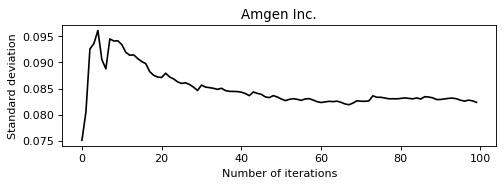

In [19]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(predstd, color = 'black')
plt.title('Amgen Inc.')
plt.xlabel('Number of iterations')
plt.ylabel('Standard deviation')
plt.show()

Shaping the predictions

In [20]:
df_res = pd.DataFrame(list(map(np.ravel, predres)))
meanres = df_res.mean(axis=0)
meanres = np.array(meanres)
meanres = np.reshape(meanres, (meanres.shape[0], 1))

meanres20d = meanres[:20]
ym_test20d = ym_test[:20]

df_meanres20d = pd.DataFrame({'predictionsc': meanres20d[:, 0]})
df_ym_test20d = pd.DataFrame({'realsc': ym_test20d[:, 0]})

df_meanres20d['prediction'] = sc2.inverse_transform(df_meanres20d['predictionsc'].values.reshape(-1,1))
df_ym_test20d['real'] = sc2.inverse_transform(df_ym_test20d['realsc'].values.reshape(-1,1))

print(df_meanres20d)
print(df_ym_test20d)

    predictionsc  prediction
0       0.541229    0.000007
1       0.562128    0.000015
2       0.582181    0.000023
3       0.469654   -0.000019
4       0.460512   -0.000023
5       0.490408   -0.000011
6       0.419698   -0.000038
7       0.552995    0.000012
8       0.441938   -0.000030
9       0.372364   -0.000055
10      0.610298    0.000033
11      0.515248   -0.000002
12      0.470421   -0.000019
13      0.515661   -0.000002
14      0.475504   -0.000017
15      0.399269   -0.000045
16      0.613816    0.000035
17      0.534916    0.000005
18      0.474875   -0.000017
19      0.508579   -0.000005
      realsc      real
0   0.548499  0.000010
1   0.536742  0.000006
2   0.599902  0.000029
3   0.570401  0.000018
4   0.516246 -0.000002
5   0.586375  0.000024
6   0.535891  0.000005
7   0.580186  0.000022
8   0.431340 -0.000033
9   0.532355  0.000004
10  0.493705 -0.000010
11  0.458640 -0.000023
12  0.530763  0.000004
13  0.626834  0.000039
14  0.624975  0.000039
15  0.647796  0.000047


Visualization of the results

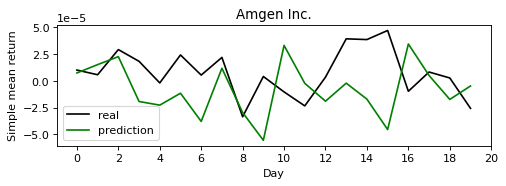

In [21]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(df_ym_test20d['real'], color='black', label='real')
plt.plot(df_meanres20d['prediction'], color='green', label='prediction')
plt.xticks(np.arange(0, 20+1, 2.0))
plt.title('Amgen Inc.')
plt.xlabel('Day')
plt.ylabel('Simple mean return')
plt.legend()
plt.show()

Mean squared error of the results

In [22]:
diff_res = np.subtract(df_ym_test20d['real'], df_meanres20d['prediction'])
sq_res = np.square(diff_res)
mseres = sq_res.mean()

print(mseres)

1.391273385066501e-09


In [23]:
diff_res = np.subtract(df_ym_test20d['realsc'], df_meanres20d['predictionsc'])
sq_res = np.square(diff_res)
mseres_sc = sq_res.mean()

print(mseres_sc)

0.01002465735840505


Saving the results and the model

In [24]:
df_meanres20d.to_csv(r'C:\Users\nmart\Documents\Office\ZU\S8\Bachelor-Thesis\Nils_Test_Daten\Nils_Test_Daten\Finales\CNN1_res_AMGN.csv', index = False)

In [25]:
model.save('models/CNN1_AMGN')

INFO:tensorflow:Assets written to: models/CNN1_AMGN\assets
